# Project: Advanced Lane Finding



## Imports, named constans and parameters


In [1]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Named constants
CHESSBOARD_IMAGE = 'camera_cal/calibration2.jpg'
TEST_IMAGE = 'test_images/ztest8.jpg'
#TEST_IMAGE = 'test_images/straight_lines2.jpg'
OUTPUT_IMAGE_DIR = 'output_images'

# Parameters
# Boxes in the chessboard
NX = 9
NY = 6

# Lane width and height in pixels
X_PIXELS = 600
Y_PIXELS = 720

# Meters per pixel in x and y dimension
X_METERS_PER_PIXEL = 3.7/X_PIXELS     
Y_METERS_PER_PIXEL = 30/Y_PIXELS

# Horizontal and vertical center in meters
H_CENTER = (1280/2) * X_METERS_PER_PIXEL
V_CENTER = (720/2) * Y_METERS_PER_PIXEL


## Step 1

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.

### Step 1 Functions


In [2]:
def collectCorners(imageFiles, nx, ny):
    '''
    Collect object points and image points from the chessboard images
    '''
    objPoints = []
    imagePoints = []

    objPoint = np.zeros((ny*nx,3), np.float32)
    objPoint[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    for imageFile in imageFiles:
        image = mpimg.imread(imageFile)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            objPoints.append(objPoint)
            imagePoints.append(corners)
            
    return objPoints,imagePoints

def undistort(image, objPoints, imagePoints):
    '''
    Create an undistorted image given the object points and image points
    '''
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imagePoints, (image.shape[1], image.shape[0]), None, None)
    return cv2.undistort(image, mtx, dist, None, mtx)

### Step 1 Test

* Camera calibration
* Undistortion of an image


In [3]:
imageFiles = glob.glob('camera_cal/*.jpg')
objPoints,imagePoints = collectCorners(imageFiles, NX, NY)

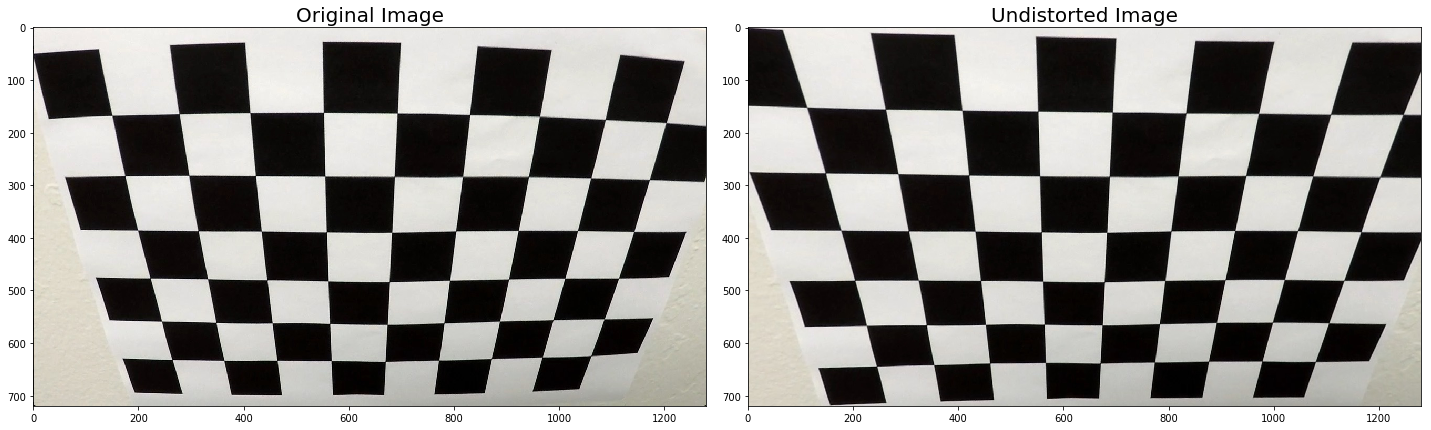

In [4]:
chessboard = mpimg.imread(CHESSBOARD_IMAGE)
undistorted_chessboard = undistort(chessboard, objPoints, imagePoints)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.tight_layout()
ax1.imshow(chessboard, cmap='gray')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted_chessboard, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'undistorted_chessboard.jpg'))

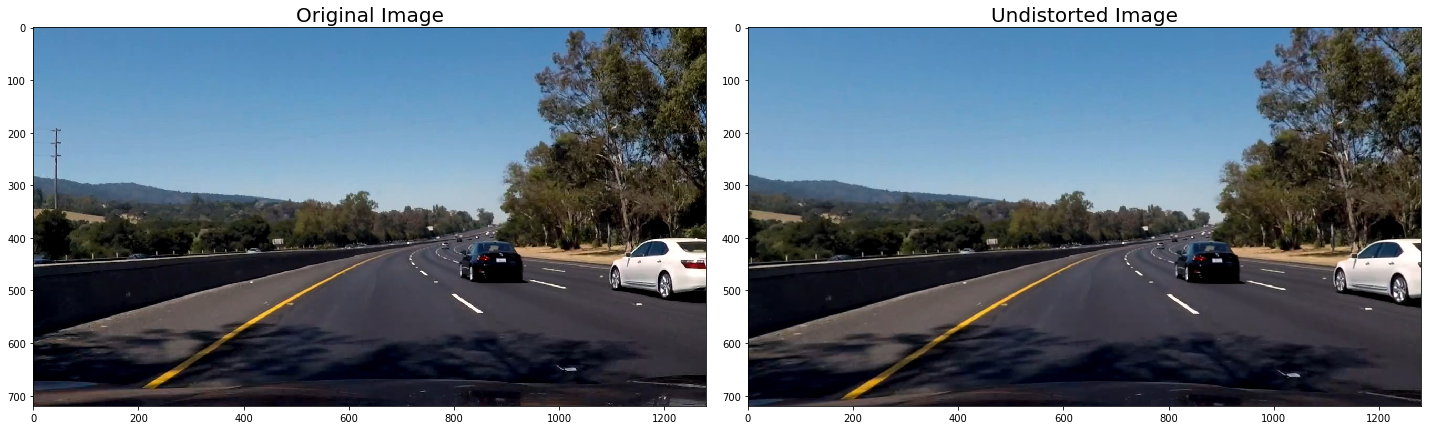

In [5]:
image = mpimg.imread(TEST_IMAGE)
undistorted = undistort(image, objPoints, imagePoints)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.tight_layout()
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'undistorted.jpg'))

## Step 2

* Create a thresholded binary image using color transforms and gradients.

### Step 2 Functions


In [6]:
def thresholdColorGradient(undistorted, sThreshold=(130,255), xThreshold=(15,100)):
    '''
    Create thresholded binary images using color transforms and gradients given the undistorted image and thesholds
    '''
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS).astype(np.float)
    lChannel = hls[:,:,1]
    sChannel = hls[:,:,2]

    # Take the derivative in x using the Sobel operator
    # Absolute x derivative to accentuate lines away from horizontal
    sobelX = cv2.Sobel(lChannel, cv2.CV_64F, 1, 0)
    absSobelX = np.absolute(sobelX)
    xSobel = np.uint8(255 * absSobelX/np.max(absSobelX))

    # Threshold x gradient
    xBinary = np.zeros_like(xSobel)
    xBinary[(xThreshold[0] <= xSobel) & (xSobel <= xThreshold[1])] = 1

    # Threshold color channel
    sBinary = np.zeros_like(sChannel)
    sBinary[(sThreshold[0] <= sChannel) & (sChannel <= sThreshold[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    colorBinary = np.dstack((np.zeros_like(xBinary), xBinary, sBinary))

    # Combine the two binary thresholds
    combinedBinary = np.zeros_like(xBinary)
    combinedBinary[(sBinary == 1) | (xBinary == 1)] = 1

    return combinedBinary,colorBinary

### Step 2 Test

* Creation of thresholded binary images


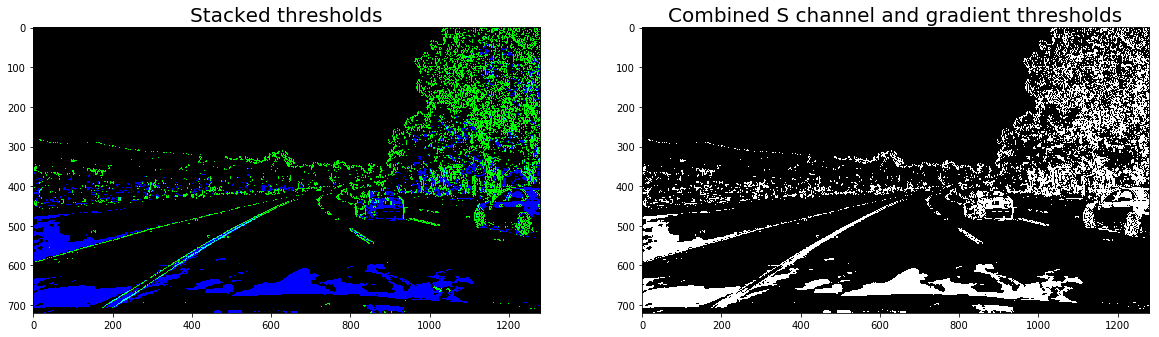

In [7]:
combinedBinary,colorBinary = thresholdColorGradient(undistorted)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax2.set_title('Combined S channel and gradient thresholds', fontsize=20)
ax2.imshow(combinedBinary, cmap='gray')

ax1.set_title('Stacked thresholds', fontsize=20)
ax1.imshow(colorBinary)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'binary.jpg'))

## Step 3

* Set a region where a perspective transform is applied. The region is a fixed one at this point.
* Apply the perspective transform to rectify binary image.


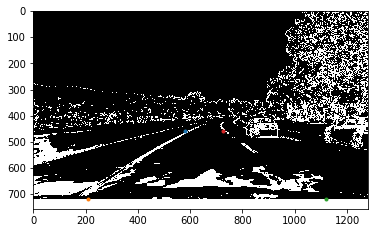

In [8]:
imageSize = (combinedBinary.shape[1], combinedBinary.shape[0]) 

srcUpperLeft = [580, 460] #[590, 460]
srcLowerLeft = [210, imageSize[1]]
srcLowerRight = [1120, imageSize[1]] # [1120, ]
srcUpperRight = [725, 460] #[690, 460] # [705, ]

#srcUpperLeft = [(imageSize[0] / 2) - 55, imageSize[1] / 2 + 100]
#srcLowerLeft = [((imageSize[0] / 6) - 10), imageSize[1]]
#srcLowerRight = [(imageSize[0] * 5 / 6) + 60, imageSize[1]]
#srcUpperRight = [(imageSize[0] / 2 + 55), imageSize[1] / 2 + 100]

dstUpperLeft = [(imageSize[0] / 4), 0]
dstLowerLeft = [(imageSize[0] / 4), imageSize[1]]
dstLowerRight = [(imageSize[0] * 3 / 4), imageSize[1]]
dstUpperRight = [(imageSize[0] * 3 / 4), 0]

plt.imshow(combinedBinary, cmap='gray')
plt.plot(srcUpperLeft[0],srcUpperLeft[1],".")
plt.plot(srcLowerLeft[0], srcLowerLeft[1], ".")
plt.plot(srcLowerRight[0], srcLowerRight[1], ".")
plt.plot(srcUpperRight[0],srcUpperRight[1],".")

### Step 3 Functions


In [9]:
def warp(undistorted):
    '''
    Apply the perspective transform to the undistorted binary image
    Return the inverse perspective transform matrix as well as the transformed image
    '''
    # The source region determined above
    src = np.float32(
        [srcUpperLeft,
         srcLowerLeft,
         srcLowerRight,
         srcUpperRight])
    
    # The destination region
    dst = np.float32(
        [dstUpperLeft,
         dstLowerLeft,
         dstLowerRight,
         dstUpperRight])
    
    # Calculate the perspective transform matrix given src and dst points
    # Calculate the inverse perspective transform matrix given src and dst points
    # Warp the image
    imageSize = (undistorted.shape[1], undistorted.shape[0])
    perspective = cv2.getPerspectiveTransform(src, dst)
    inversePerspective = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undistorted, perspective, imageSize, flags=cv2.INTER_LINEAR)
    
    return warped, inversePerspective

### Step 3 Test

* The perspective transform to the undistorted binary image


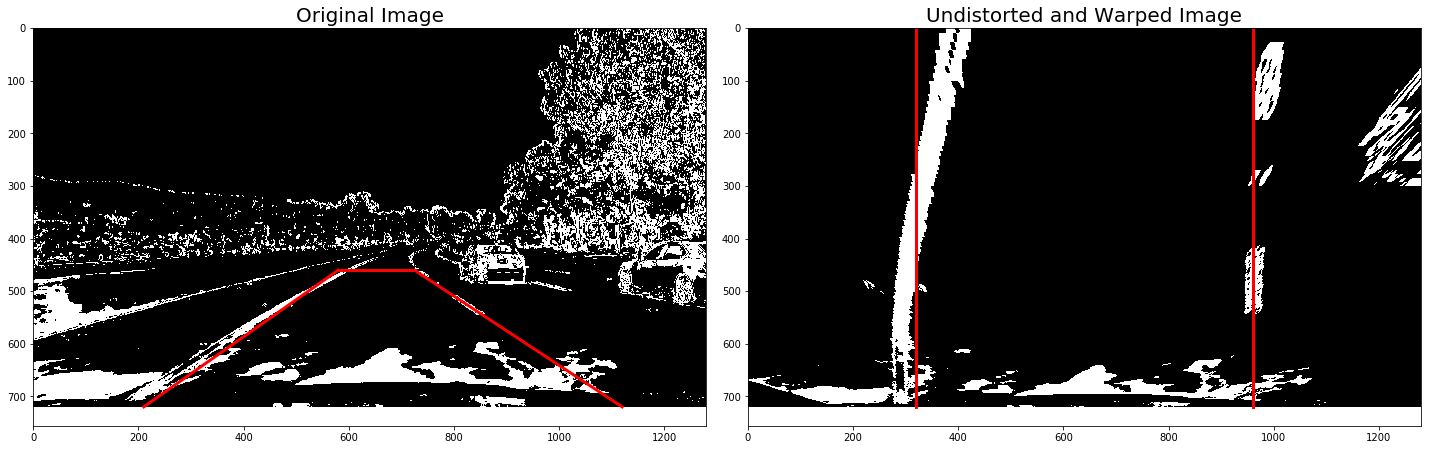

In [10]:
warped, inversePerspective = warp(combinedBinary)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.tight_layout()

color = 'red'
linewidth = 3

ax1.imshow(combinedBinary, cmap='gray')
ax1.plot([srcLowerLeft[0], srcUpperLeft[0]], [srcLowerLeft[1], srcUpperLeft[1]], color=color, linewidth=linewidth)
ax1.plot([srcLowerRight[0], srcUpperRight[0]], [srcLowerRight[1], srcUpperRight[1]], color=color, linewidth=linewidth)
ax1.plot([srcUpperLeft[0], srcUpperRight[0]], [srcUpperLeft[1], srcUpperRight[1]], color=color, linewidth=linewidth)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=20)
ax2.plot([dstLowerLeft[0], dstUpperLeft[0]], [dstLowerLeft[1], dstUpperLeft[1]], color=color, linewidth=linewidth)
ax2.plot([dstLowerRight[0], dstUpperRight[0]], [dstLowerRight[1], dstUpperRight[1]], color=color, linewidth=linewidth)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'warped_binary.jpg'))

## Step 4

* Check a histogram of pixels of the undistorted binary image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.


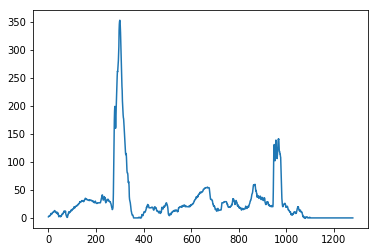

In [11]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

### Step 4 Functions


In [12]:
# Functions to calculate radii of curvature

def curveRadius(fitted, yValue, Y_METERS_PER_PIXEL):
    return ((1 + (2 * fitted[0] * yValue * Y_METERS_PER_PIXEL + fitted[1])**2)**1.5) / np.absolute(2 * fitted[0])


def polynomial(fitted, plotY):
    return fitted[0] * plotY**2 + fitted[1] * plotY + fitted[2]


def measureCarvature(leftX, leftY, rightX, rightY, plotY):
    '''
    Calculate radii of curvature in meters
    '''    
    # Fit polynomials to x,y
    leftFit = np.polyfit(leftY * Y_METERS_PER_PIXEL, leftX * X_METERS_PER_PIXEL, 2)
    rightFit = np.polyfit(rightY * Y_METERS_PER_PIXEL, rightX * X_METERS_PER_PIXEL, 2)
    
    # Calculate the vehicle potision from the center
    # Calculate the vertical and horizontal center as the lane center
    # Then calculate the vehicle position
    # Negative value: left from center
    # Positive value: right from center
    left = polynomial(leftFit, V_CENTER)
    right = polynomial(rightFit, V_CENTER)
    position = H_CENTER - ((left + right)/2.0)
    
    # Calculate the radii of curvature in meters
    yValue = np.max(plotY)    
    leftCurveRadius = curveRadius(leftFit, yValue, Y_METERS_PER_PIXEL)
    rightCurveRadius = curveRadius(rightFit, yValue, Y_METERS_PER_PIXEL)
    
    return leftCurveRadius, rightCurveRadius, position


# Function to find lanes

def needsFullScan(yes):
    '''
    Flag to see if a full scan of a frame is needed
    '''
    needsFullScan.yes = yes
    
    
def fitted(leftFit, rightFit, leftX, leftY, rightX, rightY):
    '''
    Store the coefficients of the polynomials
    '''
    fitted.leftFit = leftFit
    fitted.rightFit = rightFit
    fitted.leftX = leftX
    fitted.leftY = leftY
    fitted.rightX = rightX
    fitted.rightY = rightY
    
def measured(leftCurveRadius, rightCurveRadius, position):
    '''
    Store the left and right radii of curvature
    '''
    measured.leftCurveRadius = leftCurveRadius
    measured.rightCurveRadius = rightCurveRadius
    measured.position = position


def validated(leftFit, rightFit, leftCurveRadius, rightCurveRadius):
    '''
    Validate the fits of the polynomials and radii
    '''
    validated.bad
    
    # In case that the full scan is done
    if len(fitted.leftFit) == 0 and len(fitted.rightFit) == 0 and \
            measured.leftCurveRadius == 0 and measured.rightCurveRadius == 0:
        return True

    # Otherwise
    diff = 30 #30
    leftFitDiff = abs(fitted.leftFit[2] - leftFit[2])
    rightFitDiff = abs(fitted.rightFit[2] - rightFit[2])
    goodFit = (leftFitDiff < diff) and (rightFitDiff < diff)
    
    print('fit:')
    print(fitted.leftFit[2], leftFit[2], fitted.leftFit[2] - leftFit[2])
    print(fitted.rightFit[2], rightFit[2], fitted.rightFit[2] - rightFit[2])
    
    ratio = 100
    minLeftCurveRadius = measured.leftCurveRadius/ratio
    maxLeftCurveRadius = measured.leftCurveRadius * ratio
    minRightCurveRadius = measured.rightCurveRadius/ratio
    maxRightCurveRadius = measured.rightCurveRadius * ratio
    goodRadius = (minLeftCurveRadius < leftCurveRadius < maxLeftCurveRadius) and \
                    (minRightCurveRadius < rightCurveRadius < maxRightCurveRadius)
    
    print('radius:')
    print(measured.leftCurveRadius/ratio, leftCurveRadius, measured.leftCurveRadius * ratio)
    print(measured.rightCurveRadius/ratio, rightCurveRadius, measured.rightCurveRadius * ratio)
    
    print(goodFit)
    print(goodRadius)
    
    maxBadValidations = 4 #3
    if not goodFit or not goodRadius:  
        validated.bad += 1
        
        if maxBadValidations < validated.bad:
            validated.bad = 0
            needsFullScan.yes = True

        return False
    
    validated.bad = 0
    return True
    
    
def nonzeroIndices(lowX, highX, lowY, highY, nonzeroX, nonzeroY):
    '''
    Return indices of nonzero pixels given the low and high indices
    '''
    return ((lowY <= nonzeroY) & (nonzeroY < highY) & (lowX <= nonzeroX) & (nonzeroX < highX)).nonzero()[0]


def laneIndices(leftFit, rightFit, nonzeroX, nonzeroY, margin):
    '''
    Return indices around the plynomials given the margin
    '''
    def laneIndex(fitted, nonzeroX, nonzeroY, margin):
        return (((fitted[0]*(nonzeroY**2) + fitted[1]*nonzeroY + fitted[2] - margin) < nonzeroX) &
            (nonzeroX < (fitted[0]*(nonzeroY**2) + fitted[1]*nonzeroY + fitted[2] + margin)))
    
    leftLaneIndices = laneIndex(leftFit, nonzeroX, nonzeroY, margin)
    rightLaneIndices = laneIndex(rightFit, nonzeroX, nonzeroY, margin)
    
    return leftLaneIndices, rightLaneIndices

def smooth(leftFit, rightFit, plotY):
    smooth.leftFitXHist
    smooth.rightFitXHist
    
    leftFitX = polynomial(leftFit, plotY)
    rightFitX = polynomial(rightFit, plotY)
    
    smooth.leftFitXHist.append(leftFitX)
    smooth.rightFitXHist.append(rightFitX)
    
    history = 13
    if len(smooth.leftFitXHist) < history:
        return leftFitX, rightFitX
    else:
        smooth.leftFitXHist = smooth.leftFitXHist[1:]
        smooth.rightFitXHist = smooth.rightFitXHist[1:]
        return np.mean(np.array(smooth.leftFitXHist),axis=0)[:len(plotY)], \
                np.mean(np.array(smooth.rightFitXHist),axis=0)[:len(plotY)]

def laneFits(fitted, plotY):
    '''
    Calculate the value of the polynomials
    '''
    leftFit = polynomial(fitted.leftFit, plotY)
    rightFit = polynomial(fitted.rightFit, plotY)
    
    return leftFit, rightFit


def findLanes(warped, numberOfWindows=9, windowMargin=70, minPixels=50): #70
    '''
    Find lanes in the undistorted binary image using the sliding window
    '''
    # Left and right lane pixel indices
    leftLaneIndices = []
    rightLaneIndices = []
    
    # Left and right lane pixel positions
    leftX = []
    leftY = []
    rightX = []
    rightY = []
      
    # Identify the x and y positions of all nonzero pixels in the image first
    nonzero = warped.nonzero()
    nonzeroY = np.array(nonzero[0])
    nonzeroX = np.array(nonzero[1])
    
    # In case of the first frame of a video or validation failure
    if needsFullScan.yes:
        print('full scan')
        # Take a histogram of the bottom half of the image
        histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        midPoint = np.int(histogram.shape[0]/2)
        leftBaseX = np.argmax(histogram[:midPoint])
        rightBaseX = np.argmax(histogram[midPoint:]) + midPoint
        
        # Set height of windows
        windowHeight = np.int(warped.shape[0]/numberOfWindows)
        
        # Current positions to be updated for each window
        leftCurrentX = leftBaseX
        rightCurrentX = rightBaseX
        
        # Step through the windows
        for index in range(numberOfWindows):
            
            # Identify window boundaries in x and y (and right and left)
            lowY = warped.shape[0] - (index+1) * windowHeight
            highY = warped.shape[0] - index * windowHeight
            leftLowX = leftCurrentX - windowMargin
            leftHighX = leftCurrentX + windowMargin
            rightLowX = rightCurrentX - windowMargin
            rightHighX = rightCurrentX + windowMargin
            
            # Identify the nonzero pixels in x and y within the window
            leftNonzeroIndices = nonzeroIndices(leftLowX, leftHighX, lowY, highY, nonzeroX, nonzeroY)
            rightNonzeroIndices = nonzeroIndices(rightLowX, rightHighX, lowY, highY, nonzeroX, nonzeroY)
            
            # Append these indices to the lists
            leftLaneIndices.extend(leftNonzeroIndices)
            rightLaneIndices.extend(rightNonzeroIndices)
            
            # If minPixels < pixels are found, recenter next window on their mean position
            if minPixels < len(leftNonzeroIndices):
                leftCurrentX = np.int(np.mean(nonzeroX[leftNonzeroIndices]))
            if minPixels < len(rightNonzeroIndices):
                rightCurrentX = np.int(np.mean(nonzeroX[rightNonzeroIndices]))
        
        needsFullScan(False)
        
    # In case the full scan is done and the previous fits and measurements are available
    else:
        # Get indices around the plynomials given the margin 
        # leveraging the second order polynomials of the previous frame
        leftLaneIndices,rightLaneIndices = laneIndices(fitted.leftFit, fitted.rightFit, nonzeroX, nonzeroY, windowMargin)
        
    # Extract left and right line pixel positions
    leftX = nonzeroX[leftLaneIndices]
    leftY = nonzeroY[leftLaneIndices]
    rightX = nonzeroX[rightLaneIndices]
    rightY = nonzeroY[rightLaneIndices]
        
    # Fit a second order polynomial
    leftFit = np.polyfit(leftY, leftX, 2)
    rightFit = np.polyfit(rightY, rightX, 2)

    # Generate y values for plotting
    plotY = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    
    # Measure curvature first    
    leftCurveRadius, rightCurveRadius, position = measureCarvature(leftX, leftY, rightX, rightY, plotY)    

    # Validate fits and curve radii
    if validated(leftFit, rightFit, leftCurveRadius, rightCurveRadius):
        print('validated')
        fitted(leftFit, rightFit, leftX, leftY, rightX, rightY)
        measured(leftCurveRadius, rightCurveRadius, position)
    
    print(validated.bad)
    print(needsFullScan.yes)
    #print(fitted.leftFit)
    #print(fitted.rightFit)
    
    # Generate x values for plotting
    #leftFitX, rightFitX = laneFits(fitted, plotY)
    #leftFitX = polynomial(fitted.leftFit, plotY)
    #rightFitX = polynomial(fitted.rightFit, plotY)
    leftFitX, rightFitX = smooth(fitted.leftFit, fitted.rightFit, plotY)
    
    '''
    leftX = fitted.leftX
    leftY = fitted.leftY
    rightX = fitted.rightX
    rightY = fitted.rightY
    
    leftCurveRadius = measured.leftCurveRadius
    rightCurveRadius = measured.rightCurveRadius
    position = measured.position
    
    # If a full scan needs for the next frame, 
    # clear the precious fits and measurements to forcefully use the scanned data
    
    if needsFullScan.yes:
        fitted.leftFit = []
        fitted.rightFit = []
        measured.leftCurveRadius = 0
        measured.rightCurveRadius = 0
        measured.position = 0
    '''
    # Start drawing the image from here
    output = np.dstack((warped, warped, warped))*255    
    windowImage = np.zeros_like(output)
    
    # Color in left and right line pixels
    output[fitted.leftY, fitted.leftX] = [255, 0, 0]
    output[fitted.rightY, fitted.rightX] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # Then, recast the x and y points into usable format for cv2.fillPoly()
    leftLineWindow1 = np.array([np.transpose(np.vstack([leftFitX - windowMargin, plotY]))])
    leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitX + windowMargin, plotY])))])
    leftLinePoints = np.hstack((leftLineWindow1, leftLineWindow2))
    
    rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitX - windowMargin, plotY]))])
    rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitX + windowMargin, plotY])))])
    rightLinePoints = np.hstack((rightLineWindow1, rightLineWindow2))
    
    # Draw the lanes
    cv2.fillPoly(windowImage, np.int_([leftLinePoints]), (0, 255, 0))
    cv2.fillPoly(windowImage, np.int_([rightLinePoints]), (0, 255, 0))
    lanes = cv2.addWeighted(output, 1, windowImage, 0.3, 0)
    
    return lanes, leftFitX, rightFitX, plotY, measured.leftCurveRadius, measured.rightCurveRadius, measured.position

### Step 4 Test

* Lane detection using the sliding window


full scan
validated
0
False


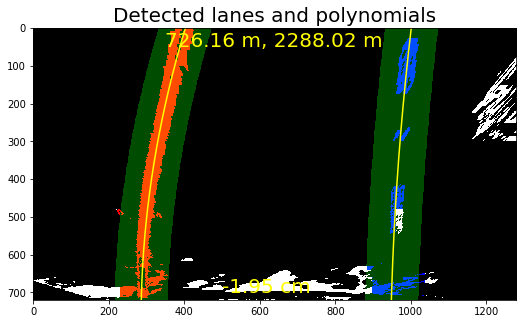

In [13]:
# Initialization
fitted.leftFit = []
fitted.rightFit = []
measured.leftCurveRadius = 0
measured.rightCurveRadius = 0
measured.position = 0
smooth.leftFitXHist = []
smooth.rightFitXHist = []
needsFullScan.yes = True
validated.bad = 0

lanes, leftFitX, rightFitX, plotY, leftCurveRadius, rightCurveRadius, position = findLanes(warped)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(lanes)
ax.set_title('Detected lanes and polynomials', fontsize=20)
ax.plot(leftFitX, plotY, color='yellow')
ax.plot(rightFitX, plotY, color='yellow')
ax.text(350, 50,'%.2f m, %.2f m' % (leftCurveRadius, rightCurveRadius), color='yellow', fontsize=20)
ax.text(500, 700, '%.2f cm' % (position * 100), color='yellow', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'lanes_polynomials.jpg'))

## Step 5

* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Step 5 Functions


In [14]:
def projectLanes(originalImage, undistorted, warped, inversePerspective, leftFitX, rightFitX, plotY):
    '''
    Create the original image with the lane boundaries
    '''
    zeroWarp = np.zeros_like(warped).astype(np.uint8)
    colorWarp = np.dstack((zeroWarp, zeroWarp, zeroWarp))

    # Recast the x and y points into usable format for cv2.fillPoly()
    leftPoints = np.array([np.transpose(np.vstack([leftFitX, plotY]))])
    rightPoints = np.array([np.flipud(np.transpose(np.vstack([rightFitX, plotY])))])
    points = np.hstack((leftPoints, rightPoints))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(colorWarp, np.int_([points]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix
    # Combine the result with the original image
    backed = cv2.warpPerspective(colorWarp, inversePerspective, (originalImage.shape[1], originalImage.shape[0]))
    return cv2.addWeighted(undistorted, 1, backed, 0.3, 0)

### Step 5 Test

* Creation of the original image with the lane boundaries


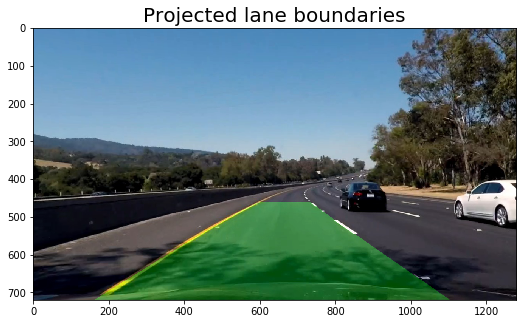

In [15]:
projected = projectLanes(image, undistorted, warped, inversePerspective, leftFitX, rightFitX, plotY)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(projected)
ax.set_title('Projected lane boundaries', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'projected.jpg'))

## Pipeline to process a video


In [16]:
fitted.leftFit = []
fitted.rightFit = []
measured.leftCurveRadius = 0
measured.rightCurveRadius = 0
measured.position = 0
smooth.leftFitXHist = []
smooth.rightFitXHist = []
needsFullScan.yes = True
validated.bad = 0

font = cv2.FONT_HERSHEY_COMPLEX
fontSize = 1
color = (255, 255, 255)
thickness = 2

def pipeline(image):
    '''
    Process each frame of a video to map lane boundaries
    '''
    undistorted = undistort(image, objPoints, imagePoints)
    combinedBinary, colorBinary = thresholdColorGradient(undistorted)
    warped, inversePerspective = warp(combinedBinary)
    lanes, leftFitX, rightFitX, plotY, leftCurveRadius, rightCurveRadius, position = findLanes(warped)
    projected = projectLanes(image, undistorted, warped, inversePerspective, leftFitX, rightFitX, plotY)
    
    cv2.putText(projected,'Radius of curvature = L %.2f m, R %.2f m' % (leftCurveRadius, rightCurveRadius), (100, 50), font, fontSize, color, thickness)
    cv2.putText(projected, 'Vehicle position = %.2f cm from center' % (position * 100), (100, 100), font, fontSize, color, thickness)
    
    return projected

In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
projectOutput = 'project.mp4'
clipProject = VideoFileClip("project_video.mp4")
projectClip = clipProject.fl_image(pipeline)
%time projectClip.write_videofile(projectOutput, audio=False)

full scan
validated
0
False
[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


  0%|          | 1/1261 [00:00<16:29,  1.27it/s]

fit:
284.977963027 285.042211995 -0.0642489677133
822.994474924 823.116040047 -0.121565123758
radius:
6.26251843674 651.996840841 62625.1843674
8.86388669454 923.129592093 88638.8669454
True
True
validated
0
False


  0%|          | 2/1261 [00:01<16:47,  1.25it/s]

fit:
285.042211995 283.933179865 1.10903212984
823.116040047 818.822549293 4.29349075433
radius:
6.51996840841 671.230855421 65199.6840841
9.23129592093 1040.35650408 92312.9592093
True
True
validated
0
False


  0%|          | 3/1261 [00:02<17:23,  1.21it/s]

fit:
283.933179865 282.439236971 1.493942894
818.822549293 800.498836323 18.32371297
radius:
6.71230855421 610.572863347 67123.0855421
10.4035650408 656.206448198 104035.650408
True
True
validated
0
False


  0%|          | 4/1261 [00:03<17:15,  1.21it/s]

fit:
282.439236971 280.327242955 2.11199401627
800.498836323 787.44828688 13.0505494428
radius:
6.10572863347 582.211401774 61057.2863347
6.56206448198 545.037378655 65620.6448198
True
True
validated
0
False


  0%|          | 5/1261 [00:04<16:48,  1.25it/s]

fit:
280.327242955 279.061723031 1.26551992376
787.44828688 792.263363439 -4.81507655881
radius:
5.82211401774 564.238575319 58221.1401774
5.45037378655 660.1845594 54503.7378655
True
True
validated
0
False


  0%|          | 6/1261 [00:04<16:31,  1.27it/s]

fit:
279.061723031 280.274291974 -1.21256894302
792.263363439 789.549835802 2.71352763682
radius:
5.64238575319 605.768710438 56423.8575319
6.601845594 760.931808836 66018.45594
True
True
validated
0
False


  1%|          | 7/1261 [00:05<16:28,  1.27it/s]

fit:
280.274291974 277.103078063 3.17121391139
789.549835802 795.564507992 -6.01467219003
radius:
6.05768710438 632.507547976 60576.8710438
7.60931808836 858.223781539 76093.1808836
True
True
validated
0
False


  1%|          | 8/1261 [00:06<16:15,  1.28it/s]

fit:
277.103078063 276.674047785 0.429030277585
795.564507992 797.962298586 -2.39779059365
radius:
6.32507547976 644.322443008 63250.7547976
8.58223781539 2072.5161044 85822.3781539
True
True
validated
0
False


  1%|          | 9/1261 [00:07<16:06,  1.30it/s]

fit:
276.674047785 271.7294816 4.94456618523
797.962298586 803.128886048 -5.16658746192
radius:
6.44322443008 661.152993034 64432.2443008
20.725161044 5343.08157481 207251.61044
True
True
validated
0
False


  1%|          | 10/1261 [00:07<16:07,  1.29it/s]

fit:
271.7294816 270.226867789 1.5026138115
803.128886048 802.416892948 0.711993099411
radius:
6.61152993034 715.479644873 66115.2993034
53.4308157481 4194.96484642 534308.157481
True
True
validated
0
False


  1%|          | 11/1261 [00:08<16:02,  1.30it/s]

fit:
270.226867789 269.35293686 0.873930928901
802.416892948 789.932638215 12.4842547335
radius:
7.15479644873 761.157657055 71547.9644873
41.9496484642 1106.36553543 419496.484642
True
True
validated
0
False


  1%|          | 12/1261 [00:09<15:57,  1.30it/s]

fit:
269.35293686 265.535574343 3.8173625168
789.932638215 808.274606972 -18.3419687576
radius:
7.61157657055 839.666461109 76115.7657055
11.0636553543 1265.15573763 110636.553543
True
True
validated
0
False


  1%|          | 13/1261 [00:10<16:06,  1.29it/s]

fit:
265.535574343 264.970920721 0.564653621775
808.274606972 804.201836997 4.07276997578
radius:
8.39666461109 985.377376795 83966.6461109
12.6515573763 1404.36779599 126515.573763
True
True
validated
0
False


  1%|          | 14/1261 [00:11<16:17,  1.28it/s]

fit:
264.970920721 264.39085733 0.580063390917
804.201836997 805.527093678 -1.32525668124
radius:
9.85377376795 986.659577796 98537.7376795
14.0436779599 2150.07668034 140436.779599
True
True
validated
0
False


  1%|          | 15/1261 [00:11<16:11,  1.28it/s]

fit:
264.39085733 267.969976635 -3.57911930507
805.527093678 778.217859158 27.3092345195
radius:
9.86659577796 1089.49969357 98665.9577796
21.5007668034 776.26899809 215007.668034
True
True
validated
0
False


  1%|▏         | 16/1261 [00:12<16:07,  1.29it/s]

fit:
267.969976635 275.431063892 -7.46108725629
778.217859158 761.91386056 16.3039985986
radius:
10.8949969357 1596.08135431 108949.969357
7.7626899809 667.081739246 77626.899809
True
True
validated
0
False


  1%|▏         | 17/1261 [00:13<16:04,  1.29it/s]

fit:
275.431063892 270.429009269 5.00205462237
761.91386056 764.602412942 -2.68855238184
radius:
15.9608135431 1087.33998394 159608.135431
6.67081739246 801.315327066 66708.1739246
True
True
validated
0
False


  1%|▏         | 18/1261 [00:14<16:00,  1.29it/s]

fit:
270.429009269 273.348166134 -2.91915686529
764.602412942 764.630588604 -0.0281756620948
radius:
10.8733998394 1252.44043237 108733.998394
8.01315327066 1031.42072088 80131.5327066
True
True
validated
0
False


  2%|▏         | 19/1261 [00:14<15:55,  1.30it/s]

fit:
273.348166134 270.316349837 3.03181629746
764.630588604 774.593854142 -9.96326553827
radius:
12.5244043237 1301.90629376 125244.043237
10.3142072088 1147.6044383 103142.072088
True
True
validated
0
False


  2%|▏         | 20/1261 [00:15<15:56,  1.30it/s]

fit:
270.316349837 268.350046389 1.96630344843
774.593854142 780.36811096 -5.77425681755
radius:
13.0190629376 1409.55889372 130190.629376
11.476044383 1187.89366773 114760.44383
True
True
validated
0
False


  2%|▏         | 21/1261 [00:16<15:49,  1.31it/s]

fit:
268.350046389 266.144647832 2.20539855615
780.36811096 790.05764491 -9.68953395076
radius:
14.0955889372 1542.591724 140955.889372
11.8789366773 1324.12344312 118789.366773
True
True
validated
0
False


  2%|▏         | 22/1261 [00:17<15:56,  1.29it/s]

fit:
266.144647832 263.107730492 3.0369173399
790.05764491 801.066919453 -11.0092745432
radius:
15.42591724 1366.92506904 154259.1724
13.2412344312 2008.61357718 132412.344312
True
True
validated
0
False


  2%|▏         | 23/1261 [00:17<15:51,  1.30it/s]

fit:
263.107730492 261.894965613 1.21276487925
801.066919453 806.877082726 -5.81016327212
radius:
13.6692506904 1448.24583492 136692.506904
20.0861357718 1719.02959095 200861.357718
True
True
validated
0
False


  2%|▏         | 24/1261 [00:18<15:53,  1.30it/s]

fit:
261.894965613 262.24541655 -0.350450936327
806.877082726 796.355550321 10.5215324046
radius:
14.4824583492 1282.82069224 144824.583492
17.1902959095 901.685605161 171902.959095
True
True
validated
0
False


  2%|▏         | 25/1261 [00:19<16:02,  1.28it/s]

fit:
262.24541655 262.43663244 -0.19121589062
796.355550321 790.235104719 6.12044560184
radius:
12.8282069224 1117.42411298 128282.069224
9.01685605161 778.401889511 90168.5605161
True
True
validated
0
False


  2%|▏         | 26/1261 [00:20<16:01,  1.28it/s]

fit:
262.43663244 261.02185996 1.4147724803
790.235104719 801.346416394 -11.1113116752
radius:
11.1742411298 1198.93704526 111742.411298
7.78401889511 793.33578693 77840.1889511
True
True
validated
0
False


  2%|▏         | 27/1261 [00:21<16:02,  1.28it/s]

fit:
261.02185996 261.752613151 -0.730753190942
801.346416394 807.008712354 -5.66229596018
radius:
11.9893704526 1057.6753852 119893.704526
7.9333578693 1117.44942568 79333.578693
True
True
validated
0
False


  2%|▏         | 28/1261 [00:21<15:59,  1.28it/s]

fit:
261.752613151 259.154844755 2.59776839592
807.008712354 822.133609724 -15.12489737
radius:
10.576753852 1003.34319297 105767.53852
11.1744942568 1324.47059494 111744.942568
True
True
validated
0
False


  2%|▏         | 29/1261 [00:22<15:49,  1.30it/s]

fit:
259.154844755 263.864844444 -4.70999968905
822.133609724 807.835679266 14.2979304586
radius:
10.0334319297 1083.06562551 100334.319297
13.2447059494 829.930928777 132447.059494
True
True
validated
0
False


  2%|▏         | 30/1261 [00:23<15:47,  1.30it/s]

fit:
263.864844444 267.604410875 -3.73956643141
807.835679266 786.768295404 21.0673838616
radius:
10.8306562551 1026.41823408 108306.562551
8.29930928777 573.508245927 82993.0928777
True
True
validated
0
False


  2%|▏         | 31/1261 [00:24<16:04,  1.28it/s]

fit:
267.604410875 266.345655358 1.25875551746
786.768295404 784.465567101 2.30272830346
radius:
10.2641823408 821.442279231 102641.823408
5.73508245927 668.532885692 57350.8245927
True
True
validated
0
False


  3%|▎         | 32/1261 [00:24<16:07,  1.27it/s]

fit:
266.345655358 269.800391587 -3.45473622861
784.465567101 777.016057386 7.449509715
radius:
8.21442279231 741.024911266 82144.2279231
6.68532885692 769.916493334 66853.2885692
True
True
validated
0
False


  3%|▎         | 33/1261 [00:25<16:06,  1.27it/s]

fit:
269.800391587 267.651465188 2.14892639848
777.016057386 787.445489501 -10.4294321152
radius:
7.41024911266 712.724226412 74102.4911266
7.69916493334 831.323778379 76991.6493334
True
True
validated
0
False


  3%|▎         | 34/1261 [00:26<16:14,  1.26it/s]

fit:
267.651465188 266.634178601 1.0172865868
787.445489501 786.529834288 0.915655213499
radius:
7.12724226412 659.904929651 71272.4226412
8.31323778379 1101.00680055 83132.3778379
True
True
validated
0
False


  3%|▎         | 35/1261 [00:27<16:08,  1.27it/s]

fit:
266.634178601 266.697733733 -0.0635551321246
786.529834288 784.920458935 1.60937535216
radius:
6.59904929651 644.066401748 65990.4929651
11.0100680055 1044.16666182 110100.680055
True
True
validated
0
False


  3%|▎         | 36/1261 [00:28<15:58,  1.28it/s]

fit:
266.697733733 266.672841105 0.0248926278699
784.920458935 771.000838085 13.9196208504
radius:
6.44066401748 622.889042504 64406.6401748
10.4416666182 603.591994775 104416.666182
True
True
validated
0
False


  3%|▎         | 37/1261 [00:28<16:07,  1.26it/s]

fit:
266.672841105 264.788318791 1.88452231444
771.000838085 771.623010767 -0.622172681684
radius:
6.22889042504 575.052701949 62288.9042504
6.03591994775 727.208253186 60359.1994775
True
True
validated
0
False


  3%|▎         | 38/1261 [00:29<16:22,  1.24it/s]

fit:
264.788318791 264.353619807 0.434698984137
771.623010767 774.026631002 -2.40362023578
radius:
5.75052701949 551.38412881 57505.2701949
7.27208253186 988.737729277 72720.8253186
True
True
validated
0
False


  3%|▎         | 39/1261 [00:30<16:13,  1.26it/s]

fit:
264.353619807 262.314123455 2.03949635232
774.026631002 752.27873044 21.7479005625
radius:
5.5138412881 534.463825878 55138.412881
9.88737729277 509.069337874 98873.7729277
True
True
validated
0
False


  3%|▎         | 40/1261 [00:31<15:59,  1.27it/s]

fit:
262.314123455 260.023198445 2.29092500987
752.27873044 749.554160042 2.72457039839
radius:
5.34463825878 542.585901151 53446.3825878
5.09069337874 457.718211193 50906.9337874
True
True
validated
0
False


  3%|▎         | 41/1261 [00:32<15:49,  1.28it/s]

fit:
260.023198445 258.835667599 1.18753084577
749.554160042 749.398881655 0.155278386449
radius:
5.42585901151 548.315607639 54258.5901151
4.57718211193 513.712124839 45771.8211193
True
True
validated
0
False


  3%|▎         | 42/1261 [00:32<15:41,  1.29it/s]

fit:
258.835667599 258.327488285 0.50817931374
749.398881655 751.104474782 -1.70559312676
radius:
5.48315607639 562.689013641 54831.5607639
5.13712124839 522.436492803 51371.2124839
True
True
validated
0
False


  3%|▎         | 43/1261 [00:33<16:36,  1.22it/s]

fit:
258.327488285 256.715268734 1.61221955105
751.104474782 756.342644378 -5.23816959581
radius:
5.62689013641 566.890071032 56268.9013641
5.22436492803 560.618482386 52243.6492803
True
True
validated
0
False


  3%|▎         | 44/1261 [00:34<17:05,  1.19it/s]

fit:
256.715268734 251.891444426 4.82382430813
756.342644378 766.315334488 -9.97269010995
radius:
5.66890071032 542.697769644 56689.0071032
5.60618482386 616.678590559 56061.8482386
True
True
validated
0
False


  4%|▎         | 45/1261 [00:35<17:10,  1.18it/s]

fit:
251.891444426 252.632512326 -0.741067899513
766.315334488 772.697542359 -6.38220787171
radius:
5.42697769644 587.825797653 54269.7769644
6.16678590559 643.453588788 61667.8590559
True
True
validated
0
False


  4%|▎         | 46/1261 [00:36<17:56,  1.13it/s]

fit:
252.632512326 251.328526619 1.30398570606
772.697542359 778.822724443 -6.12518208364
radius:
5.87825797653 600.665662751 58782.5797653
6.43453588788 782.15358022 64345.3588788
True
True
validated
0
False


  4%|▎         | 47/1261 [00:37<17:53,  1.13it/s]

fit:
251.328526619 249.313421325 2.01510529403
778.822724443 783.146375683 -4.32365123995
radius:
6.00665662751 612.109059126 60066.5662751
7.8215358022 900.81817957 78215.358022
True
True
validated
0
False


  4%|▍         | 48/1261 [00:38<18:34,  1.09it/s]

fit:
249.313421325 248.230445665 1.08297566078
783.146375683 779.429665874 3.71670980869
radius:
6.12109059126 617.84303777 61210.9059126
9.0081817957 976.359368076 90081.817957
True
True
validated
0
False


  4%|▍         | 49/1261 [00:39<19:35,  1.03it/s]

fit:
248.230445665 246.060517047 2.16992861808
779.429665874 785.222465036 -5.79279916169
radius:
6.1784303777 672.857417438 61784.303777
9.76359368076 765.421094601 97635.9368076
True
True
validated
0
False


  4%|▍         | 50/1261 [00:40<19:05,  1.06it/s]

fit:
246.060517047 244.401481168 1.65903587836
785.222465036 777.554836098 7.66762893831
radius:
6.72857417438 694.70040373 67285.7417438
7.65421094601 678.635066288 76542.1094601
True
True
validated
0
False


  4%|▍         | 51/1261 [00:41<19:59,  1.01it/s]

fit:
244.401481168 244.905730618 -0.504249449737
777.554836098 779.133831306 -1.57899520802
radius:
6.9470040373 745.724754912 69470.040373
6.78635066288 761.44800812 67863.5066288
True
True
validated
0
False


  4%|▍         | 52/1261 [00:42<19:26,  1.04it/s]

fit:
244.905730618 245.663798681 -0.758068063114
779.133831306 773.339588136 5.79424317012
radius:
7.45724754912 785.641120421 74572.4754912
7.6144800812 840.578209029 76144.800812
True
True
validated
0
False


  4%|▍         | 53/1261 [00:43<19:16,  1.04it/s]

fit:
245.663798681 249.330356489 -3.66655780808
773.339588136 756.510999372 16.8285887635
radius:
7.85641120421 923.69104616 78564.1120421
8.40578209029 515.727358141 84057.8209029
True
True
validated
0
False


  4%|▍         | 54/1261 [00:44<18:18,  1.10it/s]

fit:
249.330356489 250.693925611 -1.36356912172
756.510999372 748.198443662 8.31255571055
radius:
9.2369104616 1008.90406871 92369.104616
5.15727358141 506.530303268 51572.7358141
True
True
validated
0
False


  4%|▍         | 55/1261 [00:44<17:21,  1.16it/s]

fit:
250.693925611 250.203681837 0.490243773775
748.198443662 752.377888361 -4.17944469908
radius:
10.0890406871 1007.39890327 100890.406871
5.06530303268 549.215885765 50653.0303268
True
True
validated
0
False


  4%|▍         | 56/1261 [00:45<16:59,  1.18it/s]

fit:
250.203681837 249.528368824 0.675313012942
752.377888361 759.694610882 -7.31672252123
radius:
10.0739890327 1078.88027233 100739.890327
5.49215885765 631.447178191 54921.5885765
True
True
validated
0
False


  5%|▍         | 57/1261 [00:46<16:39,  1.20it/s]

fit:
249.528368824 251.41177605 -1.88340722556
759.694610882 760.802283917 -1.10767303485
radius:
10.7888027233 1141.13428585 107888.027233
6.31447178191 709.244952845 63144.7178191
True
True
validated
0
False


  5%|▍         | 58/1261 [00:47<17:02,  1.18it/s]

fit:
251.41177605 252.117308039 -0.705531988824
760.802283917 765.196176882 -4.39389296559
radius:
11.4113428585 1159.3448502 114113.428585
7.09244952845 758.434429251 70924.4952845
True
True
validated
0
False


  5%|▍         | 59/1261 [00:48<17:09,  1.17it/s]

fit:
252.117308039 256.368115087 -4.2508070484
765.196176882 754.293507953 10.9026689289
radius:
11.593448502 1102.16272278 115934.48502
7.58434429251 814.467950172 75843.4429251
True
True
validated
0
False


  5%|▍         | 60/1261 [00:49<17:02,  1.17it/s]

fit:
256.368115087 259.138067071 -2.7699519836
754.293507953 741.570650963 12.7228569902
radius:
11.0216272278 1038.72356272 110216.272278
8.14467950172 702.173269065 81446.7950172
True
True
validated
0
False


  5%|▍         | 61/1261 [00:49<17:05,  1.17it/s]

fit:
259.138067071 258.460559201 0.677507869277
741.570650963 744.743840984 -3.17319002049
radius:
10.3872356272 923.270068142 103872.356272
7.02173269065 1036.49920606 70217.3269065
True
True
validated
0
False


  5%|▍         | 62/1261 [00:50<16:37,  1.20it/s]

fit:
258.460559201 259.693417585 -1.23285838375
744.743840984 731.583427041 13.1604139432
radius:
9.23270068142 855.142434974 92327.0068142
10.3649920606 662.459516492 103649.920606
True
True
validated
0
False


  5%|▍         | 63/1261 [00:51<16:45,  1.19it/s]

fit:
259.693417585 259.614781953 0.0786356316453
731.583427041 741.37918039 -9.79575334996
radius:
8.55142434974 866.401158512 85514.2434974
6.62459516492 800.423505019 66245.9516492
True
True
validated
0
False


  5%|▌         | 64/1261 [00:52<16:39,  1.20it/s]

fit:
259.614781953 262.967161552 -3.35237959878
741.37918039 733.355783885 8.02339650532
radius:
8.66401158512 855.131017448 86640.1158512
8.00423505019 612.040065267 80042.3505019
True
True
validated
0
False


  5%|▌         | 65/1261 [00:53<16:18,  1.22it/s]

fit:
262.967161552 263.085911334 -0.118749781806
733.355783885 738.620842967 -5.26505908204
radius:
8.55131017448 970.942254149 85513.1017448
6.12040065267 621.280971561 61204.0065267
True
True
validated
0
False


  5%|▌         | 66/1261 [00:53<16:04,  1.24it/s]

fit:
263.085911334 264.415179272 -1.32926793825
738.620842967 740.118953754 -1.49811078683
radius:
9.70942254149 922.719793986 97094.2254149
6.21280971561 796.972495887 62128.0971561
True
True
validated
0
False


  5%|▌         | 67/1261 [00:54<15:56,  1.25it/s]

fit:
264.415179272 263.723359122 0.691820150082
740.118953754 745.940804073 -5.82185031912
radius:
9.22719793986 893.010594203 92271.9793986
7.96972495887 905.283463427 79697.2495887
True
True
validated
0
False


  5%|▌         | 68/1261 [00:55<15:52,  1.25it/s]

fit:
263.723359122 262.525610909 1.19774821301
745.940804073 753.063263631 -7.12245955739
radius:
8.93010594203 891.590918782 89301.0594203
9.05283463427 1022.26079386 90528.3463427
True
True
validated
0
False


  5%|▌         | 69/1261 [00:56<15:48,  1.26it/s]

fit:
262.525610909 263.391048887 -0.86543797768
753.063263631 750.726218355 2.33704527571
radius:
8.91590918782 807.277569879 89159.0918782
10.2226079386 1194.78042101 102226.079386
True
True
validated
0
False


  6%|▌         | 70/1261 [00:57<15:38,  1.27it/s]

fit:
263.391048887 260.753832712 2.63721617497
750.726218355 762.047176537 -11.3209581818
radius:
8.07277569879 804.152158223 80727.7569879
11.9478042101 1459.63988919 119478.042101
True
True
validated
0
False


  6%|▌         | 71/1261 [00:57<15:44,  1.26it/s]

fit:
260.753832712 262.658939039 -1.90510632731
762.047176537 758.726738554 3.32043798289
radius:
8.04152158223 842.821214333 80415.2158223
14.5963988919 1259.069236 145963.988919
True
True
validated
0
False


  6%|▌         | 72/1261 [00:58<15:43,  1.26it/s]

fit:
262.658939039 262.781447452 -0.122508412443
758.726738554 757.062096933 1.66464162095
radius:
8.42821214333 958.142136632 84282.1214333
12.59069236 666.533960373 125906.9236
True
True
validated
0
False


  6%|▌         | 73/1261 [00:59<15:38,  1.27it/s]

fit:
262.781447452 263.593529345 -0.812081893807
757.062096933 759.03929853 -1.97720159681
radius:
9.58142136632 1065.3224877 95814.2136632
6.66533960373 734.639574996 66653.3960373
True
True
validated
0
False


  6%|▌         | 74/1261 [01:00<15:37,  1.27it/s]

fit:
263.593529345 264.898010889 -1.3044815438
759.03929853 759.77569509 -0.736396560177
radius:
10.653224877 1194.84217069 106532.24877
7.34639574996 806.319535356 73463.9574996
True
True
validated
0
False


  6%|▌         | 75/1261 [01:01<15:36,  1.27it/s]

fit:
264.898010889 260.405635403 4.49237548635
759.77569509 769.52935233 -9.75365724039
radius:
11.9484217069 1240.54559215 119484.217069
8.06319535356 922.894276704 80631.9535356
True
True
validated
0
False


  6%|▌         | 76/1261 [01:01<15:35,  1.27it/s]

fit:
260.405635403 262.253052447 -1.84741704398
769.52935233 762.768217318 6.76113501216
radius:
12.4054559215 1384.4264729 124054.559215
9.22894276704 725.094634522 92289.4276704
True
True
validated
0
False


  6%|▌         | 77/1261 [01:02<15:36,  1.26it/s]

fit:
262.253052447 259.774909743 2.47814270433
762.768217318 776.758106007 -13.9898886887
radius:
13.844264729 1864.93629824 138442.64729
7.25094634522 757.34885652 72509.4634522
True
True
validated
0
False


  6%|▌         | 78/1261 [01:03<15:23,  1.28it/s]

fit:
259.774909743 258.580213365 1.19469637722
776.758106007 776.644699442 0.113406564347
radius:
18.6493629824 2229.69127532 186493.629824
7.5734885652 651.453063469 75734.885652
True
True
validated
0
False


  6%|▋         | 79/1261 [01:04<15:26,  1.28it/s]

fit:
258.580213365 257.460247463 1.11996590199
776.644699442 776.950050647 -0.305351204985
radius:
22.2969127532 2492.98891279 222969.127532
6.51453063469 606.896524882 65145.3063469
True
True
validated
0
False


  6%|▋         | 80/1261 [01:04<15:31,  1.27it/s]

fit:
257.460247463 260.933329854 -3.47308239037
776.950050647 772.671933714 4.27811693352
radius:
24.9298891279 3104.37713106 249298.891279
6.06896524882 571.747071473 60689.6524882
True
True
validated
0
False


  6%|▋         | 81/1261 [01:05<15:37,  1.26it/s]

fit:
260.933329854 262.992869731 -2.05953987771
772.671933714 769.728769867 2.94316384662
radius:
31.0437713106 2888.43790085 310437.713106
5.71747071473 684.03705866 57174.7071473
True
True
validated
0
False


  7%|▋         | 82/1261 [01:06<15:26,  1.27it/s]

fit:
262.992869731 262.561706409 0.431163322618
769.728769867 775.425136342 -5.6963664743
radius:
28.8843790085 2646.40466819 288843.790085
6.8403705866 741.041734426 68403.705866
True
True
validated
0
False


  7%|▋         | 83/1261 [01:07<15:24,  1.27it/s]

fit:
262.561706409 262.017011356 0.544695052467
775.425136342 778.909109198 -3.48397285684
radius:
26.4640466819 2121.3897761 264640.466819
7.41041734426 823.177870344 74104.1734426
True
True
validated
0
False


  7%|▋         | 84/1261 [01:08<15:16,  1.28it/s]

fit:
262.017011356 256.976467721 5.04054363567
778.909109198 792.751829939 -13.842720741
radius:
21.213897761 1792.2599453 212138.97761
8.23177870344 969.353182751 82317.7870344
True
True
validated
0
False


  7%|▋         | 85/1261 [01:08<15:06,  1.30it/s]

fit:
256.976467721 258.464364137 -1.48789641651
792.751829939 795.331135302 -2.57930536258
radius:
17.922599453 1715.70375289 179225.99453
9.69353182751 1348.19383801 96935.3182751
True
True
validated
0
False


  7%|▋         | 86/1261 [01:09<15:11,  1.29it/s]

fit:
258.464364137 258.368844829 0.0955193077002
795.331135302 795.455216476 -0.124081174266
radius:
17.1570375289 1333.47710123 171570.375289
13.4819383801 1229.75215312 134819.383801
True
True
validated
0
False


  7%|▋         | 87/1261 [01:10<15:13,  1.29it/s]

fit:
258.368844829 264.208295228 -5.83945039896
795.455216476 779.85823526 15.5969812158
radius:
13.3347710123 991.432624805 133347.710123
12.2975215312 923.19222335 122975.215312
True
True
validated
0
False


  7%|▋         | 88/1261 [01:11<15:11,  1.29it/s]

fit:
264.208295228 267.91463214 -3.70633691121
779.85823526 775.512493736 4.34574152475
radius:
9.91432624805 869.259203023 99143.2624805
9.2319222335 1311.04852086 92319.222335
True
True
validated
0
False


  7%|▋         | 89/1261 [01:11<15:11,  1.29it/s]

fit:
267.91463214 268.712936212 -0.798304072248
775.512493736 763.833874123 11.6786196126
radius:
8.69259203023 752.073056651 86925.9203023
13.1104852086 876.72360245 131104.852086
True
True
validated
0
False


  7%|▋         | 90/1261 [01:12<15:08,  1.29it/s]

fit:
268.712936212 272.752707557 -4.03977134499
763.833874123 745.361376325 18.4724977982
radius:
7.52073056651 720.486870178 75207.3056651
8.7672360245 622.289118047 87672.360245
True
True
validated
0
False


  7%|▋         | 91/1261 [01:13<15:02,  1.30it/s]

fit:
272.752707557 272.937725642 -0.185018085213
745.361376325 753.25641638 -7.89504005519
radius:
7.20486870178 740.657555198 72048.6870178
6.22289118047 645.591348703 62228.9118047
True
True
validated
0
False


  7%|▋         | 92/1261 [01:14<15:07,  1.29it/s]

fit:
272.937725642 271.650204463 1.28752117881
753.25641638 757.167893067 -3.91147668699
radius:
7.40657555198 761.617110317 74065.7555198
6.45591348703 703.485238306 64559.1348703
True
True
validated
0
False


  7%|▋         | 93/1261 [01:15<16:07,  1.21it/s]

fit:
271.650204463 273.125166264 -1.4749618007
757.167893067 757.410027116 -0.242134048787
radius:
7.61617110317 733.083484545 76161.7110317
7.03485238306 805.689219567 70348.5238306
True
True
validated
0
False


  7%|▋         | 94/1261 [01:16<15:57,  1.22it/s]

fit:
273.125166264 274.266218211 -1.14105194712
757.410027116 758.522783683 -1.112756567
radius:
7.33083484545 719.024012012 73308.3484545
8.05689219567 916.555827377 80568.9219567
True
True
validated
0
False


  8%|▊         | 95/1261 [01:16<16:13,  1.20it/s]

fit:
274.266218211 272.080750551 2.18546766051
758.522783683 767.792343892 -9.26956020934
radius:
7.19024012012 712.351803928 71902.4012012
9.16555827377 1096.05884585 91655.5827377
True
True
validated
0
False


  8%|▊         | 96/1261 [01:17<16:18,  1.19it/s]

fit:
272.080750551 272.356529051 -0.275778500905
767.792343892 769.995282943 -2.20293905043
radius:
7.12351803928 743.699727768 71235.1803928
10.9605884585 1375.8947016 109605.884585
True
True
validated
0
False


  8%|▊         | 97/1261 [01:18<16:07,  1.20it/s]

fit:
272.356529051 271.852972827 0.503556224169
769.995282943 771.557349905 -1.56206696239
radius:
7.43699727768 765.297418039 74369.9727768
13.758947016 1411.16289183 137589.47016
True
True
validated
0
False


  8%|▊         | 98/1261 [01:19<15:58,  1.21it/s]

fit:
271.852972827 269.391799084 2.46117374349
771.557349905 774.441812011 -2.88446210623
radius:
7.65297418039 764.816849277 76529.7418039
14.1116289183 862.565201059 141116.289183
True
True
validated
0
False


  8%|▊         | 99/1261 [01:20<15:46,  1.23it/s]

fit:
269.391799084 271.84451426 -2.45271517604
774.441812011 769.19721685 5.24459516102
radius:
7.64816849277 802.490865251 76481.6849277
8.62565201059 809.709117079 86256.5201059
True
True
validated
0
False


  8%|▊         | 100/1261 [01:20<15:34,  1.24it/s]

fit:
271.84451426 270.408382787 1.43613147316
769.19721685 776.010856743 -6.81363989331
radius:
8.02490865251 788.407408675 80249.0865251
8.09709117079 881.674821355 80970.9117079
True
True
validated
0
False


  8%|▊         | 101/1261 [01:21<16:33,  1.17it/s]

fit:
270.408382787 270.710562905 -0.302180118405
776.010856743 775.029441354 0.981415389715
radius:
7.88407408675 783.699276013 78840.7408675
8.81674821355 856.876859777 88167.4821355
True
True
validated
0
False


  8%|▊         | 102/1261 [01:22<16:08,  1.20it/s]

fit:
270.710562905 272.723013379 -2.0124504739
775.029441354 767.82579666 7.20364469367
radius:
7.83699276013 796.587081531 78369.9276013
8.56876859777 675.896090651 85687.6859777
True
True
validated
0
False


  8%|▊         | 103/1261 [01:23<15:52,  1.22it/s]

fit:
272.723013379 275.26532576 -2.54231238081
767.82579666 763.42135928 4.40443737996
radius:
7.96587081531 880.787846384 79658.7081531
6.75896090651 551.765417786 67589.6090651
True
True
validated
0
False


  8%|▊         | 104/1261 [01:24<15:44,  1.22it/s]

fit:
275.26532576 275.161456191 0.103869568797
763.42135928 764.097557161 -0.676197880975
radius:
8.80787846384 862.706767084 88078.7846384
5.51765417786 583.277230079 55176.5417786
True
True
validated
0
False


  8%|▊         | 105/1261 [01:25<15:40,  1.23it/s]

fit:
275.161456191 274.106203107 1.05525308413
764.097557161 775.324165164 -11.2266080028
radius:
8.62706767084 938.958986322 86270.6767084
5.83277230079 600.862104246 58327.7230079
True
True
validated
0
False


  8%|▊         | 106/1261 [01:25<15:34,  1.24it/s]

fit:
274.106203107 272.35683803 1.74936507727
775.324165164 783.355324216 -8.03115905207
radius:
9.38958986322 889.035515027 93895.8986322
6.00862104246 665.007773987 60086.2104246
True
True
validated
0
False


  8%|▊         | 107/1261 [01:26<15:27,  1.24it/s]

fit:
272.35683803 271.064465662 1.29237236776
783.355324216 793.602939547 -10.2476153309
radius:
8.89035515027 881.554776215 88903.5515027
6.65007773987 707.41825383 66500.7773987
True
True
validated
0
False


  9%|▊         | 108/1261 [01:27<15:32,  1.24it/s]

fit:
271.064465662 273.505465265 -2.44099960312
793.602939547 789.350433868 4.25250567851
radius:
8.81554776215 821.160827998 88155.4776215
7.0741825383 783.000443689 70741.825383
True
True
validated
0
False


  9%|▊         | 109/1261 [01:28<15:25,  1.24it/s]

fit:
273.505465265 273.882584947 -0.377119682004
789.350433868 795.046708175 -5.69627430671
radius:
8.21160827998 803.691421588 82116.0827998
7.83000443689 1274.38421985 78300.0443689
True
True
validated
0
False


  9%|▊         | 110/1261 [01:29<15:30,  1.24it/s]

fit:
273.882584947 275.624328821 -1.74174387401
795.046708175 801.459670212 -6.41296203717
radius:
8.03691421588 838.470670053 80369.1421588
12.7438421985 2329.74008794 127438.421985
True
True
validated
0
False


  9%|▉         | 111/1261 [01:29<15:29,  1.24it/s]

fit:
275.624328821 274.007003181 1.61732564045
801.459670212 795.892823119 5.56684709271
radius:
8.38470670053 766.445595715 83847.0670053
23.2974008794 1122.08233408 232974.008794
True
True
validated
0
False


  9%|▉         | 112/1261 [01:30<15:19,  1.25it/s]

fit:
274.007003181 270.906428268 3.1005749123
795.892823119 805.867722106 -9.97489898692
radius:
7.66445595715 812.287961216 76644.5595715
11.2208233408 998.056362243 112208.233408
True
True
validated
0
False


  9%|▉         | 113/1261 [01:31<15:11,  1.26it/s]

fit:
270.906428268 273.057159279 -2.15073101074
805.867722106 792.455250847 13.412471259
radius:
8.12287961216 756.187230547 81228.7961216
9.98056362243 719.023078588 99805.6362243
True
True
validated
0
False


  9%|▉         | 114/1261 [01:32<15:15,  1.25it/s]

fit:
273.057159279 273.687884319 -0.630725039636
792.455250847 791.727615429 0.727635418456
radius:
7.56187230547 764.543114249 75618.7230547
7.19023078588 706.141749778 71902.3078588
True
True
validated
0
False


  9%|▉         | 115/1261 [01:33<15:12,  1.26it/s]

fit:
273.687884319 274.758239271 -1.07035495219
791.727615429 775.534916369 16.1926990595
radius:
7.64543114249 695.93877795 76454.3114249
7.06141749778 523.666098735 70614.1749778
True
True
validated
0
False


  9%|▉         | 116/1261 [01:33<15:16,  1.25it/s]

fit:
274.758239271 277.347663017 -2.58942374592
775.534916369 766.856036845 8.67887952457
radius:
6.9593877795 748.331403542 69593.877795
5.23666098735 464.186361389 52366.6098735
True
True
validated
0
False


  9%|▉         | 117/1261 [01:34<15:12,  1.25it/s]

fit:
277.347663017 275.226558928 2.12110408847
766.856036845 768.541628448 -1.6855916027
radius:
7.48331403542 710.138127825 74833.1403542
4.64186361389 485.318676021 46418.6361389
True
True
validated
0
False


  9%|▉         | 118/1261 [01:35<15:13,  1.25it/s]

fit:
275.226558928 275.590416375 -0.363857446934
768.541628448 769.322282125 -0.780653677083
radius:
7.10138127825 700.633749631 71013.8127825
4.85318676021 542.901004274 48531.8676021
True
True
validated
0
False


  9%|▉         | 119/1261 [01:36<15:04,  1.26it/s]

fit:
275.590416375 275.447336692 0.143079683336
769.322282125 771.625356101 -2.30307397621
radius:
7.00633749631 696.007335809 70063.3749631
5.42901004274 601.120367842 54290.1004274
True
True
validated
0
False


 10%|▉         | 120/1261 [01:37<15:19,  1.24it/s]

fit:
275.447336692 275.244105945 0.203230746955
771.625356101 766.933082345 4.69227375571
radius:
6.96007335809 642.832476198 69600.7335809
6.01120367842 652.997606856 60112.0367842
True
True
validated
0
False


 10%|▉         | 121/1261 [01:37<15:19,  1.24it/s]

fit:
275.244105945 273.931695876 1.31241006921
766.933082345 772.679284103 -5.74620175799
radius:
6.42832476198 638.628927344 64283.2476198
6.52997606856 684.985644393 65299.7606856
True
True
validated
0
False


 10%|▉         | 122/1261 [01:38<15:48,  1.20it/s]

fit:
273.931695876 273.296301466 0.635394409176
772.679284103 765.034000143 7.64528395989
radius:
6.38628927344 628.61441943 63862.8927344
6.84985644393 566.005194855 68498.5644393
True
True
validated
0
False


 10%|▉         | 123/1261 [01:39<16:02,  1.18it/s]

fit:
273.296301466 273.754074146 -0.457772679955
765.034000143 757.477283291 7.55671685259
radius:
6.2861441943 606.251266357 62861.441943
5.66005194855 539.655084338 56600.5194855
True
True
validated
0
False


 10%|▉         | 124/1261 [01:40<15:59,  1.19it/s]

fit:
273.754074146 272.84838955 0.905684596314
757.477283291 761.483531245 -4.00624795426
radius:
6.06251266357 613.385278438 60625.1266357
5.39655084338 717.519789452 53965.5084338
True
True
validated
0
False


 10%|▉         | 125/1261 [01:41<15:38,  1.21it/s]

fit:
272.84838955 272.851137986 -0.00274843543201
761.483531245 757.041547944 4.44198330138
radius:
6.13385278438 589.731639211 61338.5278438
7.17519789452 604.68245674 71751.9789452
True
True
validated
0
False


 10%|▉         | 126/1261 [01:42<15:22,  1.23it/s]

fit:
272.851137986 271.059992349 1.79114563691
757.041547944 773.673861366 -16.6323134226
radius:
5.89731639211 643.37049795 58973.1639211
6.0468245674 818.677833557 60468.245674
True
True
validated
0
False


 10%|█         | 127/1261 [01:42<15:08,  1.25it/s]

fit:
271.059992349 270.875613672 0.184378676619
773.673861366 752.874348696 20.7995126702
radius:
6.4337049795 632.76567175 64337.049795
8.18677833557 442.264097617 81867.7833557
True
True
validated
0
False


 10%|█         | 128/1261 [01:43<14:59,  1.26it/s]

fit:
270.875613672 270.577862121 0.29775155132
752.874348696 756.886584991 -4.01223629478
radius:
6.3276567175 672.053566622 63276.567175
4.42264097617 453.35471348 44226.4097617
True
True
validated
0
False


 10%|█         | 129/1261 [01:44<15:10,  1.24it/s]

fit:
270.577862121 270.851283652 -0.273421530837
756.886584991 746.319852674 10.5667323169
radius:
6.72053566622 651.83946614 67205.3566622
4.5335471348 500.344442488 45335.471348
True
True
validated
0
False


 10%|█         | 130/1261 [01:45<15:21,  1.23it/s]

fit:
270.851283652 271.709489359 -0.858205707052
746.319852674 752.71299006 -6.39313738609
radius:
6.5183946614 688.067869531 65183.946614
5.00344442488 559.632233539 50034.4442488
True
True
validated
0
False


 10%|█         | 131/1261 [01:46<15:26,  1.22it/s]

fit:
271.709489359 270.729459959 0.980029399778
752.71299006 755.170710185 -2.45772012493
radius:
6.88067869531 665.838291106 68806.7869531
5.59632233539 653.666514033 55963.2233539
True
True
validated
0
False


 10%|█         | 132/1261 [01:47<15:42,  1.20it/s]

fit:
270.729459959 271.991618625 -1.26215866615
755.170710185 753.42801323 1.74269695441
radius:
6.65838291106 662.485768221 66583.8291106
6.53666514033 688.836150494 65366.6514033
True
True
validated
0
False


 11%|█         | 133/1261 [01:47<15:36,  1.20it/s]

fit:
271.991618625 273.957381821 -1.96576319565
753.42801323 758.86637895 -5.43836571967
radius:
6.62485768221 703.901357376 66248.5768221
6.88836150494 673.547449643 68883.6150494
True
True
validated
0
False


 11%|█         | 134/1261 [01:48<15:28,  1.21it/s]

fit:
273.957381821 274.90247357 -0.945091749263
758.86637895 752.796232399 6.07014655086
radius:
7.03901357376 743.368808072 70390.1357376
6.73547449643 519.339681506 67354.7449643
True
True
validated
0
False


 11%|█         | 135/1261 [01:49<15:19,  1.22it/s]

fit:
274.90247357 274.565325783 0.337147786781
752.796232399 757.470027328 -4.67379492857
radius:
7.43368808072 740.519631084 74336.8808072
5.19339681506 501.405952791 51933.9681506
True
True
validated
0
False


 11%|█         | 136/1261 [01:50<15:06,  1.24it/s]

fit:
274.565325783 275.909590129 -1.34426434542
757.470027328 763.769088211 -6.29906088302
radius:
7.40519631084 828.826371977 74051.9631084
5.01405952791 571.998904904 50140.5952791
True
True
validated
0
False


 11%|█         | 137/1261 [01:51<14:53,  1.26it/s]

fit:
275.909590129 274.913441543 0.996148585203
763.769088211 774.380147481 -10.6110592696
radius:
8.28826371977 802.22600637 82882.6371977
5.71998904904 728.622310789 57199.8904904
True
True
validated
0
False


 11%|█         | 138/1261 [01:51<15:01,  1.25it/s]

fit:
274.913441543 272.316343179 2.59709836387
774.380147481 785.436354938 -11.0562074573
radius:
8.0222600637 797.344782463 80222.600637
7.28622310789 864.265961876 72862.2310789
True
True
validated
0
False


 11%|█         | 139/1261 [01:52<14:52,  1.26it/s]

fit:
272.316343179 272.632670199 -0.316327019502
785.436354938 789.853725325 -4.41737038728
radius:
7.97344782463 829.41657031 79734.4782463
8.64265961876 1022.47854872 86426.5961876
True
True
validated
0
False


 11%|█         | 140/1261 [01:53<14:49,  1.26it/s]

fit:
272.632670199 270.616466004 2.01620419473
789.853725325 797.972229053 -8.11850372821
radius:
8.2941657031 871.154663682 82941.657031
10.2247854872 1071.62945627 102247.854872
True
True
validated
0
False


 11%|█         | 141/1261 [01:54<15:25,  1.21it/s]

fit:
270.616466004 271.022319179 -0.405853174487
797.972229053 786.13391121 11.8383178432
radius:
8.71154663682 884.815250344 87115.4663682
10.7162945627 673.956023492 107162.945627
True
True
validated
0
False


 11%|█▏        | 142/1261 [01:55<15:48,  1.18it/s]

fit:
271.022319179 275.353015879 -4.33069670035
786.13391121 783.53334145 2.60056976042
radius:
8.84815250344 1075.46815816 88481.5250344
6.73956023492 634.556241786 67395.6023492
True
True
validated
0
False


 11%|█▏        | 143/1261 [01:56<15:48,  1.18it/s]

fit:
275.353015879 277.215365306 -1.86234942711
783.53334145 779.17336538 4.35997606943
radius:
10.7546815816 948.633471292 107546.815816
6.34556241786 790.043886511 63455.6241786
True
True
validated
0
False


 11%|█▏        | 144/1261 [01:56<15:32,  1.20it/s]

fit:
277.215365306 278.336772832 -1.12140752574
779.17336538 780.500271554 -1.32690617403
radius:
9.48633471292 970.863110976 94863.3471292
7.90043886511 882.192136308 79004.3886511
True
True
validated
0
False


 11%|█▏        | 145/1261 [01:57<15:12,  1.22it/s]

fit:
278.336772832 278.174263468 0.162509364094
780.500271554 786.352278604 -5.85200704976
radius:
9.70863110976 985.365977191 97086.3110976
8.82192136308 1022.45836586 88219.2136308
True
True
validated
0
False


 12%|█▏        | 146/1261 [01:58<15:32,  1.20it/s]

fit:
278.174263468 281.044613394 -2.87034992625
786.352278604 786.620586115 -0.268307511005
radius:
9.85365977191 966.975948398 98536.5977191
10.2245836586 1163.68184565 102245.836586
True
True
validated
0
False


 12%|█▏        | 147/1261 [01:59<15:52,  1.17it/s]

fit:
281.044613394 279.88681322 1.15780017449
786.620586115 789.315769571 -2.69518345602
radius:
9.66975948398 951.064616733 96697.5948398
11.6368184565 916.633193385 116368.184565
True
True
validated
0
False


 12%|█▏        | 148/1261 [02:00<15:40,  1.18it/s]

fit:
279.88681322 286.307418918 -6.42060569811
789.315769571 769.665593326 19.6501762452
radius:
9.51064616733 893.655340814 95106.4616733
9.16633193385 695.471125496 91663.3193385
True
True
validated
0
False


 12%|█▏        | 149/1261 [02:01<15:41,  1.18it/s]

fit:
286.307418918 286.581595956 -0.274177038218
769.665593326 772.421634935 -2.75604160868
radius:
8.93655340814 889.828514141 89365.5340814
6.95471125496 790.272595896 69547.1125496
True
True
validated
0
False


 12%|█▏        | 150/1261 [02:01<15:34,  1.19it/s]

fit:
286.581595956 285.761642419 0.819953536801
772.421634935 779.140190762 -6.71855582732
radius:
8.89828514141 953.197772648 88982.8514141
7.90272595896 788.020251764 79027.2595896
True
True
validated
0
False


 12%|█▏        | 151/1261 [02:02<15:37,  1.18it/s]

fit:
285.761642419 284.358207025 1.40343539449
779.140190762 778.981354628 0.158836134028
radius:
9.53197772648 999.478519043 95319.7772648
7.88020251764 576.962439353 78802.0251764
True
True
validated
0
False


 12%|█▏        | 152/1261 [02:03<16:24,  1.13it/s]

fit:
284.358207025 283.273516671 1.08469035368
778.981354628 779.643099721 -0.661745093213
radius:
9.99478519043 1119.22149713 99947.8519043
5.76962439353 568.1616998 57696.2439353
True
True
validated
0
False


 12%|█▏        | 153/1261 [02:04<17:07,  1.08it/s]

fit:
283.273516671 283.911771477 -0.638254806028
779.643099721 767.561610376 12.0814893451
radius:
11.1922149713 1041.27483651 111922.149713
5.681616998 536.773092826 56816.16998
True
True
validated
0
False


 12%|█▏        | 154/1261 [02:05<16:54,  1.09it/s]

fit:
283.911771477 282.462287714 1.44948376248
767.561610376 776.681389956 -9.11977958044
radius:
10.4127483651 1190.58199755 104127.483651
5.36773092826 555.318174528 53677.3092826
True
True
validated
0
False


 12%|█▏        | 155/1261 [02:06<17:21,  1.06it/s]

fit:
282.462287714 278.241625358 4.2206623562
776.681389956 782.578848406 -5.89745845001
radius:
11.9058199755 1067.07470832 119058.199755
5.55318174528 635.726413029 55531.8174528
True
True
validated
0
False


 12%|█▏        | 156/1261 [02:07<17:34,  1.05it/s]

fit:
278.241625358 277.396555262 0.845070096503
782.578848406 780.441693735 2.13715467156
radius:
10.6707470832 1032.67714933 106707.470832
6.35726413029 654.925772046 63572.6413029
True
True
validated
0
False


 12%|█▏        | 157/1261 [02:08<17:19,  1.06it/s]

fit:
277.396555262 274.678583874 2.71797138817
780.441693735 782.174161745 -1.73246800982
radius:
10.3267714933 986.336844941 103267.714933
6.54925772046 739.398603056 65492.5772046
True
True
validated
0
False


 13%|█▎        | 158/1261 [02:09<17:22,  1.06it/s]

fit:
274.678583874 275.091954253 -0.413370379081
782.174161745 774.976928631 7.19723311381
radius:
9.86336844941 890.599049459 98633.6844941
7.39398603056 856.2762788 73939.8603056
True
True
validated
0
False


 13%|█▎        | 159/1261 [02:10<16:39,  1.10it/s]

fit:
275.091954253 272.742804423 2.34914982968
774.976928631 779.76545134 -4.78852270875
radius:
8.90599049459 869.657905223 89059.9049459
8.562762788 1026.75822426 85627.62788
True
True
validated
0
False


 13%|█▎        | 160/1261 [02:11<16:28,  1.11it/s]

fit:
272.742804423 270.989423661 1.75338076221
779.76545134 772.222674387 7.54277695302
radius:
8.69657905223 785.889254238 86965.7905223
10.2675822426 1040.04473172 102675.822426
True
True
validated
0
False


 13%|█▎        | 161/1261 [02:12<15:59,  1.15it/s]

fit:
270.989423661 265.336872107 5.65255155364
772.222674387 779.009867097 -6.78719271018
radius:
7.85889254238 763.454617151 78588.9254238
10.4004473172 913.539981239 104004.473172
True
True
validated
0
False


 13%|█▎        | 162/1261 [02:12<15:32,  1.18it/s]

fit:
265.336872107 262.632096554 2.70477555316
779.009867097 782.984884749 -3.97501765233
radius:
7.63454617151 769.759050727 76345.4617151
9.13539981239 1199.52586224 91353.9981239
True
True
validated
0
False


 13%|█▎        | 163/1261 [02:13<15:13,  1.20it/s]

fit:
262.632096554 260.003433245 2.62866330893
782.984884749 791.337871989 -8.35298723993
radius:
7.69759050727 768.678420398 76975.9050727
11.9952586224 1400.75267489 119952.586224
True
True
validated
0
False


 13%|█▎        | 164/1261 [02:14<15:01,  1.22it/s]

fit:
260.003433245 260.26182941 -0.258396164553
791.337871989 784.08224781 7.25562417923
radius:
7.68678420398 756.223181287 76867.8420398
14.0075267489 1933.01699071 140075.267489
True
True
validated
0
False


 13%|█▎        | 165/1261 [02:15<14:58,  1.22it/s]

fit:
260.26182941 263.549170058 -3.28734064849
784.08224781 753.930998507 30.1512493025
radius:
7.56223181287 818.027950234 75622.3181287
19.3301699071 564.871856784 193301.699071
False
True
1
False


 13%|█▎        | 166/1261 [02:16<14:58,  1.22it/s]

fit:
260.26182941 261.087973181 -0.826143771735
784.08224781 759.496591123 24.5856566865
radius:
7.56223181287 851.3607078 75622.3181287
19.3301699071 687.857515919 193301.699071
True
True
validated
0
False


 13%|█▎        | 167/1261 [02:16<15:05,  1.21it/s]

fit:
261.087973181 261.815501235 -0.727528053422
759.496591123 754.683135216 4.81345590767
radius:
8.513607078 806.474225195 85136.07078
6.87857515919 790.465298622 68785.7515919
True
True
validated
0
False


 13%|█▎        | 168/1261 [02:17<15:00,  1.21it/s]

fit:
261.815501235 256.708652786 5.10684844831
754.683135216 767.55645045 -12.8733152343
radius:
8.06474225195 791.986799426 80647.4225195
7.90465298622 887.343005119 79046.5298622
True
True
validated
0
False


 13%|█▎        | 169/1261 [02:18<14:49,  1.23it/s]

fit:
256.708652786 252.681688144 4.02696464209
767.55645045 772.414753971 -4.8583035211
radius:
7.91986799426 780.263331138 79198.6799426
8.87343005119 911.765452106 88734.3005119
True
True
validated
0
False


 13%|█▎        | 170/1261 [02:19<14:33,  1.25it/s]

fit:
252.681688144 251.828916277 0.852771867199
772.414753971 781.65133814 -9.23658416913
radius:
7.80263331138 892.743692959 78026.3331138
9.11765452106 971.495616089 91176.5452106
True
True
validated
0
False


 14%|█▎        | 171/1261 [02:20<14:34,  1.25it/s]

fit:
251.828916277 250.935815443 0.893100833792
781.65133814 783.632070969 -1.98073282898
radius:
8.92743692959 941.482080823 89274.3692959
9.71495616089 824.312221573 97149.5616089
True
True
validated
0
False


 14%|█▎        | 172/1261 [02:20<14:33,  1.25it/s]

fit:
250.935815443 250.544353349 0.391462094015
783.632070969 781.504190297 2.12788067243
radius:
9.41482080823 961.244062546 94148.2080823
8.24312221573 727.773577315 82431.2221573
True
True
validated
0
False


 14%|█▎        | 173/1261 [02:21<14:37,  1.24it/s]

fit:
250.544353349 251.50255377 -0.958200420185
781.504190297 762.492914916 19.0112753801
radius:
9.61244062546 963.931246589 96124.4062546
7.27773577315 423.748889219 72777.3577315
True
True
validated
0
False


 14%|█▍        | 174/1261 [02:22<14:44,  1.23it/s]

fit:
251.50255377 252.73234924 -1.22979546998
762.492914916 749.876317571 12.6165973455
radius:
9.63931246589 905.94784534 96393.1246589
4.23748889219 460.055430862 42374.8889219
True
True
validated
0
False


 14%|█▍        | 175/1261 [02:23<14:40,  1.23it/s]

fit:
252.73234924 255.905913185 -3.17356394566
749.876317571 737.157220034 12.7190975372
radius:
9.0594784534 999.365343062 90594.784534
4.60055430862 383.296595553 46005.5430862
True
True
validated
0
False


 14%|█▍        | 176/1261 [02:24<14:40,  1.23it/s]

fit:
255.905913185 256.927642995 -1.02172981007
737.157220034 721.954377866 15.202842168
radius:
9.99365343062 1037.42040098 99936.5343062
3.83296595553 297.651215554 38329.6595553
True
True
validated
0
False


 14%|█▍        | 177/1261 [02:24<14:43,  1.23it/s]

fit:
256.927642995 253.851750421 3.07589257445
721.954377866 732.326098625 -10.3717207592
radius:
10.3742040098 1112.75083609 103742.040098
2.97651215554 300.137826257 29765.1215554
True
True
validated
0
False


 14%|█▍        | 178/1261 [02:25<14:39,  1.23it/s]

fit:
253.851750421 251.96038288 1.89136754103
732.326098625 737.006562595 -4.68046397012
radius:
11.1275083609 1081.7044203 111275.083609
3.00137826257 325.449963825 30013.7826257
True
True
validated
0
False


 14%|█▍        | 179/1261 [02:26<14:40,  1.23it/s]

fit:
251.96038288 254.12515838 -2.16477550006
737.006562595 740.682524259 -3.67596166411
radius:
10.817044203 1192.69294965 108170.44203
3.25449963825 363.638695101 32544.9963825
True
True
validated
0
False


 14%|█▍        | 180/1261 [02:27<14:25,  1.25it/s]

fit:
254.12515838 253.445737414 0.679420965411
740.682524259 750.339253481 -9.65672922156
radius:
11.9269294965 1032.56246026 119269.294965
3.63638695101 402.906773779 36363.8695101
True
True
validated
0
False


 14%|█▍        | 181/1261 [02:28<14:15,  1.26it/s]

fit:
253.445737414 253.491400043 -0.0456626281524
750.339253481 744.669987543 5.66926593729
radius:
10.3256246026 810.096176317 103256.246026
4.02906773779 425.116336259 40290.6773779
True
True
validated
0
False


 14%|█▍        | 182/1261 [02:28<14:24,  1.25it/s]

fit:
253.491400043 252.42973339 1.06166665254
744.669987543 754.668738719 -9.99875117534
radius:
8.10096176317 788.464211886 81009.6176317
4.25116336259 459.725170475 42511.6336259
True
True
validated
0
False


 15%|█▍        | 183/1261 [02:29<15:09,  1.19it/s]

fit:
252.42973339 253.515637393 -1.08590400277
754.668738719 748.556935106 6.11180361302
radius:
7.88464211886 655.719156872 78846.4211886
4.59725170475 509.315612889 45972.5170475
True
True
validated
0
False


 15%|█▍        | 184/1261 [02:30<15:26,  1.16it/s]

fit:
253.515637393 254.978299495 -1.46266210181
748.556935106 736.478535278 12.0783998278
radius:
6.55719156872 584.083737392 65571.9156872
5.09315612889 464.95047119 50931.5612889
True
True
validated
0
False


 15%|█▍        | 185/1261 [02:31<16:19,  1.10it/s]

fit:
254.978299495 255.322516801 -0.344217306394
736.478535278 734.283246664 2.19528861357
radius:
5.84083737392 528.831975003 58408.3737392
4.6495047119 570.708899341 46495.047119
True
True
validated
0
False


 15%|█▍        | 186/1261 [02:32<17:00,  1.05it/s]

fit:
255.322516801 258.58499113 -3.26247432883
734.283246664 707.987364964 26.2958817006
radius:
5.28831975003 488.239214518 52883.1975003
5.70708899341 406.857696674 57070.8899341
True
True
validated
0
False


 15%|█▍        | 187/1261 [02:33<17:19,  1.03it/s]

fit:
258.58499113 258.501520635 0.0834704945194
707.987364964 702.672209614 5.31515535003
radius:
4.88239214518 486.01201851 48823.9214518
4.06857696674 368.053343636 40685.7696674
True
True
validated
0
False


 15%|█▍        | 188/1261 [02:35<18:59,  1.06s/it]

fit:
258.501520635 258.658479124 -0.156958488977
702.672209614 697.122064098 5.55014551565
radius:
4.8601201851 474.398220627 48601.201851
3.68053343636 385.747961296 36805.3343636
True
True
validated
0
False


 15%|█▍        | 189/1261 [02:36<19:26,  1.09s/it]

fit:
258.658479124 260.706516055 -2.04803693118
697.122064098 703.648052171 -6.52598807321
radius:
4.74398220627 496.845306122 47439.8220627
3.85747961296 438.638251904 38574.7961296
True
True
validated
0
False


 15%|█▌        | 190/1261 [02:37<17:55,  1.00s/it]

fit:
260.706516055 259.690960306 1.01555574947
703.648052171 707.332128904 -3.6840767325
radius:
4.96845306122 484.113169539 49684.5306122
4.38638251904 503.848320952 43863.8251904
True
True
validated
0
False


 15%|█▌        | 191/1261 [02:37<17:01,  1.05it/s]

fit:
259.690960306 259.254065839 0.436894466534
707.332128904 706.182530158 1.14959874549
radius:
4.84113169539 479.413887389 48411.3169539
5.03848320952 574.441330366 50384.8320952
True
True
validated
0
False


 15%|█▌        | 192/1261 [02:38<16:11,  1.10it/s]

fit:
259.254065839 258.271234571 0.982831268539
706.182530158 713.041908216 -6.85937805776
radius:
4.79413887389 508.191363945 47941.3887389
5.74441330366 584.949445381 57444.1330366
True
True
validated
0
False


 15%|█▌        | 193/1261 [02:39<15:40,  1.14it/s]

fit:
258.271234571 259.781462457 -1.51022788653
713.041908216 708.796317666 4.2455905497
radius:
5.08191363945 520.819057076 50819.1363945
5.84949445381 578.878062689 58494.9445381
True
True
validated
0
False


 15%|█▌        | 194/1261 [02:40<15:37,  1.14it/s]

fit:
259.781462457 261.346086074 -1.56462361622
708.796317666 710.342388913 -1.54607124614
radius:
5.20819057076 558.351063789 52081.9057076
5.78878062689 537.521082666 57887.8062689
True
True
validated
0
False


 15%|█▌        | 195/1261 [02:41<15:58,  1.11it/s]

fit:
261.346086074 259.85086397 1.49522210371
710.342388913 713.431642579 -3.08925366614
radius:
5.58351063789 560.851617978 55835.1063789
5.37521082666 542.378943335 53752.1082666
True
True
validated
0
False


 16%|█▌        | 196/1261 [02:42<16:15,  1.09it/s]

fit:
259.85086397 255.607661909 4.24320206104
713.431642579 744.692949152 -31.2613065734
radius:
5.60851617978 631.381048506 56085.1617978
5.42378943335 641.770532397 54237.8943335
False
True
1
False


 16%|█▌        | 197/1261 [02:43<16:21,  1.08it/s]

fit:
259.85086397 251.41972856 8.43113540984
713.431642579 767.040706379 -53.6090638004
radius:
5.60851617978 698.832304187 56085.1617978
5.42378943335 820.519157094 54237.8943335
False
True
2
False


 16%|█▌        | 198/1261 [02:44<16:15,  1.09it/s]

fit:
259.85086397 245.452935994 14.3979279764
713.431642579 771.595125171 -58.163482592
radius:
5.60851617978 777.865077585 56085.1617978
5.42378943335 507.820527764 54237.8943335
False
True
3
False


 16%|█▌        | 199/1261 [02:45<16:04,  1.10it/s]

fit:
259.85086397 239.937662409 19.913201561
713.431642579 776.80522678 -63.3735842009
radius:
5.60851617978 841.512484952 56085.1617978
5.42378943335 465.919293707 54237.8943335
False
True
4
False


 16%|█▌        | 200/1261 [02:45<15:22,  1.15it/s]

fit:
259.85086397 240.391959103 19.458904867
713.431642579 776.198673999 -62.7670314204
radius:
5.60851617978 865.715958397 56085.1617978
5.42378943335 509.115446369 54237.8943335
False
True
0
True


 16%|█▌        | 201/1261 [02:46<15:09,  1.17it/s]

full scan
fit:
259.85086397 240.332623759 19.5182402107
713.431642579 803.538023657 -90.1063810785
radius:
5.60851617978 920.306894007 56085.1617978
5.42378943335 886.450165468 54237.8943335
False
True
1
False


 16%|█▌        | 202/1261 [02:47<15:01,  1.18it/s]

fit:
259.85086397 241.862292461 17.9885715085
713.431642579 776.686175181 -63.2545326023
radius:
5.60851617978 888.64854274 56085.1617978
5.42378943335 583.363131236 54237.8943335
False
True
2
False


 16%|█▌        | 203/1261 [02:48<14:38,  1.20it/s]

fit:
259.85086397 243.333974582 16.516889388
713.431642579 768.358268043 -54.9266254641
radius:
5.60851617978 859.306400985 56085.1617978
5.42378943335 546.784985703 54237.8943335
False
True
3
False


 16%|█▌        | 204/1261 [02:49<14:23,  1.22it/s]

fit:
259.85086397 243.58675795 16.2641060202
713.431642579 762.692856305 -49.2612137267
radius:
5.60851617978 849.240322543 56085.1617978
5.42378943335 504.226328612 54237.8943335
False
True
4
False


 16%|█▋        | 205/1261 [02:49<14:24,  1.22it/s]

fit:
259.85086397 245.620645029 14.230218941
713.431642579 754.032220658 -40.600578079
radius:
5.60851617978 759.357697649 56085.1617978
5.42378943335 542.436986168 54237.8943335
False
True
0
True


 16%|█▋        | 206/1261 [02:50<14:31,  1.21it/s]

full scan
fit:
259.85086397 246.546584153 13.3042798168
713.431642579 760.106955732 -46.6753131535
radius:
5.60851617978 740.039110203 56085.1617978
5.42378943335 680.243189437 54237.8943335
False
True
1
False


 16%|█▋        | 207/1261 [02:51<14:50,  1.18it/s]

fit:
259.85086397 250.796330222 9.05453374835
713.431642579 743.143029431 -29.7113868521
radius:
5.60851617978 688.684975711 56085.1617978
5.42378943335 687.751159604 54237.8943335
True
True
validated
0
False


 16%|█▋        | 208/1261 [02:52<14:41,  1.19it/s]

fit:
250.796330222 252.047013814 -1.25068359283
743.143029431 730.462664232 12.6803651991
radius:
6.88684975711 662.872872148 68868.4975711
6.87751159604 461.824815466 68775.1159604
True
True
validated
0
False


 17%|█▋        | 209/1261 [02:53<14:52,  1.18it/s]

fit:
252.047013814 249.996154871 2.05085894386
730.462664232 742.150542681 -11.6878784494
radius:
6.62872872148 681.548107934 66287.2872148
4.61824815466 520.066788676 46182.4815466
True
True
validated
0
False


 17%|█▋        | 210/1261 [02:54<14:37,  1.20it/s]

fit:
249.996154871 247.967313305 2.02884156542
742.150542681 745.965718065 -3.81517538337
radius:
6.81548107934 666.291766583 68154.8107934
5.20066788676 473.505854514 52006.6788676
True
True
validated
0
False


 17%|█▋        | 211/1261 [02:55<14:57,  1.17it/s]

fit:
247.967313305 244.852404889 3.11490841607
745.965718065 762.274266801 -16.308548736
radius:
6.66291766583 719.356044402 66629.1766583
4.73505854514 524.863293106 47350.5854514
True
True
validated
0
False


 17%|█▋        | 212/1261 [02:55<14:45,  1.18it/s]

fit:
244.852404889 244.264033877 0.588371012158
762.274266801 760.842403095 1.43186370579
radius:
7.19356044402 660.551634312 71935.6044402
5.24863293106 628.495163833 52486.3293106
True
True
validated
0
False


 17%|█▋        | 213/1261 [02:56<14:38,  1.19it/s]

fit:
244.264033877 242.148255106 2.11577877121
760.842403095 765.223830824 -4.38142772909
radius:
6.60551634312 655.229172552 66055.1634312
6.28495163833 885.614214218 62849.5163833
True
True
validated
0
False


 17%|█▋        | 214/1261 [02:57<14:32,  1.20it/s]

fit:
242.148255106 240.480615266 1.66763983941
765.223830824 761.519113132 3.7047176922
radius:
6.55229172552 613.940976292 65522.9172552
8.85614214218 917.095120448 88561.4214218
True
True
validated
0
False


 17%|█▋        | 215/1261 [02:58<14:28,  1.20it/s]

fit:
240.480615266 238.758495148 1.72212011875
761.519113132 743.28698 18.2321331319
radius:
6.13940976292 589.041067621 61394.0976292
9.17095120448 546.284463588 91709.5120448
True
True
validated
0
False


 17%|█▋        | 216/1261 [02:59<14:27,  1.20it/s]

fit:
238.758495148 236.914661534 1.84383361403
743.28698 739.446733736 3.84024626398
radius:
5.89041067621 565.759704674 58904.1067621
5.46284463588 561.956467704 54628.4463588
True
True
validated
0
False


 17%|█▋        | 217/1261 [02:59<14:24,  1.21it/s]

fit:
236.914661534 235.931261779 0.983399754194
739.446733736 741.018783646 -1.57204991001
radius:
5.65759704674 573.383623156 56575.9704674
5.61956467704 675.283875425 56195.6467704
True
True
validated
0
False


 17%|█▋        | 218/1261 [03:00<14:23,  1.21it/s]

fit:
235.931261779 232.685423042 3.24583873713
741.018783646 748.65507413 -7.63629048386
radius:
5.73383623156 590.739679978 57338.3623156
6.75283875425 682.428741045 67528.3875425
True
True
validated
0
False


 17%|█▋        | 219/1261 [03:01<14:22,  1.21it/s]

fit:
232.685423042 234.296213362 -1.61079032026
748.65507413 744.15425379 4.50082033914
radius:
5.90739679978 600.624159051 59073.9679978
6.82428741045 854.479223328 68242.8741045
True
True
validated
0
False


 17%|█▋        | 220/1261 [03:02<14:12,  1.22it/s]

fit:
234.296213362 230.714359705 3.58185365709
744.15425379 756.097118107 -11.9428643166
radius:
6.00624159051 647.192119067 60062.4159051
8.54479223328 894.759622091 85447.9223328
True
True
validated
0
False


 18%|█▊        | 221/1261 [03:03<14:17,  1.21it/s]

fit:
230.714359705 230.45966116 0.254698545584
756.097118107 756.294432754 -0.19731464653
radius:
6.47192119067 690.11244197 64719.2119067
8.94759622091 886.133152606 89475.9622091
True
True
validated
0
False


 18%|█▊        | 222/1261 [03:04<14:16,  1.21it/s]

fit:
230.45966116 230.347671019 0.11199014032
756.294432754 756.910315535 -0.615882781267
radius:
6.9011244197 728.399713137 69011.244197
8.86133152606 826.185709745 88613.3152606
True
True
validated
0
False


 18%|█▊        | 223/1261 [03:05<14:55,  1.16it/s]

fit:
230.347671019 229.804846037 0.542824982584
756.910315535 755.792418787 1.11789674801
radius:
7.28399713137 774.549078296 72839.9713137
8.26185709745 734.7350242 82618.5709745
True
True
validated
0
False


 18%|█▊        | 224/1261 [03:05<14:56,  1.16it/s]

fit:
229.804846037 233.37337687 -3.56853083322
755.792418787 747.719943366 8.07247542042
radius:
7.74549078296 764.417852176 77454.9078296
7.347350242 1015.55078048 73473.50242
True
True
validated
0
False


 18%|█▊        | 225/1261 [03:06<14:50,  1.16it/s]

fit:
233.37337687 231.670276792 1.70310007819
747.719943366 754.515923009 -6.79597964239
radius:
7.64417852176 761.274120076 76441.7852176
10.1555078048 1206.11226168 101555.078048
True
True
validated
0
False


 18%|█▊        | 226/1261 [03:07<14:42,  1.17it/s]

fit:
231.670276792 234.888322451 -3.2180456593
754.515923009 736.155676693 18.3602463158
radius:
7.61274120076 812.835954102 76127.4120076
12.0611226168 664.292438092 120611.226168
True
True
validated
0
False


 18%|█▊        | 227/1261 [03:08<14:28,  1.19it/s]

fit:
234.888322451 234.281897527 0.606424924356
736.155676693 736.419646437 -0.26396974423
radius:
8.12835954102 859.585743519 81283.5954102
6.64292438092 625.980171753 66429.2438092
True
True
validated
0
False


 18%|█▊        | 228/1261 [03:09<14:28,  1.19it/s]

fit:
234.281897527 231.866353996 2.41554353129
736.419646437 740.474749218 -4.05510278118
radius:
8.59585743519 877.065953804 85958.5743519
6.25980171753 662.995634694 62598.0171753
True
True
validated
0
False


 18%|█▊        | 229/1261 [03:10<14:26,  1.19it/s]

fit:
231.866353996 230.872953935 0.993400060944
740.474749218 743.138322424 -2.66357320559
radius:
8.77065953804 840.817533636 87706.5953804
6.62995634694 737.509711641 66299.5634694
True
True
validated
0
False


 18%|█▊        | 230/1261 [03:10<14:19,  1.20it/s]

fit:
230.872953935 227.185098108 3.68785582643
743.138322424 752.03650691 -8.8981844861
radius:
8.40817533636 877.275103533 84081.7533636
7.37509711641 803.151122314 73750.9711641
True
True
validated
0
False


 18%|█▊        | 231/1261 [03:11<14:10,  1.21it/s]

fit:
227.185098108 228.604547585 -1.41944947682
752.03650691 749.142229757 2.89427715266
radius:
8.77275103533 923.67148963 87727.5103533
8.03151122314 815.073268639 80315.1122314
True
True
validated
0
False


 18%|█▊        | 232/1261 [03:12<14:05,  1.22it/s]

fit:
228.604547585 226.613767838 1.99077974703
749.142229757 756.976776749 -7.83454699137
radius:
9.2367148963 990.288961611 92367.148963
8.15073268639 860.13543825 81507.3268639
True
True
validated
0
False


 18%|█▊        | 233/1261 [03:13<13:58,  1.23it/s]

fit:
226.613767838 226.868993035 -0.255225197323
756.976776749 755.05580428 1.92097246879
radius:
9.90288961611 1068.63569116 99028.8961611
8.6013543825 739.060266454 86013.543825
True
True
validated
0
False


 19%|█▊        | 234/1261 [03:14<13:58,  1.23it/s]

fit:
226.868993035 225.759754273 1.10923876261
755.05580428 752.619189003 2.4366152771
radius:
10.6863569116 1016.29281653 106863.569116
7.39060266454 670.951222813 73906.0266454
True
True
validated
0
False


 19%|█▊        | 235/1261 [03:14<13:56,  1.23it/s]

fit:
225.759754273 225.505078948 0.254675324857
752.619189003 746.501966207 6.11722279641
radius:
10.1629281653 1055.01795796 101629.281653
6.70951222813 551.018058522 67095.1222813
True
True
validated
0
False


 19%|█▊        | 236/1261 [03:15<13:59,  1.22it/s]

fit:
225.505078948 228.448985139 -2.94390619119
746.501966207 733.862974222 12.6389919842
radius:
10.5501795796 1011.36465211 105501.795796
5.51018058522 628.015974804 55101.8058522
True
True
validated
0
False


 19%|█▉        | 237/1261 [03:16<14:15,  1.20it/s]

fit:
228.448985139 227.814303058 0.63468208124
733.862974222 728.094618294 5.76835592833
radius:
10.1136465211 961.11874576 101136.465211
6.28015974804 513.938997446 62801.5974804
True
True
validated
0
False


 19%|█▉        | 238/1261 [03:17<14:38,  1.16it/s]

fit:
227.814303058 229.072410179 -1.25810712076
728.094618294 715.491880214 12.6027380803
radius:
9.6111874576 940.998935287 96111.874576
5.13938997446 415.666209856 51393.8997446
True
True
validated
0
False


 19%|█▉        | 239/1261 [03:18<15:01,  1.13it/s]

fit:
229.072410179 231.747769031 -2.67535885206
715.491880214 709.571007054 5.92087315929
radius:
9.40998935287 968.223301754 94099.8935287
4.15666209856 412.711172956 41566.6209856
True
True
validated
0
False


 19%|█▉        | 240/1261 [03:19<15:23,  1.11it/s]

fit:
231.747769031 230.409513161 1.33825586943
709.571007054 713.038862284 -3.4678552295
radius:
9.68223301754 883.559888389 96822.3301754
4.12711172956 448.53934508 41271.1172956
True
True
validated
0
False


 19%|█▉        | 241/1261 [03:20<16:02,  1.06it/s]

fit:
230.409513161 229.939454483 0.470058678504
713.038862284 715.768037577 -2.72917529275
radius:
8.83559888389 875.076710056 88355.9888389
4.4853934508 494.025428651 44853.934508
True
True
validated
0
False


 19%|█▉        | 242/1261 [03:22<22:39,  1.33s/it]

fit:
229.939454483 227.423151624 2.51630285864
715.768037577 727.508477502 -11.7404399254
radius:
8.75076710056 900.372407972 87507.6710056
4.94025428651 529.930667754 49402.5428651
True
True
validated
0
False


 19%|█▉        | 243/1261 [03:24<22:46,  1.34s/it]

fit:
227.423151624 230.192839385 -2.7696877609
727.508477502 719.941493584 7.56698391847
radius:
9.00372407972 835.331778595 90037.2407972
5.29930667754 588.596869755 52993.0667754
True
True
validated
0
False


 19%|█▉        | 244/1261 [03:24<20:22,  1.20s/it]

fit:
230.192839385 228.871630577 1.32120880819
719.941493584 728.699976898 -8.75848331467
radius:
8.35331778595 806.741970103 83533.1778595
5.88596869755 660.386886732 58859.6869755
True
True
validated
0
False


 19%|█▉        | 245/1261 [03:25<19:23,  1.14s/it]

fit:
228.871630577 231.88631816 -3.01468758319
728.699976898 714.414173783 14.2858031151
radius:
8.06741970103 791.037789725 80674.1970103
6.60386886732 522.835562657 66038.6886732
True
True
validated
0
False


 20%|█▉        | 246/1261 [03:26<18:08,  1.07s/it]

fit:
231.88631816 232.680133652 -0.793815491755
714.414173783 713.84922824 0.564945542928
radius:
7.91037789725 760.280458993 79103.7789725
5.22835562657 558.233746192 52283.5562657
True
True
validated
0
False


 20%|█▉        | 247/1261 [03:27<17:17,  1.02s/it]

fit:
232.680133652 231.325838241 1.35429541068
713.84922824 719.230110473 -5.38088223299
radius:
7.60280458993 795.904257692 76028.0458993
5.58233746192 609.177224662 55823.3746192
True
True
validated
0
False


 20%|█▉        | 248/1261 [03:28<16:17,  1.04it/s]

fit:
231.325838241 234.160996085 -2.83515784405
719.230110473 698.206296875 21.0238135977
radius:
7.95904257692 734.429385425 79590.4257692
6.09177224662 397.627752439 60917.7224662
True
True
validated
0
False


 20%|█▉        | 249/1261 [03:29<15:32,  1.09it/s]

fit:
234.160996085 231.446101259 2.71489482645
698.206296875 707.986115522 -9.77981864691
radius:
7.34429385425 747.15904887 73442.9385425
3.97627752439 394.798212343 39762.7752439
True
True
validated
0
False


 20%|█▉        | 250/1261 [03:30<15:48,  1.07it/s]

fit:
231.446101259 233.535187757 -2.08908649889
707.986115522 705.326086261 2.66002926096
radius:
7.4715904887 747.598785835 74715.904887
3.94798212343 403.523757595 39479.8212343
True
True
validated
0
False


 20%|█▉        | 251/1261 [03:31<15:34,  1.08it/s]

fit:
233.535187757 232.203851479 1.33133627848
705.326086261 713.651451675 -8.32536541347
radius:
7.47598785835 781.522468276 74759.8785835
4.03523757595 442.222870522 40352.3757595
True
True
validated
0
False


 20%|█▉        | 252/1261 [03:32<15:17,  1.10it/s]

fit:
232.203851479 233.238517817 -1.03466633751
713.651451675 722.727737429 -9.07628575389
radius:
7.81522468276 853.457772902 78152.2468276
4.42222870522 552.312614662 44222.2870522
True
True
validated
0
False


 20%|██        | 253/1261 [03:33<14:57,  1.12it/s]

fit:
233.238517817 234.737892817 -1.49937500086
722.727737429 724.021236701 -1.29349927271
radius:
8.53457772902 815.061220055 85345.7772902
5.52312614662 607.83162472 55231.2614662
True
True
validated
0
False


 20%|██        | 254/1261 [03:33<14:33,  1.15it/s]

fit:
234.737892817 233.471522688 1.26637012987
724.021236701 733.467204472 -9.44596777076
radius:
8.15061220055 836.637096991 81506.1220055
6.0783162472 631.645229929 60783.162472
True
True
validated
0
False


 20%|██        | 255/1261 [03:34<15:05,  1.11it/s]

fit:
233.471522688 238.625050607 -5.15352791919
733.467204472 733.755747915 -0.28854344229
radius:
8.36637096991 882.295816623 83663.7096991
6.31645229929 737.013526261 63164.5229929
True
True
validated
0
False


 20%|██        | 256/1261 [03:35<15:20,  1.09it/s]

fit:
238.625050607 239.488424399 -0.863373792099
733.755747915 738.628367284 -4.87261936934
radius:
8.82295816623 858.133777924 88229.5816623
7.37013526261 714.869772833 73701.3526261
True
True
validated
0
False


 20%|██        | 257/1261 [03:36<15:37,  1.07it/s]

fit:
239.488424399 243.562642941 -4.07421854209
738.628367284 726.742140097 11.8862271864
radius:
8.58133777924 849.621835971 85813.3777924
7.14869772833 406.547952861 71486.9772833
True
True
validated
0
False


 20%|██        | 258/1261 [03:37<15:37,  1.07it/s]

fit:
243.562642941 248.033859701 -4.47121676005
726.742140097 726.881693945 -0.139553847492
radius:
8.49621835971 863.329040261 84962.1835971
4.06547952861 402.045306716 40654.7952861
True
True
validated
0
False


 21%|██        | 259/1261 [03:38<15:44,  1.06it/s]

fit:
248.033859701 249.154954469 -1.12109476785
726.881693945 733.817519437 -6.9358254917
radius:
8.63329040261 884.300328556 86332.9040261
4.02045306716 439.3485754 40204.5306716
True
True
validated
0
False


 21%|██        | 260/1261 [03:39<15:19,  1.09it/s]

fit:
249.154954469 253.145095075 -3.99014060609
733.817519437 726.097283792 7.72023564484
radius:
8.84300328556 894.285934167 88430.0328556
4.393485754 395.402344375 43934.85754
True
True
validated
0
False


 21%|██        | 261/1261 [03:40<15:35,  1.07it/s]

fit:
253.145095075 250.937438778 2.20765629664
726.097283792 746.000613303 -19.9033295116
radius:
8.94285934167 936.892116708 89428.5934167
3.95402344375 498.526192292 39540.2344375
True
True
validated
0
False


 21%|██        | 262/1261 [03:41<15:37,  1.07it/s]

fit:
250.937438778 255.623808838 -4.68637005986
746.000613303 736.824952313 9.17566099051
radius:
9.36892116708 1037.84358657 93689.2116708
4.98526192292 381.128488157 49852.6192292
True
True
validated
0
False


 21%|██        | 263/1261 [03:42<15:02,  1.11it/s]

fit:
255.623808838 257.044182661 -1.42037382287
736.824952313 741.326045816 -4.5010935032
radius:
10.3784358657 1066.82896215 103784.358657
3.81128488157 436.522203934 38112.8488157
True
True
validated
0
False


 21%|██        | 264/1261 [03:43<14:28,  1.15it/s]

fit:
257.044182661 258.609720528 -1.56553786748
741.326045816 749.12906164 -7.80301582387
radius:
10.6682896215 1096.10470362 106682.896215
4.36522203934 500.256420905 43652.2203934
True
True
validated
0
False


 21%|██        | 265/1261 [03:43<14:00,  1.19it/s]

fit:
258.609720528 258.815536851 -0.205816322704
749.12906164 753.305994144 -4.17693250393
radius:
10.9610470362 1073.47249948 109610.470362
5.00256420905 551.955157677 50025.6420905
True
True
validated
0
False


 21%|██        | 266/1261 [03:44<13:53,  1.19it/s]

fit:
258.815536851 255.673142714 3.14239413696
753.305994144 764.661980293 -11.3559861493
radius:
10.7347249948 1002.07176819 107347.249948
5.51955157677 599.539276789 55195.5157677
True
True
validated
0
False


 21%|██        | 267/1261 [03:45<13:37,  1.22it/s]

fit:
255.673142714 260.823545079 -5.15040236434
764.661980293 765.620488858 -0.958508564733
radius:
10.0207176819 1006.42770648 100207.176819
5.99539276789 690.816983601 59953.9276789
True
True
validated
0
False


 21%|██▏       | 268/1261 [03:46<13:26,  1.23it/s]

fit:
260.823545079 260.147167064 0.676378014734
765.620488858 771.257671462 -5.63718260428
radius:
10.0642770648 969.684822432 100642.770648
6.90816983601 739.454201662 69081.6983601
True
True
validated
0
False


 21%|██▏       | 269/1261 [03:47<13:23,  1.23it/s]

fit:
260.147167064 257.305091575 2.84207548928
771.257671462 782.937061043 -11.679389581
radius:
9.69684822432 928.046123555 96968.4822432
7.39454201662 852.163812123 73945.4201662
True
True
validated
0
False


 21%|██▏       | 270/1261 [03:47<13:13,  1.25it/s]

fit:
257.305091575 260.363611639 -3.05852006399
782.937061043 781.599881673 1.33717936992
radius:
9.28046123555 929.925052671 92804.6123555
8.52163812123 777.103755768 85216.3812123
True
True
validated
0
False


 21%|██▏       | 271/1261 [03:48<13:29,  1.22it/s]

fit:
260.363611639 262.394983922 -2.03137228308
781.599881673 773.211346318 8.38853535498
radius:
9.29925052671 870.93044325 92992.5052671
7.77103755768 629.141158051 77710.3755768
True
True
validated
0
False


 22%|██▏       | 272/1261 [03:49<13:26,  1.23it/s]

fit:
262.394983922 268.4932329 -6.09824897792
773.211346318 763.597311111 9.6140352073
radius:
8.7093044325 884.742623268 87093.044325
6.29141158051 720.756631073 62914.1158051
True
True
validated
0
False


 22%|██▏       | 273/1261 [03:50<13:23,  1.23it/s]

fit:
268.4932329 267.807688549 0.685544350889
763.597311111 762.062362863 1.53494824799
radius:
8.84742623268 819.96158288 88474.2623268
7.20756631073 692.569644081 72075.6631073
True
True
validated
0
False


 22%|██▏       | 274/1261 [03:51<13:40,  1.20it/s]

fit:
267.807688549 273.537274311 -5.72958576246
762.062362863 747.112686602 14.949676261
radius:
8.1996158288 823.551204235 81996.158288
6.92569644081 574.264673651 69256.9644081
True
True
validated
0
False


 22%|██▏       | 275/1261 [03:52<14:06,  1.16it/s]

fit:
273.537274311 274.72708485 -1.18981053916
747.112686602 754.829897182 -7.71721057963
radius:
8.23551204235 897.912614014 82355.1204235
5.74264673651 588.656976784 57426.4673651
True
True
validated
0
False


 22%|██▏       | 276/1261 [03:52<14:14,  1.15it/s]

fit:
274.72708485 273.008918208 1.71816664227
754.829897182 765.569243774 -10.739346592
radius:
8.97912614014 935.485220793 89791.2614014
5.88656976784 693.587271726 58865.6976784
True
True
validated
0
False


 22%|██▏       | 277/1261 [03:53<14:08,  1.16it/s]

fit:
273.008918208 272.867697423 0.141220784987
765.569243774 771.686225844 -6.11698206989
radius:
9.35485220793 911.595741582 93548.5220793
6.93587271726 792.803296957 69358.7271726
True
True
validated
0
False


 22%|██▏       | 278/1261 [03:54<14:06,  1.16it/s]

fit:
272.867697423 272.118463973 0.749233450035
771.686225844 781.371934903 -9.6857090596
radius:
9.11595741582 939.14340436 91159.5741582
7.92803296957 862.17500201 79280.3296957
True
True
validated
0
False


 22%|██▏       | 279/1261 [03:55<14:13,  1.15it/s]

fit:
272.118463973 277.500453813 -5.38198984021
781.371934903 781.687249576 -0.315314673306
radius:
9.3914340436 966.862594626 93914.340436
8.6217500201 1054.92031322 86217.500201
True
True
validated
0
False


 22%|██▏       | 280/1261 [03:56<14:09,  1.15it/s]

fit:
277.500453813 280.320877367 -2.82042355335
781.687249576 783.358967378 -1.67171780177
radius:
9.66862594626 1019.58332413 96686.2594626
10.5492031322 1031.08028646 105492.031322
True
True
validated
0
False


 22%|██▏       | 281/1261 [03:57<14:57,  1.09it/s]

fit:
280.320877367 282.340717039 -2.01983967209
783.358967378 785.368958727 -2.00999134874
radius:
10.1958332413 1031.69184916 101958.332413
10.3108028646 824.941727778 103108.028646
True
True
validated
0
False


 22%|██▏       | 282/1261 [03:58<14:42,  1.11it/s]

fit:
282.340717039 287.052186303 -4.71146926424
785.368958727 777.094776174 8.27418255343
radius:
10.3169184916 1084.86436704 103169.184916
8.24941727778 614.923003903 82494.1727778
True
True
validated
0
False


 22%|██▏       | 283/1261 [03:59<15:18,  1.06it/s]

fit:
287.052186303 287.31746105 -0.265274747429
777.094776174 788.177687451 -11.0829112777
radius:
10.8486436704 1169.64456634 108486.436704
6.14923003903 797.525029027 61492.3003903
True
True
validated
0
False


 23%|██▎       | 284/1261 [04:00<15:26,  1.05it/s]

fit:
287.31746105 291.31214038 -3.99467932967
788.177687451 793.343936618 -5.16624916641
radius:
11.6964456634 1195.71363714 116964.456634
7.97525029027 991.735146997 79752.5029027
True
True
validated
0
False


 23%|██▎       | 285/1261 [04:01<16:35,  1.02s/it]

fit:
291.31214038 290.750371266 0.561769113996
793.343936618 803.359161347 -10.015224729
radius:
11.9571363714 1229.00566449 119571.363714
9.91735146997 1119.62581601 99173.5146997
True
True
validated
0
False


 23%|██▎       | 286/1261 [04:02<16:42,  1.03s/it]

fit:
290.750371266 290.340630659 0.409740606555
803.359161347 815.064784927 -11.7056235801
radius:
12.2900566449 1324.06913908 122900.566449
11.1962581601 1555.62284556 111962.581601
True
True
validated
0
False


 23%|██▎       | 287/1261 [04:03<16:25,  1.01s/it]

fit:
290.340630659 294.873316635 -4.53268597581
815.064784927 804.957548178 10.1072367488
radius:
13.2406913908 1684.4974643 132406.913908
15.5562284556 716.744806364 155562.284556
True
True
validated
0
False


 23%|██▎       | 288/1261 [04:04<15:47,  1.03it/s]

fit:
294.873316635 296.217576679 -1.34426004339
804.957548178 814.324803902 -9.36725572439
radius:
16.844974643 1882.12816706 168449.74643
7.16744806364 818.088908157 71674.4806364
True
True
validated
0
False


 23%|██▎       | 289/1261 [04:05<15:34,  1.04it/s]

fit:
296.217576679 303.693011238 -7.47543455986
814.324803902 806.516091999 7.80871190369
radius:
18.8212816706 1786.4621692 188212.816706
8.18088908157 828.996984042 81808.8908157
True
True
validated
0
False


 23%|██▎       | 290/1261 [04:06<14:52,  1.09it/s]

fit:
303.693011238 305.424918603 -1.73190736454
806.516091999 813.227156208 -6.7110642096
radius:
17.864621692 1950.70797169 178646.21692
8.28996984042 941.142065116 82899.6984042
True
True
validated
0
False


 23%|██▎       | 291/1261 [04:06<14:15,  1.13it/s]

fit:
305.424918603 311.140707338 -5.71578873477
813.227156208 809.589166479 3.63798972962
radius:
19.5070797169 1781.37672614 195070.797169
9.41142065116 1150.09274462 94114.2065116
True
True
validated
0
False


 23%|██▎       | 292/1261 [04:07<13:58,  1.16it/s]

fit:
311.140707338 314.262023839 -3.12131650106
809.589166479 810.049733551 -0.460567072137
radius:
17.8137672614 1670.30492737 178137.672614
11.5009274462 1266.10790604 115009.274462
True
True
validated
0
False


 23%|██▎       | 293/1261 [04:08<13:36,  1.19it/s]

fit:
314.262023839 314.103312325 0.158711513578
810.049733551 811.289323572 -1.23959002125
radius:
16.7030492737 1740.86463275 167030.492737
12.6610790604 950.522634169 126610.790604
True
True
validated
0
False


 23%|██▎       | 294/1261 [04:09<13:18,  1.21it/s]

fit:
314.103312325 315.836323188 -1.73301086256
811.289323572 806.454562406 4.83476116615
radius:
17.4086463275 1599.7023148 174086.463275
9.50522634169 834.335652785 95052.2634169
True
True
validated
0
False


 23%|██▎       | 295/1261 [04:10<13:07,  1.23it/s]

fit:
315.836323188 314.629235256 1.20708793163
806.454562406 810.109778622 -3.65521621651
radius:
15.997023148 1704.04982071 159970.23148
8.34335652785 905.602652069 83433.5652785
True
True
validated
0
False


 23%|██▎       | 296/1261 [04:10<13:06,  1.23it/s]

fit:
314.629235256 316.811725634 -2.18249037795
810.109778622 809.852313223 0.257465398955
radius:
17.0404982071 1662.42556724 170404.982071
9.05602652069 1281.43900738 90560.2652069
True
True
validated
0
False


 24%|██▎       | 297/1261 [04:11<12:56,  1.24it/s]

fit:
316.811725634 313.781156229 3.03056940532
809.852313223 811.114547564 -1.26223434031
radius:
16.6242556724 1686.11114578 166242.556724
12.8143900738 1051.47436778 128143.900738
True
True
validated
0
False


 24%|██▎       | 298/1261 [04:12<12:53,  1.24it/s]

fit:
313.781156229 312.832709531 0.948446697433
811.114547564 807.947060158 3.16748740524
radius:
16.8611114578 1871.08455434 168611.114578
10.5147436778 842.461927048 105147.436778
True
True
validated
0
False


 24%|██▎       | 299/1261 [04:13<12:47,  1.25it/s]

fit:
312.832709531 312.541545074 0.291164457845
807.947060158 805.91809794 2.02896221842
radius:
18.7108455434 2119.48285363 187108.455434
8.42461927048 713.847070617 84246.1927048
True
True
validated
0
False


 24%|██▍       | 300/1261 [04:14<12:54,  1.24it/s]

fit:
312.541545074 310.266147156 2.27539791729
805.91809794 810.653406869 -4.73530892878
radius:
21.1948285363 2261.64632386 211948.285363
7.13847070617 755.063619621 71384.7070617
True
True
validated
0
False


 24%|██▍       | 301/1261 [04:14<12:49,  1.25it/s]

fit:
310.266147156 310.706724619 -0.440577462894
810.653406869 810.761695203 -0.108288333696
radius:
22.6164632386 2190.87993991 226164.632386
7.55063619621 938.808983834 75506.3619621
True
True
validated
0
False


 24%|██▍       | 302/1261 [04:15<12:54,  1.24it/s]

fit:
310.706724619 304.862532198 5.84419242084
810.761695203 820.633090112 -9.87139490969
radius:
21.9087993991 2054.14846329 219087.993991
9.38808983834 990.845606286 93880.8983834
True
True
validated
0
False


 24%|██▍       | 303/1261 [04:16<12:44,  1.25it/s]

fit:
304.862532198 305.954192759 -1.09166056074
820.633090112 819.742861668 0.890228443829
radius:
20.5414846329 2148.60051257 205414.846329
9.90845606286 1178.58509898 99084.5606286
True
True
validated
0
False


 24%|██▍       | 304/1261 [04:17<12:43,  1.25it/s]

fit:
305.954192759 307.410505196 -1.45631243675
819.742861668 823.172192781 -3.42933111307
radius:
21.4860051257 2254.41577915 214860.051257
11.7858509898 1780.73575787 117858.509898
True
True
validated
0
False


 24%|██▍       | 305/1261 [04:18<12:38,  1.26it/s]

fit:
307.410505196 304.010776284 3.39972891204
823.172192781 831.91919162 -8.74699883818
radius:
22.5441577915 2149.3059319 225441.577915
17.8073575787 131453.224503 178073.575787
True
True
validated
0
False


 24%|██▍       | 306/1261 [04:18<12:38,  1.26it/s]

fit:
304.010776284 312.097610893 -8.08683460935
831.91919162 822.807796629 9.11139499095
radius:
21.493059319 2321.32630462 214930.59319
1314.53224503 213188.399066 13145322.4503
True
True
validated
0
False


 24%|██▍       | 307/1261 [04:19<12:33,  1.27it/s]

fit:
312.097610893 308.731873598 3.36573729534
822.807796629 833.613374418 -10.8055777896
radius:
23.2132630462 2403.76027283 232132.630462
2131.88399066 15459.317948 21318839.9066
True
True
validated
0
False


 24%|██▍       | 308/1261 [04:20<12:36,  1.26it/s]

fit:
308.731873598 319.846568673 -11.1146950757
833.613374418 824.75643717 8.85693724869
radius:
24.0376027283 2344.03391502 240376.027283
154.59317948 5546.82442138 1545931.7948
True
True
validated
0
False


 25%|██▍       | 309/1261 [04:21<12:38,  1.26it/s]

fit:
319.846568673 322.61952381 -2.7729551365
824.75643717 829.010369756 -4.25393258601
radius:
23.4403391502 3372.95498113 234403.391502
55.4682442138 114700.273109 554682.442138
True
True
validated
0
False


 25%|██▍       | 310/1261 [04:22<12:40,  1.25it/s]

fit:
322.61952381 327.147709136 -4.52818532639
829.010369756 826.179999624 2.83037013108
radius:
33.7295498113 3361.32871176 337295.498113
1147.00273109 8350.79511247 11470027.3109
True
True
validated
0
False


 25%|██▍       | 311/1261 [04:22<12:36,  1.26it/s]

fit:
327.147709136 334.770078577 -7.62236944091
826.179999624 818.904266475 7.27573314916
radius:
33.6132871176 5464.05121665 336132.871176
83.5079511247 3040.6544594 835079.511247
True
True
validated
0
False


 25%|██▍       | 312/1261 [04:23<12:30,  1.27it/s]

fit:
334.770078577 338.817442046 -4.04736346909
818.904266475 822.010709238 -3.10644276251
radius:
54.6405121665 23987.1414713 546405.121665
30.406544594 3268.44661061 304065.44594
True
True
validated
0
False


 25%|██▍       | 313/1261 [04:24<12:27,  1.27it/s]

fit:
338.817442046 347.505882066 -8.68844002011
822.010709238 818.148665487 3.86204375041
radius:
239.871414713 9933.58090705 2398714.14713
32.6844661061 13184.5496399 326844.661061
True
True
validated
0
False


 25%|██▍       | 314/1261 [04:25<12:31,  1.26it/s]

fit:
347.505882066 346.93358474 0.572297326812
818.148665487 825.992946822 -7.8442813348
radius:
99.3358090705 8591.77787738 993358.090705
131.845496399 30589.8762695 1318454.96399
True
True
validated
0
False


 25%|██▍       | 315/1261 [04:26<12:40,  1.24it/s]

fit:
346.93358474 349.352353353 -2.41876861378
825.992946822 832.022339623 -6.02939280108
radius:
85.9177787738 33156.9290803 859177.787738
305.898762695 28562.262884 3058987.62695
True
True
validated
0
False


 25%|██▌       | 316/1261 [04:26<12:30,  1.26it/s]

fit:
349.352353353 348.457292317 0.895061036667
832.022339623 837.780374808 -5.75803518476
radius:
331.569290803 36526.1468627 3315692.90803
285.62262884 9961.29165579 2856226.2884
True
True
validated
0
False


 25%|██▌       | 317/1261 [04:27<12:32,  1.25it/s]

fit:
348.457292317 347.136066657 1.32122566001
837.780374808 844.377738139 -6.5973633311
radius:
365.261468627 12447.3011509 3652614.68627
99.6129165579 1955.39317163 996129.165579
True
True
validated
0
False


 25%|██▌       | 318/1261 [04:28<12:38,  1.24it/s]

fit:
347.136066657 357.118478423 -9.98241176621
844.377738139 833.602291075 10.7754470643
radius:
124.473011509 4931681.51983 1244730.11509
19.5539317163 1493.46340164 195539.317163
True
False
1
False


 25%|██▌       | 319/1261 [04:29<12:34,  1.25it/s]

fit:
347.136066657 356.208683678 -9.07261702153
844.377738139 841.072967216 3.30477092324
radius:
124.473011509 148651.140585 1244730.11509
19.5539317163 1380.94604287 195539.317163
True
True
validated
0
False


 25%|██▌       | 320/1261 [04:30<12:46,  1.23it/s]

fit:
356.208683678 362.824332102 -6.61564842339
841.072967216 829.574520341 11.4984468748
radius:
1486.51140585 23398.519536 14865114.0585
13.8094604287 1033.73759934 138094.604287
True
True
validated
0
False


 25%|██▌       | 321/1261 [04:30<12:44,  1.23it/s]

fit:
362.824332102 361.327282883 1.49704921866
829.574520341 836.732780612 -7.15826027067
radius:
233.98519536 10359.6067596 2339851.9536
10.3373759934 1126.31794854 103373.759934
True
True
validated
0
False


 26%|██▌       | 322/1261 [04:31<12:44,  1.23it/s]

fit:
361.327282883 364.009235492 -2.68195260911
836.732780612 834.782101695 1.95067891727
radius:
103.596067596 3719.88028109 1035960.67596
11.2631794854 894.082720809 112631.794854
True
True
validated
0
False


 26%|██▌       | 323/1261 [04:32<13:12,  1.18it/s]

fit:
364.009235492 365.573894972 -1.56465947947
834.782101695 836.153856575 -1.37175488031
radius:
37.1988028109 3299.21585396 371988.028109
8.94082720809 1021.98700895 89408.2720809
True
True
validated
0
False


 26%|██▌       | 324/1261 [04:33<13:15,  1.18it/s]

fit:
365.573894972 359.234650265 6.33924470665
836.153856575 846.443525094 -10.2896685193
radius:
32.9921585396 3997.2895378 329921.585396
10.2198700895 1038.86362637 102198.700895
True
True
validated
0
False


 26%|██▌       | 325/1261 [04:34<13:08,  1.19it/s]

fit:
359.234650265 363.872824706 -4.63817444056
846.443525094 848.649680502 -2.20615540801
radius:
39.972895378 3501.03598752 399728.95378
10.3886362637 1638.07936088 103886.362637
True
True
validated
0
False


 26%|██▌       | 326/1261 [04:35<13:22,  1.16it/s]

fit:
363.872824706 364.797397403 -0.92457269787
848.649680502 852.266667991 -3.61698748844
radius:
35.0103598752 3770.15709755 350103.598752
16.3807936088 2335.50319093 163807.936088
True
True
validated
0
False


 26%|██▌       | 327/1261 [04:36<13:16,  1.17it/s]

fit:
364.797397403 360.920120279 3.87727712483
852.266667991 856.880347456 -4.61367946517
radius:
37.7015709755 5079.54569329 377015.709755
23.3550319093 2117.7303266 233550.319093
True
True
validated
0
False


 26%|██▌       | 328/1261 [04:36<12:54,  1.20it/s]

fit:
360.920120279 360.666527104 0.25359317498
856.880347456 858.861247023 -1.98089956736
radius:
50.7954569329 5249.26295355 507954.569329
21.177303266 2676.63292538 211773.03266
True
True
validated
0
False


 26%|██▌       | 329/1261 [04:37<12:48,  1.21it/s]

fit:
360.666527104 353.200045716 7.46648138752
858.861247023 870.591095468 -11.7298484446
radius:
52.4926295355 7864.0489903 524926.295355
26.7663292538 2158.71776128 267663.292538
True
True
validated
0
False


 26%|██▌       | 330/1261 [04:38<12:39,  1.23it/s]

fit:
353.200045716 358.668315765 -5.46827004857
870.591095468 861.657469912 8.93362555533
radius:
78.640489903 7014.76742661 786404.89903
21.5871776128 2128.31356369 215871.776128
True
True
validated
0
False


 26%|██▌       | 331/1261 [04:39<12:28,  1.24it/s]

fit:
358.668315765 362.224461479 -3.55614571457
861.657469912 858.671726662 2.98574325058
radius:
70.1476742661 10399.2856473 701476.742661
21.2831356369 2078.13740446 212831.356369
True
True
validated
0
False


 26%|██▋       | 332/1261 [04:40<12:17,  1.26it/s]

fit:
362.224461479 370.782496529 -8.55803504983
858.671726662 844.979808745 13.6919179173
radius:
103.992856473 23676.2265874 1039928.56473
20.7813740446 1980.16509349 207813.740446
True
True
validated
0
False


 26%|██▋       | 333/1261 [04:40<12:05,  1.28it/s]

fit:
370.782496529 373.326113644 -2.54361711526
844.979808745 836.278731163 8.70107758167
radius:
236.762265874 52623.4834051 2367622.65874
19.8016509349 1323.10734087 198016.509349
True
True
validated
0
False


 26%|██▋       | 334/1261 [04:41<12:03,  1.28it/s]

fit:
373.326113644 372.096810082 1.22930356245
836.278731163 840.434993732 -4.15626256894
radius:
526.234834051 47068.7544344 5262348.34051
13.2310734087 1478.65126715 132310.734087
True
True
validated
0
False


 27%|██▋       | 335/1261 [04:42<11:57,  1.29it/s]

fit:
372.096810082 372.460706335 -0.363896253224
840.434993732 842.561808955 -2.12681522274
radius:
470.687544344 186025.444027 4706875.44344
14.7865126715 2169.59218381 147865.126715
True
True
validated
0
False


 27%|██▋       | 336/1261 [04:43<11:54,  1.29it/s]

fit:
372.460706335 363.589892936 8.87081339905
842.561808955 857.853559628 -15.2917506739
radius:
1860.25444027 18370.7169486 18602544.4027
21.6959218381 2215.97770477 216959.218381
True
True
validated
0
False


 27%|██▋       | 337/1261 [04:43<11:58,  1.29it/s]

fit:
363.589892936 363.933923161 -0.344030224704
857.853559628 860.98431218 -3.13075255112
radius:
183.707169486 16793.094072 1837071.69486
22.1597770477 3174.22072584 221597.770477
True
True
validated
0
False


 27%|██▋       | 338/1261 [04:44<11:57,  1.29it/s]

fit:
363.933923161 363.116272934 0.817650226973
860.98431218 866.809587127 -5.82527494778
radius:
167.93094072 17859.369548 1679309.4072
31.7422072584 7762.57246607 317422.072584
True
True
validated
0
False


 27%|██▋       | 339/1261 [04:45<12:12,  1.26it/s]

fit:
363.116272934 366.293227204 -3.17695427055
866.809587127 867.668656996 -0.859069868178
radius:
178.59369548 7712.97766239 1785936.9548
77.6257246607 23211.4703738 776257.246607
True
True
validated
0
False


 27%|██▋       | 340/1261 [04:46<14:19,  1.07it/s]

fit:
366.293227204 372.335825372 -6.04259816735
867.668656996 863.385246927 4.28341006834
radius:
77.1297766239 5744.54978071 771297.766239
232.114703738 14788.7488476 2321147.03738
True
True
validated
0
False


 27%|██▋       | 341/1261 [04:47<13:59,  1.10it/s]

fit:
372.335825372 372.859668941 -0.523843569659
863.385246927 864.215192355 -0.829945427362
radius:
57.4454978071 5866.59816039 574454.978071
147.887488476 28630.3920805 1478874.88476
True
True
validated
0
False


 27%|██▋       | 342/1261 [04:48<13:32,  1.13it/s]

fit:
372.859668941 380.467994341 -7.60832540015
864.215192355 856.342571959 7.87262039593
radius:
58.6659816039 5400.8797583 586659.816039
286.303920805 7514.99239357 2863039.20805
True
True
validated
0
False


 27%|██▋       | 343/1261 [04:49<13:15,  1.15it/s]

fit:
380.467994341 376.051322803 4.41667153861
856.342571959 863.771599314 -7.42902735584
radius:
54.008797583 5662.46802674 540087.97583
75.1499239357 4264.20982322 751499.239357
True
True
validated
0
False


 27%|██▋       | 344/1261 [04:50<13:12,  1.16it/s]

fit:
376.051322803 373.616110582 2.43521222081
863.771599314 867.609040293 -3.8374409788
radius:
56.6246802674 3547.51211277 566246.802674
42.6420982322 5447.35230791 426420.982322
True
True
validated
0
False


 27%|██▋       | 345/1261 [04:50<12:56,  1.18it/s]

fit:
373.616110582 371.073220218 2.5428903641
867.609040293 871.126630681 -3.51759038735
radius:
35.4751211277 3886.62986887 354751.211277
54.4735230791 18779.3101988 544735.230791
True
True
validated
0
False


 27%|██▋       | 346/1261 [04:51<12:44,  1.20it/s]

fit:
371.073220218 366.888265136 4.18495508191
871.126630681 873.831595349 -2.70496466834
radius:
38.8662986887 4046.77697354 388662.986887
187.793101988 5726.61699342 1877931.01988
True
True
validated
0
False


 28%|██▊       | 347/1261 [04:52<12:42,  1.20it/s]

fit:
366.888265136 369.572550542 -2.68428540558
873.831595349 863.004275122 10.8273202272
radius:
40.4677697354 5653.72027382 404677.697354
57.2661699342 2199.18221608 572661.699342
True
True
validated
0
False


 28%|██▊       | 348/1261 [04:53<13:04,  1.16it/s]

fit:
369.572550542 365.54985016 4.02270038159
863.004275122 873.287095501 -10.2828203795
radius:
56.5372027382 3750.33394692 565372.027382
21.9918221608 3230.9888191 219918.221608
True
True
validated
0
False


 28%|██▊       | 349/1261 [04:54<13:01,  1.17it/s]

fit:
365.54985016 370.002817682 -4.45296752171
873.287095501 867.176464528 6.11063097286
radius:
37.5033394692 3629.81922595 375033.394692
32.309888191 2976.17266233 323098.88191
True
True
validated
0
False


 28%|██▊       | 350/1261 [04:55<12:48,  1.18it/s]

fit:
370.002817682 365.435258309 4.56755937313
867.176464528 875.342649785 -8.1661852565
radius:
36.2981922595 5769.4009329 362981.922595
29.7617266233 3898.52291304 297617.266233
True
True
validated
0
False


 28%|██▊       | 351/1261 [04:56<13:02,  1.16it/s]

fit:
365.435258309 365.314630095 0.120628213242
875.342649785 875.165794161 0.176855624052
radius:
57.694009329 10273.8853697 576940.09329
38.9852291304 4698.21196184 389852.291304
True
True
validated
0
False


 28%|██▊       | 352/1261 [04:56<13:01,  1.16it/s]

fit:
365.314630095 364.601999183 0.712630911906
875.165794161 878.129506489 -2.96371232789
radius:
102.738853697 22124.2564527 1027388.53697
46.9821196184 14640.4033848 469821.196184
True
True
validated
0
False


 28%|██▊       | 353/1261 [04:57<12:52,  1.17it/s]

fit:
364.601999183 357.937234616 6.66476456748
878.129506489 886.493657823 -8.36415133437
radius:
221.242564527 6488.89697823 2212425.64527
146.404033848 5741.83634086 1464040.33848
True
True
validated
0
False


 28%|██▊       | 354/1261 [04:58<12:45,  1.18it/s]

fit:
357.937234616 357.539715395 0.397519221214
886.493657823 882.27389405 4.21976377294
radius:
64.8889697823 3914.3763284 648889.697823
57.4183634086 5778.96678908 574183.634086
True
True
validated
0
False


 28%|██▊       | 355/1261 [04:59<12:43,  1.19it/s]

fit:
357.539715395 355.729830783 1.80988461223
882.27389405 885.656837541 -3.3829434911
radius:
39.143763284 3259.80111319 391437.63284
57.7896678908 8951.83314681 577896.678908
True
True
validated
0
False


 28%|██▊       | 356/1261 [05:00<13:01,  1.16it/s]

fit:
355.729830783 355.545460975 0.184369807387
885.656837541 883.304123942 2.35271359934
radius:
32.5980111319 3043.50735797 325980.111319
89.5183314681 4102.28142091 895183.314681
True
True
validated
0
False


 28%|██▊       | 357/1261 [05:01<12:48,  1.18it/s]

fit:
355.545460975 359.428413658 -3.88295268242
883.304123942 877.594843488 5.70928045379
radius:
30.4350735797 3008.93488422 304350.735797
41.0228142091 4935.13313412 410228.142091
True
True
validated
0
False


 28%|██▊       | 358/1261 [05:01<12:37,  1.19it/s]

fit:
359.428413658 356.953969599 2.4744440586
877.594843488 878.125627905 -0.530784417189
radius:
30.0893488422 3126.53539363 300893.488422
49.3513313412 4050.6710209 493513.313412
True
True
validated
0
False


 28%|██▊       | 359/1261 [05:02<12:20,  1.22it/s]

fit:
356.953969599 363.169759271 -6.21578967179
878.125627905 862.054413354 16.0712145512
radius:
31.2653539363 5974.13758015 312653.539363
40.506710209 1185.44139781 405067.10209
True
True
validated
0
False


 29%|██▊       | 360/1261 [05:03<12:24,  1.21it/s]

fit:
363.169759271 361.243075434 1.92668383648
862.054413354 869.264894332 -7.21048097816
radius:
59.7413758015 6327.65146359 597413.758015
11.8544139781 1779.75152597 118544.139781
True
True
validated
0
False


 29%|██▊       | 361/1261 [05:04<12:44,  1.18it/s]

fit:
361.243075434 362.34449897 -1.10142353529
869.264894332 870.419856424 -1.15496209139
radius:
63.2765146359 67330.0693681 632765.146359
17.7975152597 1951.35871164 177975.152597
True
True
validated
0
False


 29%|██▊       | 362/1261 [05:05<12:31,  1.20it/s]

fit:
362.34449897 370.081953469 -7.73745449956
870.419856424 867.902473677 2.51738274692
radius:
673.300693681 4128.59079535 6733006.93681
19.5135871164 2646.06544588 195135.871164
True
True
validated
0
False


 29%|██▉       | 363/1261 [05:06<12:15,  1.22it/s]

fit:
370.081953469 369.624459421 0.457494048058
867.902473677 876.160358814 -8.25788513762
radius:
41.2859079535 3327.64657077 412859.079535
26.4606544588 6703.40598899 264606.544588
True
True
validated
0
False


 29%|██▉       | 364/1261 [05:06<12:12,  1.22it/s]

fit:
369.624459421 380.775208767 -11.1507493464
876.160358814 865.65925492 10.5011038944
radius:
33.2764657077 2074.60508824 332764.657077
67.0340598899 11809.0197684 670340.598899
True
True
validated
0
False


 29%|██▉       | 365/1261 [05:07<12:00,  1.24it/s]

fit:
380.775208767 379.243356216 1.53185255152
865.65925492 867.051685541 -1.39243062152
radius:
20.7460508824 1791.18989841 207460.508824
118.090197684 3378.76854901 1180901.97684
True
True
validated
0
False


 29%|██▉       | 366/1261 [05:08<11:57,  1.25it/s]

fit:
379.243356216 382.941894533 -3.69853831734
867.051685541 866.062598871 0.989086670034
radius:
17.9118989841 1489.95878723 179118.989841
33.7876854901 3513.45538865 337876.854901
True
True
validated
0
False


 29%|██▉       | 367/1261 [05:09<11:50,  1.26it/s]

fit:
382.941894533 381.40877537 1.53311916284
866.062598871 874.946295129 -8.88369625722
radius:
14.8995878723 1350.78936772 148995.878723
35.1345538865 89786.5619358 351345.538865
True
True
validated
0
False


 29%|██▉       | 368/1261 [05:10<11:50,  1.26it/s]

fit:
381.40877537 379.962404646 1.44637072445
874.946295129 880.788237246 -5.84194211713
radius:
13.5078936772 1212.38846805 135078.936772
897.865619358 5332.39772067 8978656.19358
True
True
validated
0
False


 29%|██▉       | 369/1261 [05:10<11:56,  1.24it/s]

fit:
379.962404646 386.537130053 -6.57472540705
880.788237246 865.484829049 15.3034081964
radius:
12.1238846805 1199.64703861 121238.846805
53.3239772067 3054.85109152 533239.772067
True
True
validated
0
False


 29%|██▉       | 370/1261 [05:11<12:00,  1.24it/s]

fit:
386.537130053 384.279100446 2.25802960701
865.484829049 874.318668962 -8.83383991301
radius:
11.9964703861 1177.38231355 119964.703861
30.5485109152 6488.54378135 305485.109152
True
True
validated
0
False


 29%|██▉       | 371/1261 [05:12<12:06,  1.23it/s]

fit:
384.279100446 386.639884199 -2.36078375276
874.318668962 868.245778381 6.07289058119
radius:
11.7738231355 1082.27752004 117738.231355
64.8854378135 2743.16220336 648854.378135
True
True
validated
0
False


 30%|██▉       | 372/1261 [05:13<12:02,  1.23it/s]

fit:
386.639884199 382.943130847 3.69675335166
868.245778381 871.731721124 -3.48594274235
radius:
10.8227752004 1027.92243802 108227.752004
27.4316220336 2432.03191593 274316.220336
True
True
validated
0
False


 30%|██▉       | 373/1261 [05:14<11:58,  1.24it/s]

fit:
382.943130847 380.31042352 2.63270732675
871.731721124 874.206222319 -2.47450119507
radius:
10.2792243802 1132.27640569 102792.243802
24.3203191593 3168.35839643 243203.191593
True
True
validated
0
False


 30%|██▉       | 374/1261 [05:14<11:52,  1.24it/s]

fit:
380.31042352 381.650215528 -1.33979200756
874.206222319 873.624941828 0.581280490725
radius:
11.3227640569 1562.60514126 113227.640569
31.6835839643 15407.1234288 316835.839643
True
True
validated
0
False


 30%|██▉       | 375/1261 [05:15<11:56,  1.24it/s]

fit:
381.650215528 383.019284267 -1.36906873933
873.624941828 874.272068102 -0.647126274389
radius:
15.6260514126 1986.21095192 156260.514126
154.071234288 9436.77135491 1540712.34288
True
True
validated
0
False


 30%|██▉       | 376/1261 [05:16<12:04,  1.22it/s]

fit:
383.019284267 389.680729844 -6.66144557635
874.272068102 864.229804128 10.042263974
radius:
19.8621095192 3096.89542538 198621.095192
94.3677135491 9138.94412748 943677.135491
True
True
validated
0
False


 30%|██▉       | 377/1261 [05:17<12:04,  1.22it/s]

fit:
389.680729844 387.628903596 2.05182624788
864.229804128 865.567783135 -1.33797900677
radius:
30.9689542538 4446.40834041 309689.542538
91.3894412748 40996.4943724 913894.412748
True
True
validated
0
False


 30%|██▉       | 378/1261 [05:18<11:59,  1.23it/s]

fit:
387.628903596 387.468978048 0.159925547667
865.567783135 863.955568961 1.61221417396
radius:
44.4640834041 18307.3533083 444640.834041
409.964943724 59068.3630646 4099649.43724
True
True
validated
0
False


 30%|███       | 379/1261 [05:18<11:51,  1.24it/s]

fit:
387.468978048 382.573529336 4.89544871183
863.955568961 869.826634158 -5.87106519656
radius:
183.073533083 18135.1166585 1830735.33083
590.683630646 25199.5321332 5906836.30646
True
True
validated
0
False


 30%|███       | 380/1261 [05:19<11:52,  1.24it/s]

fit:
382.573529336 378.834477057 3.73905227915
869.826634158 873.923677674 -4.09704351653
radius:
181.351166585 6565.17873047 1813511.66585
251.995321332 128877.756209 2519953.21332
True
True
validated
0
False


 30%|███       | 381/1261 [05:20<11:59,  1.22it/s]

fit:
378.834477057 375.22327324 3.61120381682
873.923677674 877.571268277 -3.6475906029
radius:
65.6517873047 4471.26710974 656517.873047
1288.77756209 10023.0858494 12887775.6209
True
True
validated
0
False


 30%|███       | 382/1261 [05:21<12:14,  1.20it/s]

fit:
375.22327324 373.456128211 1.76714502904
877.571268277 878.733444275 -1.16217599817
radius:
44.7126710974 4472.55542024 447126.710974
100.230858494 10906.6254306 1002308.58494
True
True
validated
0
False


 30%|███       | 383/1261 [05:22<12:39,  1.16it/s]

fit:
373.456128211 376.435192381 -2.9790641698
878.733444275 870.039148241 8.69429603411
radius:
44.7255542024 6249.77994469 447255.542024
109.066254306 3050.62157742 1090662.54306
True
True
validated
0
False


 30%|███       | 384/1261 [05:23<12:54,  1.13it/s]

fit:
376.435192381 375.448664098 0.986528282815
870.039148241 865.828172183 4.21097605851
radius:
62.4977994469 4924.65822643 624977.994469
30.5062157742 1854.1930512 305062.157742
True
True
validated
0
False


 31%|███       | 385/1261 [05:24<12:37,  1.16it/s]

fit:
375.448664098 373.943189065 1.50547503368
865.828172183 870.300468118 -4.47229593522
radius:
49.2465822643 5013.61235557 492465.822643
18.541930512 3470.77429106 185419.30512
True
True
validated
0
False


 31%|███       | 386/1261 [05:25<12:24,  1.18it/s]

fit:
373.943189065 370.552711363 3.39047770188
870.300468118 875.44588361 -5.14541549167
radius:
50.1361235557 10873.4390331 501361.235557
34.7077429106 7280.25913169 347077.429106
True
True
validated
0
False


 31%|███       | 387/1261 [05:25<12:43,  1.14it/s]

fit:
370.552711363 365.230397038 5.32231432433
875.44588361 882.106526074 -6.66064246489
radius:
108.734390331 10395.5238529 1087343.90331
72.8025913169 5562.4619162 728025.913169
True
True
validated
0
False


 31%|███       | 388/1261 [05:26<12:31,  1.16it/s]

fit:
365.230397038 366.380339456 -1.14994241768
882.106526074 881.401565686 0.704960388915
radius:
103.955238529 11558.243293 1039552.38529
55.624619162 11981.0705238 556246.19162
True
True
validated
0
False


 31%|███       | 389/1261 [05:27<12:09,  1.20it/s]

fit:
366.380339456 363.468684674 2.91165478209
881.401565686 885.234964593 -3.8333989076
radius:
115.58243293 66174.0137516 1155824.3293
119.810705238 15081.7956692 1198107.05238
True
True
validated
0
False


 31%|███       | 390/1261 [05:28<11:55,  1.22it/s]

fit:
363.468684674 359.967493965 3.50119070934
885.234964593 889.126201141 -3.89123654801
radius:
661.740137516 34066.9647624 6617401.37516
150.817956692 10588.7825023 1508179.56692
True
True
validated
0
False


 31%|███       | 391/1261 [05:29<11:47,  1.23it/s]

fit:
359.967493965 357.649309849 2.31818411591
889.126201141 888.014499967 1.11170117431
radius:
340.669647624 13972.27856 3406696.47624
105.887825023 3193.50418854 1058878.25023
True
True
validated
0
False


 31%|███       | 392/1261 [05:29<11:32,  1.25it/s]

fit:
357.649309849 351.901873832 5.74743601662
888.014499967 885.322736004 2.6917639625
radius:
139.7227856 190834.643873 1397227.856
31.9350418854 39489.3565025 319350.418854
True
True
validated
0
False


 31%|███       | 393/1261 [05:30<11:39,  1.24it/s]

fit:
351.901873832 354.159072227 -2.25719839513
885.322736004 875.577258841 9.74547716372
radius:
1908.34643873 17064.9383884 19083464.3873
394.893565025 98463.6386269 3948935.65025
True
True
validated
0
False


 31%|███       | 394/1261 [05:31<11:30,  1.26it/s]

fit:
354.159072227 350.523785244 3.63528698329
875.577258841 882.003268996 -6.42601015556
radius:
170.649383884 19393.0162277 1706493.83884
984.636386269 4606.73527896 9846363.86269
True
True
validated
0
False


 31%|███▏      | 395/1261 [05:32<12:01,  1.20it/s]

fit:
350.523785244 349.005918947 1.51786629732
882.003268996 878.255798679 3.74747031756
radius:
193.930162277 9468.28905177 1939301.62277
46.0673527896 6506.98888599 460673.527896
True
True
validated
0
False


 31%|███▏      | 396/1261 [05:33<11:43,  1.23it/s]

fit:
349.005918947 345.912079573 3.09383937332
878.255798679 877.86540687 0.390391808377
radius:
94.6828905177 5031.78076591 946828.905177
65.0698888599 6650.19310167 650698.888599
True
True
validated
0
False


 31%|███▏      | 397/1261 [05:33<11:32,  1.25it/s]

fit:
345.912079573 341.33824895 4.57383062286
877.86540687 875.348525986 2.51688088393
radius:
50.3178076591 4597.61089191 503178.076591
66.5019310167 8648.48123731 665019.310167
True
True
validated
0
False


 32%|███▏      | 398/1261 [05:34<11:22,  1.27it/s]

fit:
341.33824895 341.972598036 -0.634349086094
875.348525986 872.801373054 2.54715293227
radius:
45.9761089191 5146.49088873 459761.089191
86.4848123731 5338.29882072 864848.123731
True
True
validated
0
False


 32%|███▏      | 399/1261 [05:35<11:40,  1.23it/s]

fit:
341.972598036 338.459913109 3.51268492784
872.801373054 877.765888711 -4.9645156568
radius:
51.4649088873 4285.90075134 514649.088873
53.3829882072 17936.4425342 533829.882072
True
True
validated
0
False


 32%|███▏      | 400/1261 [05:36<11:33,  1.24it/s]

fit:
338.459913109 339.815345908 -1.3554327989
877.765888711 876.752366193 1.01352251785
radius:
42.8590075134 3969.60560029 428590.075134
179.364425342 55040.3842529 1793644.25342
True
True
validated
0
False


 32%|███▏      | 401/1261 [05:37<11:23,  1.26it/s]

fit:
339.815345908 336.635353641 3.17999226656
876.752366193 883.312876619 -6.56051042617
radius:
39.6960560029 3889.73996668 396960.560029
550.403842529 5965.34725594 5504038.42529
True
True
validated
0
False


 32%|███▏      | 402/1261 [05:37<11:17,  1.27it/s]

fit:
336.635353641 335.107648474 1.52770516671
883.312876619 886.316559312 -3.00368269272
radius:
38.8973996668 3875.8757302 388973.996668
59.6534725594 2479.89811186 596534.725594
True
True
validated
0
False


 32%|███▏      | 403/1261 [05:38<11:12,  1.28it/s]

fit:
335.107648474 336.797746438 -1.69009796401
886.316559312 884.956622469 1.35993684291
radius:
38.758757302 3772.21960652 387587.57302
24.7989811186 1674.71344768 247989.811186
True
True
validated
0
False


 32%|███▏      | 404/1261 [05:39<11:08,  1.28it/s]

fit:
336.797746438 332.86369999 3.93404644807
884.956622469 891.711349954 -6.75472748524
radius:
37.7221960652 4309.10731186 377221.960652
16.7471344768 1354.3991892 167471.344768
True
True
validated
0
False


 32%|███▏      | 405/1261 [05:40<11:05,  1.29it/s]

fit:
332.86369999 337.381450447 -4.51775045687
891.711349954 877.235052204 14.4762977497
radius:
43.0910731186 10942.2204869 430910.731186
13.543991892 16120.0589248 135439.91892
True
True
validated
0
False


 32%|███▏      | 406/1261 [05:40<10:57,  1.30it/s]

fit:
337.381450447 332.903539117 4.4779113299
877.235052204 879.905948372 -2.67089616712
radius:
109.422204869 30681.0139 1094222.04869
161.200589248 21272.1061971 1612005.89248
True
True
validated
0
False


 32%|███▏      | 407/1261 [05:41<11:08,  1.28it/s]

fit:
332.903539117 332.914391943 -0.0108528260907
879.905948372 886.007487324 -6.10153895222
radius:
306.810139 14432.1116302 3068101.39
212.721061971 2436.38013222 2127210.61971
True
True
validated
0
False


 32%|███▏      | 408/1261 [05:42<11:06,  1.28it/s]

fit:
332.914391943 333.62578 -0.711388056952
886.007487324 884.880695062 1.12679226226
radius:
144.321116302 7291.63095164 1443211.16302
24.3638013222 3189.90846095 243638.013222
True
True
validated
0
False


 32%|███▏      | 409/1261 [05:43<11:00,  1.29it/s]

fit:
333.62578 332.383687576 1.24209242423
884.880695062 878.551091119 6.32960394301
radius:
72.9163095164 5425.02205183 729163.095164
31.8990846095 26531.1701844 318990.846095
True
True
validated
0
False


 33%|███▎      | 410/1261 [05:44<10:58,  1.29it/s]

fit:
332.383687576 336.337083694 -3.95339611847
878.551091119 867.556797303 10.9942938152
radius:
54.2502205183 3656.1383659 542502.205183
265.311701844 3646.21256025 2653117.01844
True
True
validated
0
False


 33%|███▎      | 411/1261 [05:44<10:58,  1.29it/s]

fit:
336.337083694 335.248784614 1.08829908052
867.556797303 867.460380199 0.0964171045292
radius:
36.561383659 3894.78292998 365613.83659
36.4621256025 3112.71324456 364621.256025
True
True
validated
0
False


 33%|███▎      | 412/1261 [05:45<11:00,  1.28it/s]

fit:
335.248784614 336.093022597 -0.844237983251
867.460380199 868.125637767 -0.665257567785
radius:
38.9478292998 4450.88640646 389478.292998
31.1271324456 6040.88412853 311271.324456
True
True
validated
0
False


 33%|███▎      | 413/1261 [05:46<11:01,  1.28it/s]

fit:
336.093022597 334.950478436 1.14254416106
868.125637767 870.895701304 -2.77006353739
radius:
44.5088640646 6913.67062463 445088.640646
60.4088412853 24104.4696811 604088.412853
True
True
validated
0
False


 33%|███▎      | 414/1261 [05:47<10:59,  1.28it/s]

fit:
334.950478436 334.63761095 0.312867485649
870.895701304 876.989334992 -6.09363368796
radius:
69.1367062463 12030.3179176 691367.062463
241.044696811 2781.11902596 2410446.96811
True
True
validated
0
False


 33%|███▎      | 415/1261 [05:48<11:07,  1.27it/s]

fit:
334.63761095 341.353359235 -6.71574828497
876.989334992 869.190755062 7.79857992946
radius:
120.303179176 26572.3099916 1203031.79176
27.8111902596 2468.58324631 278111.902596
True
True
validated
0
False


 33%|███▎      | 416/1261 [05:48<11:03,  1.27it/s]

fit:
341.353359235 333.610902402 7.74245683353
869.190755062 879.260154707 -10.0693996448
radius:
265.723099916 33182.0008865 2657230.99916
24.6858324631 2110.00663827 246858.324631
True
True
validated
0
False


 33%|███▎      | 417/1261 [05:49<10:58,  1.28it/s]

fit:
333.610902402 335.061259734 -1.45035733174
879.260154707 866.683531966 12.5766227409
radius:
331.820008865 9507.48252403 3318200.08865
21.1000663827 93347.7226446 211000.663827
True
True
validated
0
False


 33%|███▎      | 418/1261 [05:50<10:56,  1.28it/s]

fit:
335.061259734 331.69357224 3.36768749336
866.683531966 868.601243715 -1.91771174844
radius:
95.0748252403 4914.16788642 950748.252403
933.477226446 49862.2082498 9334772.26446
True
True
validated
0
False


 33%|███▎      | 419/1261 [05:51<11:00,  1.28it/s]

fit:
331.69357224 328.480028987 3.21354325281
868.601243715 872.966854564 -4.36561084936
radius:
49.1416788642 5134.4301331 491416.788642
498.622082498 4691.78262427 4986220.82498
True
True
validated
0
False


 33%|███▎      | 420/1261 [05:51<11:11,  1.25it/s]

fit:
328.480028987 332.339088179 -3.85905919186
872.966854564 864.770082145 8.1967724186
radius:
51.344301331 4835.0074755 513443.01331
46.9178262427 80240.2419384 469178.262427
True
True
validated
0
False


 33%|███▎      | 421/1261 [05:52<11:12,  1.25it/s]

fit:
332.339088179 333.95224719 -1.61315901097
864.770082145 863.215223045 1.55485910001
radius:
48.350074755 9728.29407232 483500.74755
802.402419384 10475.9140949 8024024.19384
True
True
validated
0
False


 33%|███▎      | 422/1261 [05:53<11:05,  1.26it/s]

fit:
333.95224719 338.059344025 -4.10709683477
863.215223045 853.67430769 9.54091535529
radius:
97.2829407232 9574.96960179 972829.407232
104.759140949 8569.3981834 1047591.40949
True
True
validated
0
False


 34%|███▎      | 423/1261 [05:54<11:08,  1.25it/s]

fit:
338.059344025 333.440914232 4.61842979327
853.67430769 861.349942607 -7.67563491705
radius:
95.7496960179 9092.62288314 957496.960179
85.693981834 37548.969022 856939.81834
True
True
validated
0
False


 34%|███▎      | 424/1261 [05:55<11:04,  1.26it/s]

fit:
333.440914232 331.278376597 2.16253763531
861.349942607 862.355667399 -1.00572479179
radius:
90.9262288314 9008.17833162 909262.288314
375.48969022 13371.1010163 3754896.9022
True
True
validated
0
False


 34%|███▎      | 425/1261 [05:55<11:11,  1.25it/s]

fit:
331.278376597 330.040342872 1.23803372477
862.355667399 863.40903043 -1.05336303073
radius:
90.0817833162 7345.3111547 900817.833162
133.711010163 6892.35681187 1337110.10163
True
True
validated
0
False


 34%|███▍      | 426/1261 [05:56<11:04,  1.26it/s]

fit:
330.040342872 322.173881292 7.86646157999
863.40903043 872.83546342 -9.42643298999
radius:
73.453111547 6647.67459138 734531.11547
68.9235681187 4030.09358783 689235.681187
True
True
validated
0
False


 34%|███▍      | 427/1261 [05:57<11:07,  1.25it/s]

fit:
322.173881292 322.146129742 0.0277515493946
872.83546342 870.307354411 2.52810900892
radius:
66.4767459138 5664.76257732 664767.459138
40.3009358783 2343.90292395 403009.358783
True
True
validated
0
False


 34%|███▍      | 428/1261 [05:58<11:12,  1.24it/s]

fit:
322.146129742 322.0186615 0.127468242176
870.307354411 866.399631895 3.907722516
radius:
56.6476257732 7209.56318455 566476.257732
23.4390292395 12084.7983096 234390.292395
True
True
validated
0
False


 34%|███▍      | 429/1261 [05:59<11:14,  1.23it/s]

fit:
322.0186615 322.55822327 -0.539561769444
866.399631895 858.221078722 8.17855317289
radius:
72.0956318455 5511.35922282 720956.318455
120.847983096 4360.80528168 1208479.83096
True
True
validated
0
False


 34%|███▍      | 430/1261 [06:00<11:11,  1.24it/s]

fit:
322.55822327 322.012311322 0.545911947156
858.221078722 863.37616307 -5.15508434811
radius:
55.1135922282 6823.44397 551135.922282
43.6080528168 7976.97292278 436080.528168
True
True
validated
0
False


 34%|███▍      | 431/1261 [06:00<11:51,  1.17it/s]

fit:
322.012311322 315.899535493 6.11277582916
863.37616307 871.120953879 -7.7447908094
radius:
68.2344397 9448.01679229 682344.397
79.7697292278 3908.83674774 797697.292278
True
True
validated
0
False


 34%|███▍      | 432/1261 [06:01<11:43,  1.18it/s]

fit:
315.899535493 317.008853644 -1.10931815037
871.120953879 867.790429443 3.33052443683
radius:
94.4801679229 20795.4289849 944801.679229
39.0883674774 9236.15229535 390883.674774
True
True
validated
0
False


 34%|███▍      | 433/1261 [06:02<11:35,  1.19it/s]

fit:
317.008853644 310.239021217 6.76983242632
867.790429443 877.187788655 -9.39735921289
radius:
207.954289849 26262.2937197 2079542.89849
92.3615229535 6461.76767229 923615.229535
True
True
validated
0
False


 34%|███▍      | 434/1261 [06:03<11:40,  1.18it/s]

fit:
310.239021217 314.401184875 -4.16216365734
877.187788655 862.799583726 14.3882049296
radius:
262.622937197 13359.475735 2626229.37197
64.6176767229 3340.34598865 646176.767229
True
True
validated
0
False


 34%|███▍      | 435/1261 [06:04<11:26,  1.20it/s]

fit:
314.401184875 314.917181235 -0.515996360014
862.799583726 862.51461567 0.284968055675
radius:
133.59475735 8082.49330661 1335947.5735
33.4034598865 3407.20102793 334034.598865
True
True
validated
0
False


 35%|███▍      | 436/1261 [06:05<11:32,  1.19it/s]

fit:
314.917181235 319.497041939 -4.57986070402
862.51461567 862.181335338 0.33328033202
radius:
80.8249330661 5700.20984156 808249.330661
34.0720102793 7548.86134895 340720.102793
True
True
validated
0
False


 35%|███▍      | 437/1261 [06:06<11:43,  1.17it/s]

fit:
319.497041939 328.709345438 -9.21230349956
862.181335338 858.703069716 3.47826562259
radius:
57.0020984156 3726.2508928 570020.984156
75.4886134895 8964.59491359 754886.134895
True
True
validated
0
False


 35%|███▍      | 438/1261 [06:06<11:33,  1.19it/s]

fit:
328.709345438 323.155721449 5.5536239894
858.703069716 865.600592052 -6.89752233658
radius:
37.262508928 4510.03042363 372625.08928
89.6459491359 4875.34069302 896459.491359
True
True
validated
0
False


 35%|███▍      | 439/1261 [06:07<11:13,  1.22it/s]

fit:
323.155721449 333.282243007 -10.1265215584
865.600592052 853.540413207 12.0601788453
radius:
45.1003042363 3156.88709233 451003.042363
48.7534069302 9410.93117805 487534.069302
True
True
validated
0
False


 35%|███▍      | 440/1261 [06:08<11:07,  1.23it/s]

fit:
333.282243007 342.46367765 -9.18143464251
853.540413207 845.100805487 8.43960772017
radius:
31.5688709233 2400.63118669 315688.709233
94.1093117805 4271.11179119 941093.117805
True
True
validated
0
False


 35%|███▍      | 441/1261 [06:09<11:04,  1.23it/s]

fit:
342.46367765 338.134234443 4.32944320689
845.100805487 849.841652029 -4.74084654234
radius:
24.0063118669 2565.91587842 240063.118669
42.7111179119 5978.27416518 427111.179119
True
True
validated
0
False


 35%|███▌      | 442/1261 [06:10<10:59,  1.24it/s]

fit:
338.134234443 337.74902465 0.385209792907
849.841652029 849.663619882 0.17803214738
radius:
25.6591587842 2606.99962209 256591.587842
59.7827416518 4219.10608002 597827.416518
True
True
validated
0
False


 35%|███▌      | 443/1261 [06:10<11:09,  1.22it/s]

fit:
337.74902465 325.702927804 12.0460968461
849.663619882 868.582166472 -18.9185465906
radius:
26.0699962209 2616.45849918 260699.962209
42.1910608002 20017.2960142 421910.608002
True
True
validated
0
False


 35%|███▌      | 444/1261 [06:11<11:07,  1.22it/s]

fit:
325.702927804 328.292997592 -2.59006978787
868.582166472 859.473035735 9.10913073726
radius:
26.1645849918 2295.62342861 261645.849918
200.172960142 3298.43857783 2001729.60142
True
True
validated
0
False


 35%|███▌      | 445/1261 [06:12<11:00,  1.24it/s]

fit:
328.292997592 324.424203606 3.86879398626
859.473035735 860.165627265 -0.692591529766
radius:
22.9562342861 2503.38195692 229562.342861
32.9843857783 3187.54902684 329843.857783
True
True
validated
0
False


 35%|███▌      | 446/1261 [06:13<11:02,  1.23it/s]

fit:
324.424203606 330.823790292 -6.39958668689
860.165627265 853.753032856 6.41259440912
radius:
25.0338195692 1820.71765761 250338.195692
31.8754902684 2493.37250571 318754.902684
True
True
validated
0
False


 35%|███▌      | 447/1261 [06:14<10:57,  1.24it/s]

fit:
330.823790292 337.294676905 -6.47088661288
853.753032856 847.7473081 6.00572475594
radius:
18.2071765761 1935.05128558 182071.765761
24.9337250571 3164.90666887 249337.250571
True
True
validated
0
False


 36%|███▌      | 448/1261 [06:14<10:49,  1.25it/s]

fit:
337.294676905 336.546103328 0.748573577405
847.7473081 850.737863511 -2.99055541093
radius:
19.3505128558 2075.71270354 193505.128558
31.6490666887 2955.27895205 316490.666887
True
True
validated
0
False


 36%|███▌      | 449/1261 [06:15<10:49,  1.25it/s]

fit:
336.546103328 341.484207431 -4.93810410314
850.737863511 847.912931012 2.82493249818
radius:
20.7571270354 2370.03450956 207571.270354
29.5527895205 1665.65417203 295527.895205
True
True
validated
0
False


 36%|███▌      | 450/1261 [06:16<10:49,  1.25it/s]

fit:
341.484207431 340.872254263 0.611953168127
847.912931012 848.216740132 -0.303809119259
radius:
23.7003450956 2521.90994748 237003.450956
16.6565417203 1318.22269508 166565.417203
True
True
validated
0
False


 36%|███▌      | 451/1261 [06:17<10:48,  1.25it/s]

fit:
340.872254263 341.895259377 -1.02300511449
848.216740132 840.425618263 7.79112186851
radius:
25.2190994748 2872.70224569 252190.994748
13.1822269508 892.337339258 131822.269508
True
True
validated
0
False


 36%|███▌      | 452/1261 [06:18<10:43,  1.26it/s]

fit:
341.895259377 341.32280956 0.572449817121
840.425618263 848.284517492 -7.85889922923
radius:
28.7270224569 4339.4372368 287270.224569
8.92337339258 1399.3261745 89233.7339258
True
True
validated
0
False


 36%|███▌      | 453/1261 [06:18<10:52,  1.24it/s]

fit:
341.32280956 339.280926728 2.04188283258
848.284517492 854.024239117 -5.73972162435
radius:
43.394372368 4058.5759409 433943.72368
13.993261745 2418.14567584 139932.61745
True
True
validated
0
False


 36%|███▌      | 454/1261 [06:19<10:47,  1.25it/s]

fit:
339.280926728 346.681355972 -7.40042924458
854.024239117 848.688024134 5.33621498248
radius:
40.585759409 6563.41371714 405857.59409
24.1814567584 3635.15353201 241814.567584
True
True
validated
0
False


 36%|███▌      | 455/1261 [06:20<10:55,  1.23it/s]

fit:
346.681355972 347.256960088 -0.575604115468
848.688024134 845.869377163 2.81864697077
radius:
65.6341371714 15885.0481312 656341.371714
36.3515353201 1801.03543789 363515.353201
True
True
validated
0
False


 36%|███▌      | 456/1261 [06:21<11:23,  1.18it/s]

fit:
347.256960088 349.205874342 -1.94891425409
845.869377163 846.071193658 -0.201816494135
radius:
158.850481312 16151.6623089 1588504.81312
18.0103543789 1974.56218678 180103.543789
True
True
validated
0
False


 36%|███▌      | 457/1261 [06:22<11:29,  1.17it/s]

fit:
349.205874342 352.336087932 -3.13021359047
846.071193658 849.6015762 -3.53038254229
radius:
161.516623089 7340.41898014 1615166.23089
19.7456218678 3261.50130781 197456.218678
True
True
validated
0
False


 36%|███▋      | 458/1261 [06:23<11:09,  1.20it/s]

fit:
352.336087932 352.827507433 -0.491419500905
849.6015762 852.969849841 -3.36827364074
radius:
73.4041898014 6247.50521344 734041.898014
32.6150130781 4281.05977417 326150.130781
True
True
validated
0
False


 36%|███▋      | 459/1261 [06:23<10:54,  1.22it/s]

fit:
352.827507433 358.883642411 -6.05613497756
852.969849841 850.590408587 2.37944125382
radius:
62.4750521344 13278.9545644 624750.521344
42.8105977417 12674.9509314 428105.977417
True
True
validated
0
False


 36%|███▋      | 460/1261 [06:24<10:46,  1.24it/s]

fit:
358.883642411 357.092191287 1.79145112411
850.590408587 855.33710467 -4.74669608323
radius:
132.789545644 12715.8599627 1327895.45644
126.749509314 16037.9736325 1267495.09314
True
True
validated
0
False


 37%|███▋      | 461/1261 [06:25<10:49,  1.23it/s]

fit:
357.092191287 353.913299596 3.178891691
855.33710467 860.10334772 -4.76624305008
radius:
127.158599627 27874.2747608 1271585.99627
160.379736325 4674.26858623 1603797.36325
True
True
validated
0
False


 37%|███▋      | 462/1261 [06:26<10:40,  1.25it/s]

fit:
353.913299596 349.764925037 4.14837455878
860.10334772 865.372035629 -5.26868790918
radius:
278.742747608 14982.6648882 2787427.47608
46.7426858623 7507.00919074 467426.858623
True
True
validated
0
False


 37%|███▋      | 463/1261 [06:27<10:41,  1.24it/s]

fit:
349.764925037 343.521020997 6.24390404017
865.372035629 872.052457431 -6.68042180146
radius:
149.826648882 6818.22970311 1498266.48882
75.0700919074 14703.2136922 750700.919074
True
True
validated
0
False


 37%|███▋      | 464/1261 [06:27<10:37,  1.25it/s]

fit:
343.521020997 347.865079099 -4.34405810264
872.052457431 862.120349851 9.93210757977
radius:
68.1822970311 3766.56526491 681822.970311
147.032136922 5180.42779429 1470321.36922
True
True
validated
0
False


 37%|███▋      | 465/1261 [06:28<10:32,  1.26it/s]

fit:
347.865079099 346.524498633 1.34058046684
862.120349851 867.866438629 -5.74608877846
radius:
37.6656526491 3294.31469616 376656.526491
51.8042779429 9360.36820257 518042.779429
True
True
validated
0
False


 37%|███▋      | 466/1261 [06:29<10:27,  1.27it/s]

fit:
346.524498633 349.318938039 -2.7944394068
867.866438629 859.326829198 8.53960943161
radius:
32.9431469616 2441.74189766 329431.469616
93.6036820257 13319.3732978 936036.820257
True
True
validated
0
False


 37%|███▋      | 467/1261 [06:30<10:26,  1.27it/s]

fit:
349.318938039 346.044266073 3.27467196608
859.326829198 863.514783254 -4.1879540562
radius:
24.4174189766 2365.41933556 244174.189766
133.193732978 5165.55973302 1331937.32978
True
True
validated
0
False


 37%|███▋      | 468/1261 [06:30<10:23,  1.27it/s]

fit:
346.044266073 344.832004814 1.2122612592
863.514783254 864.720367435 -1.20558418091
radius:
23.6541933556 2201.46665053 236541.933556
51.6555973302 5013.36349736 516555.973302
True
True
validated
0
False


 37%|███▋      | 469/1261 [06:31<10:50,  1.22it/s]

fit:
344.832004814 345.317418818 -0.48541400403
864.720367435 862.350609267 2.36975816765
radius:
22.0146665053 2820.28777114 220146.665053
50.1336349736 9305.30147947 501336.349736
True
True
validated
0
False


 37%|███▋      | 470/1261 [06:32<11:42,  1.13it/s]

fit:
345.317418818 336.397723359 8.91969545927
862.350609267 875.217437218 -12.8668279503
radius:
28.2028777114 2841.1287055 282028.777114
93.0530147947 3523.48305443 930530.147947
True
True
validated
0
False


 37%|███▋      | 471/1261 [06:33<11:27,  1.15it/s]

fit:
336.397723359 341.289839421 -4.89211606258
875.217437218 870.475472058 4.74196515984
radius:
28.411287055 3327.75684099 284112.87055
35.2348305443 2823.26913454 352348.305443
True
True
validated
0
False


 37%|███▋      | 472/1261 [06:34<11:20,  1.16it/s]

fit:
341.289839421 338.647763078 2.64207634331
870.475472058 873.85422692 -3.3787548624
radius:
33.2775684099 3615.65344819 332775.684099
28.2326913454 2413.77643124 282326.913454
True
True
validated
0
False


 38%|███▊      | 473/1261 [06:35<11:27,  1.15it/s]

fit:
338.647763078 339.100575302 -0.452812223923
873.85422692 878.326162907 -4.47193598708
radius:
36.1565344819 5275.72915773 361565.344819
24.1377643124 1933.2252007 241377.643124
True
True
validated
0
False


 38%|███▊      | 474/1261 [06:36<11:17,  1.16it/s]

fit:
339.100575302 342.518793168 -3.41821786635
878.326162907 876.756769533 1.56939337476
radius:
52.7572915773 8506.88889054 527572.915773
19.332252007 1736.81457332 193322.52007
True
True
validated
0
False


 38%|███▊      | 475/1261 [06:37<11:14,  1.17it/s]

fit:
342.518793168 333.459688557 9.05910461146
876.756769533 886.750497593 -9.99372806091
radius:
85.0688889054 6552.30296337 850688.889054
17.3681457332 2010.0301045 173681.457332
True
True
validated
0
False


 38%|███▊      | 476/1261 [06:38<11:13,  1.17it/s]

fit:
333.459688557 335.471425088 -2.01173653071
886.750497593 880.687460653 6.06303694015
radius:
65.5230296337 9422.45652658 655230.296337
20.100301045 7830.28671331 201003.01045
True
True
validated
0
False


 38%|███▊      | 477/1261 [06:38<11:10,  1.17it/s]

fit:
335.471425088 332.374185731 3.0972393567
880.687460653 886.651079204 -5.96361855077
radius:
94.2245652658 59988.8014613 942245.652658
78.3028671331 21827.6994193 783028.671331
True
True
validated
0
False


 38%|███▊      | 478/1261 [06:39<11:19,  1.15it/s]

fit:
332.374185731 330.475281167 1.89890456375
886.651079204 887.688223696 -1.03714449163
radius:
599.888014613 12832.724008 5998880.14613
218.276994193 33683.9251002 2182769.94193
True
True
validated
0
False


 38%|███▊      | 479/1261 [06:40<11:24,  1.14it/s]

fit:
330.475281167 329.527014144 0.948267023218
887.688223696 890.250327629 -2.56210393327
radius:
128.32724008 6587.3796418 1283272.4008
336.839251002 10411.4236469 3368392.51002
True
True
validated
0
False


 38%|███▊      | 480/1261 [06:41<11:09,  1.17it/s]

fit:
329.527014144 326.209261645 3.3177524991
890.250327629 900.363507476 -10.1131798471
radius:
65.873796418 4395.57127764 658737.96418
104.114236469 6645.91731695 1041142.36469
True
True
validated
0
False


 38%|███▊      | 481/1261 [06:42<11:10,  1.16it/s]

fit:
326.209261645 331.160500882 -4.95123923692
900.363507476 891.804714343 8.55879313275
radius:
43.9557127764 3987.06558845 439557.127764
66.4591731695 6336.32569676 664591.731695
True
True
validated
0
False


 38%|███▊      | 482/1261 [06:43<11:01,  1.18it/s]

fit:
331.160500882 327.160663701 3.99983718092
891.804714343 893.078002339 -1.27328799594
radius:
39.8706558845 3154.98988987 398706.558845
63.3632569676 2761.00033576 633632.569676
True
True
validated
0
False


 38%|███▊      | 483/1261 [06:44<11:22,  1.14it/s]

fit:
327.160663701 324.470707959 2.68995574167
893.078002339 895.070238465 -1.99223612555
radius:
31.5498988987 3914.16393356 315498.988987
27.6100033576 3071.06499983 276100.033576
True
True
validated
0
False


 38%|███▊      | 484/1261 [06:45<11:35,  1.12it/s]

fit:
324.470707959 329.814425942 -5.34371798307
895.070238465 893.445792166 1.62444629867
radius:
39.1416393356 3884.04939128 391416.393356
30.7106499983 5399.4387146 307106.499983
True
True
validated
0
False


 38%|███▊      | 485/1261 [06:45<11:23,  1.13it/s]

fit:
329.814425942 331.071169338 -1.25674339612
893.445792166 896.392826385 -2.9470342186
radius:
38.8404939128 4036.21560523 388404.939128
53.994387146 14864.9830574 539943.87146
True
True
validated
0
False


 39%|███▊      | 486/1261 [06:46<11:16,  1.15it/s]

fit:
331.071169338 336.756570379 -5.68540104024
896.392826385 893.259981771 3.13284461371
radius:
40.3621560523 6920.54053792 403621.560523
148.649830574 3500.87631764 1486498.30574
True
True
validated
0
False


 39%|███▊      | 487/1261 [06:47<11:01,  1.17it/s]

fit:
336.756570379 338.645880648 -1.88931026953
893.259981771 894.228552132 -0.968570361304
radius:
69.2054053792 12201.3075781 692054.053792
35.0087631764 2854.78105862 350087.631764
True
True
validated
0
False


 39%|███▊      | 488/1261 [06:48<11:14,  1.15it/s]

fit:
338.645880648 345.477503106 -6.83162245755
894.228552132 881.154437044 13.0741150881
radius:
122.013075781 20666.4013811 1220130.75781
28.5478105862 10415.0404932 285478.105862
True
True
validated
0
False


 39%|███▉      | 489/1261 [06:49<11:32,  1.12it/s]

fit:
345.477503106 348.586261233 -3.1087581273
881.154437044 881.275335421 -0.120898377177
radius:
206.664013811 265750.35175 2066640.13811
104.150404932 4080.48626885 1041504.04932
True
True
validated
0
False


 39%|███▉      | 490/1261 [06:50<11:41,  1.10it/s]

fit:
348.586261233 347.782365376 0.80389585717
881.275335421 884.386318959 -3.1109835377
radius:
2657.5035175 19673.5248305 26575035.175
40.8048626885 2970.7029081 408048.626885
True
True
validated
0
False


 39%|███▉      | 491/1261 [06:51<11:40,  1.10it/s]

fit:
347.782365376 350.158887267 -2.37652189123
884.386318959 871.22406902 13.1622499389
radius:
196.735248305 9843.57834955 1967352.48305
29.707029081 2527.15740843 297070.29081
True
True
validated
0
False


 39%|███▉      | 492/1261 [06:52<11:25,  1.12it/s]

fit:
350.158887267 343.865125079 6.29376218799
871.22406902 874.862515823 -3.63844680236
radius:
98.4357834955 777997.797306 984357.834955
25.2715740843 2039.58868985 252715.740843
True
True
validated
0
False


 39%|███▉      | 493/1261 [06:53<11:15,  1.14it/s]

fit:
343.865125079 344.524153223 -0.659028143788
874.862515823 872.603068728 2.25944709472
radius:
7779.97797306 37479.9878955 77799779.7306
20.3958868985 2250.76625515 203958.868985
True
True
validated
0
False


 39%|███▉      | 494/1261 [06:53<10:56,  1.17it/s]

fit:
344.524153223 339.127890841 5.39626238158
872.603068728 878.184919463 -5.5818507352
radius:
374.799878955 17304.0874591 3747998.78955
22.5076625515 2142.70409921 225076.625515
True
True
validated
0
False


 39%|███▉      | 495/1261 [06:54<10:46,  1.19it/s]

fit:
339.127890841 340.033232083 -0.905341241895
878.184919463 882.665034685 -4.48011522163
radius:
173.040874591 4467.99931461 1730408.74591
21.4270409921 2688.24805514 214270.409921
True
True
validated
0
False


 39%|███▉      | 496/1261 [06:55<10:32,  1.21it/s]

fit:
340.033232083 339.492280115 0.540951967803
882.665034685 879.312512203 3.35252248133
radius:
44.6799931461 8900.3314606 446799.931461
26.8824805514 2458.54232664 268824.805514
True
True
validated
0
False


 39%|███▉      | 497/1261 [06:56<10:18,  1.24it/s]

fit:
339.492280115 338.310322738 1.18195737704
879.312512203 881.830261403 -2.51774919988
radius:
89.003314606 11378.0236282 890033.14606
24.5854232664 2860.93038358 245854.232664
True
True
validated
0
False


 39%|███▉      | 498/1261 [06:56<10:14,  1.24it/s]

fit:
338.310322738 341.957060985 -3.64673824705
881.830261403 878.022921444 3.80733995922
radius:
113.780236282 12253.0913818 1137802.36282
28.6093038358 13655.7171056 286093.038358
True
True
validated
0
False


 40%|███▉      | 499/1261 [06:57<10:09,  1.25it/s]

fit:
341.957060985 338.117577283 3.83948370262
878.022921444 885.578019684 -7.55509823973
radius:
122.530913818 14789.0102351 1225309.13818
136.557171056 29343.4460169 1365571.71056
True
True
validated
0
False


 40%|███▉      | 500/1261 [06:58<10:02,  1.26it/s]

fit:
338.117577283 329.590666278 8.52691100478
885.578019684 891.299742266 -5.72172258231
radius:
147.890102351 15859.2280106 1478901.02351
293.434460169 14935.0355378 2934344.60169
True
True
validated
0
False


 40%|███▉      | 501/1261 [06:59<10:06,  1.25it/s]

fit:
329.590666278 324.234025651 5.35664062695
891.299742266 895.714835034 -4.4150927675
radius:
158.592280106 22099.07035 1585922.80106
149.350355378 17694.9203493 1493503.55378
True
True
validated
0
False


 40%|███▉      | 502/1261 [07:00<10:01,  1.26it/s]

fit:
324.234025651 317.916937684 6.3170879675
895.714835034 899.988281929 -4.27344689586
radius:
220.9907035 36220.4213091 2209907.035
176.949203493 4459.87906534 1769492.03493
True
True
validated
0
False


 40%|███▉      | 503/1261 [07:00<10:03,  1.26it/s]

fit:
317.916937684 325.293556302 -7.37661861809
899.988281929 894.192084495 5.79619743466
radius:
362.204213091 34535.882913 3622042.13091
44.5987906534 15246.8085467 445987.906534
True
True
validated
0
False


 40%|███▉      | 504/1261 [07:01<09:59,  1.26it/s]

fit:
325.293556302 325.53026518 -0.236708878307
894.192084495 903.514296187 -9.32221169274
radius:
345.35882913 67284.8338533 3453588.2913
152.468085467 2889.03904462 1524680.85467
True
True
validated
0
False


 40%|████      | 505/1261 [07:02<10:02,  1.25it/s]

fit:
325.53026518 324.07148741 1.45877776986
903.514296187 902.139651528 1.3746446593
radius:
672.848338533 21408.2829313 6728483.38533
28.8903904462 3762.80316461 288903.904462
True
True
validated
0
False


 40%|████      | 506/1261 [07:03<09:57,  1.26it/s]

fit:
324.07148741 325.64870301 -1.57721559954
902.139651528 893.075433632 9.06421789591
radius:
214.082829313 30429.5981188 2140828.29313
37.6280316461 11106.1787478 376280.316461
True
True
validated
0
False


 40%|████      | 507/1261 [07:04<10:04,  1.25it/s]

fit:
325.64870301 319.361350995 6.28735201448
893.075433632 891.387086127 1.68834750561
radius:
304.295981188 8940.55990967 3042959.81188
111.061787478 4171.03116546 1110617.87478
True
True
validated
0
False


 40%|████      | 508/1261 [07:04<10:08,  1.24it/s]

fit:
319.361350995 321.532401954 -2.17105095934
891.387086127 887.802444912 3.5846412145
radius:
89.4055990967 12323.0233284 894055.990967
41.7103116546 3493.48404465 417103.116546
True
True
validated
0
False


 40%|████      | 509/1261 [07:05<10:03,  1.25it/s]

fit:
321.532401954 316.889742443 4.64265951117
887.802444912 894.009172001 -6.20672708871
radius:
123.230233284 6723.90345037 1232302.33284
34.9348404465 3030.53072007 349348.404465
True
True
validated
0
False


 40%|████      | 510/1261 [07:06<09:56,  1.26it/s]

fit:
316.889742443 319.967284675 -3.07754223146
894.009172001 893.19411428 0.815057720734
radius:
67.2390345037 19608.641167 672390.345037
30.3053072007 17810.287124 303053.072007
True
True
validated
0
False


 41%|████      | 511/1261 [07:07<09:52,  1.27it/s]

fit:
319.967284675 318.690933381 1.27635129361
893.19411428 891.56933038 1.62478390016
radius:
196.08641167 10530.7877112 1960864.1167
178.10287124 19008.6724527 1781028.7124
True
True
validated
0
False


 41%|████      | 512/1261 [07:08<09:51,  1.27it/s]

fit:
318.690933381 319.22982183 -0.538888448944
891.56933038 888.206107134 3.3632232456
radius:
105.307877112 8670.89111074 1053078.77112
190.086724527 7009.35447511 1900867.24527
True
True
validated
0
False


 41%|████      | 513/1261 [07:08<09:46,  1.28it/s]

fit:
319.22982183 326.22058268 -6.99076085038
888.206107134 875.289077247 12.9170298869
radius:
86.7089111074 28359.9363908 867089.111074
70.0935447511 3054.83563307 700935.447511
True
True
validated
0
False


 41%|████      | 514/1261 [07:09<09:37,  1.29it/s]

fit:
326.22058268 322.631465176 3.58911750441
875.289077247 877.504520916 -2.2154436683
radius:
283.599363908 12768.3672947 2835993.63908
30.5483563307 4636.67240422 305483.563307
True
True
validated
0
False


 41%|████      | 515/1261 [07:10<09:45,  1.27it/s]

fit:
322.631465176 324.398677386 -1.7672122103
877.504520916 877.955210914 -0.450689997779
radius:
127.683672947 108895.967461 1276836.72947
46.3667240422 335886.932819 463667.240422
True
True
validated
0
False


 41%|████      | 516/1261 [07:11<09:48,  1.27it/s]

fit:
324.398677386 319.862772989 4.5359043971
877.955210914 881.950487233 -3.99527631917
radius:
1088.95967461 51443.5102259 10889596.7461
3358.86932819 113049.403012 33588693.2819
True
True
validated
0
False


 41%|████      | 517/1261 [07:11<09:44,  1.27it/s]

fit:
319.862772989 317.941949682 1.92082330682
881.950487233 887.136319521 -5.1858322879
radius:
514.435102259 10246.625771 5144351.02259
1130.49403012 34455.5673199 11304940.3012
True
True
validated
0
False


 41%|████      | 518/1261 [07:12<09:46,  1.27it/s]

fit:
317.941949682 320.17605414 -2.2341044576
887.136319521 878.375344736 8.76097478416
radius:
102.46625771 12555.1777533 1024662.5771
344.555673199 2452.54622994 3445556.73199
True
True
validated
0
False


 41%|████      | 519/1261 [07:13<09:41,  1.28it/s]

fit:
320.17605414 318.384566677 1.79148746349
878.375344736 882.978376057 -4.6030313208
radius:
125.551777533 7026.6741625 1255517.77533
24.5254622994 2228.82530496 245254.622994
True
True
validated
0
False


 41%|████      | 520/1261 [07:14<09:45,  1.27it/s]

fit:
318.384566677 329.623644311 -11.2390776348
882.978376057 878.771228333 4.20714772455
radius:
70.266741625 2779.74833061 702667.41625
22.2882530496 2282.28648336 222882.530496
True
True
validated
0
False


 41%|████▏     | 521/1261 [07:15<09:44,  1.27it/s]

fit:
329.623644311 330.665528828 -1.04188451647
878.771228333 880.786778623 -2.01555029046
radius:
27.7974833061 3429.98649062 277974.833061
22.8228648336 2030.21912087 228228.648336
True
True
validated
0
False


 41%|████▏     | 522/1261 [07:15<09:42,  1.27it/s]

fit:
330.665528828 330.908197384 -0.242668556392
880.786778623 886.386270691 -5.59949206803
radius:
34.2998649062 5018.89530137 342998.649062
20.3021912087 19784.4564102 203021.912087
True
True
validated
0
False


 41%|████▏     | 523/1261 [07:16<09:39,  1.27it/s]

fit:
330.908197384 333.742386084 -2.83418869966
886.386270691 887.632919546 -1.24664885526
radius:
50.1889530137 9299.305132 501889.530137
197.844564102 9554155.14199 1978445.64102
True
False
1
False


 42%|████▏     | 524/1261 [07:17<09:36,  1.28it/s]

fit:
330.908197384 336.610498942 -5.70230155791
886.386270691 885.753148823 0.633121868089
radius:
50.1889530137 370597.738308 501889.530137
197.844564102 30397.9211312 1978445.64102
True
True
validated
0
False


 42%|████▏     | 525/1261 [07:18<09:32,  1.29it/s]

fit:
336.610498942 341.429349536 -4.81885059413
885.753148823 881.326413841 4.42673498254
radius:
3705.97738308 66788.9236331 37059773.8308
303.979211312 4426.3364367 3039792.11312
True
True
validated
0
False


 42%|████▏     | 526/1261 [07:19<09:30,  1.29it/s]

fit:
341.429349536 333.374151469 8.05519806756
881.326413841 893.676092658 -12.3496788179
radius:
667.889236331 52899.9071568 6678892.36331
44.263364367 7125.14133983 442633.64367
True
True
validated
0
False


 42%|████▏     | 527/1261 [07:19<09:36,  1.27it/s]

fit:
333.374151469 330.491042619 2.88310884945
893.676092658 893.280145411 0.395947247272
radius:
528.999071568 10365.9570072 5289990.71568
71.2514133983 9342.637482 712514.133983
True
True
validated
0
False


 42%|████▏     | 528/1261 [07:20<09:34,  1.28it/s]

fit:
330.491042619 322.948568092 7.54247452687
893.280145411 898.173489957 -4.8933445462
radius:
103.659570072 373183.057969 1036595.70072
93.42637482 3015.91540947 934263.7482
True
True
validated
0
False


 42%|████▏     | 529/1261 [07:21<09:54,  1.23it/s]

fit:
322.948568092 328.997804452 -6.04923635966
898.173489957 897.42981586 0.743674097623
radius:
3731.83057969 10083.8818092 37318305.7969
30.1591540947 13092.6763111 301591.540947
True
True
validated
0
False


 42%|████▏     | 530/1261 [07:22<10:04,  1.21it/s]

fit:
328.997804452 339.979309365 -10.9815049132
897.42981586 892.493939789 4.93587607078
radius:
100.838818092 10952.420444 1008388.18092
130.926763111 8265.3827736 1309267.63111
True
True
validated
0
False


 42%|████▏     | 531/1261 [07:23<10:20,  1.18it/s]

fit:
339.979309365 339.237881603 0.741427761863
892.493939789 888.427999998 4.06593979052
radius:
109.52420444 4796.85615999 1095242.0444
82.653827736 6557.83284785 826538.27736
True
True
validated
0
False


 42%|████▏     | 532/1261 [07:24<10:14,  1.19it/s]

fit:
339.237881603 348.464952492 -9.22707088846
888.427999998 877.591218817 10.8367811819
radius:
47.9685615999 3504.13215986 479685.615999
65.5783284785 3553.10520346 655783.284785
True
True
validated
0
False


 42%|████▏     | 533/1261 [07:24<10:08,  1.20it/s]

fit:
348.464952492 353.578748749 -5.11379625733
877.591218817 881.528408069 -3.93718925215
radius:
35.0413215986 34343.7451805 350413.215986
35.5310520346 2478.95697711 355310.520346
True
True
validated
0
False


 42%|████▏     | 534/1261 [07:25<10:14,  1.18it/s]

fit:
353.578748749 371.244989452 -17.6662407033
881.528408069 888.185995639 -6.65758757032
radius:
343.437451805 1348.11583928 3434374.51805
24.7895697711 1250.16577588 247895.697711
True
True
validated
0
False


 42%|████▏     | 535/1261 [07:26<10:04,  1.20it/s]

fit:
371.244989452 391.309071401 -20.0640819486
888.185995639 876.937925986 11.2480696534
radius:
13.4811583928 589.069221158 134811.583928
12.5016577588 2845.01803978 125016.577588
True
True
validated
0
False


 43%|████▎     | 536/1261 [07:27<10:21,  1.17it/s]

fit:
391.309071401 383.206944948 8.1021264533
876.937925986 858.910701026 18.0272249591
radius:
5.89069221158 660.700678154 58906.9221158
28.4501803978 497.111790764 284501.803978
True
True
validated
0
False


 43%|████▎     | 537/1261 [07:28<10:21,  1.16it/s]

fit:
383.206944948 382.236294598 0.970650349876
858.910701026 850.865068566 8.04563246093
radius:
6.60700678154 800.463214898 66070.0678154
4.97111790764 387.013771268 49711.1790764
True
True
validated
0
False


 43%|████▎     | 538/1261 [07:29<10:39,  1.13it/s]

fit:
382.236294598 368.29039971 13.9458948883
850.865068566 841.561726788 9.30334177711
radius:
8.00463214898 1052.82697264 80046.3214898
3.87013771268 293.542627944 38701.3771268
True
True
validated
0
False


 43%|████▎     | 539/1261 [07:30<10:32,  1.14it/s]

fit:
368.29039971 368.050706866 0.239692843318
841.561726788 868.701548065 -27.1398212763
radius:
10.5282697264 991.676088092 105282.697264
2.93542627944 722.034688684 29354.2627944
True
True
validated
0
False


 43%|████▎     | 540/1261 [07:31<10:49,  1.11it/s]

fit:
368.050706866 359.177464548 8.87324231867
868.701548065 888.713441728 -20.0118936634
radius:
9.91676088092 2670.35387499 99167.6088092
7.22034688684 1690.16278791 72203.4688684
True
True
validated
0
False


 43%|████▎     | 541/1261 [07:31<10:34,  1.13it/s]

fit:
359.177464548 356.91305217 2.26441237715
888.713441728 893.024008904 -4.31056717563
radius:
26.7035387499 15123.7275229 267035.387499
16.9016278791 2216.31010422 169016.278791
True
True
validated
0
False


 43%|████▎     | 542/1261 [07:32<10:26,  1.15it/s]

fit:
356.91305217 352.190233844 4.72281832634
893.024008904 890.208232076 2.81577682737
radius:
151.237275229 3971.83355698 1512372.75229
22.1631010422 2401.00200095 221631.010422
True
True
validated
0
False


 43%|████▎     | 543/1261 [07:33<10:18,  1.16it/s]

fit:
352.190233844 348.686822004 3.50341184031
890.208232076 891.652566786 -1.4443347091
radius:
39.7183355698 2102.4135945 397183.355698
24.0100200095 2255.50547845 240100.200095
True
True
validated
0
False


 43%|████▎     | 544/1261 [07:34<10:33,  1.13it/s]

fit:
348.686822004 343.065707271 5.62111473258
891.652566786 883.853976643 7.79859014222
radius:
21.024135945 1448.12787107 210241.35945
22.5550547845 2030.87486811 225550.547845
True
True
validated
0
False


 43%|████▎     | 545/1261 [07:35<10:40,  1.12it/s]

fit:
343.065707271 335.690126587 7.37558068455
883.853976643 887.662190064 -3.80821342062
radius:
14.4812787107 1167.40706652 144812.787107
20.3087486811 2348.45327142 203087.486811
True
True
validated
0
False


 43%|████▎     | 546/1261 [07:36<11:05,  1.07it/s]

fit:
335.690126587 334.109997358 1.58012922822
887.662190064 882.738654127 4.92353593734
radius:
11.6740706652 1321.60373084 116740.706652
23.4845327142 1803.37369626 234845.327142
True
True
validated
0
False


 43%|████▎     | 547/1261 [07:37<10:47,  1.10it/s]

fit:
334.109997358 328.77253695 5.33746040858
882.738654127 895.807555223 -13.0689010968
radius:
13.2160373084 1353.31131759 132160.373084
18.0337369626 5368.69642271 180337.369626
True
True
validated
0
False


 43%|████▎     | 548/1261 [07:38<10:42,  1.11it/s]

fit:
328.77253695 325.189350972 3.58318597739
895.807555223 903.738810274 -7.93125505095
radius:
13.5331131759 1444.08067762 135331.131759
53.6869642271 1873.55370269 536869.642271
True
True
validated
0
False


 44%|████▎     | 549/1261 [07:39<10:34,  1.12it/s]

fit:
325.189350972 323.252282261 1.9370687112
903.738810274 909.184813328 -5.4460030538
radius:
14.4408067762 1549.42665747 144408.067762
18.7355370269 1305.3166888 187355.370269
True
True
validated
0
False


 44%|████▎     | 550/1261 [07:40<10:57,  1.08it/s]

fit:
323.252282261 311.316715182 11.9355670792
909.184813328 934.667018193 -25.4822048646
radius:
15.4942665747 1283.99993034 154942.665747
13.053166888 836.465806709 130531.66888
True
True
validated
0
False


 44%|████▎     | 551/1261 [07:40<10:42,  1.10it/s]

fit:
311.316715182 311.301317512 0.0153976696242
934.667018193 921.159614519 13.5074036735
radius:
12.8399993034 1172.42802086 128399.993034
8.36465806709 1912.94581144 83646.5806709
True
True
validated
0
False


 44%|████▍     | 552/1261 [07:41<10:34,  1.12it/s]

fit:
311.301317512 312.894613124 -1.59329561128
921.159614519 925.112078884 -3.9524643649
radius:
11.7242802086 2211.77897182 117242.802086
19.1294581144 2118.87419786 191294.581144
True
True
validated
0
False


 44%|████▍     | 553/1261 [07:42<10:24,  1.13it/s]

fit:
312.894613124 314.057514052 -1.16290092869
925.112078884 927.32322317 -2.21114428545
radius:
22.1177897182 2714.50611902 221177.897182
21.1887419786 2487.13091746 211887.419786
True
True
validated
0
False


 44%|████▍     | 554/1261 [07:43<10:15,  1.15it/s]

fit:
314.057514052 311.371393923 2.68612012906
927.32322317 927.239731856 0.0834913133077
radius:
27.1450611902 3660.16909229 271450.611902
24.8713091746 7422.81381075 248713.091746
True
True
validated
0
False


 44%|████▍     | 555/1261 [07:44<10:18,  1.14it/s]

fit:
311.371393923 318.430618564 -7.05922464105
927.239731856 925.675224768 1.56450708831
radius:
36.6016909229 17421.2989685 366016.909229
74.2281381075 9969.29787369 742281.381075
True
True
validated
0
False


 44%|████▍     | 556/1261 [07:45<10:47,  1.09it/s]

fit:
318.430618564 320.809919257 -2.37930069231
925.675224768 926.902873368 -1.22764859991
radius:
174.212989685 4727.64072875 1742129.89685
99.6929787369 1595.98206095 996929.787369
True
True
validated
0
False


 44%|████▍     | 557/1261 [07:46<10:19,  1.14it/s]

fit:
320.809919257 324.665407893 -3.85548863625
926.902873368 926.16247419 0.740399177643
radius:
47.2764072875 5219.77530361 472764.072875
15.9598206095 1901.63389711 159598.206095
True
True
validated
0
False


 44%|████▍     | 558/1261 [07:47<09:57,  1.18it/s]

fit:
324.665407893 317.181290236 7.48411765684
926.16247419 931.525270902 -5.36279671206
radius:
52.1977530361 3589.45596463 521977.530361
19.0163389711 2650.21312321 190163.389711
True
True
validated
0
False


 44%|████▍     | 559/1261 [07:47<09:42,  1.20it/s]

fit:
317.181290236 303.897692498 13.283597738
931.525270902 958.032058121 -26.506787219
radius:
35.8945596463 14667.732771 358945.596463
26.5021312321 1944.27062086 265021.312321
True
True
validated
0
False


 44%|████▍     | 560/1261 [07:48<09:32,  1.23it/s]

fit:
303.897692498 272.30346578 31.5942267178
958.032058121 989.318592037 -31.2865339157
radius:
146.67732771 15039.6037391 1466773.2771
19.4427062086 8222.38967574 194427.062086
False
True
1
False


 44%|████▍     | 561/1261 [07:49<09:24,  1.24it/s]

fit:
303.897692498 262.648788187 41.2489043111
958.032058121 1005.68254592 -47.6504877994
radius:
146.67732771 11427.169557 1466773.2771
19.4427062086 2115.48788343 194427.062086
False
True
2
False


 45%|████▍     | 562/1261 [07:50<09:32,  1.22it/s]

fit:
303.897692498 249.510764803 54.386927695
958.032058121 1016.69161835 -58.6595602261
radius:
146.67732771 11208.9159355 1466773.2771
19.4427062086 2105.55380327 194427.062086
False
True
3
False


 45%|████▍     | 563/1261 [07:51<09:53,  1.18it/s]

fit:
303.897692498 276.309698563 27.587993935
958.032058121 988.01950101 -29.9874428889
radius:
146.67732771 3070.72352676 1466773.2771
19.4427062086 1860.70532709 194427.062086
True
True
validated
0
False


 45%|████▍     | 564/1261 [07:51<09:45,  1.19it/s]

fit:
276.309698563 299.280567884 -22.9708693211
988.01950101 968.960343788 19.0591572222
radius:
30.7072352676 2241.63355723 307072.352676
18.6070532709 801.626280539 186070.532709
True
True
validated
0
False


 45%|████▍     | 565/1261 [07:52<09:37,  1.21it/s]

fit:
299.280567884 300.957169749 -1.6766018654
968.960343788 930.2987646 38.6615791881
radius:
22.4163355723 1313.36599097 224163.355723
8.01626280539 1332.50855776 80162.6280539
False
True
1
False


 45%|████▍     | 566/1261 [07:53<09:45,  1.19it/s]

fit:
299.280567884 316.493018295 -17.212450411
968.960343788 916.574953343 52.3853904455
radius:
22.4163355723 1427.52694275 224163.355723
8.01626280539 1143.47789175 80162.6280539
False
True
2
False


 45%|████▍     | 567/1261 [07:54<10:10,  1.14it/s]

fit:
299.280567884 344.161783849 -44.8812159652
968.960343788 901.495475745 67.464868043
radius:
22.4163355723 24719.8994435 224163.355723
8.01626280539 8438.6534636 80162.6280539
False
True
3
False


 45%|████▌     | 568/1261 [07:55<09:56,  1.16it/s]

fit:
299.280567884 353.234585336 -53.9540174524
968.960343788 908.606051535 60.3542922536
radius:
22.4163355723 3830.1854806 224163.355723
8.01626280539 3284.11168348 80162.6280539
False
True
4
False


 45%|████▌     | 569/1261 [07:56<10:39,  1.08it/s]

fit:
299.280567884 355.787667699 -56.5070998149
968.960343788 915.188318359 53.7720254294
radius:
22.4163355723 1569.17551564 224163.355723
8.01626280539 25421.4643951 80162.6280539
False
True
0
True


 45%|████▌     | 570/1261 [07:57<11:05,  1.04it/s]

full scan
fit:
299.280567884 350.628198201 -51.3476303173
968.960343788 928.008428814 40.9519149743
radius:
22.4163355723 1787.80359212 224163.355723
8.01626280539 3597.23932096 80162.6280539
False
True
1
False


 45%|████▌     | 571/1261 [07:58<10:49,  1.06it/s]

fit:
299.280567884 327.799839269 -28.5192713848
968.960343788 931.607729031 37.3526147574
radius:
22.4163355723 3965.2109106 224163.355723
8.01626280539 11051.6877665 80162.6280539
False
True
2
False


 45%|████▌     | 572/1261 [07:59<11:18,  1.01it/s]

fit:
299.280567884 325.840758519 -26.5601906346
968.960343788 936.903310483 32.0570333054
radius:
22.4163355723 14726.3517118 224163.355723
8.01626280539 9208.89132899 80162.6280539
False
True
3
False


 45%|████▌     | 573/1261 [08:00<10:51,  1.06it/s]

fit:
299.280567884 315.084499391 -15.803931507
968.960343788 945.944379129 23.015964659
radius:
22.4163355723 9883.81677557 224163.355723
8.01626280539 13511.7392525 80162.6280539
True
True
validated
0
False


 46%|████▌     | 574/1261 [08:01<10:13,  1.12it/s]

fit:
315.084499391 324.272151136 -9.18765174473
945.944379129 923.891507459 22.0528716699
radius:
98.8381677557 83115.4376961 988381.677557
135.117392525 1229.51864126 1351173.92525
True
True
validated
0
False


 46%|████▌     | 575/1261 [08:01<09:51,  1.16it/s]

fit:
324.272151136 326.854006365 -2.58185522968
923.891507459 907.293495459 16.5980119998
radius:
831.154376961 29226.4334968 8311543.76961
12.2951864126 835.986859337 122951.864126
True
True
validated
0
False


 46%|████▌     | 576/1261 [08:02<09:40,  1.18it/s]

fit:
326.854006365 332.651813968 -5.79780760262
907.293495459 901.051272332 6.24222312744
radius:
292.264334968 15232.3808212 2922643.34968
8.35986859337 868.216107228 83598.6859337
True
True
validated
0
False


 46%|████▌     | 577/1261 [08:03<09:21,  1.22it/s]

fit:
332.651813968 330.418807325 2.23300664317
901.051272332 892.279320046 8.77195228565
radius:
152.323808212 28498.4491006 1523238.08212
8.68216107228 1492.47063152 86821.6107228
True
True
validated
0
False


 46%|████▌     | 578/1261 [08:04<09:13,  1.23it/s]

fit:
330.418807325 321.473373797 8.94543352813
892.279320046 881.225053659 11.0542663876
radius:
284.984491006 2780.89365613 2849844.91006
14.9247063152 1464.22437801 149247.063152
True
True
validated
0
False


 46%|████▌     | 579/1261 [08:05<09:09,  1.24it/s]

fit:
321.473373797 378.062191931 -56.5888181347
881.225053659 865.76993973 15.4551139291
radius:
27.8089365613 1229.07702956 278089.365613
14.6422437801 838.028437756 146422.437801
False
True
1
False


 46%|████▌     | 580/1261 [08:05<09:03,  1.25it/s]

fit:
321.473373797 315.831924868 5.64144892923
881.225053659 864.039162851 17.1858908073
radius:
27.8089365613 1532.10790558 278089.365613
14.6422437801 802.452742874 146422.437801
True
True
validated
0
False


 46%|████▌     | 581/1261 [08:06<09:06,  1.24it/s]

fit:
315.831924868 316.611155902 -0.779231033946
864.039162851 869.021373651 -4.98221079925
radius:
15.3210790558 1581.37605264 153210.790558
8.02452742874 1648.8638074 80245.2742874
True
True
validated
0
False


 46%|████▌     | 582/1261 [08:07<09:06,  1.24it/s]

fit:
316.611155902 365.202076279 -48.5909203773
869.021373651 866.756560414 2.2648132371
radius:
15.8137605264 1850.78987574 158137.605264
16.488638074 1431.29855039 164886.38074
False
True
1
False


 46%|████▌     | 583/1261 [08:08<09:01,  1.25it/s]

fit:
316.611155902 342.21975025 -25.6085943487
869.021373651 872.062642446 -3.04126879489
radius:
15.8137605264 43096.2929181 158137.605264
16.488638074 67835.6909975 164886.38074
True
True
validated
0
False


 46%|████▋     | 584/1261 [08:09<09:05,  1.24it/s]

fit:
342.21975025 345.587633254 -3.36788300372
872.062642446 872.633188937 -0.570546491707
radius:
430.962929181 5750.38255912 4309629.29181
678.356909975 2365.69778094 6783569.09975
True
True
validated
0
False


 46%|████▋     | 585/1261 [08:09<08:59,  1.25it/s]

fit:
345.587633254 331.66874448 13.9188887738
872.633188937 878.623157152 -5.98996821477
radius:
57.5038255912 6332.53982332 575038.255912
23.6569778094 4404.60252358 236569.778094
True
True
validated
0
False


 46%|████▋     | 586/1261 [08:10<08:55,  1.26it/s]

fit:
331.66874448 346.918345145 -15.2496006646
878.623157152 882.060005843 -3.43684869082
radius:
63.3253982332 9368.41270797 633253.982332
44.0460252358 1474.66728369 440460.252358
True
True
validated
0
False


 47%|████▋     | 587/1261 [08:11<08:56,  1.26it/s]

fit:
346.918345145 330.702926225 16.2154189193
882.060005843 893.801261269 -11.7412554261
radius:
93.6841270797 5692.41975648 936841.270797
14.7466728369 897.469699114 147466.728369
True
True
validated
0
False


 47%|████▋     | 588/1261 [08:12<09:01,  1.24it/s]

fit:
330.702926225 320.454438069 10.2484881567
893.801261269 894.190666022 -0.389404753387
radius:
56.9241975648 2462.60860564 569241.975648
8.97469699114 561.637496371 89746.9699114
True
True
validated
0
False


 47%|████▋     | 589/1261 [08:13<08:53,  1.26it/s]

fit:
320.454438069 298.392958255 22.0614798141
894.190666022 907.433682215 -13.2430161923
radius:
24.6260860564 1163.20117643 246260.860564
5.61637496371 347.075835623 56163.7496371
True
True
validated
0
False


 47%|████▋     | 590/1261 [08:13<08:50,  1.27it/s]

fit:
298.392958255 314.785964235 -16.3930059803
907.433682215 916.498746734 -9.06506451885
radius:
11.6320117643 4885.65607041 116320.117643
3.47075835623 423.80901482 34707.5835623
True
True
validated
0
False


 47%|████▋     | 591/1261 [08:14<08:47,  1.27it/s]

fit:
314.785964235 298.662642656 16.1233215793
916.498746734 926.441295011 -9.94254827776
radius:
48.8565607041 2133.0433198 488565.607041
4.2380901482 415.684283938 42380.901482
True
True
validated
0
False


 47%|████▋     | 592/1261 [08:15<08:50,  1.26it/s]

fit:
298.662642656 297.725764971 0.936877684883
926.441295011 929.390715887 -2.94942087555
radius:
21.330433198 2013.5330382 213304.33198
4.15684283938 476.754954457 41568.4283938
True
True
validated
0
False


 47%|████▋     | 593/1261 [08:16<08:48,  1.26it/s]

fit:
297.725764971 302.665885416 -4.94012044572
929.390715887 935.798485015 -6.40776912769
radius:
20.135330382 4789.95808306 201353.30382
4.76754954457 424.883809406 47675.4954457
True
True
validated
0
False


 47%|████▋     | 594/1261 [08:16<08:46,  1.27it/s]

fit:
302.665885416 290.414980887 12.2509045295
935.798485015 931.819584782 3.97890023205
radius:
47.8995808306 2155.93771321 478995.808306
4.24883809406 624.297047004 42488.3809406
True
True
validated
0
False


 47%|████▋     | 595/1261 [08:17<08:44,  1.27it/s]

fit:
290.414980887 267.635693484 22.779287403
931.819584782 925.606233303 6.21335147923
radius:
21.5593771321 901.630422234 215593.771321
6.24297047004 798.690807326 62429.7047004
True
True
validated
0
False


 47%|████▋     | 596/1261 [08:18<08:46,  1.26it/s]

fit:
267.635693484 303.035427508 -35.3997340245
925.606233303 933.500895847 -7.89466254331
radius:
9.01630422234 14294.9271552 90163.0422234
7.98690807326 864.894562218 79869.0807326
False
True
1
False


 47%|████▋     | 597/1261 [08:19<08:43,  1.27it/s]

fit:
267.635693484 297.995594517 -30.3599010334
925.606233303 938.770379916 -13.1641466131
radius:
9.01630422234 16043.5782526 90163.0422234
7.98690807326 826.230135041 79869.0807326
False
True
2
False


 47%|████▋     | 598/1261 [08:20<08:42,  1.27it/s]

fit:
267.635693484 228.223741367 39.4119521164
925.606233303 954.450983732 -28.8447504287
radius:
9.01630422234 564.674488491 90163.0422234
7.98690807326 622.723526105 79869.0807326
False
True
3
False


 48%|████▊     | 599/1261 [08:20<08:38,  1.28it/s]

fit:
267.635693484 306.355695878 -38.7200023937
925.606233303 929.613714533 -4.0074812297
radius:
9.01630422234 2831.67914733 90163.0422234
7.98690807326 3158.05636847 79869.0807326
False
True
4
False


 48%|████▊     | 600/1261 [08:21<08:36,  1.28it/s]

fit:
267.635693484 290.638005858 -23.002312374
925.606233303 927.927733746 -2.32150044301
radius:
9.01630422234 28647.8543997 90163.0422234
7.98690807326 2372.24383955 79869.0807326
True
True
validated
0
False


 48%|████▊     | 601/1261 [08:22<08:37,  1.28it/s]

fit:
290.638005858 300.476810261 -9.83880440335
927.927733746 939.966181711 -12.038447965
radius:
286.478543997 1916.8882723 2864785.43997
23.7224383955 20447.6402322 237224.383955
True
True
validated
0
False


 48%|████▊     | 602/1261 [08:23<08:35,  1.28it/s]

fit:
300.476810261 291.75726774 8.71954252125
939.966181711 942.08045813 -2.1142764183
radius:
19.168882723 2240.96978603 191688.82723
204.476402322 2633.04958856 2044764.02322
True
True
validated
0
False


 48%|████▊     | 603/1261 [08:24<08:38,  1.27it/s]

fit:
291.75726774 293.074848567 -1.31758082668
942.08045813 940.848380441 1.23207768822
radius:
22.4096978603 3148.90094471 224096.978603
26.3304958856 1883.99271717 263304.958856
True
True
validated
0
False


 48%|████▊     | 604/1261 [08:24<08:40,  1.26it/s]

fit:
293.074848567 293.389131712 -0.314283145129
940.848380441 935.644866365 5.20351407642
radius:
31.4890094471 4294.14573257 314890.094471
18.8399271717 4212.70240525 188399.271717
True
True
validated
0
False


 48%|████▊     | 605/1261 [08:25<08:37,  1.27it/s]

fit:
293.389131712 314.459568195 -21.0704364831
935.644866365 927.294095572 8.35077079248
radius:
42.9414573257 1137.88743297 429414.573257
42.1270240525 10330.2501531 421270.240525
True
True
validated
0
False


 48%|████▊     | 606/1261 [08:26<08:47,  1.24it/s]

fit:
314.459568195 345.945997186 -31.4864289916
927.294095572 924.943578639 2.35051693371
radius:
11.3788743297 527.950447917 113788.743297
103.302501531 1001.7485449 1033025.01531
False
True
1
False


 48%|████▊     | 607/1261 [08:27<08:42,  1.25it/s]

fit:
314.459568195 360.402399915 -45.9428317206
927.294095572 912.946517861 14.3475777113
radius:
11.3788743297 500.068610315 113788.743297
103.302501531 1189.59975359 1033025.01531
False
True
2
False


 48%|████▊     | 608/1261 [08:28<08:44,  1.24it/s]

fit:
314.459568195 354.825022508 -40.3654543128
927.294095572 920.168537867 7.12555770555
radius:
11.3788743297 498.119107722 113788.743297
103.302501531 1021.55931393 1033025.01531
False
True
3
False


 48%|████▊     | 609/1261 [08:28<08:39,  1.26it/s]

fit:
314.459568195 349.251577592 -34.7920093967
927.294095572 926.30464594 0.989449632356
radius:
11.3788743297 558.499525464 113788.743297
103.302501531 735.263506283 1033025.01531
False
True
4
False


 48%|████▊     | 610/1261 [08:29<08:39,  1.25it/s]

fit:
314.459568195 344.93794653 -30.4783783348
927.294095572 932.234600267 -4.94050469483
radius:
11.3788743297 648.08271316 113788.743297
103.302501531 689.563517307 1033025.01531
False
True
0
True


 48%|████▊     | 611/1261 [08:30<08:48,  1.23it/s]

full scan
fit:
314.459568195 341.283696214 -26.8241280197
927.294095572 939.072881066 -11.7787854939
radius:
11.3788743297 732.696323509 113788.743297
103.302501531 577.179863843 1033025.01531
True
True
validated
0
False


 49%|████▊     | 612/1261 [08:31<08:38,  1.25it/s]

fit:
341.283696214 354.235544363 -12.9518481481
939.072881066 937.27839899 1.79448207662
radius:
7.32696323509 632.659128981 73269.6323509
5.77179863843 463.790649921 57717.9863843
True
True
validated
0
False


 49%|████▊     | 613/1261 [08:32<08:33,  1.26it/s]

fit:
354.235544363 359.140143879 -4.90459951612
937.27839899 934.423431984 2.85496700552
radius:
6.32659128981 620.787326194 63265.9128981
4.63790649921 491.856348966 46379.0649921
True
True
validated
0
False


 49%|████▊     | 614/1261 [08:32<08:29,  1.27it/s]

fit:
359.140143879 368.871868992 -9.73172511303
934.423431984 937.651664487 -3.22823250302
radius:
6.20787326194 555.705440607 62078.7326194
4.91856348966 417.623940565 49185.6348966
True
True
validated
0
False


 49%|████▉     | 615/1261 [08:33<08:25,  1.28it/s]

fit:
368.871868992 368.457678666 0.414190325523
937.651664487 940.927064325 -3.27539983788
radius:
5.55705440607 566.49053115 55570.5440607
4.17623940565 427.113156349 41762.3940565
True
True
validated
0
False


 49%|████▉     | 616/1261 [08:34<08:30,  1.26it/s]

fit:
368.457678666 384.163019395 -15.7053407283
940.927064325 941.170245763 -0.243181437752
radius:
5.6649053115 527.667431571 56649.053115
4.27113156349 479.330908167 42711.3156349
True
True
validated
0
False


 49%|████▉     | 617/1261 [08:35<08:32,  1.26it/s]

fit:
384.163019395 397.988368167 -13.8253487729
941.170245763 939.170717943 1.99952782028
radius:
5.27667431571 522.064033063 52766.7431571
4.79330908167 853.610424565 47933.0908167
True
True
validated
0
False


 49%|████▉     | 618/1261 [08:35<08:25,  1.27it/s]

fit:
397.988368167 402.959569999 -4.97120183209
939.170717943 939.961906959 -0.791189016872
radius:
5.22064033063 519.390466887 52206.4033063
8.53610424565 1037.18545449 85361.0424565
True
True
validated
0
False


 49%|████▉     | 619/1261 [08:36<08:24,  1.27it/s]

fit:
402.959569999 425.741252728 -22.7816827285
939.961906959 933.916761224 6.04514573493
radius:
5.19390466887 508.317536171 51939.0466887
10.3718545449 1078.99382253 103718.545449
True
True
validated
0
False


 49%|████▉     | 620/1261 [08:37<08:24,  1.27it/s]

fit:
425.741252728 423.195860004 2.54539272416
933.916761224 942.154113399 -8.23735217468
radius:
5.08317536171 585.819988671 50831.7536171
10.7899382253 891.162093018 107899.382253
True
True
validated
0
False


 49%|████▉     | 621/1261 [08:38<08:21,  1.28it/s]

fit:
423.195860004 433.545365361 -10.3495053572
942.154113399 938.096819723 4.0572936761
radius:
5.85819988671 615.083996 58581.9988671
8.91162093018 1289.62714442 89116.2093018
True
True
validated
0
False


 49%|████▉     | 622/1261 [08:39<08:23,  1.27it/s]

fit:
433.545365361 428.152930768 5.39243459278
938.096819723 947.162837499 -9.06601777544
radius:
6.15083996 586.697087678 61508.3996
12.8962714442 1555.8098578 128962.714442
True
True
validated
0
False


 49%|████▉     | 623/1261 [08:39<08:24,  1.27it/s]

fit:
428.152930768 432.618533049 -4.46560228094
947.162837499 950.772598371 -3.6097608724
radius:
5.86697087678 583.960898203 58669.7087678
15.558098578 2399.91859083 155580.98578
True
True
validated
0
False


 49%|████▉     | 624/1261 [08:40<08:26,  1.26it/s]

fit:
432.618533049 440.068737257 -7.45020420771
950.772598371 959.286780366 -8.51418199496
radius:
5.83960898203 544.049923265 58396.0898203
23.9991859083 1736.20923807 239991.859083
True
True
validated
0
False


 50%|████▉     | 625/1261 [08:41<08:28,  1.25it/s]

fit:
440.068737257 481.237374184 -41.1686369268
959.286780366 951.477861056 7.80891930942
radius:
5.44049923265 483.213451269 54404.9923265
17.3620923807 1081.51349761 173620.923807
False
True
1
False


 50%|████▉     | 626/1261 [08:42<08:27,  1.25it/s]

fit:
440.068737257 486.440820472 -46.3720832147
959.286780366 956.597409114 2.68937125162
radius:
5.44049923265 510.996061375 54404.9923265
17.3620923807 1065.91636918 173620.923807
False
True
2
False


 50%|████▉     | 627/1261 [08:43<08:27,  1.25it/s]

fit:
440.068737257 487.180333412 -47.1115961549
959.286780366 962.28247054 -2.99569017435
radius:
5.44049923265 545.272862271 54404.9923265
17.3620923807 1007.63659855 173620.923807
False
True
3
False


 50%|████▉     | 628/1261 [08:43<08:25,  1.25it/s]

fit:
440.068737257 493.872590934 -53.8038536768
959.286780366 958.691896174 0.594884191768
radius:
5.44049923265 716.463141977 54404.9923265
17.3620923807 840.627465686 173620.923807
False
True
4
False


 50%|████▉     | 629/1261 [08:44<08:19,  1.27it/s]

fit:
440.068737257 491.635190976 -51.5664537187
959.286780366 968.506894438 -9.22011407164
radius:
5.44049923265 710.581997505 54404.9923265
17.3620923807 729.478346855 173620.923807
False
True
0
True


 50%|████▉     | 630/1261 [08:45<08:15,  1.27it/s]

full scan
fit:
440.068737257 470.098192358 -30.0294551008
959.286780366 988.638606121 -29.3518257549
radius:
5.44049923265 643.407993639 54404.9923265
17.3620923807 724.024336758 173620.923807
False
True
1
False


 50%|█████     | 631/1261 [08:46<08:13,  1.28it/s]

fit:
440.068737257 444.662203558 -4.59346630073
959.286780366 1002.22652055 -42.9397401819
radius:
5.44049923265 765.105306559 54404.9923265
17.3620923807 704.477839899 173620.923807
False
True
2
False


 50%|█████     | 632/1261 [08:47<08:13,  1.27it/s]

fit:
440.068737257 427.610423909 12.4583133482
959.286780366 1004.54595342 -45.2591730571
radius:
5.44049923265 850.804161245 54404.9923265
17.3620923807 1020.22326674 173620.923807
False
True
3
False


 50%|█████     | 633/1261 [08:47<08:09,  1.28it/s]

fit:
440.068737257 428.079611722 11.9891255344
959.286780366 1003.08359446 -43.7968140914
radius:
5.44049923265 823.524837073 54404.9923265
17.3620923807 1074.48306534 173620.923807
False
True
4
False


 50%|█████     | 634/1261 [08:48<08:11,  1.28it/s]

fit:
440.068737257 440.714079377 -0.645342120344
959.286780366 991.730748104 -32.4439677386
radius:
5.44049923265 846.790865799 54404.9923265
17.3620923807 1028.46457918 173620.923807
False
True
0
True


 50%|█████     | 635/1261 [08:49<08:07,  1.29it/s]

full scan
fit:
440.068737257 465.646306582 -25.5775693253
959.286780366 975.006095901 -15.7193155351
radius:
5.44049923265 784.525319303 54404.9923265
17.3620923807 962.877984965 173620.923807
True
True
validated
0
False


 50%|█████     | 636/1261 [08:50<08:05,  1.29it/s]

fit:
465.646306582 490.798148071 -25.1518414888
975.006095901 966.265804916 8.74029098454
radius:
7.84525319303 824.762434393 78452.5319303
9.62877984965 721.705437271 96287.7984965
True
True
validated
0
False


 51%|█████     | 637/1261 [08:50<08:07,  1.28it/s]

fit:
490.798148071 519.347638846 -28.5494907755
966.265804916 958.707984103 7.5578208131
radius:
8.24762434393 760.178415434 82476.2434393
7.21705437271 592.360413912 72170.5437271
True
True
validated
0
False


 51%|█████     | 638/1261 [08:51<08:09,  1.27it/s]

fit:
519.347638846 519.684516146 -0.336877299251
958.707984103 960.527919413 -1.81993530925
radius:
7.60178415434 804.767979676 76017.8415434
5.92360413912 606.606899895 59236.0413912
True
True
validated
0
False


 51%|█████     | 639/1261 [08:52<08:07,  1.28it/s]

fit:
519.684516146 506.345566348 13.338949798
960.527919413 966.802239111 -6.2743196984
radius:
8.04767979676 846.925999783 80476.7979676
6.06606899895 689.28267165 60660.6899895
True
True
validated
0
False


 51%|█████     | 640/1261 [08:53<08:05,  1.28it/s]

fit:
506.345566348 481.173315135 25.1722512126
966.802239111 983.833577297 -17.0313381859
radius:
8.46925999783 941.571558305 84692.5999783
6.8928267165 702.406121108 68928.267165
True
True
validated
0
False


 51%|█████     | 641/1261 [08:54<08:07,  1.27it/s]

fit:
481.173315135 454.308003286 26.8653118496
983.833577297 994.473578183 -10.6400008862
radius:
9.41571558305 1043.857647 94157.1558305
7.02406121108 916.296023789 70240.6121108
True
True
validated
0
False


 51%|█████     | 642/1261 [08:54<08:06,  1.27it/s]

fit:
454.308003286 446.653385754 7.65461753193
994.473578183 1000.49037529 -6.01679710904
radius:
10.43857647 1151.4877343 104385.7647
9.16296023789 713.273450486 91629.6023789
True
True
validated
0
False


 51%|█████     | 643/1261 [08:55<08:11,  1.26it/s]

fit:
446.653385754 454.688761387 -8.03537563349
1000.49037529 1001.10182728 -0.611451988911
radius:
11.514877343 1081.42479995 115148.77343
7.13273450486 661.468923096 71327.3450486
True
True
validated
0
False


 51%|█████     | 644/1261 [08:56<08:14,  1.25it/s]

fit:
454.688761387 463.95347906 -9.26471767306
1001.10182728 994.377434433 6.7243928482
radius:
10.8142479995 1160.28581462 108142.479995
6.61468923096 719.623020629 66146.8923096
True
True
validated
0
False


 51%|█████     | 645/1261 [08:57<08:12,  1.25it/s]

fit:
463.95347906 467.44328917 -3.48981011014
994.377434433 991.794850604 2.58258382881
radius:
11.6028581462 1172.45026033 116028.581462
7.19623020629 738.731929398 71962.3020629
True
True
validated
0
False


 51%|█████     | 646/1261 [08:58<08:14,  1.24it/s]

fit:
467.44328917 476.57915966 -9.13587048963
991.794850604 987.841613968 3.95323663656
radius:
11.7245026033 1024.21474903 117245.026033
7.38731929398 602.110336151 73873.1929398
True
True
validated
0
False


 51%|█████▏    | 647/1261 [08:58<08:12,  1.25it/s]

fit:
476.57915966 474.288640559 2.29051910079
987.841613968 989.185736068 -1.34412210056
radius:
10.2421474903 1039.80575771 102421.474903
6.02110336151 632.23361321 60211.0336151
True
True
validated
0
False


 51%|█████▏    | 648/1261 [08:59<08:06,  1.26it/s]

fit:
474.288640559 472.872568361 1.41607219868
989.185736068 986.648674314 2.53706175368
radius:
10.3980575771 950.327983607 103980.575771
6.3223361321 751.723618186 63223.361321
True
True
validated
0
False


 51%|█████▏    | 649/1261 [09:00<08:03,  1.27it/s]

fit:
472.872568361 471.855271187 1.01729717316
986.648674314 982.54720819 4.10146612466
radius:
9.50327983607 990.712990594 95032.7983607
7.51723618186 972.685263557 75172.3618186
True
True
validated
0
False


 52%|█████▏    | 650/1261 [09:01<08:00,  1.27it/s]

fit:
471.855271187 462.224021571 9.6312496161
982.54720819 983.824200701 -1.27699251092
radius:
9.90712990594 1106.51388098 99071.2990594
9.72685263557 1001.45208982 97268.5263557
True
True
validated
0
False


 52%|█████▏    | 651/1261 [09:02<08:03,  1.26it/s]

fit:
462.224021571 461.937212076 0.286809495005
983.824200701 984.969374223 -1.14517352259
radius:
11.0651388098 1073.32982346 110651.388098
10.0145208982 828.475520827 100145.208982
True
True
validated
0
False


 52%|█████▏    | 652/1261 [09:02<08:00,  1.27it/s]

fit:
461.937212076 462.011262322 -0.074050245842
984.969374223 985.380382401 -0.411008177863
radius:
10.7332982346 986.607964692 107332.982346
8.28475520827 801.56059602 82847.5520827
True
True
validated
0
False


 52%|█████▏    | 653/1261 [09:03<07:59,  1.27it/s]

fit:
462.011262322 465.47471974 -3.463457418
985.380382401 985.664715186 -0.284332784868
radius:
9.86607964692 938.283311404 98660.7964692
8.0156059602 696.725075072 80156.059602
True
True
validated
0
False


 52%|█████▏    | 654/1261 [09:04<08:00,  1.26it/s]

fit:
465.47471974 467.282809967 -1.80809022647
985.664715186 984.450924964 1.21379022211
radius:
9.38283311404 807.58562262 93828.3311404
6.96725075072 675.038224479 69672.5075072
True
True
validated
0
False


 52%|█████▏    | 655/1261 [09:05<08:02,  1.26it/s]

fit:
467.282809967 469.057115814 -1.7743058472
984.450924964 983.641985993 0.808938970797
radius:
8.0758562262 796.527749138 80758.562262
6.75038224479 663.482351713 67503.8224479
True
True
validated
0
False


 52%|█████▏    | 656/1261 [09:06<08:00,  1.26it/s]

fit:
469.057115814 469.682444844 -0.625329029798
983.641985993 980.818707823 2.82327817025
radius:
7.96527749138 733.865354359 79652.7749138
6.63482351713 751.93406376 66348.2351713
True
True
validated
0
False


 52%|█████▏    | 657/1261 [09:06<07:54,  1.27it/s]

fit:
469.682444844 469.39500631 0.287438534124
980.818707823 982.395386687 -1.57667886456
radius:
7.33865354359 730.303931028 73386.5354359
7.5193406376 837.761988566 75193.406376
True
True
validated
0
False


 52%|█████▏    | 658/1261 [09:07<07:50,  1.28it/s]

fit:
469.39500631 477.202220199 -7.80721388916
982.395386687 979.439033098 2.95635358946
radius:
7.30303931028 680.227384947 73030.3931028
8.37761988566 796.100637268 83776.1988566
True
True
validated
0
False


 52%|█████▏    | 659/1261 [09:08<07:49,  1.28it/s]

fit:
477.202220199 472.027437935 5.17478226379
979.439033098 982.387510639 -2.94847754134
radius:
6.80227384947 667.491937645 68022.7384947
7.96100637268 763.869413106 79610.0637268
True
True
validated
0
False


 52%|█████▏    | 660/1261 [09:09<07:51,  1.27it/s]

fit:
472.027437935 474.991511045 -2.96407311029
982.387510639 976.386766079 6.00074456047
radius:
6.67491937645 666.752113848 66749.1937645
7.63869413106 976.957155478 76386.9413106
True
True
validated
0
False


 52%|█████▏    | 661/1261 [09:09<07:51,  1.27it/s]

fit:
474.991511045 468.801211086 6.19029995909
976.386766079 975.322817392 1.0639486869
radius:
6.66752113848 656.084737722 66675.2113848
9.76957155478 1259.55757341 97695.7155478
True
True
validated
0
False


 52%|█████▏    | 662/1261 [09:10<07:49,  1.28it/s]

fit:
468.801211086 465.418419634 3.3827914518
975.322817392 978.2808522 -2.95803480772
radius:
6.56084737722 660.284333847 65608.4737722
12.5955757341 1242.85753966 125955.757341
True
True
validated
0
False


 53%|█████▎    | 663/1261 [09:11<07:50,  1.27it/s]

fit:
465.418419634 466.475100901 -1.056681267
978.2808522 978.818404697 -0.537552497732
radius:
6.60284333847 637.953303751 66028.4333847
12.4285753966 1152.15472408 124285.753966
True
True
validated
0
False


 53%|█████▎    | 664/1261 [09:12<07:47,  1.28it/s]

fit:
466.475100901 464.534032538 1.941068363
978.818404697 978.395528295 0.422876402139
radius:
6.37953303751 661.17458492 63795.3303751
11.5215472408 1159.50272956 115215.472408
True
True
validated
0
False


 53%|█████▎    | 665/1261 [09:13<07:46,  1.28it/s]

fit:
464.534032538 469.970053879 -5.4360213404
978.395528295 975.543409812 2.85211848282
radius:
6.6117458492 622.227013824 66117.458492
11.5950272956 1100.2394527 115950.272956
True
True
validated
0
False


 53%|█████▎    | 666/1261 [09:13<07:47,  1.27it/s]

fit:
469.970053879 474.683387279 -4.71333340079
975.543409812 973.333125956 2.21028385645
radius:
6.22227013824 649.436523726 62222.7013824
11.002394527 973.143969771 110023.94527
True
True
validated
0
False


 53%|█████▎    | 667/1261 [09:14<07:49,  1.27it/s]

fit:
474.683387279 476.683820518 -2.00043323844
973.333125956 970.767577281 2.56554867479
radius:
6.49436523726 667.389038362 64943.6523726
9.73143969771 983.366004817 97314.3969771
True
True
validated
0
False


 53%|█████▎    | 668/1261 [09:15<07:48,  1.27it/s]

fit:
476.683820518 471.235834487 5.44798603106
970.767577281 976.188823404 -5.42124612299
radius:
6.67389038362 681.368707242 66738.9038362
9.83366004817 831.52215407 98336.6004817
True
True
validated
0
False


 53%|█████▎    | 669/1261 [09:16<07:48,  1.26it/s]

fit:
471.235834487 467.641120977 3.59471351005
976.188823404 976.199070623 -0.0102472193141
radius:
6.81368707242 740.606022763 68136.8707242
8.3152215407 978.057332491 83152.215407
True
True
validated
0
False


 53%|█████▎    | 670/1261 [09:17<07:46,  1.27it/s]

fit:
467.641120977 465.375894809 2.2652261674
976.199070623 975.64546959 0.553601033459
radius:
7.40606022763 773.608655417 74060.6022763
9.78057332491 987.635709926 97805.7332491
True
True
validated
0
False


 53%|█████▎    | 671/1261 [09:17<07:46,  1.27it/s]

fit:
465.375894809 464.849409998 0.526484811448
975.64546959 981.532537183 -5.88706759278
radius:
7.73608655417 784.143942356 77360.8655417
9.87635709926 842.270629331 98763.5709926
True
True
validated
0
False


 53%|█████▎    | 672/1261 [09:18<07:39,  1.28it/s]

fit:
464.849409998 469.88120429 -5.03179429199
981.532537183 977.010756542 4.52178064039
radius:
7.84143942356 845.466508071 78414.3942356
8.42270629331 817.447804897 84227.0629331
True
True
validated
0
False


 53%|█████▎    | 673/1261 [09:19<07:38,  1.28it/s]

fit:
469.88120429 465.014895298 4.86630899188
977.010756542 975.608213472 1.40254306987
radius:
8.45466508071 970.594624056 84546.6508071
8.17447804897 997.025257062 81744.7804897
True
True
validated
0
False


 53%|█████▎    | 674/1261 [09:20<07:37,  1.28it/s]

fit:
465.014895298 467.016771561 -2.00187626315
975.608213472 969.915587969 5.69262550393
radius:
9.70594624056 1010.66644756 97059.4624056
9.97025257062 1213.07172183 99702.5257062
True
True
validated
0
False


 54%|█████▎    | 675/1261 [09:20<07:42,  1.27it/s]

fit:
467.016771561 467.485324178 -0.468552617152
969.915587969 971.09625228 -1.18066431102
radius:
10.1066644756 1073.42085911 101066.644756
12.1307172183 1130.20532223 121307.172183
True
True
validated
0
False


 54%|█████▎    | 676/1261 [09:21<08:25,  1.16it/s]

fit:
467.485324178 469.866360771 -2.38103659313
971.09625228 969.294523301 1.80172897863
radius:
10.7342085911 1060.79336951 107342.085911
11.3020532223 1021.16331171 113020.532223
True
True
validated
0
False


 54%|█████▎    | 677/1261 [09:22<08:10,  1.19it/s]

fit:
469.866360771 472.003746788 -2.13738601667
969.294523301 969.796865185 -0.50234188411
radius:
10.6079336951 980.275444644 106079.336951
10.2116331171 1016.2787953 102116.331171
True
True
validated
0
False


 54%|█████▍    | 678/1261 [09:23<08:00,  1.21it/s]

fit:
472.003746788 468.784429128 3.21931766019
969.796865185 974.236708105 -4.43984291994
radius:
9.80275444644 992.451816854 98027.5444644
10.162787953 832.537599732 101627.87953
True
True
validated
0
False


 54%|█████▍    | 679/1261 [09:24<07:55,  1.22it/s]

fit:
468.784429128 468.619592423 0.164836704644
974.236708105 972.783348635 1.4533594699
radius:
9.92451816854 1022.14547668 99245.1816854
8.32537599732 662.308801644 83253.7599732
True
True
validated
0
False


 54%|█████▍    | 680/1261 [09:25<07:53,  1.23it/s]

fit:
468.619592423 466.491663301 2.12792912218
972.783348635 974.177256146 -1.39390751094
radius:
10.2214547668 1047.87554674 102214.547668
6.62308801644 660.770537434 66230.8801644
True
True
validated
0
False


 54%|█████▍    | 681/1261 [09:25<07:45,  1.25it/s]

fit:
466.491663301 466.980362087 -0.488698785718
974.177256146 969.082777798 5.09447834823
radius:
10.4787554674 1066.61242821 104787.554674
6.60770537434 966.72314585 66077.0537434
True
True
validated
0
False


 54%|█████▍    | 682/1261 [09:26<07:38,  1.26it/s]

fit:
466.980362087 464.295115962 2.68524612521
969.082777798 971.446785331 -2.36400753329
radius:
10.6661242821 1174.04931262 106661.242821
9.6672314585 853.248071225 96672.314585
True
True
validated
0
False


 54%|█████▍    | 683/1261 [09:27<07:35,  1.27it/s]

fit:
464.295115962 461.45487032 2.84024564153
971.446785331 974.479293446 -3.03250811461
radius:
11.7404931262 1190.50158087 117404.931262
8.53248071225 732.968475577 85324.8071225
True
True
validated
0
False


 54%|█████▍    | 684/1261 [09:28<07:34,  1.27it/s]

fit:
461.45487032 457.867844372 3.58702594762
974.479293446 975.98145255 -1.5021591038
radius:
11.9050158087 1222.76343181 119050.158087
7.32968475577 703.287821998 73296.8475577
True
True
validated
0
False


 54%|█████▍    | 685/1261 [09:29<07:31,  1.27it/s]

fit:
457.867844372 457.781249339 0.0865950336993
975.98145255 972.082021902 3.89943064774
radius:
12.2276343181 1196.73280117 122276.343181
7.03287821998 869.4053217 70328.7821998
True
True
validated
0
False


 54%|█████▍    | 686/1261 [09:29<07:30,  1.28it/s]

fit:
457.781249339 460.83910201 -3.05785267081
972.082021902 965.497997728 6.58402417384
radius:
11.9673280117 1243.7289953 119673.280117
8.694053217 980.34843572 86940.53217
True
True
validated
0
False


 54%|█████▍    | 687/1261 [09:30<07:36,  1.26it/s]

fit:
460.83910201 460.402721931 0.436380078317
965.497997728 964.364123986 1.1338737422
radius:
12.437289953 1197.63414092 124372.89953
9.8034843572 1010.67294057 98034.843572
True
True
validated
0
False


 55%|█████▍    | 688/1261 [09:31<07:36,  1.25it/s]

fit:
460.402721931 457.821481397 2.58124053449
964.364123986 965.93829262 -1.57416863421
radius:
11.9763414092 1049.76922676 119763.414092
10.1067294057 988.755619477 101067.294057
True
True
validated
0
False


 55%|█████▍    | 689/1261 [09:32<07:37,  1.25it/s]

fit:
457.821481397 449.076862266 8.7446191312
965.93829262 970.701401871 -4.7631092506
radius:
10.4976922676 1028.48118659 104976.922676
9.88755619477 1053.58546336 98875.5619477
True
True
validated
0
False


 55%|█████▍    | 690/1261 [09:33<07:36,  1.25it/s]

fit:
449.076862266 453.343311906 -4.26644964025
970.701401871 971.92623837 -1.22483649906
radius:
10.2848118659 842.789720293 102848.118659
10.5358546336 914.35134008 105358.546336
True
True
validated
0
False


 55%|█████▍    | 691/1261 [09:33<07:39,  1.24it/s]

fit:
453.343311906 454.027070317 -0.683758411022
971.92623837 971.42063687 0.505601499263
radius:
8.42789720293 813.203279422 84278.9720293
9.1435134008 828.337081995 91435.134008
True
True
validated
0
False


 55%|█████▍    | 692/1261 [09:34<07:40,  1.24it/s]

fit:
454.027070317 461.04390682 -7.01683650284
971.42063687 968.964575999 2.45606087092
radius:
8.13203279422 711.128098996 81320.3279422
8.28337081995 777.629599805 82833.7081995
True
True
validated
0
False


 55%|█████▍    | 693/1261 [09:35<07:36,  1.25it/s]

fit:
461.04390682 461.794051544 -0.75014472429
968.964575999 965.479771751 3.48480424821
radius:
7.11128098996 662.639885834 71112.8098996
7.77629599805 1029.5569877 77762.9599805
True
True
validated
0
False


 55%|█████▌    | 694/1261 [09:36<07:28,  1.26it/s]

fit:
461.794051544 459.425036495 2.36901504904
965.479771751 966.93561107 -1.45583931851
radius:
6.62639885834 702.619816405 66263.9885834
10.295569877 1114.20139207 102955.69877
True
True
validated
0
False


 55%|█████▌    | 695/1261 [09:37<07:22,  1.28it/s]

fit:
459.425036495 462.083256687 -2.65822019167
966.93561107 966.2722347 0.663376369744
radius:
7.02619816405 663.269409901 70261.9816405
11.1420139207 962.198404492 111420.139207
True
True
validated
0
False


 55%|█████▌    | 696/1261 [09:37<07:21,  1.28it/s]

fit:
462.083256687 460.35295025 1.73030643705
966.2722347 968.266796576 -1.99456187586
radius:
6.63269409901 693.952912403 66326.9409901
9.62198404492 855.410673446 96219.8404492
True
True
validated
0
False


 55%|█████▌    | 697/1261 [09:38<07:15,  1.30it/s]

fit:
460.35295025 464.530691888 -4.17774163887
968.266796576 961.501165442 6.76563113408
radius:
6.93952912403 677.618916031 69395.2912403
8.55410673446 1145.2683746 85541.0673446
True
True
validated
0
False


 55%|█████▌    | 698/1261 [09:39<07:21,  1.28it/s]

fit:
464.530691888 469.780882172 -5.25019028313
961.501165442 961.588309259 -0.0871438176023
radius:
6.77618916031 646.371866479 67761.8916031
11.452683746 966.43366008 114526.83746
True
True
validated
0
False


 55%|█████▌    | 699/1261 [09:40<07:19,  1.28it/s]

fit:
469.780882172 471.487065981 -1.70618380968
961.588309259 960.230875846 1.35743341378
radius:
6.46371866479 676.451820392 64637.1866479
9.6643366008 991.577518098 96643.366008
True
True
validated
0
False


 56%|█████▌    | 700/1261 [09:40<07:16,  1.29it/s]

fit:
471.487065981 478.038298991 -6.55123301001
960.230875846 954.071327618 6.15954822721
radius:
6.76451820392 647.285418514 67645.1820392
9.91577518098 1009.31169603 99157.7518098
True
True
validated
0
False


 56%|█████▌    | 701/1261 [09:41<07:18,  1.28it/s]

fit:
478.038298991 481.580852286 -3.54255329427
954.071327618 957.526169217 -3.45484159835
radius:
6.47285418514 630.567173719 64728.5418514
10.0931169603 837.542329947 100931.169603
True
True
validated
0
False


 56%|█████▌    | 702/1261 [09:42<07:19,  1.27it/s]

fit:
481.580852286 478.14002436 3.4408279256
957.526169217 959.452501838 -1.92633262136
radius:
6.30567173719 597.97714687 63056.7173719
8.37542329947 863.139253593 83754.2329947
True
True
validated
0
False


 56%|█████▌    | 703/1261 [09:43<07:13,  1.29it/s]

fit:
478.14002436 477.584146804 0.555877555469
959.452501838 958.675455777 0.777046061472
radius:
5.9797714687 647.516322069 59797.714687
8.63139253593 872.006829405 86313.9253593
True
True
validated
0
False


 56%|█████▌    | 704/1261 [09:44<07:15,  1.28it/s]

fit:
477.584146804 478.243026849 -0.658880044193
958.675455777 959.904674482 -1.22921870581
radius:
6.47516322069 655.349098455 64751.6322069
8.72006829405 753.664506503 87200.6829405
True
True
validated
0
False


 56%|█████▌    | 705/1261 [09:44<07:13,  1.28it/s]

fit:
478.243026849 480.699215527 -2.45618867791
959.904674482 958.580319584 1.32435489852
radius:
6.55349098455 679.357168838 65534.9098455
7.53664506503 791.691588134 75366.4506503
True
True
validated
0
False


 56%|█████▌    | 706/1261 [09:45<07:15,  1.27it/s]

fit:
480.699215527 477.270609491 3.42860603542
958.580319584 961.889020162 -3.3087005781
radius:
6.79357168838 736.900117408 67935.7168838
7.91691588134 720.868648131 79169.1588134
True
True
validated
0
False


 56%|█████▌    | 707/1261 [09:46<07:15,  1.27it/s]

fit:
477.270609491 474.95348137 2.31712812137
961.889020162 964.116377405 -2.22735724327
radius:
7.36900117408 759.213698993 73690.0117408
7.20868648131 713.415640887 72086.8648131
True
True
validated
0
False


 56%|█████▌    | 708/1261 [09:47<07:19,  1.26it/s]

fit:
474.95348137 473.525886485 1.42759488477
964.116377405 963.466489487 0.649887918069
radius:
7.59213698993 793.98713669 75921.3698993
7.13415640887 712.532659015 71341.5640887
True
True
validated
0
False


 56%|█████▌    | 709/1261 [09:47<07:19,  1.26it/s]

fit:
473.525886485 475.385469659 -1.85958317395
963.466489487 956.905207878 6.56128160909
radius:
7.9398713669 814.63994502 79398.713669
7.12532659015 813.604686619 71253.2659015
True
True
validated
0
False


 56%|█████▋    | 710/1261 [09:48<07:16,  1.26it/s]

fit:
475.385469659 476.797984208 -1.4125145494
956.905207878 958.510406728 -1.60519885009
radius:
8.1463994502 803.622162885 81463.994502
8.13604686619 793.313005478 81360.4686619
True
True
validated
0
False


 56%|█████▋    | 711/1261 [09:49<07:13,  1.27it/s]

fit:
476.797984208 476.390193122 0.407791085941
958.510406728 957.621744574 0.888662154243
radius:
8.03622162885 797.349714034 80362.2162885
7.93313005478 887.306991377 79331.3005478
True
True
validated
0
False


 56%|█████▋    | 712/1261 [09:50<07:16,  1.26it/s]

fit:
476.390193122 471.098546499 5.29164662386
957.621744574 962.082487373 -4.46074279905
radius:
7.97349714034 817.676336562 79734.9714034
8.87306991377 801.223313144 88730.6991377
True
True
validated
0
False


 57%|█████▋    | 713/1261 [09:51<07:12,  1.27it/s]

fit:
471.098546499 472.679644118 -1.58109761973
962.082487373 967.682704143 -5.60021676997
radius:
8.17676336562 704.763011609 81767.6336562
8.01223313144 752.314936826 80122.3313144
True
True
validated
0
False


 57%|█████▋    | 714/1261 [09:51<07:10,  1.27it/s]

fit:
472.679644118 475.91468803 -3.23504391192
967.682704143 963.989763703 3.69294044035
radius:
7.04763011609 720.118176509 70476.3011609
7.52314936826 755.319508803 75231.4936826
True
True
validated
0
False


 57%|█████▋    | 715/1261 [09:52<07:08,  1.27it/s]

fit:
475.91468803 480.515459429 -4.60077139922
963.989763703 963.356943324 0.632820378219
radius:
7.20118176509 744.014066941 72011.8176509
7.55319508803 725.691072554 75531.9508803
True
True
validated
0
False


 57%|█████▋    | 716/1261 [09:53<07:13,  1.26it/s]

fit:
480.515459429 480.044078712 0.471380717895
963.356943324 965.490338223 -2.13339489828
radius:
7.44014066941 764.400431064 74401.4066941
7.25691072554 645.475429118 72569.1072554
True
True
validated
0
False


 57%|█████▋    | 717/1261 [09:54<07:10,  1.26it/s]

fit:
480.044078712 475.074656524 4.96942218754
965.490338223 970.52768346 -5.037345237
radius:
7.64400431064 797.541941507 76440.0431064
6.45475429118 668.777467719 64547.5429118
True
True
validated
0
False


 57%|█████▋    | 718/1261 [09:55<07:09,  1.26it/s]

fit:
475.074656524 470.642776575 4.43187994866
970.52768346 973.602971703 -3.07528824302
radius:
7.97541941507 881.239013534 79754.1941507
6.68777467719 761.258696733 66877.7467719
True
True
validated
0
False


 57%|█████▋    | 719/1261 [09:55<07:08,  1.26it/s]

fit:
470.642776575 472.890326157 -2.24754958125
973.602971703 977.095915591 -3.49294388834
radius:
8.81239013534 855.472094955 88123.9013534
7.61258696733 666.261079951 76125.8696733
True
True
validated
0
False


 57%|█████▋    | 720/1261 [09:56<07:05,  1.27it/s]

fit:
472.890326157 470.209001874 2.68132428297
977.095915591 981.049338014 -3.95342242332
radius:
8.55472094955 890.316454239 85547.2094955
6.66261079951 749.1234187 66626.1079951
True
True
validated
0
False


 57%|█████▋    | 721/1261 [09:57<07:02,  1.28it/s]

fit:
470.209001874 471.527634967 -1.31863309312
981.049338014 987.377746477 -6.32840846229
radius:
8.90316454239 848.754326967 89031.6454239
7.491234187 633.323767623 74912.34187
True
True
validated
0
False


 57%|█████▋    | 722/1261 [09:58<07:00,  1.28it/s]

fit:
471.527634967 470.179507244 1.34812772242
987.377746477 987.973598582 -0.595852105041
radius:
8.48754326967 870.735541776 84875.4326967
6.33323767623 790.916572773 63332.3767623
True
True
validated
0
False


 57%|█████▋    | 723/1261 [09:58<07:00,  1.28it/s]

fit:
470.179507244 473.118207387 -2.93870014267
987.973598582 986.659334698 1.31426388377
radius:
8.70735541776 791.239905004 87073.5541776
7.90916572773 929.473354988 79091.6572773
True
True
validated
0
False


 57%|█████▋    | 724/1261 [09:59<07:01,  1.27it/s]

fit:
473.118207387 473.452996699 -0.334789311742
986.659334698 985.565106059 1.0942286388
radius:
7.91239905004 819.712088187 79123.9905004
9.29473354988 987.225759951 92947.3354988
True
True
validated
0
False


 57%|█████▋    | 725/1261 [10:00<07:00,  1.28it/s]

fit:
473.452996699 469.445079303 4.00791739535
985.565106059 995.759525077 -10.194419018
radius:
8.19712088187 818.164088493 81971.2088187
9.87225759951 998.824355717 98722.5759951
True
True
validated
0
False


 58%|█████▊    | 726/1261 [10:01<07:05,  1.26it/s]

fit:
469.445079303 472.958423209 -3.51334390542
995.759525077 996.948624116 -1.18909903906
radius:
8.18164088493 796.817253357 81816.4088493
9.98824355717 860.635661532 99882.4355717
True
True
validated
0
False


 58%|█████▊    | 727/1261 [10:02<07:02,  1.27it/s]

fit:
472.958423209 478.677733582 -5.71931037362
996.948624116 996.391796725 0.556827390804
radius:
7.96817253357 736.576331068 79681.7253357
8.60635661532 904.069260074 86063.5661532
True
True
validated
0
False


 58%|█████▊    | 728/1261 [10:02<06:57,  1.28it/s]

fit:
478.677733582 481.445430401 -2.76769681883
996.391796725 999.405109988 -3.0133132626
radius:
7.36576331068 736.965434551 73657.6331068
9.04069260074 736.714580363 90406.9260074
True
True
validated
0
False


 58%|█████▊    | 729/1261 [10:03<06:59,  1.27it/s]

fit:
481.445430401 487.062739287 -5.61730888566
999.405109988 1002.10979715 -2.70468716695
radius:
7.36965434551 689.631991504 73696.5434551
7.36714580363 734.278327342 73671.4580363
True
True
validated
0
False


 58%|█████▊    | 730/1261 [10:04<07:03,  1.26it/s]

fit:
487.062739287 486.637070472 0.425668815024
1002.10979715 1001.6842285 0.425568650652
radius:
6.89631991504 737.149601216 68963.1991504
7.34278327342 803.351872225 73427.8327342
True
True
validated
0
False


 58%|█████▊    | 731/1261 [10:05<07:00,  1.26it/s]

fit:
486.637070472 493.09523927 -6.45816879849
1001.6842285 998.38809894 3.29612956449
radius:
7.37149601216 676.264653787 73714.9601216
8.03351872225 974.068438442 80335.1872225
True
True
validated
0
False


 58%|█████▊    | 732/1261 [10:06<06:59,  1.26it/s]

fit:
493.09523927 499.457933842 -6.3626945712
998.38809894 998.118465961 0.269632979176
radius:
6.76264653787 694.463952567 67626.4653787
9.74068438442 852.279399059 97406.8438442
True
True
validated
0
False


 58%|█████▊    | 733/1261 [10:06<06:59,  1.26it/s]

fit:
499.457933842 507.722524356 -8.26459051418
998.118465961 990.446928044 7.67153791637
radius:
6.94463952567 659.487468199 69446.3952567
8.52279399059 957.651122588 85227.9399059
True
True
validated
0
False


 58%|█████▊    | 734/1261 [10:07<07:02,  1.25it/s]

fit:
507.722524356 507.191749723 0.530774632591
990.446928044 988.88304622 1.56388182375
radius:
6.59487468199 681.731604286 65948.7468199
9.57651122588 1080.24103868 95765.1122588
True
True
validated
0
False


 58%|█████▊    | 735/1261 [10:08<06:57,  1.26it/s]

fit:
507.191749723 507.096670128 0.095079594766
988.88304622 993.427318107 -4.54427188634
radius:
6.81731604286 670.156480005 68173.1604286
10.8024103868 924.775526741 108024.103868
True
True
validated
0
False


 58%|█████▊    | 736/1261 [10:09<06:57,  1.26it/s]

fit:
507.096670128 508.008835742 -0.912165613349
993.427318107 995.383839887 -1.95652178013
radius:
6.70156480005 664.422628428 67015.6480005
9.24775526741 895.133513494 92477.5526741
True
True
validated
0
False


 58%|█████▊    | 737/1261 [10:10<06:53,  1.27it/s]

fit:
508.008835742 506.218937402 1.78989833926
995.383839887 996.242409422 -0.858569534787
radius:
6.64422628428 682.602432821 66442.2628428
8.95133513494 955.357442426 89513.3513494
True
True
validated
0
False


 59%|█████▊    | 738/1261 [10:10<06:53,  1.26it/s]

fit:
506.218937402 513.067615255 -6.8486778527
996.242409422 997.58000125 -1.33759182832
radius:
6.82602432821 606.48565543 68260.2432821
9.55357442426 851.2547544 95535.7442426
True
True
validated
0
False


 59%|█████▊    | 739/1261 [10:11<06:50,  1.27it/s]

fit:
513.067615255 510.054476968 3.01313828721
997.58000125 1003.76530624 -6.18530498678
radius:
6.0648565543 623.08362072 60648.565543
8.512547544 789.811788086 85125.47544
True
True
validated
0
False


 59%|█████▊    | 740/1261 [10:12<06:54,  1.26it/s]

fit:
510.054476968 513.157537614 -3.10306064595
1003.76530624 1001.51993079 2.24537544213
radius:
6.2308362072 688.561102077 62308.362072
7.89811788086 640.605458749 78981.1788086
True
True
validated
0
False


 59%|█████▉    | 741/1261 [10:13<06:51,  1.26it/s]

fit:
513.157537614 514.423368259 -1.26583064546
1001.51993079 1001.51140285 0.00852794588604
radius:
6.88561102077 704.386163873 68856.1102077
6.40605458749 668.477020353 64060.5458749
True
True
validated
0
False


 59%|█████▉    | 742/1261 [10:14<06:54,  1.25it/s]

fit:
514.423368259 517.609420935 -3.18605267569
1001.51140285 1000.9094713 0.60193154959
radius:
7.04386163873 709.32355301 70438.6163873
6.68477020353 631.869572773 66847.7020353
True
True
validated
0
False


 59%|█████▉    | 743/1261 [10:14<06:53,  1.25it/s]

fit:
517.609420935 519.111216296 -1.50179536102
1000.9094713 1002.29868273 -1.38921143165
radius:
7.0932355301 660.706131938 70932.355301
6.31869572773 618.730130201 63186.9572773
True
True
validated
0
False


 59%|█████▉    | 744/1261 [10:15<06:52,  1.25it/s]

fit:
519.111216296 520.129774191 -1.01855789529
1002.29868273 997.943420127 4.35526260389
radius:
6.60706131938 694.565276456 66070.6131938
6.18730130201 725.057065168 61873.0130201
True
True
validated
0
False


 59%|█████▉    | 745/1261 [10:16<06:49,  1.26it/s]

fit:
520.129774191 517.355477927 2.7742962645
997.943420127 999.937096252 -1.99367612517
radius:
6.94565276456 732.837128014 69456.5276456
7.25057065168 807.451765937 72505.7065168
True
True
validated
0
False


 59%|█████▉    | 746/1261 [10:17<06:54,  1.24it/s]

fit:
517.355477927 514.361886727 2.99359119982
999.937096252 1002.9879071 -3.05081084443
radius:
7.32837128014 784.526488316 73283.7128014
8.07451765937 790.564553368 80745.1765937
True
True
validated
0
False


 59%|█████▉    | 747/1261 [10:18<06:46,  1.26it/s]

fit:
514.361886727 512.558758578 1.8031281493
1002.9879071 1004.93709017 -1.94918306984
radius:
7.84526488316 827.342185104 78452.6488316
7.90564553368 816.463250124 79056.4553368
True
True
validated
0
False


 59%|█████▉    | 748/1261 [10:18<06:50,  1.25it/s]

fit:
512.558758578 509.930788843 2.6279697343
1004.93709017 1006.6623357 -1.72524553398
radius:
8.27342185104 868.189541961 82734.2185104
8.16463250124 880.009612586 81646.3250124
True
True
validated
0
False


 59%|█████▉    | 749/1261 [10:19<06:45,  1.26it/s]

fit:
509.930788843 506.865575641 3.06521320264
1006.6623357 1015.27512283 -8.61278713281
radius:
8.68189541961 938.313372336 86818.9541961
8.80009612586 830.843531753 88000.9612586
True
True
validated
0
False


 59%|█████▉    | 750/1261 [10:20<06:47,  1.25it/s]

fit:
506.865575641 509.982731534 -3.11715589322
1015.27512283 1018.59452202 -3.31939919035
radius:
9.38313372336 905.127019951 93831.3372336
8.30843531753 741.019720072 83084.3531753
True
True
validated
0
False


 60%|█████▉    | 751/1261 [10:21<06:43,  1.26it/s]

fit:
509.982731534 512.99247994 -3.00974840572
1018.59452202 1024.47471669 -5.88019466959
radius:
9.05127019951 833.885642073 90512.7019951
7.41019720072 695.204606645 74101.9720072
True
True
validated
0
False


 60%|█████▉    | 752/1261 [10:22<06:42,  1.26it/s]

fit:
512.99247994 510.072964696 2.91951524417
1024.47471669 1030.49824957 -6.02353287883
radius:
8.33885642073 975.327276888 83388.5642073
6.95204606645 581.372354724 69520.4606645
True
True
validated
0
False


 60%|█████▉    | 753/1261 [10:22<06:41,  1.27it/s]

fit:
510.072964696 512.04943715 -1.97647245442
1030.49824957 1032.54879516 -2.05054558895
radius:
9.75327276888 989.290103841 97532.7276888
5.81372354724 598.582965413 58137.2354724
True
True
validated
0
False


 60%|█████▉    | 754/1261 [10:23<06:37,  1.27it/s]

fit:
512.04943715 520.747578884 -8.69814173368
1032.54879516 1027.63055689 4.9182382729
radius:
9.89290103841 972.458414418 98929.0103841
5.98582965413 754.5394317 59858.2965413
True
True
validated
0
False


 60%|█████▉    | 755/1261 [10:24<06:34,  1.28it/s]

fit:
520.747578884 524.195194502 -3.44761561847
1027.63055689 1031.53673253 -3.90617563826
radius:
9.72458414418 934.036574809 97245.8414418
7.545394317 627.938322297 75453.94317
True
True
validated
0
False


 60%|█████▉    | 756/1261 [10:25<06:40,  1.26it/s]

fit:
524.195194502 520.320475985 3.87471851684
1031.53673253 1038.35804198 -6.82130945584
radius:
9.34036574809 979.399500082 93403.6574809
6.27938322297 675.418704296 62793.8322297
True
True
validated
0
False


 60%|██████    | 757/1261 [10:25<06:38,  1.26it/s]

fit:
520.320475985 516.879220457 3.44125552808
1038.35804198 1043.98735324 -5.62931125533
radius:
9.79399500082 1017.02050633 97939.9500082
6.75418704296 614.991056181 67541.8704296
True
True
validated
0
False


 60%|██████    | 758/1261 [10:26<06:39,  1.26it/s]

fit:
516.879220457 515.290994887 1.5882255707
1043.98735324 1041.884201 2.10315223996
radius:
10.1702050633 1009.09789788 101702.050633
6.14991056181 773.676496502 61499.1056181
True
True
validated
0
False


 60%|██████    | 759/1261 [10:27<06:33,  1.27it/s]

fit:
515.290994887 512.388305858 2.90268902802
1041.884201 1036.71833365 5.16586735018
radius:
10.0909789788 1032.63623279 100909.789788
7.73676496502 1084.13862738 77367.6496502
True
True
validated
0
False


 60%|██████    | 760/1261 [10:28<06:39,  1.26it/s]

fit:
512.388305858 513.498301864 -1.10999600544
1036.71833365 1035.2401925 1.47814114578
radius:
10.3263623279 979.99113102 103263.623279
10.8413862738 1135.28095281 108413.862738
True
True
validated
0
False


 60%|██████    | 761/1261 [10:29<06:37,  1.26it/s]

fit:
513.498301864 513.200774403 0.29752746055
1035.2401925 1035.6100244 -0.369831900024
radius:
9.7999113102 860.993887003 97999.113102
11.3528095281 1051.945999 113528.095281
True
True
validated
0
False


 60%|██████    | 762/1261 [10:29<06:40,  1.25it/s]

fit:
513.200774403 506.947722681 6.25305172234
1035.6100244 1037.68644231 -2.0764179112
radius:
8.60993887003 884.476491951 86099.3887003
10.51945999 1076.0022711 105194.5999
True
True
validated
0
False


 61%|██████    | 763/1261 [10:30<06:36,  1.26it/s]

fit:
506.947722681 508.509493568 -1.56177088648
1037.68644231 1039.56481432 -1.87837200382
radius:
8.84476491951 822.722613295 88447.6491951
10.760022711 910.90078575 107600.22711
True
True
validated
0
False


 61%|██████    | 764/1261 [10:31<06:37,  1.25it/s]

fit:
508.509493568 507.180811644 1.32868192303
1039.56481432 1042.00158052 -2.43676620199
radius:
8.22722613295 788.699316844 82272.2613295
9.1090078575 749.947872832 91090.078575
True
True
validated
0
False


 61%|██████    | 765/1261 [10:32<06:37,  1.25it/s]

fit:
507.180811644 509.341419316 -2.16060767146
1042.00158052 1042.81917188 -0.817591357726
radius:
7.88699316844 692.52059045 78869.9316844
7.49947872832 661.673040517 74994.7872832
True
True
validated
0
False


 61%|██████    | 766/1261 [10:33<06:34,  1.25it/s]

fit:
509.341419316 513.569982873 -4.22856355731
1042.81917188 1036.58028947 6.23888240688
radius:
6.9252059045 654.57108294 69252.059045
6.61673040517 862.371838969 66167.3040517
True
True
validated
0
False


 61%|██████    | 767/1261 [10:33<06:34,  1.25it/s]

fit:
513.569982873 509.558625538 4.01135733546
1036.58028947 1034.0499323 2.53035717261
radius:
6.5457108294 688.042324105 65457.108294
8.62371838969 1105.05442046 86237.1838969
True
True
validated
0
False


 61%|██████    | 768/1261 [10:34<06:31,  1.26it/s]

fit:
509.558625538 514.03990051 -4.4812749727
1034.0499323 1035.41568677 -1.36575447135
radius:
6.88042324105 642.981571973 68804.2324105
11.0505442046 865.701195187 110505.442046
True
True
validated
0
False


 61%|██████    | 769/1261 [10:35<06:32,  1.25it/s]

fit:
514.03990051 518.64261864 -4.60271812987
1035.41568677 1027.00143183 8.414254935
radius:
6.42981571973 643.846366155 64298.1571973
8.65701195187 1016.73815193 86570.1195187
True
True
validated
0
False


 61%|██████    | 770/1261 [10:36<06:35,  1.24it/s]

fit:
518.64261864 520.630828073 -1.98820943269
1027.00143183 1022.20581239 4.79561944301
radius:
6.43846366155 641.511809651 64384.6366155
10.1673815193 1331.89646304 101673.815193
True
True
validated
0
False


 61%|██████    | 771/1261 [10:37<06:30,  1.25it/s]

fit:
520.630828073 520.368000646 0.262827426619
1022.20581239 1020.13315309 2.07265929985
radius:
6.41511809651 622.078497678 64151.1809651
13.3189646304 1627.01902509 133189.646304
True
True
validated
0
False


 61%|██████    | 772/1261 [10:37<06:26,  1.26it/s]

fit:
520.368000646 514.135990312 6.2320103345
1020.13315309 1024.47590865 -4.34275556271
radius:
6.22078497678 642.814364789 62207.8497678
16.2701902509 1664.40782077 162701.902509
True
True
validated
0
False


 61%|██████▏   | 773/1261 [10:38<06:24,  1.27it/s]

fit:
514.135990312 512.38528924 1.75070107239
1024.47590865 1027.49346671 -3.01755805217
radius:
6.42814364789 635.075296633 64281.4364789
16.6440782077 1462.79214211 166440.782077
True
True
validated
0
False


 61%|██████▏   | 774/1261 [10:39<06:22,  1.27it/s]

fit:
512.38528924 512.627898069 -0.242608829146
1027.49346671 1027.83386445 -0.340397748902
radius:
6.35075296633 635.291031247 63507.5296633
14.6279214211 1163.91409388 146279.214211
True
True
validated
0
False


 61%|██████▏   | 775/1261 [10:40<06:19,  1.28it/s]

fit:
512.627898069 513.038322332 -0.410424263154
1027.83386445 1029.1024065 -1.26854204653
radius:
6.35291031247 627.272637245 63529.1031247
11.6391409388 998.927606908 116391.409388
True
True
validated
0
False


 62%|██████▏   | 776/1261 [10:41<06:20,  1.27it/s]

fit:
513.038322332 518.408669941 -5.37034760881
1029.1024065 1026.68755358 2.41485292398
radius:
6.27272637245 628.882655734 62727.2637245
9.98927606908 716.995939012 99892.7606908
True
True
validated
0
False


 62%|██████▏   | 777/1261 [10:41<06:17,  1.28it/s]

fit:
518.408669941 520.057495872 -1.64882593119
1026.68755358 1021.33590968 5.35164390123
radius:
6.28882655734 653.217615084 62888.2655734
7.16995939012 753.511801774 71699.5939012
True
True
validated
0
False


 62%|██████▏   | 778/1261 [10:42<06:16,  1.28it/s]

fit:
520.057495872 521.514541302 -1.45704542971
1021.33590968 1014.56637661 6.76953306449
radius:
6.53217615084 717.798256249 65321.7615084
7.53511801774 791.323834623 75351.1801774
True
True
validated
0
False


 62%|██████▏   | 779/1261 [10:43<06:17,  1.28it/s]

fit:
521.514541302 521.270044427 0.244496874917
1014.56637661 1013.8644377 0.701938908815
radius:
7.17798256249 734.660665034 71779.8256249
7.91323834623 736.336442748 79132.3834623
True
True
validated
0
False


 62%|██████▏   | 780/1261 [10:44<06:16,  1.28it/s]

fit:
521.270044427 516.859305563 4.41073886373
1013.8644377 1013.2469033 0.617534399313
radius:
7.34660665034 790.362518221 73466.0665034
7.36336442748 783.764959333 73633.6442748
True
True
validated
0
False


 62%|██████▏   | 781/1261 [10:44<06:16,  1.27it/s]

fit:
516.859305563 512.250944827 4.60836073575
1013.2469033 1013.75385238 -0.506949074029
radius:
7.90362518221 831.479444109 79036.2518221
7.83764959333 741.145852924 78376.4959333
True
True
validated
0
False


 62%|██████▏   | 782/1261 [10:45<06:24,  1.25it/s]

fit:
512.250944827 502.092694213 10.1582506139
1013.75385238 1017.92079813 -4.16694575757
radius:
8.31479444109 916.007570455 83147.9444109
7.41145852924 850.337178536 74114.5852924
True
True
validated
0
False


 62%|██████▏   | 783/1261 [10:46<06:21,  1.25it/s]

fit:
502.092694213 502.801819676 -0.709125463207
1017.92079813 1010.18826402 7.73253411168
radius:
9.16007570455 880.780698117 91600.7570455
8.50337178536 1005.65110552 85033.7178536
True
True
validated
0
False


 62%|██████▏   | 784/1261 [10:47<06:19,  1.26it/s]

fit:
502.801819676 497.523265865 5.27855381193
1010.18826402 1007.09743443 3.09082958944
radius:
8.80780698117 950.242731058 88078.0698117
10.0565110552 1177.43603659 100565.110552
True
True
validated
0
False


 62%|██████▏   | 785/1261 [10:48<06:19,  1.25it/s]

fit:
497.523265865 492.131040895 5.39222496999
1007.09743443 1011.34267386 -4.24523942561
radius:
9.50242731058 944.064763551 95024.2731058
11.7743603659 1027.00519829 117743.603659
True
True
validated
0
False


 62%|██████▏   | 786/1261 [10:48<06:14,  1.27it/s]

fit:
492.131040895 494.834218418 -2.70317752303
1011.34267386 1009.17949846 2.16317540121
radius:
9.44064763551 1012.1551775 94406.4763551
10.2700519829 949.924658744 102700.519829
True
True
validated
0
False


 62%|██████▏   | 787/1261 [10:49<06:17,  1.25it/s]

fit:
494.834218418 494.343698089 0.490520328665
1009.17949846 1012.03852211 -2.85902364741
radius:
10.121551775 918.004204268 101215.51775
9.49924658744 833.381510113 94992.4658744
True
True
validated
0
False


 62%|██████▏   | 788/1261 [10:50<06:15,  1.26it/s]

fit:
494.343698089 498.24308254 -3.89938445068
1012.03852211 1011.39283615 0.64568595268
radius:
9.18004204268 842.448568765 91800.4204268
8.33381510113 596.456280523 83338.1510113
True
True
validated
0
False


 63%|██████▎   | 789/1261 [10:51<06:18,  1.25it/s]

fit:
498.24308254 501.741297026 -3.49821448616
1011.39283615 1005.64041509 5.75242106654
radius:
8.42448568765 829.779603388 84244.8568765
5.96456280523 651.419618627 59645.6280523
True
True
validated
0
False


 63%|██████▎   | 790/1261 [10:52<06:11,  1.27it/s]

fit:
501.741297026 501.23842335 0.502873675903
1005.64041509 1000.36502011 5.27539497394
radius:
8.29779603388 887.120785232 82977.9603388
6.51419618627 872.815652198 65141.9618627
True
True
validated
0
False


 63%|██████▎   | 791/1261 [10:52<06:16,  1.25it/s]

fit:
501.23842335 498.26399505 2.97442830005
1000.36502011 1003.20209474 -2.83707462512
radius:
8.87120785232 956.452274585 88712.0785232
8.72815652198 763.308975643 87281.5652198
True
True
validated
0
False


 63%|██████▎   | 792/1261 [10:53<06:13,  1.26it/s]

fit:
498.26399505 494.838460128 3.42553492164
1003.20209474 1005.10886048 -1.90676574409
radius:
9.56452274585 970.789357777 95645.2274585
7.63308975643 849.687243002 76330.8975643
True
True
validated
0
False


 63%|██████▎   | 793/1261 [10:54<06:19,  1.23it/s]

fit:
494.838460128 495.903814546 -1.0653544183
1005.10886048 999.504582438 5.60427804335
radius:
9.70789357777 1068.24633184 97078.9357777
8.49687243002 919.663907524 84968.7243002
True
True
validated
0
False


 63%|██████▎   | 794/1261 [10:55<06:17,  1.24it/s]

fit:
495.903814546 493.607367247 2.29644729979
999.504582438 992.280663987 7.22391845045
radius:
10.6824633184 1185.93492901 106824.633184
9.19663907524 1237.76530045 91966.3907524
True
True
validated
0
False


 63%|██████▎   | 795/1261 [10:56<06:10,  1.26it/s]

fit:
493.607367247 493.013294318 0.594072928606
992.280663987 984.211222152 8.06944183483
radius:
11.8593492901 1316.93297921 118593.492901
12.3776530045 1410.48608391 123776.530045
True
True
validated
0
False


 63%|██████▎   | 796/1261 [10:56<06:06,  1.27it/s]

fit:
493.013294318 493.129851329 -0.116557011298
984.211222152 981.641554364 2.5696677884
radius:
13.1693297921 1333.44191061 131693.297921
14.1048608391 1131.29363972 141048.608391
True
True
validated
0
False


 63%|██████▎   | 797/1261 [10:57<06:05,  1.27it/s]

fit:
493.129851329 488.387300668 4.74255066173
981.641554364 984.415983255 -2.77442889115
radius:
13.3344191061 1488.3746857 133344.191061
11.3129363972 1051.62011485 113129.363972
True
True
validated
0
False


 63%|██████▎   | 798/1261 [10:58<06:09,  1.25it/s]

fit:
488.387300668 485.719709064 2.66759160362
984.415983255 984.191530059 0.224453196373
radius:
14.883746857 1464.61912932 148837.46857
10.5162011485 1010.78816832 105162.011485
True
True
validated
0
False


 63%|██████▎   | 799/1261 [10:59<06:08,  1.25it/s]

fit:
485.719709064 478.621555046 7.09815401827
984.191530059 989.152537702 -4.96100764303
radius:
14.6461912932 1435.23007107 146461.912932
10.1078816832 946.12408814 101078.816832
True
True
validated
0
False


 63%|██████▎   | 800/1261 [11:00<06:11,  1.24it/s]

fit:
478.621555046 471.835823663 6.78573138303
989.152537702 993.607955888 -4.45541818586
radius:
14.3523007107 1531.05270577 143523.007107
9.4612408814 701.835903318 94612.408814
True
True
validated
0
False


 64%|██████▎   | 801/1261 [11:00<06:06,  1.26it/s]

fit:
471.835823663 468.026043866 3.80977979721
993.607955888 991.469271386 2.13868450219
radius:
15.3105270577 1483.77056871 153105.270577
7.01835903318 839.502202039 70183.5903318
True
True
validated
0
False


 64%|██████▎   | 802/1261 [11:01<06:01,  1.27it/s]

fit:
468.026043866 461.818334556 6.20770930975
991.469271386 987.347369195 4.1219021901
radius:
14.8377056871 1621.39251987 148377.056871
8.39502202039 1302.09768393 83950.2202039
True
True
validated
0
False


 64%|██████▎   | 803/1261 [11:02<06:00,  1.27it/s]

fit:
461.818334556 461.011112826 0.807221729974
987.347369195 978.162399558 9.18496963729
radius:
16.2139251987 1624.82655534 162139.251987
13.0209768393 3760.95556202 130209.768393
True
True
validated
0
False


 64%|██████▍   | 804/1261 [11:03<06:03,  1.26it/s]

fit:
461.011112826 464.813959781 -3.80284695505
978.162399558 971.029467745 7.13293181366
radius:
16.2482655534 1629.99236644 162482.655534
37.6095556202 1679.97669606 376095.556202
True
True
validated
0
False


 64%|██████▍   | 805/1261 [11:04<06:02,  1.26it/s]

fit:
464.813959781 470.935609405 -6.12164962382
971.029467745 954.033390647 16.9960770978
radius:
16.2999236644 1411.73151874 162999.236644
16.7997669606 5593.56671299 167997.669606
True
True
validated
0
False


 64%|██████▍   | 806/1261 [11:04<06:07,  1.24it/s]

fit:
470.935609405 469.607986962 1.32762244274
954.033390647 949.925729509 4.10766113761
radius:
14.1173151874 1242.97674847 141173.151874
55.9356671299 5238.86578482 559356.671299
True
True
validated
0
False


 64%|██████▍   | 807/1261 [11:05<06:01,  1.26it/s]

fit:
469.607986962 465.59359125 4.01439571173
949.925729509 952.184669707 -2.25894019803
radius:
12.4297674847 1274.64872837 124297.674847
52.3886578482 2760.97095919 523886.578482
True
True
validated
0
False


 64%|██████▍   | 808/1261 [11:06<06:01,  1.25it/s]

fit:
465.59359125 469.26865506 -3.67506380942
952.184669707 949.498840027 2.68582967971
radius:
12.7464872837 1035.85343274 127464.872837
27.6097095919 2253.04563433 276097.095919
True
True
validated
0
False


 64%|██████▍   | 809/1261 [11:07<05:56,  1.27it/s]

fit:
469.26865506 461.451675252 7.81697980743
949.498840027 954.117086611 -4.61824658401
radius:
10.3585343274 970.724097056 103585.343274
22.5304563433 2157.42992589 225304.563433
True
True
validated
0
False


 64%|██████▍   | 810/1261 [11:08<05:53,  1.28it/s]

fit:
461.451675252 457.363743786 4.08793146576
954.117086611 958.85597295 -4.73888633855
radius:
9.70724097056 821.467780053 97072.4097056
21.5742992589 2060.47090457 215742.992589
True
True
validated
0
False


 64%|██████▍   | 811/1261 [11:08<05:50,  1.28it/s]

fit:
457.363743786 453.136852576 4.2268912108
958.85597295 960.699720887 -1.84374793714
radius:
8.21467780053 819.985322708 82146.7780053
20.6047090457 1456.59072691 206047.090457
True
True
validated
0
False


 64%|██████▍   | 812/1261 [11:09<05:52,  1.27it/s]

fit:
453.136852576 444.642954108 8.4938984674
960.699720887 969.591623626 -8.8919027384
radius:
8.19985322708 823.358471131 81998.5322708
14.5659072691 804.200115138 145659.072691
True
True
validated
0
False


 64%|██████▍   | 813/1261 [11:10<05:53,  1.27it/s]

fit:
444.642954108 443.583572456 1.05938165253
969.591623626 970.83090663 -1.23928300421
radius:
8.23358471131 759.314955111 82335.8471131
8.04200115138 822.030740051 80420.0115138
True
True
validated
0
False


 65%|██████▍   | 814/1261 [11:11<05:52,  1.27it/s]

fit:
443.583572456 440.091471104 3.49210135139
970.83090663 970.834657336 -0.00375070665848
radius:
7.59314955111 768.921207388 75931.4955111
8.22030740051 817.620631155 82203.0740051
True
True
validated
0
False


 65%|██████▍   | 815/1261 [11:11<05:51,  1.27it/s]

fit:
440.091471104 441.213004601 -1.12153349699
970.834657336 964.824905627 6.00975170899
radius:
7.68921207388 760.808308351 76892.1207388
8.17620631155 986.987429478 81762.0631155
True
True
validated
0
False


 65%|██████▍   | 816/1261 [11:12<05:52,  1.26it/s]

fit:
441.213004601 448.359132567 -7.14612796556
964.824905627 959.447226827 5.37767880062
radius:
7.60808308351 756.189583267 76080.8308351
9.86987429478 683.133874993 98698.7429478
True
True
validated
0
False


 65%|██████▍   | 817/1261 [11:13<05:50,  1.27it/s]

fit:
448.359132567 458.041657168 -9.6825246016
959.447226827 948.241014795 11.2062120322
radius:
7.56189583267 736.140976941 75618.9583267
6.83133874993 750.401042062 68313.3874993
True
True
validated
0
False


 65%|██████▍   | 818/1261 [11:14<05:48,  1.27it/s]

fit:
458.041657168 457.905386814 0.136270354439
948.241014795 946.775807901 1.46520689367
radius:
7.36140976941 770.355781306 73614.0976941
7.50401042062 739.993257755 75040.1042062
True
True
validated
0
False


 65%|██████▍   | 819/1261 [11:15<05:46,  1.28it/s]

fit:
457.905386814 452.055055212 5.85033160175
946.775807901 948.888094931 -2.1122870297
radius:
7.70355781306 833.12379944 77035.5781306
7.39993257755 772.860621285 73999.3257755
True
True
validated
0
False


 65%|██████▌   | 820/1261 [11:15<05:43,  1.28it/s]

fit:
452.055055212 449.061016456 2.99403875611
948.888094931 953.258097656 -4.37000272538
radius:
8.3312379944 938.653080693 83312.379944
7.72860621285 767.279663455 77286.0621285
True
True
validated
0
False


 65%|██████▌   | 821/1261 [11:16<05:46,  1.27it/s]

fit:
449.061016456 443.457618291 5.60339816509
953.258097656 958.125574095 -4.8674764392
radius:
9.38653080693 960.154913193 93865.3080693
7.67279663455 729.953548328 76727.9663455
True
True
validated
0
False


 65%|██████▌   | 822/1261 [11:17<05:50,  1.25it/s]

fit:
443.457618291 434.480635771 8.97698251967
958.125574095 963.955631979 -5.83005788399
radius:
9.60154913193 1055.30889804 96015.4913193
7.29953548328 755.945114913 72995.3548328
True
True
validated
0
False


 65%|██████▌   | 823/1261 [11:18<05:44,  1.27it/s]

fit:
434.480635771 434.196184105 0.284451666456
963.955631979 966.209358096 -2.25372611697
radius:
10.5530889804 1021.92941887 105530.889804
7.55945114913 804.7473534 75594.5114913
True
True
validated
0
False


 65%|██████▌   | 824/1261 [11:19<05:43,  1.27it/s]

fit:
434.196184105 433.987275045 0.208909060307
966.209358096 968.824970326 -2.61561222996
radius:
10.2192941887 1083.58685361 102192.941887
8.047473534 689.394415724 80474.73534
True
True
validated
0
False


 65%|██████▌   | 825/1261 [11:19<05:40,  1.28it/s]

fit:
433.987275045 433.56983192 0.417443124939
968.824970326 968.358300168 0.46667015849
radius:
10.8358685361 1241.01309518 108358.685361
6.89394415724 662.368043263 68939.4415724
True
True
validated
0
False


 66%|██████▌   | 826/1261 [11:20<05:39,  1.28it/s]

fit:
433.56983192 437.530036164 -3.96020424423
968.358300168 961.236847325 7.12145284257
radius:
12.4101309518 1218.62357956 124101.309518
6.62368043263 772.059229471 66236.8043263
True
True
validated
0
False


 66%|██████▌   | 827/1261 [11:21<05:54,  1.22it/s]

fit:
437.530036164 438.254067602 -0.724031438225
961.236847325 963.409268695 -2.17242136993
radius:
12.1862357956 1207.57499499 121862.357956
7.72059229471 702.169319866 77205.9229471
True
True
validated
0
False


 66%|██████▌   | 828/1261 [11:22<05:55,  1.22it/s]

fit:
438.254067602 437.969755326 0.284312276218
963.409268695 966.812479147 -3.40321045208
radius:
12.0757499499 1242.24656118 120757.499499
7.02169319866 610.802264246 70216.9319866
True
True
validated
0
False


 66%|██████▌   | 829/1261 [11:23<05:57,  1.21it/s]

fit:
437.969755326 439.094248929 -1.12449360272
966.812479147 961.940755393 4.87172375391
radius:
12.4224656118 1183.40391503 124224.656118
6.10802264246 709.718630122 61080.2264246
True
True
validated
0
False


 66%|██████▌   | 830/1261 [11:24<05:55,  1.21it/s]

fit:
439.094248929 436.75083472 2.34341420864
961.940755393 960.400660724 1.54009466895
radius:
11.8340391503 1074.93074263 118340.391503
7.09718630122 909.141839817 70971.8630122
True
True
validated
0
False


 66%|██████▌   | 831/1261 [11:24<05:49,  1.23it/s]

fit:
436.75083472 434.405249804 2.34558491582
960.400660724 963.992652949 -3.59199222482
radius:
10.7493074263 1024.76858 107493.074263
9.09141839817 801.326647471 90914.1839817
True
True
validated
0
False


 66%|██████▌   | 832/1261 [11:25<05:45,  1.24it/s]

fit:
434.405249804 432.698086682 1.7071631222
963.992652949 966.25000254 -2.25734959118
radius:
10.2476858 950.505501254 102476.858
8.01326647471 771.284571236 80132.6647471
True
True
validated
0
False


 66%|██████▌   | 833/1261 [11:26<05:46,  1.23it/s]

fit:
432.698086682 432.313918693 0.384167988852
966.25000254 964.463794257 1.7862082835
radius:
9.50505501254 876.293450957 95050.5501254
7.71284571236 844.843054698 77128.4571236
True
True
validated
0
False


 66%|██████▌   | 834/1261 [11:27<05:45,  1.24it/s]

fit:
432.313918693 423.973599382 8.34031931097
964.463794257 969.349433188 -4.88563893116
radius:
8.76293450957 883.579618615 87629.3450957
8.44843054698 849.657482997 84484.3054698
True
True
validated
0
False


 66%|██████▌   | 835/1261 [11:27<05:41,  1.25it/s]

fit:
423.973599382 423.068657373 0.904942009076
969.349433188 975.087107526 -5.73767433833
radius:
8.83579618615 831.003098146 88357.9618615
8.49657482997 704.858061889 84965.7482997
True
True
validated
0
False


 66%|██████▋   | 836/1261 [11:28<05:36,  1.26it/s]

fit:
423.068657373 417.263071064 5.80558630914
975.087107526 979.744160384 -4.65705285778
radius:
8.31003098146 788.420308837 83100.3098146
7.04858061889 720.197664162 70485.8061889
True
True
validated
0
False


 66%|██████▋   | 837/1261 [11:29<05:33,  1.27it/s]

fit:
417.263071064 409.881014771 7.38205629333
979.744160384 984.572334537 -4.82817415318
radius:
7.88420308837 807.884737274 78842.0308837
7.20197664162 631.186897228 72019.7664162
True
True
validated
0
False


 66%|██████▋   | 838/1261 [11:30<05:33,  1.27it/s]

fit:
409.881014771 412.651654624 -2.77063985371
984.572334537 979.168081002 5.40425353471
radius:
8.07884737274 781.195700343 80788.4737274
6.31186897228 717.7387912 63118.6897228
True
True
validated
0
False


 67%|██████▋   | 839/1261 [11:31<05:32,  1.27it/s]

fit:
412.651654624 414.904882045 -2.25322742064
979.168081002 972.440279691 6.72780131125
radius:
7.81195700343 738.456298339 78119.5700343
7.177387912 906.510233613 71773.87912
True
True
validated
0
False


 67%|██████▋   | 840/1261 [11:31<05:33,  1.26it/s]

fit:
414.904882045 417.143321174 -2.2384391286
972.440279691 971.768904791 0.671374900526
radius:
7.38456298339 760.292971398 73845.6298339
9.06510233613 783.180484266 90651.0233613
True
True
validated
0
False


 67%|██████▋   | 841/1261 [11:32<05:33,  1.26it/s]

fit:
417.143321174 412.709224932 4.43409624129
971.768904791 976.971075191 -5.20217040017
radius:
7.60292971398 754.603708481 76029.2971398
7.83180484266 700.264113677 78318.0484266
True
True
validated
0
False


 67%|██████▋   | 842/1261 [11:33<05:31,  1.26it/s]

fit:
412.709224932 404.569348808 8.13987612404
976.971075191 981.831295638 -4.86022044755
radius:
7.54603708481 734.5102604 75460.3708481
7.00264113677 729.915506714 70026.4113677
True
True
validated
0
False


 67%|██████▋   | 843/1261 [11:34<05:30,  1.26it/s]

fit:
404.569348808 403.15816031 1.41118849799
981.831295638 981.356610308 0.474685330308
radius:
7.345102604 753.617378352 73451.02604
7.29915506714 760.45347715 72991.5506714
True
True
validated
0
False


 67%|██████▋   | 844/1261 [11:35<05:27,  1.27it/s]

fit:
403.15816031 399.147888863 4.0102714472
981.356610308 981.418213494 -0.0616031859649
radius:
7.53617378352 728.313344856 75361.7378352
7.6045347715 864.871495838 76045.347715
True
True
validated
0
False


 67%|██████▋   | 845/1261 [11:35<05:28,  1.27it/s]

fit:
399.147888863 401.064825897 -1.91693703409
981.418213494 975.454384048 5.96382944655
radius:
7.28313344856 720.069452422 72831.3344856
8.64871495838 1113.67818042 86487.1495838
True
True
validated
0
False


 67%|██████▋   | 846/1261 [11:36<05:27,  1.27it/s]

fit:
401.064825897 408.644794625 -7.57996872764
975.454384048 973.874723512 1.5796605351
radius:
7.20069452422 688.872336158 72006.9452422
11.1367818042 1022.77767738 111367.818042
True
True
validated
0
False


 67%|██████▋   | 847/1261 [11:37<05:23,  1.28it/s]

fit:
408.644794625 409.010744542 -0.36594991741
973.874723512 974.068659482 -0.193935969644
radius:
6.88872336158 707.849481012 68887.2336158
10.2277767738 1404.15812679 102277.767738
True
True
validated
0
False


 67%|██████▋   | 848/1261 [11:38<05:23,  1.28it/s]

fit:
409.010744542 404.273421957 4.73732258504
974.068659482 980.96105971 -6.89240022842
radius:
7.07849481012 730.674283966 70784.9481012
14.0415812679 1352.3406654 140415.812679
True
True
validated
0
False


 67%|██████▋   | 849/1261 [11:38<05:22,  1.28it/s]

fit:
404.273421957 406.375713119 -2.10229116206
980.96105971 984.703613573 -3.74255386288
radius:
7.30674283966 724.231537169 73067.4283966
13.523406654 1043.28206966 135234.06654
True
True
validated
0
False


 67%|██████▋   | 850/1261 [11:39<05:19,  1.28it/s]

fit:
406.375713119 409.163060628 -2.7873475089
984.703613573 986.117520373 -1.41390679969
radius:
7.24231537169 758.61812631 72423.1537169
10.4328206966 1026.94434795 104328.206966
True
True
validated
0
False


 67%|██████▋   | 851/1261 [11:40<05:21,  1.27it/s]

fit:
409.163060628 412.367886408 -3.20482577987
986.117520373 986.482470711 -0.364950338119
radius:
7.5861812631 818.611629934 75861.812631
10.2694434795 1044.6924709 102694.434795
True
True
validated
0
False


 68%|██████▊   | 852/1261 [11:41<05:23,  1.26it/s]

fit:
412.367886408 413.024390509 -0.65650410067
986.482470711 984.700017686 1.78245302484
radius:
8.18611629934 866.318397789 81861.1629934
10.446924709 1625.47438037 104469.24709
True
True
validated
0
False


 68%|██████▊   | 853/1261 [11:42<05:20,  1.27it/s]

fit:
413.024390509 416.19301066 -3.16862015084
984.700017686 986.764313538 -2.06429585142
radius:
8.66318397789 982.997815055 86631.8397789
16.2547438037 1106.34723101 162547.438037
True
True
validated
0
False


 68%|██████▊   | 854/1261 [11:42<05:20,  1.27it/s]

fit:
416.19301066 412.444304876 3.74870578335
986.764313538 992.243376995 -5.47906345767
radius:
9.82997815055 1035.04177892 98299.7815055
11.0634723101 1042.05110702 110634.723101
True
True
validated
0
False


 68%|██████▊   | 855/1261 [11:43<05:22,  1.26it/s]

fit:
412.444304876 409.421635089 3.02266978761
992.243376995 995.786250088 -3.54287309294
radius:
10.3504177892 1141.67159244 103504.177892
10.4205110702 1037.48918897 104205.110702
True
True
validated
0
False


 68%|██████▊   | 856/1261 [11:44<05:22,  1.25it/s]

fit:
409.421635089 410.028790761 -0.607155672307
995.786250088 991.056530468 4.72971962012
radius:
11.4167159244 1314.55550615 114167.159244
10.3748918897 1319.33627455 103748.918897
True
True
validated
0
False


 68%|██████▊   | 857/1261 [11:45<05:21,  1.26it/s]

fit:
410.028790761 410.137509124 -0.108718362905
991.056530468 988.889738751 2.16679171691
radius:
13.1455550615 1303.8539382 131455.550615
13.1933627455 1391.28940688 131933.627455
True
True
validated
0
False


 68%|██████▊   | 858/1261 [11:46<05:18,  1.27it/s]

fit:
410.137509124 412.76955646 -2.63204733612
988.889738751 986.900334827 1.98940392404
radius:
13.038539382 1310.02858829 130385.39382
13.9128940688 1238.29985182 139128.940688
True
True
validated
0
False


 68%|██████▊   | 859/1261 [11:46<05:17,  1.27it/s]

fit:
412.76955646 417.431609238 -4.66205277778
986.900334827 986.774649362 0.125685465574
radius:
13.1002858829 1127.09478998 131002.858829
12.3829985182 1141.10594644 123829.985182
True
True
validated
0
False


 68%|██████▊   | 860/1261 [11:47<05:19,  1.26it/s]

fit:
417.431609238 417.589702047 -0.158092809174
986.774649362 989.018185849 -2.24353648732
radius:
11.2709478998 1066.54525205 112709.478998
11.4110594644 886.125395053 114110.594644
True
True
validated
0
False


 68%|██████▊   | 861/1261 [11:48<05:14,  1.27it/s]

fit:
417.589702047 417.810877091 -0.221175044227
989.018185849 986.740339073 2.27784677601
radius:
10.6654525205 1148.50781738 106654.525205
8.86125395053 838.348457139 88612.5395053
True
True
validated
0
False


 68%|██████▊   | 862/1261 [11:49<05:13,  1.27it/s]

fit:
417.810877091 412.632747079 5.17813001194
986.740339073 987.938742926 -1.19840385317
radius:
11.4850781738 1178.32220752 114850.781738
8.38348457139 851.887826766 83834.8457139
True
True
validated
0
False


 68%|██████▊   | 863/1261 [11:50<05:13,  1.27it/s]

fit:
412.632747079 410.413403972 2.21934310718
987.938742926 989.118914007 -1.18017108051
radius:
11.7832220752 1178.38786516 117832.220752
8.51887826766 949.987236168 85188.7826766
True
True
validated
0
False


 69%|██████▊   | 864/1261 [11:50<05:15,  1.26it/s]

fit:
410.413403972 405.216880807 5.19652316497
989.118914007 992.71662435 -3.59771034301
radius:
11.7838786516 1162.28798274 117838.786516
9.49987236168 800.864558064 94998.7236168
True
True
validated
0
False


 69%|██████▊   | 865/1261 [11:51<05:10,  1.28it/s]

fit:
405.216880807 398.087283584 7.12959722276
992.71662435 996.847010312 -4.13038596233
radius:
11.6228798274 1176.0965335 116228.798274
8.00864558064 904.849394924 80086.4558064
True
True
validated
0
False


 69%|██████▊   | 866/1261 [11:52<05:11,  1.27it/s]

fit:
398.087283584 401.914203821 -3.82692023704
996.847010312 1001.54881616 -4.70180584807
radius:
11.760965335 1189.29315661 117609.65335
9.04849394924 669.300361854 90484.9394924
True
True
validated
0
False


 69%|██████▉   | 867/1261 [11:53<05:08,  1.28it/s]

fit:
401.914203821 393.435584036 8.47861978562
1001.54881616 1006.83341865 -5.28460248694
radius:
11.8929315661 1224.64723806 118929.315661
6.69300361854 716.320832913 66930.0361854
True
True
validated
0
False


 69%|██████▉   | 868/1261 [11:53<05:05,  1.29it/s]

fit:
393.435584036 395.850488344 -2.41490430884
1006.83341865 1005.63996953 1.19344911213
radius:
12.2464723806 1323.98631999 122464.723806
7.16320832913 760.290279154 71632.0832913
True
True
validated
0
False


 69%|██████▉   | 869/1261 [11:54<05:02,  1.29it/s]

fit:
395.850488344 400.848145209 -4.99765686419
1005.63996953 996.664614358 8.97535517646
radius:
13.2398631999 1216.18093332 132398.631999
7.60290279154 971.138745755 76029.0279154
True
True
validated
0
False


 69%|██████▉   | 870/1261 [11:55<05:06,  1.28it/s]

fit:
400.848145209 398.487998047 2.36014716132
996.664614358 1000.33772295 -3.67310859046
radius:
12.1618093332 1259.55727108 121618.093332
9.71138745755 994.270879372 97113.8745755
True
True
validated
0
False


 69%|██████▉   | 871/1261 [11:56<05:05,  1.28it/s]

fit:
398.487998047 404.399621922 -5.91162387464
1000.33772295 1001.26112473 -0.923401783537
radius:
12.5955727108 998.32221771 125955.727108
9.94270879372 1049.16671734 99427.0879372
True
True
validated
0
False


 69%|██████▉   | 872/1261 [11:57<05:06,  1.27it/s]

fit:
404.399621922 395.297932019 9.10168990347
1001.26112473 1007.10653475 -5.84541001394
radius:
9.9832221771 1183.59754911 99832.221771
10.4916671734 1035.8654718 104916.671734
True
True
validated
0
False


 69%|██████▉   | 873/1261 [11:57<05:07,  1.26it/s]

fit:
395.297932019 398.320921194 -3.02298917524
1007.10653475 1009.76314558 -2.65661082926
radius:
11.8359754911 982.201586398 118359.754911
10.358654718 958.100151811 103586.54718
True
True
validated
0
False


 69%|██████▉   | 874/1261 [11:58<05:06,  1.26it/s]

fit:
398.320921194 393.444872139 4.8760490552
1009.76314558 1016.70054011 -6.93739453256
radius:
9.82201586398 1016.2404046 98220.1586398
9.58100151811 819.743509646 95810.0151811
True
True
validated
0
False


 69%|██████▉   | 875/1261 [11:59<05:06,  1.26it/s]

fit:
393.444872139 394.328807782 -0.883935643599
1016.70054011 1017.24262887 -0.542088760024
radius:
10.162404046 1076.41410278 101624.04046
8.19743509646 797.05565266 81974.3509646
True
True
validated
0
False


 69%|██████▉   | 876/1261 [12:00<05:03,  1.27it/s]

fit:
394.328807782 401.549827447 -7.22101966435
1017.24262887 1008.68746864 8.55516022727
radius:
10.7641410278 1007.38519749 107641.410278
7.9705565266 1079.80801753 79705.565266
True
True
validated
0
False


 70%|██████▉   | 877/1261 [12:01<05:00,  1.28it/s]

fit:
401.549827447 397.136824389 4.41300305747
1008.68746864 1012.39476087 -3.70729222408
radius:
10.0738519749 1044.94643384 100738.519749
10.7980801753 1071.91164232 107980.801753
True
True
validated
0
False


 70%|██████▉   | 878/1261 [12:01<05:00,  1.28it/s]

fit:
397.136824389 397.34023731 -0.203412920652
1012.39476087 1015.14612656 -2.75136569931
radius:
10.4494643384 980.739248312 104494.643384
10.7191164232 1062.15449968 107191.164232
True
True
validated
0
False


 70%|██████▉   | 879/1261 [12:02<04:56,  1.29it/s]

fit:
397.34023731 402.412447397 -5.07221008733
1015.14612656 1014.10871461 1.03741195191
radius:
9.80739248312 941.817187119 98073.9248312
10.6215449968 998.803311797 106215.449968
True
True
validated
0
False


 70%|██████▉   | 880/1261 [12:03<04:54,  1.30it/s]

fit:
402.412447397 403.691903218 -1.27945582104
1014.10871461 1009.8610419 4.24767270959
radius:
9.41817187119 921.607902135 94181.7187119
9.98803311797 1234.20386427 99880.3311797
True
True
validated
0
False


 70%|██████▉   | 881/1261 [12:04<04:53,  1.30it/s]

fit:
403.691903218 407.601610025 -3.90970680715
1009.8610419 1001.03584765 8.82519425015
radius:
9.21607902135 857.721607802 92160.7902135
12.3420386427 1990.82827938 123420.386427
True
True
validated
0
False


 70%|██████▉   | 882/1261 [12:04<04:56,  1.28it/s]

fit:
407.601610025 400.017312022 7.58429800291
1001.03584765 1007.29847772 -6.26263007204
radius:
8.57721607802 910.346044045 85772.1607802
19.9082827938 3465.50123031 199082.827938
True
True
validated
0
False


 70%|███████   | 883/1261 [12:05<04:54,  1.28it/s]

fit:
400.017312022 404.441847217 -4.42453519498
1007.29847772 1001.79508584 5.50339188446
radius:
9.10346044045 906.261743633 91034.6044045
34.6550123031 3163.39383443 346550.123031
True
True
validated
0
False


 70%|███████   | 884/1261 [12:06<04:55,  1.28it/s]

fit:
404.441847217 410.633444453 -6.19159723603
1001.79508584 1000.66540405 1.12968178623
radius:
9.06261743633 881.313857032 90626.1743633
31.6339383443 1585.06847229 316339.383443
True
True
validated
0
False


 70%|███████   | 885/1261 [12:07<04:52,  1.29it/s]

fit:
410.633444453 415.422723459 -4.78927900605
1000.66540405 999.341364891 1.32403916271
radius:
8.81313857032 853.972492888 88131.3857032
15.8506847229 1213.68530645 158506.847229
True
True
validated
0
False


 70%|███████   | 886/1261 [12:08<04:50,  1.29it/s]

fit:
415.422723459 425.784074413 -10.3613509541
999.341364891 992.745470165 6.5958947268
radius:
8.53972492888 910.883756191 85397.2492888
12.1368530645 940.245442369 121368.530645
True
True
validated
0
False


 70%|███████   | 887/1261 [12:08<04:49,  1.29it/s]

fit:
425.784074413 421.483518755 4.30055565796
992.745470165 990.451757089 2.29371307537
radius:
9.10883756191 1082.52593399 91088.3756191
9.40245442369 1167.34126426 94024.5442369
True
True
validated
0
False


 70%|███████   | 888/1261 [12:09<04:49,  1.29it/s]

fit:
421.483518755 425.392683504 -3.90916474901
990.451757089 987.008999857 3.44275723233
radius:
10.8252593399 1220.35397189 108252.593399
11.6734126426 957.849627978 116734.126426
True
True
validated
0
False


 70%|███████   | 889/1261 [12:10<04:50,  1.28it/s]

fit:
425.392683504 424.692397364 0.700286140337
987.008999857 989.562289003 -2.55328914583
radius:
12.2035397189 1352.08962098 122035.397189
9.57849627978 820.613265245 95784.9627978
True
True
validated
0
False


 71%|███████   | 890/1261 [12:11<04:46,  1.30it/s]

fit:
424.692397364 416.449015457 8.24338190759
989.562289003 994.352062779 -4.7897737762
radius:
13.5208962098 1660.66073644 135208.962098
8.20613265245 835.279064901 82061.3265245
True
True
validated
0
False


 71%|███████   | 891/1261 [12:11<04:45,  1.30it/s]

fit:
416.449015457 413.574715209 2.87430024708
994.352062779 996.488391427 -2.13632864795
radius:
16.6066073644 1888.51783294 166066.073644
8.35279064901 887.729340722 83527.9064901
True
True
validated
0
False


 71%|███████   | 892/1261 [12:12<04:44,  1.30it/s]

fit:
413.574715209 407.440647427 6.13406778291
996.488391427 992.701403393 3.78698803378
radius:
18.8851783294 2397.08426369 188851.783294
8.87729340722 1264.47940439 88772.9340722
True
True
validated
0
False


 71%|███████   | 893/1261 [12:13<04:45,  1.29it/s]

fit:
407.440647427 408.972947494 -1.53230006719
992.701403393 986.459421086 6.24198230664
radius:
23.9708426369 2589.60820197 239708.426369
12.6447940439 1653.00711047 126447.940439
True
True
validated
0
False


 71%|███████   | 894/1261 [12:14<04:50,  1.26it/s]

fit:
408.972947494 410.776906325 -1.80395883092
986.459421086 987.6328015 -1.17338041399
radius:
25.8960820197 2296.23188368 258960.820197
16.5300711047 1935.94866586 165300.711047
True
True
validated
0
False


 71%|███████   | 895/1261 [12:15<04:46,  1.28it/s]

fit:
410.776906325 418.843910555 -8.06700423021
987.6328015 985.355141122 2.27766037812
radius:
22.9623188368 1688.65912379 229623.188368
19.3594866586 2020.0800572 193594.866586
True
True
validated
0
False


 71%|███████   | 896/1261 [12:15<04:45,  1.28it/s]

fit:
418.843910555 420.66270909 -1.81879853555
985.355141122 987.71064191 -2.35550078752
radius:
16.8865912379 1884.15852183 168865.912379
20.200800572 1197.36624252 202008.00572
True
True
validated
0
False


 71%|███████   | 897/1261 [12:16<04:47,  1.26it/s]

fit:
420.66270909 417.999994506 2.66271458419
987.71064191 991.75493562 -4.04429371014
radius:
18.8415852183 1768.59675103 188415.852183
11.9736624252 1361.49220721 119736.624252
True
True
validated
0
False


 71%|███████   | 898/1261 [12:17<04:46,  1.27it/s]

fit:
417.999994506 418.267351882 -0.267357375949
991.75493562 994.079024554 -2.32408893391
radius:
17.6859675103 1720.43887237 176859.675103
13.6149220721 1251.73360729 136149.220721
True
True
validated
0
False


 71%|███████▏  | 899/1261 [12:18<04:46,  1.26it/s]

fit:
418.267351882 415.590648127 2.67670375553
994.079024554 986.012120705 8.06690384884
radius:
17.2043887237 1831.6688329 172043.887237
12.5173360729 3486.73502392 125173.360729
True
True
validated
0
False


 71%|███████▏  | 900/1261 [12:18<04:46,  1.26it/s]

fit:
415.590648127 420.153078864 -4.56243073748
986.012120705 986.614913528 -0.602792823249
radius:
18.316688329 1687.63914833 183166.88329
34.8673502392 1475.39273865 348673.502392
True
True
validated
0
False


 71%|███████▏  | 901/1261 [12:19<04:43,  1.27it/s]

fit:
420.153078864 425.603255359 -5.45017649479
986.614913528 983.457604459 3.15730906954
radius:
16.8763914833 1439.65222241 168763.914833
14.7539273865 1336.87678175 147539.273865
True
True
validated
0
False


 72%|███████▏  | 902/1261 [12:20<04:43,  1.27it/s]

fit:
425.603255359 419.681020526 5.92223483297
983.457604459 987.695996052 -4.23839159373
radius:
14.3965222241 1444.70188811 143965.222241
13.3687678175 1185.04305995 133687.678175
True
True
validated
0
False


 72%|███████▏  | 903/1261 [12:21<04:41,  1.27it/s]

fit:
419.681020526 416.333353197 3.34766732885
987.695996052 985.603977361 2.09201869175
radius:
14.4470188811 1502.35339135 144470.188811
11.8504305995 1356.76731513 118504.305995
True
True
validated
0
False


 72%|███████▏  | 904/1261 [12:22<04:40,  1.27it/s]

fit:
416.333353197 410.986716721 5.34663647578
985.603977361 988.193426724 -2.58944936325
radius:
15.0235339135 1351.12665353 150235.339135
13.5676731513 1271.3983671 135676.731513
True
True
validated
0
False


 72%|███████▏  | 905/1261 [12:22<04:37,  1.28it/s]

fit:
410.986716721 405.837734655 5.14898206635
988.193426724 994.157321888 -5.96389516405
radius:
13.5112665353 1366.14825428 135112.665353
12.713983671 1053.50983502 127139.83671
True
True
validated
0
False


 72%|███████▏  | 906/1261 [12:23<04:34,  1.29it/s]

fit:
405.837734655 405.064369903 0.773364751732
994.157321888 992.356067607 1.80125428114
radius:
13.6614825428 1433.50645771 136614.825428
10.5350983502 1016.48369624 105350.983502
True
True
validated
0
False


 72%|███████▏  | 907/1261 [12:24<04:32,  1.30it/s]

fit:
405.064369903 400.04671327 5.01765663358
992.356067607 996.54936594 -4.19329833274
radius:
14.3350645771 1490.49791702 143350.645771
10.1648369624 802.052293008 101648.369624
True
True
validated
0
False


 72%|███████▏  | 908/1261 [12:25<04:37,  1.27it/s]

fit:
400.04671327 406.018563665 -5.97185039502
996.54936594 996.460182722 0.0891832178913
radius:
14.9049791702 1301.29356361 149049.791702
8.02052293008 665.393048401 80205.2293008
True
True
validated
0
False


 72%|███████▏  | 909/1261 [12:26<04:36,  1.27it/s]

fit:
406.018563665 406.956718488 -0.938154822938
996.460182722 994.505516613 1.95466610867
radius:
13.0129356361 1204.07590457 130129.356361
6.65393048401 711.602168558 66539.3048401
True
True
validated
0
False


 72%|███████▏  | 910/1261 [12:26<04:34,  1.28it/s]

fit:
406.956718488 412.970278957 -6.01356046922
994.505516613 989.871793865 4.63372274814
radius:
12.0407590457 1083.11049438 120407.590457
7.11602168558 727.130463244 71160.2168558
True
True
validated
0
False


 72%|███████▏  | 911/1261 [12:27<04:33,  1.28it/s]

fit:
412.970278957 413.189891982 -0.219613025404
989.871793865 989.8618525 0.00994136472741
radius:
10.8311049438 1006.69581299 108311.049438
7.27130463244 725.941298279 72713.0463244
True
True
validated
0
False


 72%|███████▏  | 912/1261 [12:28<04:35,  1.27it/s]

fit:
413.189891982 407.388038531 5.80185345175
989.8618525 996.304537827 -6.44268532716
radius:
10.0669581299 1026.93312127 100669.581299
7.25941298279 672.920524261 72594.1298279
True
True
validated
0
False


 72%|███████▏  | 913/1261 [12:29<04:33,  1.27it/s]

fit:
407.388038531 413.220333981 -5.83229545011
996.304537827 992.808323411 3.49621441599
radius:
10.2693312127 981.63246045 102693.312127
6.72920524261 698.903270547 67292.0524261
True
True
validated
0
False


 72%|███████▏  | 914/1261 [12:29<04:32,  1.27it/s]

fit:
413.220333981 412.003852751 1.21648122951
992.808323411 991.825398789 0.982924622778
radius:
9.8163246045 951.194212465 98163.246045
6.98903270547 759.537113737 69890.3270547
True
True
validated
0
False


 73%|███████▎  | 915/1261 [12:30<04:32,  1.27it/s]

fit:
412.003852751 409.375526972 2.62832577882
991.825398789 994.099436875 -2.27403808662
radius:
9.51194212465 902.640322884 95119.4212465
7.59537113737 801.648703553 75953.7113737
True
True
validated
0
False


 73%|███████▎  | 916/1261 [12:31<04:30,  1.28it/s]

fit:
409.375526972 413.256633998 -3.88110702555
994.099436875 992.199250096 1.90018677893
radius:
9.02640322884 807.611650547 90264.0322884
8.01648703553 835.11242782 80164.8703553
True
True
validated
0
False


 73%|███████▎  | 917/1261 [12:32<04:31,  1.27it/s]

fit:
413.256633998 409.042879355 4.21375464271
992.199250096 996.020409953 -3.82115985691
radius:
8.07611650547 831.67775331 80761.1650547
8.3511242782 889.35447973 83511.242782
True
True
validated
0
False


 73%|███████▎  | 918/1261 [12:33<04:31,  1.27it/s]

fit:
409.042879355 415.013090781 -5.97021142605
996.020409953 994.132336375 1.88807357841
radius:
8.3167775331 737.682394984 83167.775331
8.8935447973 1181.4561701 88935.447973
True
True
validated
0
False


 73%|███████▎  | 919/1261 [12:33<04:28,  1.27it/s]

fit:
415.013090781 413.273153189 1.73993759223
994.132336375 998.815953477 -4.68361710251
radius:
7.37682394984 730.719978886 73768.2394984
11.814561701 886.651529666 118145.61701
True
True
validated
0
False


 73%|███████▎  | 920/1261 [12:34<04:27,  1.27it/s]

fit:
413.273153189 420.77559252 -7.50243933105
998.815953477 997.5150657 1.30088777748
radius:
7.30719978886 674.364154717 73071.9978886
8.86651529666 790.67297352 88665.1529666
True
True
validated
0
False


 73%|███████▎  | 921/1261 [12:35<04:25,  1.28it/s]

fit:
420.77559252 425.196709699 -4.42111717872
997.5150657 996.317470069 1.19759563048
radius:
6.74364154717 677.354606414 67436.4154717
7.9067297352 756.129460229 79067.297352
True
True
validated
0
False


 73%|███████▎  | 922/1261 [12:36<04:26,  1.27it/s]

fit:
425.196709699 423.120335561 2.07637413784
996.317470069 992.38069491 3.9367751597
radius:
6.77354606414 725.435648867 67735.4606414
7.56129460229 970.248433756 75612.9460229
True
True
validated
0
False


 73%|███████▎  | 923/1261 [12:37<04:26,  1.27it/s]

fit:
423.120335561 424.998963211 -1.87862764987
992.38069491 987.727293654 4.6534012557
radius:
7.25435648867 779.452139345 72543.5648867
9.70248433756 1173.0079813 97024.8433756
True
True
validated
0
False


 73%|███████▎  | 924/1261 [12:37<04:29,  1.25it/s]

fit:
424.998963211 423.536492282 1.46247092829
987.727293654 991.760006336 -4.03271268185
radius:
7.79452139345 820.176939108 77945.2139345
11.730079813 950.699589926 117300.79813
True
True
validated
0
False


 73%|███████▎  | 925/1261 [12:38<04:25,  1.27it/s]

fit:
423.536492282 430.586748511 -7.0502562285
991.760006336 980.852125951 10.9078803846
radius:
8.20176939108 843.643619059 82017.6939108
9.50699589926 1193.95445278 95069.9589926
True
True
validated
0
False


 73%|███████▎  | 926/1261 [12:39<04:22,  1.28it/s]

fit:
430.586748511 433.83811737 -3.25136885863
980.852125951 975.971645113 4.88048083836
radius:
8.43643619059 842.326255335 84364.3619059
11.9395445278 1344.43480939 119395.445278
True
True
validated
0
False


 74%|███████▎  | 927/1261 [12:40<04:21,  1.28it/s]

fit:
433.83811737 427.997597286 5.84052008388
975.971645113 978.613479209 -2.64183409636
radius:
8.42326255335 889.117191543 84232.6255335
13.4443480939 1351.0178255 134443.480939
True
True
validated
0
False


 74%|███████▎  | 928/1261 [12:40<04:19,  1.28it/s]

fit:
427.997597286 426.714142178 1.28345510765
978.613479209 979.343079376 -0.72960016728
radius:
8.89117191543 974.263380678 88911.7191543
13.510178255 1310.39474677 135101.78255
True
True
validated
0
False


 74%|███████▎  | 929/1261 [12:41<04:16,  1.29it/s]

fit:
426.714142178 421.399654248 5.31448793048
979.343079376 982.138579503 -2.79550012624
radius:
9.74263380678 1202.94328972 97426.3380678
13.1039474677 1432.69233288 131039.474677
True
True
validated
0
False


 74%|███████▍  | 930/1261 [12:42<04:15,  1.29it/s]

fit:
421.399654248 428.148668761 -6.74901451292
982.138579503 984.800139625 -2.66156012223
radius:
12.0294328972 984.95416661 120294.328972
14.3269233288 1085.63459478 143269.233288
True
True
validated
0
False


 74%|███████▍  | 931/1261 [12:43<04:16,  1.28it/s]

fit:
428.148668761 429.687275418 -1.5386066571
984.800139625 984.78348647 0.0166531551968
radius:
9.8495416661 1031.22373125 98495.416661
10.8563459478 840.01621196 108563.459478
True
True
validated
0
False


 74%|███████▍  | 932/1261 [12:44<04:20,  1.27it/s]

fit:
429.687275418 427.663847594 2.02342782316
984.78348647 986.999342969 -2.21585649876
radius:
10.3122373125 1269.56226882 103122.373125
8.4001621196 816.763995248 84001.621196
True
True
validated
0
False


 74%|███████▍  | 933/1261 [12:44<04:18,  1.27it/s]

fit:
427.663847594 429.889519438 -2.22567184365
986.999342969 984.187460037 2.81188293132
radius:
12.6956226882 1478.83837123 126956.226882
8.16763995248 894.493024836 81676.3995248
True
True
validated
0
False


 74%|███████▍  | 934/1261 [12:45<04:16,  1.27it/s]

fit:
429.889519438 425.853325369 4.03619406907
984.187460037 990.149975115 -5.96251507799
radius:
14.7883837123 1592.5277415 147883.837123
8.94493024836 710.900025816 89449.3024836
True
True
validated
0
False


 74%|███████▍  | 935/1261 [12:46<04:15,  1.28it/s]

fit:
425.853325369 429.635093301 -3.78176793163
990.149975115 990.905914098 -0.755938983162
radius:
15.925277415 1784.15987337 159252.77415
7.10900025816 644.131719544 71090.0025816
True
True
validated
0
False


 74%|███████▍  | 936/1261 [12:47<04:15,  1.27it/s]

fit:
429.635093301 431.572847047 -1.93775374656
990.905914098 992.357805454 -1.45189135519
radius:
17.8415987337 1708.26874442 178415.987337
6.44131719544 633.054664156 64413.1719544
True
True
validated
0
False


 74%|███████▍  | 937/1261 [12:47<04:11,  1.29it/s]

fit:
431.572847047 432.374701493 -0.801854446167
992.357805454 996.150685154 -3.79287970015
radius:
17.0826874442 1342.6717976 170826.874442
6.33054664156 662.209074624 63305.4664156
True
True
validated
0
False


 74%|███████▍  | 938/1261 [12:48<04:14,  1.27it/s]

fit:
432.374701493 436.048039 -3.67333750698
996.150685154 990.167654563 5.98303059059
radius:
13.426717976 1232.05602821 134267.17976
6.62209074624 808.867921657 66220.9074624
True
True
validated
0
False


 74%|███████▍  | 939/1261 [12:49<04:13,  1.27it/s]

fit:
436.048039 433.415389314 2.63264968674
990.167654563 995.386084626 -5.21843006318
radius:
12.3205602821 1177.12695046 123205.602821
8.08867921657 742.004105088 80886.7921657
True
True
validated
0
False


 75%|███████▍  | 940/1261 [12:50<04:14,  1.26it/s]

fit:
433.415389314 436.949424124 -3.53403480989
995.386084626 998.414103824 -3.02801919816
radius:
11.7712695046 982.471312095 117712.695046
7.42004105088 681.656324666 74200.4105088
True
True
validated
0
False


 75%|███████▍  | 941/1261 [12:51<04:13,  1.26it/s]

fit:
436.949424124 439.744497691 -2.79507356786
998.414103824 997.288610783 1.12549304139
radius:
9.82471312095 837.558916303 98247.1312095
6.81656324666 697.630584082 68165.6324666
True
True
validated
0
False


 75%|███████▍  | 942/1261 [12:51<04:11,  1.27it/s]

fit:
439.744497691 438.624655992 1.11984169936
997.288610783 1003.09203098 -5.80342020033
radius:
8.37558916303 786.705079443 83755.8916303
6.97630584082 575.253283618 69763.0584082
True
True
validated
0
False


 75%|███████▍  | 943/1261 [12:52<04:12,  1.26it/s]

fit:
438.624655992 442.399345963 -3.77468997143
1003.09203098 1004.61050889 -1.51847790167
radius:
7.86705079443 758.179353439 78670.5079443
5.75253283618 559.566782696 57525.3283618
True
True
validated
0
False


 75%|███████▍  | 944/1261 [12:53<04:11,  1.26it/s]

fit:
442.399345963 432.950125061 9.44922090286
1004.61050889 1010.52549977 -5.91499088467
radius:
7.58179353439 828.787698026 75817.9353439
5.59566782696 587.506967778 55956.6782696
True
True
validated
0
False


 75%|███████▍  | 945/1261 [12:54<04:07,  1.28it/s]

fit:
432.950125061 441.022825084 -8.07270002334
1010.52549977 1004.0084635 6.51703627279
radius:
8.28787698026 748.327885206 82878.7698026
5.87506967778 736.037912443 58750.6967778
True
True
validated
0
False


 75%|███████▌  | 946/1261 [12:55<04:06,  1.28it/s]

fit:
441.022825084 440.111120963 0.911704120598
1004.0084635 1004.22771933 -0.219255836601
radius:
7.48327885206 784.820272166 74832.7885206
7.36037912443 792.767611043 73603.7912443
True
True
validated
0
False


 75%|███████▌  | 947/1261 [12:55<04:05,  1.28it/s]

fit:
440.111120963 434.810345542 5.30077542142
1004.22771933 1010.84095324 -6.61323390926
radius:
7.84820272166 837.600864403 78482.0272166
7.92767611043 735.303009099 79276.7611043
True
True
validated
0
False


 75%|███████▌  | 948/1261 [12:56<04:05,  1.28it/s]

fit:
434.810345542 441.774512275 -6.96416673293
1010.84095324 1006.43839191 4.40256132966
radius:
8.37600864403 840.154005681 83760.0864403
7.35303009099 884.089178588 73530.3009099
True
True
validated
0
False


 75%|███████▌  | 949/1261 [12:57<04:07,  1.26it/s]

fit:
441.774512275 438.038242541 3.73626973344
1006.43839191 1009.87835601 -3.43996409216
radius:
8.40154005681 881.557696827 84015.4005681
8.84089178588 848.138873891 88408.9178588
True
True
validated
0
False


 75%|███████▌  | 950/1261 [12:58<04:07,  1.26it/s]

fit:
438.038242541 437.843851558 0.194390982964
1009.87835601 1007.89206951 1.98628649937
radius:
8.81557696827 948.692272164 88155.7696827
8.48138873891 943.95622987 84813.8873891
True
True
validated
0
False


 75%|███████▌  | 951/1261 [12:59<04:07,  1.25it/s]

fit:
437.843851558 435.106488029 2.73736352895
1007.89206951 1006.58502981 1.30703969357
radius:
9.48692272164 943.066747574 94869.2272164
9.4395622987 1129.2857106 94395.622987
True
True
validated
0
False


 75%|███████▌  | 952/1261 [12:59<04:07,  1.25it/s]

fit:
435.106488029 426.075554608 9.03093342154
1006.58502981 1013.33048965 -6.74545983271
radius:
9.43066747574 1003.94997511 94306.6747574
11.292857106 1202.74638052 112928.57106
True
True
validated
0
False


 76%|███████▌  | 953/1261 [13:00<04:04,  1.26it/s]

fit:
426.075554608 434.993238598 -8.91768398995
1013.33048965 1012.14554538 1.18494426361
radius:
10.0394997511 1006.7687639 100394.997511
12.0274638052 925.031324016 120274.638052
True
True
validated
0
False


 76%|███████▌  | 954/1261 [13:01<04:01,  1.27it/s]

fit:
434.993238598 428.058369731 6.93486886706
1012.14554538 1017.71917585 -5.57363046502
radius:
10.067687639 1090.59892261 100676.87639
9.25031324016 1005.42502842 92503.1324016
True
True
validated
0
False


 76%|███████▌  | 955/1261 [13:02<03:59,  1.28it/s]

fit:
428.058369731 436.497237679 -8.43886794799
1017.71917585 1018.19002002 -0.470844168843
radius:
10.9059892261 982.60924042 109059.892261
10.0542502842 866.967046677 100542.502842
True
True
validated
0
False


 76%|███████▌  | 956/1261 [13:03<04:00,  1.27it/s]

fit:
436.497237679 444.990868726 -8.49363104701
1018.19002002 1014.41975164 3.77026837312
radius:
9.8260924042 919.939473981 98260.924042
8.66967046677 856.767863796 86696.7046677
True
True
validated
0
False


 76%|███████▌  | 957/1261 [13:03<03:59,  1.27it/s]

fit:
444.990868726 439.28909745 5.70177127568
1014.41975164 1016.74632815 -2.32657650579
radius:
9.19939473981 1080.76534515 91993.9473981
8.56767863796 1072.49999979 85676.7863796
True
True
validated
0
False


 76%|███████▌  | 958/1261 [13:04<03:55,  1.28it/s]

fit:
439.28909745 446.799570267 -7.51047281684
1016.74632815 1013.55234004 3.19398810739
radius:
10.8076534515 1080.03421643 108076.534515
10.7249999979 938.251315306 107249.999979
True
True
validated
0
False


 76%|███████▌  | 959/1261 [13:05<03:55,  1.28it/s]

fit:
446.799570267 445.295260211 1.50431005588
1013.55234004 1017.33226158 -3.77992153546
radius:
10.8003421643 995.797342436 108003.421643
9.38251315306 1133.81596066 93825.1315306
True
True
validated
0
False


 76%|███████▌  | 960/1261 [13:06<03:54,  1.28it/s]

fit:
445.295260211 455.098079137 -9.80281892561
1017.33226158 1008.64075433 8.69150725014
radius:
9.95797342436 1058.63329406 99579.7342436
11.3381596066 1363.72778555 113381.596066
True
True
validated
0
False


 76%|███████▌  | 961/1261 [13:06<03:53,  1.28it/s]

fit:
455.098079137 457.972932889 -2.87485375212
1008.64075433 1006.33570293 2.30505139315
radius:
10.5863329406 995.770285578 105863.329406
13.6372778555 1802.38274425 136372.778555
True
True
validated
0
False


 76%|███████▋  | 962/1261 [13:07<03:53,  1.28it/s]

fit:
457.972932889 456.48616605 1.48676683929
1006.33570293 1009.44256322 -3.10686028735
radius:
9.95770285578 1089.45460379 99577.0285578
18.0238274425 1684.25147966 180238.274425
True
True
validated
0
False


 76%|███████▋  | 963/1261 [13:08<03:55,  1.26it/s]

fit:
456.48616605 464.023904389 -7.53773833971
1009.44256322 1004.51858855 4.92397466583
radius:
10.8945460379 1011.17660672 108945.460379
16.8425147966 1897.47697549 168425.147966
True
True
validated
0
False


 76%|███████▋  | 964/1261 [13:09<03:53,  1.27it/s]

fit:
464.023904389 459.32467482 4.69922956968
1004.51858855 1010.43303561 -5.91444705752
radius:
10.1117660672 1081.98018934 101117.660672
18.9747697549 1806.50390769 189747.697549
True
True
validated
0
False


 77%|███████▋  | 965/1261 [13:10<03:50,  1.29it/s]

fit:
459.32467482 465.758623292 -6.43394847214
1010.43303561 1010.75847981 -0.32544420025
radius:
10.8198018934 1055.5149653 108198.018934
18.0650390769 1154.37492872 180650.390769
True
True
validated
0
False


 77%|███████▋  | 966/1261 [13:10<03:51,  1.27it/s]

fit:
465.758623292 471.009329312 -5.25070602077
1010.75847981 1006.80394964 3.95453017569
radius:
10.555149653 1077.96673011 105551.49653
11.5437492872 1092.24147253 115437.492872
True
True
validated
0
False


 77%|███████▋  | 967/1261 [13:11<03:49,  1.28it/s]

fit:
471.009329312 468.40524586 2.60408345211
1006.80394964 1008.83262316 -2.02867352307
radius:
10.7796673011 1125.22646923 107796.673011
10.9224147253 923.886645847 109224.147253
True
True
validated
0
False


 77%|███████▋  | 968/1261 [13:12<03:48,  1.28it/s]

fit:
468.40524586 469.689774499 -1.28452863895
1008.83262316 1003.44695961 5.38566355221
radius:
11.2522646923 1254.56280489 112522.646923
9.23886645847 998.708215403 92388.6645847
True
True
validated
0
False


 77%|███████▋  | 969/1261 [13:13<03:48,  1.28it/s]

fit:
469.689774499 463.791475886 5.89829861291
1003.44695961 1003.66338505 -0.216425446115
radius:
12.5456280489 1456.32732424 125456.280489
9.98708215403 1035.12190568 99870.8215403
True
True
validated
0
False


 77%|███████▋  | 970/1261 [13:13<03:46,  1.28it/s]

fit:
463.791475886 456.195357698 7.59611818808
1003.66338505 1003.93016827 -0.266783219812
radius:
14.5632732424 1621.67344076 145632.732424
10.3512190568 1335.05112382 103512.190568
True
True
validated
0
False


 77%|███████▋  | 971/1261 [13:14<03:47,  1.28it/s]

fit:
456.195357698 453.015526624 3.17983107459
1003.93016827 1003.78583256 0.144335713477
radius:
16.2167344076 2124.20832401 162167.344076
13.3505112382 1186.62970463 133505.112382
True
True
validated
0
False


 77%|███████▋  | 972/1261 [13:15<03:46,  1.28it/s]

fit:
453.015526624 447.317652881 5.69787374272
1003.78583256 1008.47177944 -4.68594687676
radius:
21.2420832401 2631.13357539 212420.832401
11.8662970463 931.834092153 118662.970463
True
True
validated
0
False


 77%|███████▋  | 973/1261 [13:16<03:47,  1.27it/s]

fit:
447.317652881 447.227641843 0.0900110379187
1008.47177944 995.232487121 13.2392923158
radius:
26.3113357539 3682.20118101 263113.357539
9.31834092153 1512.34719386 93183.4092153
True
True
validated
0
False


 77%|███████▋  | 974/1261 [13:17<03:46,  1.27it/s]

fit:
447.227641843 443.220840474 4.00680136911
995.232487121 996.319998064 -1.08751094333
radius:
36.8220118101 2958.08832234 368220.118101
15.1234719386 1962.5309942 151234.719386
True
True
validated
0
False


 77%|███████▋  | 975/1261 [13:17<03:44,  1.27it/s]

fit:
443.220840474 444.534995959 -1.31415548503
996.319998064 990.562721334 5.7572767303
radius:
29.5808832234 2216.79489727 295808.832234
19.625309942 2132.2739943 196253.09942
True
True
validated
0
False


 77%|███████▋  | 976/1261 [13:18<03:44,  1.27it/s]

fit:
444.534995959 449.992750403 -5.45775444371
990.562721334 986.857379078 3.70534225602
radius:
22.1679489727 1550.47164924 221679.489727
21.322739943 1572.48561959 213227.39943
True
True
validated
0
False


 77%|███████▋  | 977/1261 [13:19<03:43,  1.27it/s]

fit:
449.992750403 442.352297921 7.64045248216
986.857379078 987.418584859 -0.561205781405
radius:
15.5047164924 2047.50401788 155047.164924
15.7248561959 1641.5770455 157248.561959
True
True
validated
0
False


 78%|███████▊  | 978/1261 [13:20<03:44,  1.26it/s]

fit:
442.352297921 448.99244732 -6.64014939976
987.418584859 983.302913288 4.11567157053
radius:
20.4750401788 1561.44770258 204750.401788
16.415770455 1019.50693594 164157.70455
True
True
validated
0
False


 78%|███████▊  | 979/1261 [13:21<03:44,  1.25it/s]

fit:
448.99244732 446.50385926 2.48858806015
983.302913288 984.352352313 -1.04943902434
radius:
15.6144770258 1580.07162318 156144.770258
10.1950693594 947.854176932 101950.693594
True
True
validated
0
False


 78%|███████▊  | 980/1261 [13:22<03:57,  1.18it/s]

fit:
446.50385926 447.730912041 -1.22705278111
984.352352313 984.799041928 -0.446689614851
radius:
15.8007162318 1273.33569605 158007.162318
9.47854176932 922.619114367 94785.4176932
True
True
validated
0
False


 78%|███████▊  | 981/1261 [13:22<03:53,  1.20it/s]

fit:
447.730912041 442.255666033 5.47524600825
984.799041928 985.799966155 -1.00092422755
radius:
12.7333569605 1591.08225674 127333.569605
9.22619114367 802.190627694 92261.9114367
True
True
validated
0
False


 78%|███████▊  | 982/1261 [13:23<03:50,  1.21it/s]

fit:
442.255666033 433.279439083 8.97622694981
985.799966155 989.883988168 -4.08402201237
radius:
15.9108225674 2008.02147806 159108.225674
8.02190627694 692.725290959 80219.0627694
True
True
validated
0
False


 78%|███████▊  | 983/1261 [13:24<03:47,  1.22it/s]

fit:
433.279439083 428.218142376 5.06129670733
989.883988168 994.974982888 -5.09099472026
radius:
20.0802147806 2141.37825702 200802.147806
6.92725290959 653.105425148 69272.5290959
True
True
validated
0
False


 78%|███████▊  | 984/1261 [13:25<03:48,  1.21it/s]

fit:
428.218142376 415.804573032 12.4135693443
994.974982888 1000.45538509 -5.48040220565
radius:
21.4137825702 2612.12102898 214137.825702
6.53105425148 681.31452156 65310.5425148
True
True
validated
0
False


 78%|███████▊  | 985/1261 [13:26<03:44,  1.23it/s]

fit:
415.804573032 415.329554534 0.475018497232
1000.45538509 1005.60147832 -5.14609323121
radius:
26.1212102898 2574.7708366 261212.102898
6.8131452156 586.26046745 68131.452156
True
True
validated
0
False


 78%|███████▊  | 986/1261 [13:26<03:44,  1.23it/s]

fit:
415.329554534 409.199672387 6.12988214712
1005.60147832 1008.27579798 -2.67431965921
radius:
25.747708366 2768.45620754 257477.08366
5.8626046745 555.404588287 58626.046745
True
True
validated
0
False


 78%|███████▊  | 987/1261 [13:27<03:42,  1.23it/s]

fit:
409.199672387 408.749441348 0.450231038816
1008.27579798 981.765150016 26.5106479684
radius:
27.6845620754 1948.64191635 276845.620754
5.55404588287 1129.98802497 55540.4588287
True
True
validated
0
False


 78%|███████▊  | 988/1261 [13:28<03:36,  1.26it/s]

fit:
408.749441348 417.290610675 -8.5411693266
981.765150016 974.809042876 6.95610713986
radius:
19.4864191635 1253.12147838 194864.191635
11.2998802497 1324.80165147 112998.802497
True
True
validated
0
False


 78%|███████▊  | 989/1261 [13:29<03:34,  1.27it/s]

fit:
417.290610675 395.578260286 21.7123503893
974.809042876 969.776547016 5.03249585971
radius:
12.5312147838 6366.64375481 125312.147838
13.2480165147 14108.8488485 132480.165147
True
True
validated
0
False


 79%|███████▊  | 990/1261 [13:30<03:35,  1.26it/s]

fit:
395.578260286 386.565549243 9.01271104311
969.776547016 980.567370986 -10.7908239701
radius:
63.6664375481 8559.88483231 636664.375481
141.088488485 4393.77948113 1410884.88485
True
True
validated
0
False


 79%|███████▊  | 991/1261 [13:30<03:34,  1.26it/s]

fit:
386.565549243 395.462880303 -8.89733106047
980.567370986 976.740671235 3.82669975059
radius:
85.5988483231 2986.66394148 855988.483231
43.9377948113 2097.22600626 439377.948113
True
True
validated
0
False


 79%|███████▊  | 992/1261 [13:31<03:33,  1.26it/s]

fit:
395.462880303 390.457675756 5.00520454712
976.740671235 978.988425032 -2.24775379634
radius:
29.8666394148 1568.90461763 298666.394148
20.9722600626 2126.37769146 209722.600626
True
True
validated
0
False


 79%|███████▊  | 993/1261 [13:32<03:33,  1.25it/s]

fit:
390.457675756 395.920060232 -5.46238447578
978.988425032 972.48991703 6.49850800183
radius:
15.6890461763 1222.63545492 156890.461763
21.2637769146 1152.40219304 212637.769146
True
True
validated
0
False


 79%|███████▉  | 994/1261 [13:33<03:31,  1.26it/s]

fit:
395.920060232 392.097117843 3.8229423892
972.48991703 970.819383372 1.67053365756
radius:
12.2263545492 1498.02231753 122263.545492
11.5240219304 845.16265949 115240.219304
True
True
validated
0
False


 79%|███████▉  | 995/1261 [13:33<03:31,  1.26it/s]

fit:
392.097117843 412.103667843 -20.0065500004
970.819383372 961.031360269 9.78802310363
radius:
14.9802231753 711.905813839 149802.231753
8.4516265949 1273.39666969 84516.265949
True
True
validated
0
False


 79%|███████▉  | 996/1261 [13:34<03:30,  1.26it/s]

fit:
412.103667843 411.255358136 0.848309707171
961.031360269 961.88788641 -0.856526140771
radius:
7.11905813839 630.761524039 71190.5813839
12.7339666969 805.892397497 127339.666969
True
True
validated
0
False


 79%|███████▉  | 997/1261 [13:35<03:29,  1.26it/s]

fit:
411.255358136 405.586532046 5.66882608948
961.88788641 968.472307596 -6.58442118689
radius:
6.30761524039 572.785199041 63076.1524039
8.05892397497 809.370633505 80589.2397497
True
True
validated
0
False


 79%|███████▉  | 998/1261 [13:36<03:29,  1.26it/s]

fit:
405.586532046 398.949808235 6.63672381174
968.472307596 965.80645423 2.66585336679
radius:
5.72785199041 693.522276218 57278.5199041
8.09370633505 1027.35250588 80937.0633505
True
True
validated
0
False


 79%|███████▉  | 999/1261 [13:37<03:29,  1.25it/s]

fit:
398.949808235 392.20283893 6.74696930455
965.80645423 965.566044275 0.240409954738
radius:
6.93522276218 708.552320379 69352.2276218
10.2735250588 1980.93489727 102735.250588
True
True
validated
0
False


 79%|███████▉  | 1000/1261 [13:37<03:26,  1.26it/s]

fit:
392.20283893 389.626712453 2.57612647694
965.566044275 967.88705583 -2.32101155461
radius:
7.08552320379 866.041536753 70855.2320379
19.8093489727 1066.40393262 198093.489727
True
True
validated
0
False


 79%|███████▉  | 1001/1261 [13:38<03:25,  1.26it/s]

fit:
389.626712453 373.611445083 16.0152673699
967.88705583 970.743621163 -2.85656533386
radius:
8.66041536753 1568.89779764 86604.1536753
10.6640393262 992.2930656 106640.393262
True
True
validated
0
False


 79%|███████▉  | 1002/1261 [13:39<03:23,  1.27it/s]

fit:
373.611445083 358.797247249 14.8141978344
970.743621163 991.572906261 -20.8292850974
radius:
15.6889779764 1262.21986252 156889.779764
9.922930656 916.340442871 99229.30656
True
True
validated
0
False


 80%|███████▉  | 1003/1261 [13:40<03:24,  1.26it/s]

fit:
358.797247249 334.925568348 23.8716789007
991.572906261 998.567373263 -6.99446700257
radius:
12.6221986252 2457.64850048 126221.986252
9.16340442871 1247.23293805 91634.0442871
True
True
validated
0
False


 80%|███████▉  | 1004/1261 [13:41<03:22,  1.27it/s]

fit:
334.925568348 312.434141404 22.4914269442
998.567373263 1009.42246917 -10.855095908
radius:
24.5764850048 3044.99995838 245764.850048
12.4723293805 1562.58692529 124723.293805
True
True
validated
0
False


 80%|███████▉  | 1005/1261 [13:41<03:19,  1.28it/s]

fit:
312.434141404 318.188100533 -5.75395912898
1009.42246917 1012.08680443 -2.66433526204
radius:
30.4499995838 3162.22929168 304499.995838
15.6258692529 866.502209888 156258.692529
True
True
validated
0
False


 80%|███████▉  | 1006/1261 [13:42<03:17,  1.29it/s]

fit:
318.188100533 382.761395085 -64.5732945522
1012.08680443 991.70170856 20.3850958733
radius:
31.6222929168 1375.2527274 316222.929168
8.66502209888 415.325873522 86650.2209888
False
True
1
False


 80%|███████▉  | 1007/1261 [13:43<03:17,  1.28it/s]

fit:
318.188100533 369.107905281 -50.9198047481
1012.08680443 1000.45040465 11.6363997828
radius:
31.6222929168 2593.26785426 316222.929168
8.66502209888 381.151518921 86650.2209888
False
True
2
False


 80%|███████▉  | 1008/1261 [13:44<03:16,  1.29it/s]

fit:
318.188100533 401.299484083 -83.1113835497
1012.08680443 983.532675706 28.5541287269
radius:
31.6222929168 1385.64962768 316222.929168
8.66502209888 462.567768596 86650.2209888
False
True
3
False


 80%|████████  | 1009/1261 [13:44<03:15,  1.29it/s]

fit:
318.188100533 393.644832655 -75.4567321221
1012.08680443 982.910103315 29.1767011187
radius:
31.6222929168 1354.78225014 316222.929168
8.66502209888 560.363581301 86650.2209888
False
True
4
False


 80%|████████  | 1010/1261 [13:45<03:18,  1.27it/s]

fit:
318.188100533 377.550751828 -59.3626512949
1012.08680443 991.744426269 20.3423781639
radius:
31.6222929168 1611.93118345 316222.929168
8.66502209888 535.08604005 86650.2209888
False
True
0
True


 80%|████████  | 1011/1261 [13:46<03:18,  1.26it/s]

full scan
fit:
318.188100533 372.376232336 -54.188131803
1012.08680443 981.237683597 30.8491208368
radius:
31.6222929168 2401.41573418 316222.929168
8.66502209888 672.309339032 86650.2209888
False
True
1
False


 80%|████████  | 1012/1261 [13:47<03:18,  1.25it/s]

fit:
318.188100533 337.036882554 -18.8487820207
1012.08680443 994.027023287 18.0597811467
radius:
31.6222929168 7667.59349891 316222.929168
8.66502209888 778.669353218 86650.2209888
True
True
validated
0
False


 80%|████████  | 1013/1261 [13:48<03:15,  1.27it/s]

fit:
337.036882554 337.509622956 -0.47274040267
994.027023287 998.334344645 -4.30732135797
radius:
76.6759349891 3616.03030757 766759.349891
7.78669353218 657.695831447 77866.9353218
True
True
validated
0
False


 80%|████████  | 1014/1261 [13:48<03:14,  1.27it/s]

fit:
337.509622956 334.430959627 3.07866332895
998.334344645 983.189999049 15.1443455957
radius:
36.1603030757 3893.19374965 361603.030757
6.57695831447 877.270694624 65769.5831447
True
True
validated
0
False


 80%|████████  | 1015/1261 [13:49<03:13,  1.27it/s]

fit:
334.430959627 329.471617402 4.95934222501
983.189999049 986.827200074 -3.63720102553
radius:
38.9319374965 2957.44737934 389319.374965
8.77270694624 758.971555499 87727.0694624
True
True
validated
0
False


 81%|████████  | 1016/1261 [13:50<03:13,  1.27it/s]

fit:
329.471617402 333.212909948 -3.74129254575
986.827200074 985.608443083 1.218756991
radius:
29.5744737934 1844.44210382 295744.737934
7.58971555499 707.421034704 75897.1555499
True
True
validated
0
False


 81%|████████  | 1017/1261 [13:51<03:11,  1.27it/s]

fit:
333.212909948 339.860416133 -6.64750618449
985.608443083 987.766345367 -2.15790228407
radius:
18.4444210382 1310.1222392 184444.210382
7.07421034704 931.560582972 70742.1034704
True
True
validated
0
False


 81%|████████  | 1018/1261 [13:52<03:09,  1.28it/s]

fit:
339.860416133 355.840264623 -15.9798484904
987.766345367 986.447775051 1.31857031634
radius:
13.101222392 1021.59504515 131012.22392
9.31560582972 819.728410187 93156.0582972
True
True
validated
0
False


 81%|████████  | 1019/1261 [13:52<03:11,  1.26it/s]

fit:
355.840264623 346.116143925 9.72412069825
986.447775051 986.727740457 -0.279965405478
radius:
10.2159504515 1568.6191786 102159.504515
8.19728410187 909.094230427 81972.8410187
True
True
validated
0
False


 81%|████████  | 1020/1261 [13:53<03:10,  1.27it/s]

fit:
346.116143925 339.226584944 6.88955898129
986.727740457 994.665133606 -7.9373931498
radius:
15.686191786 1624.76272812 156861.91786
9.09094230427 798.236613889 90909.4230427
True
True
validated
0
False


 81%|████████  | 1021/1261 [13:54<03:08,  1.27it/s]

fit:
339.226584944 358.465619081 -19.2390341376
994.665133606 983.400821352 11.2643122541
radius:
16.2476272812 1249.1666539 162476.272812
7.98236613889 815.573884138 79823.6613889
True
True
validated
0
False


 81%|████████  | 1022/1261 [13:55<03:09,  1.26it/s]

fit:
358.465619081 356.401988526 2.06363055483
983.400821352 991.492961411 -8.09214005832
radius:
12.491666539 966.774894138 124916.66539
8.15573884138 855.729733247 81557.3884138
True
True
validated
0
False


 81%|████████  | 1023/1261 [13:56<03:09,  1.26it/s]

fit:
356.401988526 345.011547716 11.3904408099
991.492961411 998.015066798 -6.52210538708
radius:
9.66774894138 1113.65975444 96677.4894138
8.55729733247 868.742337186 85572.9733247
True
True
validated
0
False


 81%|████████  | 1024/1261 [13:56<03:06,  1.27it/s]

fit:
345.011547716 341.414232042 3.59731567413
998.015066798 998.87930966 -0.864242862755
radius:
11.1365975444 1042.58338201 111365.975444
8.68742337186 954.493197303 86874.2337186
True
True
validated
0
False


 81%|████████▏ | 1025/1261 [13:57<03:08,  1.25it/s]

fit:
341.414232042 324.132378838 17.2818532045
998.87930966 997.766514602 1.11279505877
radius:
10.4258338201 1816.96598308 104258.338201
9.54493197303 1120.14147415 95449.3197303
True
True
validated
0
False


 81%|████████▏ | 1026/1261 [13:58<03:08,  1.25it/s]

fit:
324.132378838 353.415287741 -29.2829089031
997.766514602 974.479311898 23.287202704
radius:
18.1696598308 928.006614512 181696.598308
11.2014147415 1199.04619109 112014.147415
True
True
validated
0
False


 81%|████████▏ | 1027/1261 [13:59<03:06,  1.25it/s]

fit:
353.415287741 365.876115031 -12.4608272902
974.479311898 966.923279546 7.55603235139
radius:
9.28006614512 913.172257264 92800.6614512
11.9904619109 822.192201091 119904.619109
True
True
validated
0
False


 82%|████████▏ | 1028/1261 [14:00<03:05,  1.25it/s]

fit:
365.876115031 393.688622435 -27.8125074042
966.923279546 956.134729605 10.7885499416
radius:
9.13172257264 561.411265984 91317.2257264
8.22192201091 1426.85813378 82219.2201091
True
True
validated
0
False


 82%|████████▏ | 1029/1261 [14:00<03:04,  1.26it/s]

fit:
393.688622435 407.391735742 -13.703113307
956.134729605 913.677015305 42.4577142994
radius:
5.61411265984 452.790291903 56141.1265984
14.2685813378 494.222955966 142685.813378
False
True
1
False


 82%|████████▏ | 1030/1261 [14:01<03:01,  1.27it/s]

fit:
393.688622435 410.452268061 -16.7636456254
956.134729605 918.645189857 37.4895397475
radius:
5.61411265984 437.576775377 56141.1265984
14.2685813378 728.030593395 142685.813378
False
True
2
False


 82%|████████▏ | 1031/1261 [14:02<03:02,  1.26it/s]

fit:
393.688622435 410.249758118 -16.5611356824
956.134729605 930.064003706 26.0707258983
radius:
5.61411265984 629.673576661 56141.1265984
14.2685813378 2033.61906507 142685.813378
True
True
validated
0
False


 82%|████████▏ | 1032/1261 [14:03<03:00,  1.27it/s]

fit:
410.249758118 404.737167498 5.51259061998
930.064003706 919.642470674 10.4215330326
radius:
6.29673576661 815.025402386 62967.3576661
20.3361906507 1673.91382774 203361.906507
True
True
validated
0
False


 82%|████████▏ | 1033/1261 [14:03<02:58,  1.28it/s]

fit:
404.737167498 395.42778769 9.30937980792
919.642470674 894.177335733 25.4651349407
radius:
8.15025402386 865.824756043 81502.5402386
16.7391382774 1320.98933601 167391.382774
True
True
validated
0
False


 82%|████████▏ | 1034/1261 [14:04<02:57,  1.28it/s]

fit:
395.42778769 400.79255685 -5.36476916036
894.177335733 912.858947016 -18.6816112829
radius:
8.65824756043 788.05801018 86582.4756043
13.2098933601 1117.17098072 132098.933601
True
True
validated
0
False


 82%|████████▏ | 1035/1261 [14:05<02:58,  1.27it/s]

fit:
400.79255685 405.502042364 -4.7094855135
912.858947016 935.299724315 -22.4407772993
radius:
7.8805801018 877.763034568 78805.801018
11.1717098072 383.326189039 111717.098072
True
True
validated
0
False


 82%|████████▏ | 1036/1261 [14:06<02:58,  1.26it/s]

fit:
405.502042364 422.988218459 -17.4861760951
935.299724315 960.469651089 -25.1699267741
radius:
8.77763034568 663.857657888 87776.3034568
3.83326189039 234.944020894 38332.6189039
True
True
validated
0
False


 82%|████████▏ | 1037/1261 [14:07<02:59,  1.25it/s]

fit:
422.988218459 417.567056313 5.42116214561
960.469651089 977.819980284 -17.3503291946
radius:
6.63857657888 940.509622892 66385.7657888
2.34944020894 183.053365094 23494.4020894
True
True
validated
0
False


 82%|████████▏ | 1038/1261 [14:07<02:58,  1.25it/s]

fit:
417.567056313 412.357266335 5.20978997835
977.819980284 1009.31528615 -31.4953058688
radius:
9.40509622892 1283.19745957 94050.9622892
1.83053365094 116.207646094 18305.3365094
False
True
1
False


 82%|████████▏ | 1039/1261 [14:08<02:56,  1.26it/s]

fit:
417.567056313 430.740764859 -13.1737085453
977.819980284 1019.76371638 -41.9437360989
radius:
9.40509622892 704.209403842 94050.9622892
1.83053365094 121.225128755 18305.3365094
False
True
2
False


 82%|████████▏ | 1040/1261 [14:09<02:57,  1.24it/s]

fit:
417.567056313 415.376288881 2.19076743267
977.819980284 1038.71707493 -60.8970946427
radius:
9.40509622892 837.168198142 94050.9622892
1.83053365094 118.918825484 18305.3365094
False
True
3
False


 83%|████████▎ | 1041/1261 [14:10<02:58,  1.23it/s]

fit:
417.567056313 409.658598902 7.90845741081
977.819980284 1030.10232236 -52.2823420797
radius:
9.40509622892 900.737185277 94050.9622892
1.83053365094 139.70729542 18305.3365094
False
True
4
False


 83%|████████▎ | 1042/1261 [14:11<02:57,  1.23it/s]

fit:
417.567056313 422.028252682 -4.46119636864
977.819980284 1011.16795023 -33.3479699476
radius:
9.40509622892 917.542144294 94050.9622892
1.83053365094 195.612573517 18305.3365094
False
True
0
True


 83%|████████▎ | 1043/1261 [14:12<02:57,  1.23it/s]

full scan
fit:
417.567056313 422.187835831 -4.62077951742
977.819980284 1001.60932216 -23.7893418757
radius:
9.40509622892 530.953173383 94050.9622892
1.83053365094 348.989246719 18305.3365094
True
True
validated
0
False


 83%|████████▎ | 1044/1261 [14:12<02:56,  1.23it/s]

fit:
422.187835831 420.458785101 1.72905072924
1001.60932216 1012.22204607 -10.6127239062
radius:
5.30953173383 733.869611917 53095.3173383
3.48989246719 303.297041233 34898.9246719
True
True
validated
0
False


 83%|████████▎ | 1045/1261 [14:13<02:54,  1.24it/s]

fit:
420.458785101 394.734060819 25.7247242827
1012.22204607 1027.75706961 -15.5350235485
radius:
7.33869611917 837.252363452 73386.9611917
3.03297041233 318.223561331 30329.7041233
True
True
validated
0
False


 83%|████████▎ | 1046/1261 [14:14<02:55,  1.23it/s]

fit:
394.734060819 424.11464417 -29.3805833514
1027.75706961 1002.78478022 24.9722893991
radius:
8.37252363452 708.600811319 83725.2363452
3.18223561331 386.645750181 31822.3561331
True
True
validated
0
False


 83%|████████▎ | 1047/1261 [14:15<02:56,  1.21it/s]

fit:
424.11464417 420.633486413 3.48115775733
1002.78478022 1004.05131628 -1.26653606186
radius:
7.08600811319 864.863110408 70860.0811319
3.86645750181 442.481644782 38664.5750181
True
True
validated
0
False


 83%|████████▎ | 1048/1261 [14:16<02:54,  1.22it/s]

fit:
420.633486413 393.905436082 26.7280503312
1004.05131628 1019.85831888 -15.8070026032
radius:
8.64863110408 671.631298543 86486.3110408
4.42481644782 574.343205867 44248.1644782
True
True
validated
0
False


 83%|████████▎ | 1049/1261 [14:16<02:51,  1.24it/s]

fit:
393.905436082 391.082804521 2.82263156066
1019.85831888 1010.39007136 9.46824752368
radius:
6.71631298543 596.579740372 67163.1298543
5.74343205867 1580.69547134 57434.3205867
True
True
validated
0
False


 83%|████████▎ | 1050/1261 [14:17<02:50,  1.24it/s]

fit:
391.082804521 383.101697356 7.9811071653
1010.39007136 1010.26269475 0.127376602149
radius:
5.96579740372 522.317562928 59657.9740372
15.8069547134 14589.0611765 158069.547134
True
True
validated
0
False


 83%|████████▎ | 1051/1261 [14:18<02:51,  1.23it/s]

fit:
383.101697356 401.741558284 -18.6398609283
1010.26269475 997.681903726 12.5807910289
radius:
5.22317562928 603.954574002 52231.7562928
145.890611765 1754.71538948 1458906.11765
True
True
validated
0
False


 83%|████████▎ | 1052/1261 [14:19<02:47,  1.24it/s]

fit:
401.741558284 400.769208817 0.972349467085
997.681903726 991.174980438 6.50692328807
radius:
6.03954574002 835.186962834 60395.4574002
17.5471538948 733.316316355 175471.538948
True
True
validated
0
False


 84%|████████▎ | 1053/1261 [14:20<02:47,  1.24it/s]

fit:
400.769208817 398.683270137 2.08593868018
991.174980438 977.704008369 13.470972069
radius:
8.35186962834 610.878746044 83518.6962834
7.33316316355 274.720174405 73331.6316355
True
True
validated
0
False


 84%|████████▎ | 1054/1261 [14:20<02:44,  1.25it/s]

fit:
398.683270137 427.575625561 -28.8923554243
977.704008369 973.800742212 3.90326615643
radius:
6.10878746044 1099.69413755 61087.8746044
2.74720174405 487.828280083 27472.0174405
True
True
validated
0
False


 84%|████████▎ | 1055/1261 [14:21<02:42,  1.27it/s]

fit:
427.575625561 443.25799838 -15.6823728189
973.800742212 982.39652044 -8.59577822756
radius:
10.9969413755 1521.55886435 109969.413755
4.87828280083 1496.86020827 48782.8280083
True
True
validated
0
False


 84%|████████▎ | 1056/1261 [14:22<02:42,  1.26it/s]

fit:
443.25799838 452.758100117 -9.5001017372
982.39652044 977.411092136 4.98542830385
radius:
15.2155886435 1752.64861965 152155.886435
14.9686020827 1443.57310703 149686.020827
True
True
validated
0
False


 84%|████████▍ | 1057/1261 [14:23<02:41,  1.26it/s]

fit:
452.758100117 468.572659878 -15.8145597607
977.411092136 971.034355218 6.37673691815
radius:
17.5264861965 1273.02850067 175264.861965
14.4357310703 1271.42038687 144357.310703
True
True
validated
0
False


 84%|████████▍ | 1058/1261 [14:24<02:41,  1.26it/s]

fit:
468.572659878 471.218085834 -2.64542595573
971.034355218 971.262663293 -0.228308074924
radius:
12.7302850067 1222.51129001 127302.850067
12.7142038687 1124.37834406 127142.038687
True
True
validated
0
False


 84%|████████▍ | 1059/1261 [14:24<02:40,  1.26it/s]

fit:
471.218085834 482.849769406 -11.6316835724
971.262663293 966.942062053 4.32060123973
radius:
12.2251129001 1200.31582704 122251.129001
11.2437834406 888.0948879 112437.834406
True
True
validated
0
False


 84%|████████▍ | 1060/1261 [14:25<02:39,  1.26it/s]

fit:
482.849769406 491.54883313 -8.69906372384
966.942062053 961.785779483 5.15628257021
radius:
12.0031582704 1186.61293991 120031.582704
8.880948879 659.775126937 88809.48879
True
True
validated
0
False


 84%|████████▍ | 1061/1261 [14:26<02:41,  1.24it/s]

fit:
491.54883313 504.942132261 -13.3932991312
961.785779483 959.438764073 2.34701540965
radius:
11.8661293991 1077.54654853 118661.293991
6.59775126937 495.267252124 65977.5126937
True
True
validated
0
False


 84%|████████▍ | 1062/1261 [14:27<02:39,  1.25it/s]

fit:
504.942132261 500.825219209 4.11691305161
959.438764073 960.700599323 -1.26183524991
radius:
10.7754654853 1056.46737237 107754.654853
4.95267252124 530.85616302 49526.7252124
True
True
validated
0
False


 84%|████████▍ | 1063/1261 [14:28<02:37,  1.26it/s]

fit:
500.825219209 471.984973627 28.8402455819
960.700599323 976.345466955 -15.6448676324
radius:
10.5646737237 1052.57329393 105646.737237
5.3085616302 638.235734489 53085.616302
True
True
validated
0
False


 84%|████████▍ | 1064/1261 [14:28<02:34,  1.27it/s]

fit:
471.984973627 456.914779639 15.070193988
976.345466955 986.025124556 -9.67965760059
radius:
10.5257329393 1200.22781406 105257.329393
6.38235734489 678.829423122 63823.5734489
True
True
validated
0
False


 84%|████████▍ | 1065/1261 [14:29<02:33,  1.27it/s]

fit:
456.914779639 434.696681051 22.2180985882
986.025124556 999.939992542 -13.9148679855
radius:
12.0022781406 1355.39574355 120022.781406
6.78829423122 671.750115594 67882.9423122
True
True
validated
0
False


 85%|████████▍ | 1066/1261 [14:30<02:33,  1.27it/s]

fit:
434.696681051 421.463467271 13.2332137798
999.939992542 1003.9452623 -4.00526976269
radius:
13.5539574355 1554.54010897 135539.574355
6.71750115594 817.302238544 67175.0115594
True
True
validated
0
False


 85%|████████▍ | 1067/1261 [14:31<02:32,  1.27it/s]

fit:
421.463467271 424.106492537 -2.64302526596
1003.9452623 1004.05425739 -0.108995081324
radius:
15.5454010897 1936.58875499 155454.010897
8.17302238544 747.119576554 81730.2238544
True
True
validated
0
False


 85%|████████▍ | 1068/1261 [14:31<02:31,  1.27it/s]

fit:
424.106492537 419.876566022 4.22992651541
1004.05425739 1015.05906929 -11.0048119049
radius:
19.3658875499 2045.94935612 193658.875499
7.47119576554 624.94020644 74711.9576554
True
True
validated
0
False


 85%|████████▍ | 1069/1261 [14:32<02:29,  1.28it/s]

fit:
419.876566022 428.275430684 -8.39886466167
1015.05906929 1006.26277252 8.79629677182
radius:
20.4594935612 2018.17969892 204594.935612
6.2494020644 696.277554106 62494.020644
True
True
validated
0
False


 85%|████████▍ | 1070/1261 [14:33<02:28,  1.29it/s]

fit:
428.275430684 431.686399827 -3.41096914324
1006.26277252 999.668027572 6.59474494638
radius:
20.1817969892 1940.06331689 201817.969892
6.96277554106 894.533071142 69627.7554106
True
True
validated
0
False


 85%|████████▍ | 1071/1261 [14:34<02:27,  1.29it/s]

fit:
431.686399827 421.349076465 10.3373233618
999.668027572 1005.88294069 -6.2149131196
radius:
19.4006331689 2446.57211278 194006.331689
8.94533071142 913.171999167 89453.3071142
True
True
validated
0
False


 85%|████████▌ | 1072/1261 [14:35<02:27,  1.28it/s]

fit:
421.349076465 430.228156472 -8.87908000737
1005.88294069 1000.45444809 5.42849259771
radius:
24.4657211278 1617.76510818 244657.211278
9.13171999167 1090.04445222 91317.1999167
True
True
validated
0
False


 85%|████████▌ | 1073/1261 [14:35<02:27,  1.28it/s]

fit:
430.228156472 423.748920028 6.47923644421
1000.45444809 1010.10881655 -9.65436846031
radius:
16.1776510818 2098.46677154 161776.510818
10.9004445222 968.13059198 109004.445222
True
True
validated
0
False


 85%|████████▌ | 1074/1261 [14:36<02:29,  1.25it/s]

fit:
423.748920028 430.487828408 -6.73890837936
1010.10881655 1009.97724617 0.131570382116
radius:
20.9846677154 1571.84104757 209846.677154
9.6813059198 939.614820212 96813.059198
True
True
validated
0
False


 85%|████████▌ | 1075/1261 [14:37<02:29,  1.25it/s]

fit:
430.487828408 435.252945838 -4.76511743061
1009.97724617 1010.0607403 -0.0834941284568
radius:
15.7184104757 1434.23196271 157184.104757
9.39614820212 915.616821427 93961.4820212
True
True
validated
0
False


 85%|████████▌ | 1076/1261 [14:38<02:26,  1.26it/s]

fit:
435.252945838 431.876322047 3.37662379119
1010.0607403 1012.18052559 -2.11978529083
radius:
14.3423196271 1623.84250405 143423.196271
9.15616821427 1055.38271869 91561.6821427
True
True
validated
0
False


 85%|████████▌ | 1077/1261 [14:39<02:25,  1.27it/s]

fit:
431.876322047 448.642419582 -16.766097535
1012.18052559 1000.94675785 11.2337677377
radius:
16.2384250405 1470.38058974 162384.250405
10.5538271869 1081.02978792 105538.271869
True
True
validated
0
False


 85%|████████▌ | 1078/1261 [14:39<02:23,  1.27it/s]

fit:
448.642419582 451.091328687 -2.44890910485
1000.94675785 1003.27034518 -2.32358732973
radius:
14.7038058974 1497.80008202 147038.058974
10.8102978792 1032.00286443 108102.978792
True
True
validated
0
False


 86%|████████▌ | 1079/1261 [14:40<02:24,  1.26it/s]

fit:
451.091328687 450.578964415 0.512364272315
1003.27034518 1011.89423957 -8.62389438373
radius:
14.9780008202 1234.75358759 149780.008202
10.3200286443 882.741262489 103200.286443
True
True
validated
0
False


 86%|████████▌ | 1080/1261 [14:41<02:25,  1.24it/s]

fit:
450.578964415 449.867612636 0.711351778423
1011.89423957 1010.60719932 1.2870402445
radius:
12.3475358759 1111.27243197 123475.358759
8.82741262489 1103.18903434 88274.1262489
True
True
validated
0
False


 86%|████████▌ | 1081/1261 [14:42<02:22,  1.26it/s]

fit:
449.867612636 434.277070983 15.5905416536
1010.60719932 1021.91856326 -11.3113639414
radius:
11.1127243197 1395.37749343 111127.243197
11.0318903434 1381.82695227 110318.903434
True
True
validated
0
False


 86%|████████▌ | 1082/1261 [14:43<02:21,  1.27it/s]

fit:
434.277070983 441.287394006 -7.01032302301
1021.91856326 1015.5701587 6.34840456569
radius:
13.9537749343 1145.76276014 139537.749343
13.8182695227 1598.31375349 138182.695227
True
True
validated
0
False


 86%|████████▌ | 1083/1261 [14:43<02:21,  1.26it/s]

fit:
441.287394006 442.977687895 -1.69029388928
1015.5701587 1017.6774864 -2.10732769624
radius:
11.4576276014 961.37220362 114576.276014
15.9831375349 1655.43795022 159831.375349
True
True
validated
0
False


 86%|████████▌ | 1084/1261 [14:44<02:20,  1.26it/s]

fit:
442.977687895 440.062757549 2.91493034565
1017.6774864 1022.23849756 -4.56101116797
radius:
9.6137220362 1000.67338336 96137.220362
16.5543795022 1308.72620323 165543.795022
True
True
validated
0
False


 86%|████████▌ | 1085/1261 [14:45<02:19,  1.26it/s]

fit:
440.062757549 441.599825283 -1.53706773422
1022.23849756 1020.43011885 1.80837871013
radius:
10.0067338336 1048.72283794 100067.338336
13.0872620323 1173.03511831 130872.620323
True
True
validated
0
False


 86%|████████▌ | 1086/1261 [14:46<02:17,  1.27it/s]

fit:
441.599825283 432.011069162 9.5887561217
1020.43011885 1030.79475681 -10.3646379525
radius:
10.4872283794 1100.915499 104872.283794
11.7303511831 1008.0352857 117303.511831
True
True
validated
0
False


 86%|████████▌ | 1087/1261 [14:47<02:18,  1.26it/s]

fit:
432.011069162 438.629384945 -6.61831578357
1030.79475681 1025.62887503 5.16588177501
radius:
11.00915499 1118.52926275 110091.5499
10.080352857 867.048503248 100803.52857
True
True
validated
0
False


 86%|████████▋ | 1088/1261 [14:47<02:16,  1.27it/s]

fit:
438.629384945 442.71578679 -4.08640184505
1025.62887503 1021.4646775 4.16419753477
radius:
11.1852926275 1134.04478883 111852.926275
8.67048503248 889.833623454 86704.8503248
True
True
validated
0
False


 86%|████████▋ | 1089/1261 [14:48<02:15,  1.27it/s]

fit:
442.71578679 443.160321231 -0.444534440696
1021.4646775 1016.49110287 4.97357462725
radius:
11.3404478883 1159.55995691 113404.478883
8.89833623454 961.550752253 88983.3623454
True
True
validated
0
False


 86%|████████▋ | 1090/1261 [14:49<02:13,  1.28it/s]

fit:
443.160321231 451.295724349 -8.13540311772
1016.49110287 1017.14473506 -0.653632187643
radius:
11.5955995691 1131.6713579 115955.995691
9.61550752253 647.382224893 96155.0752253
True
True
validated
0
False


 87%|████████▋ | 1091/1261 [14:50<02:13,  1.27it/s]

fit:
451.295724349 440.322066444 10.9736579047
1017.14473506 1020.52182287 -3.37708781352
radius:
11.316713579 1259.04305667 113167.13579
6.47382224893 693.66535973 64738.2224893
True
True
validated
0
False


 87%|████████▋ | 1092/1261 [14:50<02:13,  1.26it/s]

fit:
440.322066444 438.899947613 1.42211883068
1020.52182287 1020.10231415 0.419508718095
radius:
12.5904305667 1187.40126279 125904.305667
6.9366535973 700.256926787 69366.535973
True
True
validated
0
False


 87%|████████▋ | 1093/1261 [14:51<02:12,  1.27it/s]

fit:
438.899947613 434.812933168 4.08701444546
1020.10231415 1010.84767771 9.25463644387
radius:
11.8740126279 1272.88151776 118740.126279
7.00256926787 951.935089166 70025.6926787
True
True
validated
0
False


 87%|████████▋ | 1094/1261 [14:52<02:13,  1.25it/s]

fit:
434.812933168 427.756293654 7.0566395135
1010.84767771 1012.5287483 -1.68107059196
radius:
12.7288151776 1412.16520403 127288.151776
9.51935089166 1035.30885509 95193.5089166
True
True
validated
0
False


 87%|████████▋ | 1095/1261 [14:53<02:11,  1.26it/s]

fit:
427.756293654 440.24436818 -12.488074526
1012.5287483 1002.71094181 9.81780649356
radius:
14.1216520403 1169.56149999 141216.520403
10.3530885509 1413.74461328 103530.885509
True
True
validated
0
False


 87%|████████▋ | 1096/1261 [14:54<02:09,  1.27it/s]

fit:
440.24436818 437.324839913 2.91952826777
1002.71094181 1001.34205705 1.36888475712
radius:
11.6956149999 1527.67976375 116956.149999
14.1374461328 1075.09759892 141374.461328
True
True
validated
0
False


 87%|████████▋ | 1097/1261 [14:54<02:10,  1.26it/s]

fit:
437.324839913 437.1515176 0.173322312648
1001.34205705 1003.70453637 -2.36247931955
radius:
15.2767976375 2027.00259913 152767.976375
10.7509759892 858.054229936 107509.759892
True
True
validated
0
False


 87%|████████▋ | 1098/1261 [14:55<02:10,  1.25it/s]

fit:
437.1515176 439.069607168 -1.9180895676
1003.70453637 998.949871694 4.75466467421
radius:
20.2700259913 2238.2691684 202700.259913
8.58054229936 969.229307798 85805.4229936
True
True
validated
0
False


 87%|████████▋ | 1099/1261 [14:56<02:08,  1.26it/s]

fit:
439.069607168 436.110903865 2.95870330235
998.949871694 999.010252141 -0.0603804472795
radius:
22.382691684 2796.23778829 223826.91684
9.69229307798 1678.57020635 96922.9307798
True
True
validated
0
False


 87%|████████▋ | 1100/1261 [14:57<02:07,  1.26it/s]

fit:
436.110903865 436.206728232 -0.0958243662481
999.010252141 995.347847157 3.66240498445
radius:
27.9623778829 4019.63364267 279623.778829
16.7857020635 1701.62452348 167857.020635
True
True
validated
0
False


 87%|████████▋ | 1101/1261 [14:58<02:06,  1.27it/s]

fit:
436.206728232 436.943714093 -0.736985861459
995.347847157 997.004245442 -1.65639828471
radius:
40.1963364267 4832.59748806 401963.364267
17.0162452348 1276.32766336 170162.452348
True
True
validated
0
False


 87%|████████▋ | 1102/1261 [14:58<02:04,  1.28it/s]

fit:
436.943714093 420.259397232 16.6843168609
997.004245442 1011.54151404 -14.5372685958
radius:
48.3259748806 6113.66662457 483259.748806
12.7632766336 1817.79300207 127632.766336
True
True
validated
0
False


 87%|████████▋ | 1103/1261 [14:59<02:03,  1.28it/s]

fit:
420.259397232 424.139625323 -3.88022809121
1011.54151404 1007.54476209 3.99675194586
radius:
61.1366662457 5269.49759646 611366.662457
18.1779300207 1707.68426951 181779.300207
True
True
validated
0
False


 88%|████████▊ | 1104/1261 [15:00<02:03,  1.27it/s]

fit:
424.139625323 421.459905519 2.67971980405
1007.54476209 1013.42626418 -5.88150208769
radius:
52.6949759646 4205.78353047 526949.759646
17.0768426951 1681.79095734 170768.426951
True
True
validated
0
False


 88%|████████▊ | 1105/1261 [15:01<02:01,  1.28it/s]

fit:
421.459905519 423.188568918 -1.72866339877
1013.42626418 1003.45847601 9.96778816726
radius:
42.0578353047 2450.14539839 420578.353047
16.8179095734 5007.30140857 168179.095734
True
True
validated
0
False


 88%|████████▊ | 1106/1261 [15:01<02:00,  1.28it/s]

fit:
423.188568918 437.975590838 -14.7870219201
1003.45847601 996.675677694 6.78279831778
radius:
24.5014539839 1333.18761525 245014.539839
50.0730140857 2032.40311144 500730.140857
True
True
validated
0
False


 88%|████████▊ | 1107/1261 [15:02<02:01,  1.27it/s]

fit:
437.975590838 422.712512505 15.2630783334
996.675677694 1006.89944058 -10.2237628867
radius:
13.3318761525 1832.98728526 133318.761525
20.3240311144 2135.4681551 203240.311144
True
True
validated
0
False


 88%|████████▊ | 1108/1261 [15:03<01:59,  1.28it/s]

fit:
422.712512505 434.220401928 -11.5078894234
1006.89944058 1001.62071032 5.27873026552
radius:
18.3298728526 1218.77415468 183298.728526
21.354681551 1136.65062241 213546.81551
True
True
validated
0
False


 88%|████████▊ | 1109/1261 [15:04<01:59,  1.27it/s]

fit:
434.220401928 428.367265238 5.85313669045
1001.62071032 1008.08333728 -6.46262696352
radius:
12.1877415468 1217.03418746 121877.415468
11.3665062241 972.725500507 113665.062241
True
True
validated
0
False


 88%|████████▊ | 1110/1261 [15:05<01:58,  1.27it/s]

fit:
428.367265238 431.684736626 -3.31747138833
1008.08333728 1006.6695814 1.4137558743
radius:
12.1703418746 1105.72186617 121703.418746
9.72725500507 788.444863148 97272.5500507
True
True
validated
0
False


 88%|████████▊ | 1111/1261 [15:05<01:57,  1.28it/s]

fit:
431.684736626 439.398109128 -7.7133725019
1006.6695814 1000.86839731 5.80118408997
radius:
11.0572186617 1111.52131774 110572.186617
7.88444863148 567.586101398 78844.4863148
True
True
validated
0
False


 88%|████████▊ | 1112/1261 [15:06<01:56,  1.28it/s]

fit:
439.398109128 431.791020669 7.60708845898
1000.86839731 1002.42387636 -1.55547904132
radius:
11.1152131774 1136.36314942 111152.131774
5.67586101398 630.244665178 56758.6101398
True
True
validated
0
False


 88%|████████▊ | 1113/1261 [15:07<01:57,  1.26it/s]

fit:
431.791020669 434.609893271 -2.81887260235
1002.42387636 997.908026728 4.51584962762
radius:
11.3636314942 1252.30687502 113636.314942
6.30244665178 606.499168429 63024.4665178
True
True
validated
0
False


 88%|████████▊ | 1114/1261 [15:08<01:56,  1.26it/s]

fit:
434.609893271 429.504015435 5.10587783622
997.908026728 1005.02677798 -7.11875125615
radius:
12.5230687502 1380.09066792 125230.687502
6.06499168429 528.968403591 60649.9168429
True
True
validated
0
False


 88%|████████▊ | 1115/1261 [15:09<01:55,  1.26it/s]

fit:
429.504015435 421.062184223 8.44183121248
1005.02677798 1004.0645531 0.962224880959
radius:
13.8009066792 1463.33940294 138009.066792
5.28968403591 614.671197628 52896.8403591
True
True
validated
0
False


 89%|████████▊ | 1116/1261 [15:09<01:53,  1.27it/s]

fit:
421.062184223 432.351515432 -11.2893312099
1004.0645531 990.900504333 13.164048771
radius:
14.6333940294 1537.96615991 146333.940294
6.14671197628 629.044109327 61467.1197628
True
True
validated
0
False


 89%|████████▊ | 1117/1261 [15:10<01:54,  1.26it/s]

fit:
432.351515432 434.118526919 -1.76701148627
990.900504333 988.950536674 1.94996765841
radius:
15.3796615991 1640.10351857 153796.615991
6.29044109327 644.359463595 62904.4109327
True
True
validated
0
False


 89%|████████▊ | 1118/1261 [15:11<01:52,  1.27it/s]

fit:
434.118526919 432.299922619 1.81860429957
988.950536674 987.82020898 1.13032769404
radius:
16.4010351857 1884.03123771 164010.351857
6.44359463595 798.032499962 64435.9463595
True
True
validated
0
False


 89%|████████▊ | 1119/1261 [15:12<01:50,  1.28it/s]

fit:
432.299922619 428.348646277 3.95127634178
987.82020898 993.758175217 -5.93796623646
radius:
18.8403123771 1973.92722626 188403.123771
7.98032499962 718.014788996 79803.2499962
True
True
validated
0
False


 89%|████████▉ | 1120/1261 [15:12<01:49,  1.29it/s]

fit:
428.348646277 419.611661774 8.73698450364
993.758175217 1002.76929532 -9.01112010247
radius:
19.7392722626 2389.90182857 197392.722626
7.18014788996 570.684786636 71801.4788996
True
True
validated
0
False


 89%|████████▉ | 1121/1261 [15:13<01:48,  1.29it/s]

fit:
419.611661774 411.344508244 8.26715352977
1002.76929532 1007.30118927 -4.53189395466
radius:
23.8990182857 3226.17951164 238990.182857
5.70684786636 595.444036404 57068.4786636
True
True
validated
0
False


 89%|████████▉ | 1122/1261 [15:14<01:48,  1.28it/s]

fit:
411.344508244 403.682665166 7.66184307801
1007.30118927 1015.90261883 -8.60142955499
radius:
32.2617951164 3491.40629053 322617.951164
5.95444036404 633.462879761 59544.4036404
True
True
validated
0
False


 89%|████████▉ | 1123/1261 [15:15<01:48,  1.27it/s]

fit:
403.682665166 393.854300689 9.82836447731
1015.90261883 1027.13600909 -11.233390262
radius:
34.9140629053 3310.18790009 349140.629053
6.33462879761 584.351900119 63346.2879761
True
True
validated
0
False


 89%|████████▉ | 1124/1261 [15:16<01:48,  1.26it/s]

fit:
393.854300689 402.667941832 -8.81364114359
1027.13600909 1011.26492934 15.8710797527
radius:
33.1018790009 2624.66498996 331018.790009
5.84351900119 947.42365862 58435.1900119
True
True
validated
0
False


 89%|████████▉ | 1125/1261 [15:16<01:47,  1.26it/s]

fit:
402.667941832 394.910847932 7.75709390034
1011.26492934 1018.97737076 -7.71244142091
radius:
26.2466498996 2347.09977682 262466.498996
9.4742365862 1036.51156175 94742.365862
True
True
validated
0
False


 89%|████████▉ | 1126/1261 [15:17<01:46,  1.27it/s]

fit:
394.910847932 398.593902985 -3.68305505304
1018.97737076 1021.27047972 -2.29310896104
radius:
23.4709977682 1752.4378789 234709.977682
10.3651156175 857.068082715 103651.156175
True
True
validated
0
False


 89%|████████▉ | 1127/1261 [15:18<01:45,  1.26it/s]

fit:
398.593902985 408.388278902 -9.79437591699
1021.27047972 1019.83426942 1.43621030245
radius:
17.524378789 1223.83710015 175243.78789
8.57068082715 858.929128225 85706.8082715
True
True
validated
0
False


 89%|████████▉ | 1128/1261 [15:19<01:44,  1.27it/s]

fit:
408.388278902 402.709887663 5.67839123841
1019.83426942 1020.0553892 -0.221119784696
radius:
12.2383710015 1294.3983438 122383.710015
8.58929128225 1032.53598054 85892.9128225
True
True
validated
0
False


 90%|████████▉ | 1129/1261 [15:20<01:44,  1.26it/s]

fit:
402.709887663 418.868108465 -16.1582208016
1020.0553892 1006.16878285 13.8866063489
radius:
12.943983438 907.19892765 129439.83438
10.3253598054 1311.25814762 103253.598054
True
True
validated
0
False


 90%|████████▉ | 1130/1261 [15:20<01:44,  1.26it/s]

fit:
418.868108465 427.225781767 -8.35767330153
1006.16878285 1003.87586404 2.29291881326
radius:
9.0719892765 786.697958167 90719.892765
13.1125814762 1471.24668303 131125.814762
True
True
validated
0
False


 90%|████████▉ | 1131/1261 [15:22<01:58,  1.09it/s]

fit:
427.225781767 427.991340166 -0.765558399488
1003.87586404 1006.99260817 -3.11674412628
radius:
7.86697958167 780.459853334 78669.7958167
14.7124668303 1028.06389921 147124.668303
True
True
validated
0
False


 90%|████████▉ | 1132/1261 [15:22<01:52,  1.14it/s]

fit:
427.991340166 439.248979895 -11.2576397291
1006.99260817 996.454394562 10.5382136038
radius:
7.80459853334 845.650220162 78045.9853334
10.2806389921 896.678480698 102806.389921
True
True
validated
0
False


 90%|████████▉ | 1133/1261 [15:23<01:50,  1.16it/s]

fit:
439.248979895 427.697558292 11.5514216034
996.454394562 1007.62866291 -11.1742683507
radius:
8.45650220162 910.030580925 84565.0220162
8.96678480698 826.200010245 89667.8480698
True
True
validated
0
False


 90%|████████▉ | 1134/1261 [15:24<01:48,  1.17it/s]

fit:
427.697558292 427.406856553 0.290701738783
1007.62866291 996.841777847 10.786885066
radius:
9.10030580925 1047.76785744 91003.0580925
8.26200010245 1124.78336573 82620.0010245
True
True
validated
0
False


 90%|█████████ | 1135/1261 [15:25<01:46,  1.18it/s]

fit:
427.406856553 426.034706811 1.37214974176
996.841777847 997.942085572 -1.10030772458
radius:
10.4776785744 1168.41241449 104776.785744
11.2478336573 947.091459945 112478.336573
True
True
validated
0
False


 90%|█████████ | 1136/1261 [15:26<01:44,  1.19it/s]

fit:
426.034706811 426.521835436 -0.487128625191
997.942085572 995.508689337 2.43339623521
radius:
11.6841241449 1244.46570232 116841.241449
9.47091459945 910.702496647 94709.1459945
True
True
validated
0
False


 90%|█████████ | 1137/1261 [15:26<01:43,  1.20it/s]

fit:
426.521835436 433.250289208 -6.72845377111
995.508689337 983.312868184 12.1958211523
radius:
12.4446570232 1283.55199624 124446.570232
9.10702496647 1237.08780573 91070.2496647
True
True
validated
0
False


 90%|█████████ | 1138/1261 [15:27<01:40,  1.22it/s]

fit:
433.250289208 427.718896174 5.53139303398
983.312868184 982.819276878 0.493591305762
radius:
12.8355199624 1727.6990018 128355.199624
12.3708780573 1470.19444919 123708.780573
True
True
validated
0
False


 90%|█████████ | 1139/1261 [15:28<01:38,  1.24it/s]

fit:
427.718896174 430.453824975 -2.73492880145
982.819276878 980.32812969 2.491147188
radius:
17.276990018 1602.58075403 172769.90018
14.7019444919 1374.68456643 147019.444919
True
True
validated
0
False


 90%|█████████ | 1140/1261 [15:29<01:38,  1.23it/s]

fit:
430.453824975 430.776340865 -0.322515889862
980.32812969 979.052317821 1.27581186941
radius:
16.0258075403 1745.03985877 160258.075403
13.7468456643 1241.98733282 137468.456643
True
True
validated
0
False


 90%|█████████ | 1141/1261 [15:30<01:37,  1.23it/s]

fit:
430.776340865 420.906155746 9.87018511862
979.052317821 987.796220828 -8.7439030068
radius:
17.4503985877 1872.61670468 174503.985877
12.4198733282 1322.81788506 124198.733282
True
True
validated
0
False


 91%|█████████ | 1142/1261 [15:30<01:36,  1.24it/s]

fit:
420.906155746 419.27963578 1.62651996627
987.796220828 985.926459461 1.86976136658
radius:
18.7261670468 2543.06288949 187261.670468
13.2281788506 1025.08062048 132281.788506
True
True
validated
0
False


 91%|█████████ | 1143/1261 [15:31<01:35,  1.24it/s]

fit:
419.27963578 418.988592037 0.291043743018
985.926459461 986.504876652 -0.578417190849
radius:
25.4306288949 2426.85928914 254306.288949
10.2508062048 923.48468152 102508.062048
True
True
validated
0
False


 91%|█████████ | 1144/1261 [15:32<01:33,  1.25it/s]

fit:
418.988592037 419.472726782 -0.484134744536
986.504876652 986.448144399 0.0567322529326
radius:
24.2685928914 2292.68667098 242685.928914
9.2348468152 870.122403697 92348.468152
True
True
validated
0
False


 91%|█████████ | 1145/1261 [15:33<01:32,  1.26it/s]

fit:
419.472726782 427.148256707 -7.67552992594
986.448144399 976.624117238 9.82402716085
radius:
22.9268667098 2236.80068134 229268.667098
8.70122403697 906.83235431 87012.2403697
True
True
validated
0
False


 91%|█████████ | 1146/1261 [15:34<01:31,  1.25it/s]

fit:
427.148256707 420.670247126 6.47800958125
976.624117238 983.812464486 -7.18834724774
radius:
22.3680068134 2115.41352856 223680.068134
9.0683235431 786.183462753 90683.235431
True
True
validated
0
False


 91%|█████████ | 1147/1261 [15:34<01:30,  1.27it/s]

fit:
420.670247126 418.942556966 1.72769016022
983.812464486 986.950621239 -3.13815675265
radius:
21.1541352856 2167.57898118 211541.352856
7.86183462753 685.091565892 78618.3462753
True
True
validated
0
False


 91%|█████████ | 1148/1261 [15:35<01:28,  1.28it/s]

fit:
418.942556966 421.290553765 -2.34799679924
986.950621239 982.107073133 4.84354810593
radius:
21.6757898118 1820.75629026 216757.898118
6.85091565892 813.800186077 68509.1565892
True
True
validated
0
False


 91%|█████████ | 1149/1261 [15:36<01:27,  1.28it/s]

fit:
421.290553765 411.862796351 9.42775741451
982.107073133 990.515989064 -8.40891593121
radius:
18.2075629026 1676.87589494 182075.629026
8.13800186077 901.640277991 81380.0186077
True
True
validated
0
False


 91%|█████████ | 1150/1261 [15:37<01:27,  1.27it/s]

fit:
411.862796351 415.177714864 -3.31491851311
990.515989064 980.830761123 9.68522794069
radius:
16.7687589494 1717.2124622 167687.589494
9.01640277991 1019.63396776 90164.0277991
True
True
validated
0
False


 91%|█████████▏| 1151/1261 [15:38<01:27,  1.26it/s]

fit:
415.177714864 413.798186809 1.37952805499
980.830761123 982.160760237 -1.32999911378
radius:
17.172124622 1588.72644106 171721.24622
10.1963396776 1073.82326869 101963.396776
True
True
validated
0
False


 91%|█████████▏| 1152/1261 [15:38<01:26,  1.26it/s]

fit:
413.798186809 414.633703488 -0.835516679139
982.160760237 983.567170728 -1.4064104906
radius:
15.8872644106 1414.01035669 158872.644106
10.7382326869 958.559193751 107382.326869
True
True
validated
0
False


 91%|█████████▏| 1153/1261 [15:39<01:25,  1.26it/s]

fit:
414.633703488 415.373419785 -0.739716296543
983.567170728 983.660315914 -0.0931451858147
radius:
14.1401035669 1495.35932774 141401.035669
9.58559193751 877.265844622 95855.9193751
True
True
validated
0
False


 92%|█████████▏| 1154/1261 [15:40<01:25,  1.25it/s]

fit:
415.373419785 403.664608374 11.708811411
983.660315914 992.593602495 -8.93328658113
radius:
14.9535932774 1633.78277388 149535.932774
8.77265844622 975.868728836 87726.5844622
True
True
validated
0
False


 92%|█████████▏| 1155/1261 [15:41<01:24,  1.26it/s]

fit:
403.664608374 406.045180883 -2.38057250911
992.593602495 994.881095681 -2.28749318604
radius:
16.3378277388 1664.64403953 163378.277388
9.75868728836 692.639341369 97586.8728836
True
True
validated
0
False


 92%|█████████▏| 1156/1261 [15:42<01:23,  1.25it/s]

fit:
406.045180883 405.233790926 0.811389956713
994.881095681 1001.12255853 -6.24146284886
radius:
16.6464403953 1661.82751107 166464.403953
6.92639341369 603.393245926 69263.9341369
True
True
validated
0
False


 92%|█████████▏| 1157/1261 [15:42<01:23,  1.25it/s]

fit:
405.233790926 394.128446402 11.1053445235
1001.12255853 1012.98023645 -11.8576779208
radius:
16.6182751107 1657.303959 166182.751107
6.03393245926 562.291355354 60339.3245926
True
True
validated
0
False


 92%|█████████▏| 1158/1261 [15:43<01:22,  1.25it/s]

fit:
394.128446402 402.401428823 -8.27298242016
1012.98023645 1000.81413848 12.1660979745
radius:
16.57303959 1364.26786463 165730.3959
5.62291355354 918.600140835 56229.1355354
True
True
validated
0
False


 92%|█████████▏| 1159/1261 [15:44<01:21,  1.25it/s]

fit:
402.401428823 406.009306771 -3.60787794894
1000.81413848 1007.14520882 -6.33107034579
radius:
13.6426786463 1118.52592523 136426.786463
9.18600140835 804.6145303 91860.0140835
True
True
validated
0
False


 92%|█████████▏| 1160/1261 [15:45<01:20,  1.25it/s]

fit:
406.009306771 416.723020545 -10.7137137737
1007.14520882 1004.85237762 2.29283120313
radius:
11.1852592523 888.635311296 111852.592523
8.046145303 766.099304126 80461.45303
True
True
validated
0
False


 92%|█████████▏| 1161/1261 [15:46<01:19,  1.26it/s]

fit:
416.723020545 430.62808188 -13.9050613351
1004.85237762 990.747874144 14.1045034748
radius:
8.88635311296 818.024298336 88863.5311296
7.66099304126 994.071027821 76609.9304126
True
True
validated
0
False


 92%|█████████▏| 1162/1261 [15:46<01:18,  1.26it/s]

fit:
430.62808188 425.695853405 4.93222847532
990.747874144 998.284471664 -7.53659752055
radius:
8.18024298336 840.850397708 81802.4298336
9.94071027821 1001.42075309 99407.1027821
True
True
validated
0
False


 92%|█████████▏| 1163/1261 [15:47<01:17,  1.26it/s]

fit:
425.695853405 438.508047781 -12.8121943765
998.284471664 997.642849024 0.641622640486
radius:
8.40850397708 700.677761282 84085.0397708
10.0142075309 813.893069368 100142.075309
True
True
validated
0
False


 92%|█████████▏| 1164/1261 [15:48<01:16,  1.28it/s]

fit:
438.508047781 439.247263946 -0.739216164666
997.642849024 999.073225058 -1.43037603412
radius:
7.00677761282 745.006045707 70067.7761282
8.13893069368 811.425516259 81389.3069368
True
True
validated
0
False


 92%|█████████▏| 1165/1261 [15:49<01:14,  1.28it/s]

fit:
439.247263946 429.702678123 9.54458582287
999.073225058 1008.08207041 -9.0088453518
radius:
7.45006045707 783.642011684 74500.6045707
8.11425516259 833.292203424 81142.5516259
True
True
validated
0
False


 92%|█████████▏| 1166/1261 [15:49<01:13,  1.29it/s]

fit:
429.702678123 433.714720466 -4.01204234314
1008.08207041 1010.93273094 -2.85066052713
radius:
7.83642011684 759.005243406 78364.2011684
8.33292203424 655.002752152 83329.2203424
True
True
validated
0
False


 93%|█████████▎| 1167/1261 [15:50<01:12,  1.29it/s]

fit:
433.714720466 431.688980971 2.02573949582
1010.93273094 1014.68847459 -3.75574365773
radius:
7.59005243406 824.017617501 75900.5243406
6.55002752152 622.735640992 65500.2752152
True
True
validated
0
False


 93%|█████████▎| 1168/1261 [15:51<01:12,  1.29it/s]

fit:
431.688980971 431.875411143 -0.186430172361
1014.68847459 1018.41107616 -3.72260156631
radius:
8.24017617501 920.975800378 82401.7617501
6.22735640992 523.487492444 62273.5640992
True
True
validated
0
False


 93%|█████████▎| 1169/1261 [15:52<01:11,  1.29it/s]

fit:
431.875411143 438.998131649 -7.12272050573
1018.41107616 1011.04450486 7.36657130258
radius:
9.20975800378 1069.02427015 92097.5800378
5.23487492444 642.447774606 52348.7492444
True
True
validated
0
False


 93%|█████████▎| 1170/1261 [15:53<01:10,  1.29it/s]

fit:
438.998131649 437.264962689 1.73316895957
1011.04450486 1016.35097001 -5.30646515267
radius:
10.6902427015 1186.86387496 106902.427015
6.42447774606 595.607935429 64244.7774606
True
True
validated
0
False


 93%|█████████▎| 1171/1261 [15:53<01:10,  1.28it/s]

fit:
437.264962689 444.3478509 -7.08288821106
1016.35097001 1009.86903619 6.48193382439
radius:
11.8686387496 1250.22464418 118686.387496
5.95607935429 698.451313821 59560.7935429
True
True
validated
0
False


 93%|█████████▎| 1172/1261 [15:54<01:09,  1.27it/s]

fit:
444.3478509 443.959240288 0.388610612334
1009.86903619 1003.09538657 6.77364961459
radius:
12.5022464418 1454.45557855 125022.464418
6.98451313821 892.540348106 69845.1313821
True
True
validated
0
False


 93%|█████████▎| 1173/1261 [15:55<01:08,  1.28it/s]

fit:
443.959240288 440.649070363 3.31016992517
1003.09538657 1007.02960039 -3.93421382016
radius:
14.5445557855 1516.89325487 145445.557855
8.92540348106 944.527196238 89254.0348106
True
True
validated
0
False


 93%|█████████▎| 1174/1261 [15:56<01:07,  1.29it/s]

fit:
440.649070363 451.52385094 -10.8747805775
1007.02960039 1004.14507378 2.88452660941
radius:
15.1689325487 1360.27503037 151689.325487
9.44527196238 926.453004587 94452.7196238
True
True
validated
0
False


 93%|█████████▎| 1175/1261 [15:56<01:07,  1.27it/s]

fit:
451.52385094 448.319529357 3.20432158288
1004.14507378 1009.79768347 -5.65260968903
radius:
13.6027503037 1419.78677552 136027.503037
9.26453004587 992.365855349 92645.3004587
True
True
validated
0
False


 93%|█████████▎| 1176/1261 [15:57<01:07,  1.27it/s]

fit:
448.319529357 447.225380305 1.09414905177
1009.79768347 1014.23557411 -4.43789063526
radius:
14.1978677552 1421.5937209 141978.677552
9.92365855349 954.666886381 99236.5855349
True
True
validated
0
False


 93%|█████████▎| 1177/1261 [15:58<01:06,  1.27it/s]

fit:
447.225380305 449.585211821 -2.35983151556
1014.23557411 1012.29910861 1.93646550005
radius:
14.215937209 1816.40104994 142159.37209
9.54666886381 899.213010648 95466.6886381
True
True
validated
0
False


 93%|█████████▎| 1178/1261 [15:59<01:04,  1.28it/s]

fit:
449.585211821 443.194706444 6.39050537684
1012.29910861 1020.53779631 -8.23868770208
radius:
18.1640104994 1998.06349076 181640.104994
8.99213010648 896.1403775 89921.3010648
True
True
validated
0
False


 93%|█████████▎| 1179/1261 [16:00<01:03,  1.29it/s]

fit:
443.194706444 445.812987047 -2.6182806029
1020.53779631 1013.93871642 6.59907988671
radius:
19.9806349076 2430.10639299 199806.349076
8.961403775 1321.06710014 89614.03775
True
True
validated
0
False


 94%|█████████▎| 1180/1261 [16:00<01:03,  1.28it/s]

fit:
445.812987047 445.877124187 -0.0641371401508
1013.93871642 1017.27683774 -3.33812131437
radius:
24.3010639299 2600.02115011 243010.639299
13.2106710014 1037.06226691 132106.710014
True
True
validated
0
False


 94%|█████████▎| 1181/1261 [16:01<01:02,  1.28it/s]

fit:
445.877124187 441.066334306 4.8107898809
1017.27683774 1024.5091705 -7.23233276716
radius:
26.0002115011 2976.48148163 260002.115011
10.3706226691 940.369494975 103706.226691
True
True
validated
0
False


 94%|█████████▎| 1182/1261 [16:02<01:01,  1.28it/s]

fit:
441.066334306 445.423217219 -4.35688291256
1024.5091705 1023.51805286 0.991117646084
radius:
29.7648148163 2661.01944084 297648.148163
9.40369494975 944.424661489 94036.9494975
True
True
validated
0
False


 94%|█████████▍| 1183/1261 [16:03<01:00,  1.28it/s]

fit:
445.423217219 442.924446263 2.49877095545
1023.51805286 1026.73508102 -3.21702815952
radius:
26.6101944084 2489.70920138 266101.944084
9.44424661489 1001.9365776 94442.4661489
True
True
validated
0
False


 94%|█████████▍| 1184/1261 [16:03<00:59,  1.29it/s]

fit:
442.924446263 444.89377633 -1.96933006681
1026.73508102 1020.45044198 6.28463903318
radius:
24.8970920138 2604.10777897 248970.920138
10.019365776 1417.06454666 100193.65776
True
True
validated
0
False


 94%|█████████▍| 1185/1261 [16:04<00:58,  1.29it/s]

fit:
444.89377633 454.124128114 -9.23035178412
1020.45044198 1020.89483312 -0.44439113767
radius:
26.0410777897 1975.29124426 260410.777897
14.1706454666 973.672423483 141706.454666
True
True
validated
0
False


 94%|█████████▍| 1186/1261 [16:05<00:59,  1.27it/s]

fit:
454.124128114 448.206326424 5.91780169049
1020.89483312 1027.08817979 -6.1933466674
radius:
19.7529124426 1876.92227505 197529.124426
9.73672423483 863.624318923 97367.2423483
True
True
validated
0
False


 94%|█████████▍| 1187/1261 [16:06<00:58,  1.26it/s]

fit:
448.206326424 451.556959237 -3.35063281274
1027.08817979 1027.72993261 -0.641752819216
radius:
18.7692227505 1552.69846226 187692.227505
8.63624318923 764.379412905 86362.4318923
True
True
validated
0
False


 94%|█████████▍| 1188/1261 [16:07<00:57,  1.27it/s]

fit:
451.556959237 452.934642917 -1.37768368043
1027.72993261 1030.11219962 -2.38226701558
radius:
15.5269846226 1424.33804125 155269.846226
7.64379412905 646.984651339 76437.9412905
True
True
validated
0
False


 94%|█████████▍| 1189/1261 [16:07<00:56,  1.27it/s]

fit:
452.934642917 447.039810478 5.89483243924
1030.11219962 1035.51856725 -5.40636762303
radius:
14.2433804125 1294.16091748 142433.804125
6.46984651339 670.817307342 64698.4651339
True
True
validated
0
False


 94%|█████████▍| 1190/1261 [16:08<00:55,  1.27it/s]

fit:
447.039810478 451.679854157 -4.64004367962
1035.51856725 1025.28793024 10.2306370053
radius:
12.9416091748 1229.41853761 129416.091748
6.70817307342 851.581399995 67081.7307342
True
True
validated
0
False


 94%|█████████▍| 1191/1261 [16:09<00:54,  1.28it/s]

fit:
451.679854157 451.573072327 0.106781830572
1025.28793024 1025.57438056 -0.286450318255
radius:
12.2941853761 1160.23220536 122941.853761
8.51581399995 789.786919226 85158.1399995
True
True
validated
0
False


 95%|█████████▍| 1192/1261 [16:10<00:54,  1.27it/s]

fit:
451.573072327 456.725328331 -5.15225600455
1025.57438056 1019.10760626 6.46677429903
radius:
11.6023220536 978.242476239 116023.220536
7.89786919226 756.067088806 78978.6919226
True
True
validated
0
False


 95%|█████████▍| 1193/1261 [16:11<00:53,  1.28it/s]

fit:
456.725328331 462.752841737 -6.02751340516
1019.10760626 1009.53141132 9.5761949455
radius:
9.78242476239 899.679872049 97824.2476239
7.56067088806 918.417066257 75606.7088806
True
True
validated
0
False


 95%|█████████▍| 1194/1261 [16:11<00:52,  1.27it/s]

fit:
462.752841737 456.112851485 6.63999025168
1009.53141132 1010.86345602 -1.33204470825
radius:
8.99679872049 891.171881631 89967.9872049
9.18417066257 1076.41356451 91841.7066257
True
True
validated
0
False


 95%|█████████▍| 1195/1261 [16:12<00:51,  1.28it/s]

fit:
456.112851485 462.954910658 -6.84205917263
1010.86345602 1005.42795703 5.43549899305
radius:
8.91171881631 899.01906725 89117.1881631
10.7641356451 960.817903037 107641.356451
True
True
validated
0
False


 95%|█████████▍| 1196/1261 [16:13<00:50,  1.29it/s]

fit:
462.954910658 468.346599294 -5.39168863611
1005.42795703 1004.19600284 1.23195419469
radius:
8.9901906725 826.590166521 89901.906725
9.60817903037 907.413094199 96081.7903037
True
True
validated
0
False


 95%|█████████▍| 1197/1261 [16:14<00:49,  1.28it/s]

fit:
468.346599294 460.652048417 7.69455087703
1004.19600284 1008.35490594 -4.15890309933
radius:
8.26590166521 942.592436573 82659.0166521
9.07413094199 926.102820315 90741.3094199
True
True
validated
0
False


 95%|█████████▌| 1198/1261 [16:14<00:49,  1.29it/s]

fit:
460.652048417 453.06778055 7.58426786622
1008.35490594 1015.22950347 -6.87459753233
radius:
9.42592436573 1056.66894706 94259.2436573
9.26102820315 845.80510122 92610.2820315
True
True
validated
0
False


 95%|█████████▌| 1199/1261 [16:15<00:48,  1.28it/s]

fit:
453.06778055 437.941703778 15.1260767724
1015.22950347 1029.15991885 -13.9304153789
radius:
10.5666894706 1152.60936691 105666.894706
8.4580510122 889.574881773 84580.510122
True
True
validated
0
False


 95%|█████████▌| 1200/1261 [16:16<00:48,  1.25it/s]

fit:
437.941703778 426.538193041 11.4035107367
1029.15991885 1038.09663923 -8.9367203804
radius:
11.5260936691 1217.89959836 115260.936691
8.89574881773 1040.98428588 88957.4881773
True
True
validated
0
False


 95%|█████████▌| 1201/1261 [16:17<00:48,  1.25it/s]

fit:
426.538193041 434.425899319 -7.88770627773
1038.09663923 1038.99680572 -0.900166493575
radius:
12.1789959836 1251.68366605 121789.959836
10.4098428588 569.290430107 104098.428588
True
True
validated
0
False


 95%|█████████▌| 1202/1261 [16:18<00:46,  1.26it/s]

fit:
434.425899319 432.096568754 2.32933056475
1038.99680572 1046.4723911 -7.47558538032
radius:
12.5168366605 1370.68007399 125168.366605
5.69290430107 545.791134509 56929.0430107
True
True
validated
0
False


 95%|█████████▌| 1203/1261 [16:18<00:45,  1.27it/s]

fit:
432.096568754 440.883958879 -8.78739012485
1046.4723911 1037.16127657 9.31111453068
radius:
13.7068007399 1264.71264657 137068.007399
5.45791134509 781.986392839 54579.1134509
True
True
validated
0
False


 95%|█████████▌| 1204/1261 [16:19<00:44,  1.27it/s]

fit:
440.883958879 452.250984277 -11.3670253976
1037.16127657 1039.36968515 -2.2084085812
radius:
12.6471264657 1147.48269503 126471.264657
7.81986392839 611.070776616 78198.6392839
True
True
validated
0
False


 96%|█████████▌| 1205/1261 [16:20<00:46,  1.20it/s]

fit:
452.250984277 460.467041173 -8.21605689581
1039.36968515 1040.85526802 -1.48558286801
radius:
11.4748269503 964.174182165 114748.269503
6.11070776616 595.853932625 61107.0776616
True
True
validated
0
False


 96%|█████████▌| 1206/1261 [16:21<00:44,  1.22it/s]

fit:
460.467041173 476.505544871 -16.0385036989
1040.85526802 1026.92307836 13.9321896592
radius:
9.64174182165 855.095681223 96417.4182165
5.95853932625 702.931458509 59585.3932625
True
True
validated
0
False


 96%|█████████▌| 1207/1261 [16:22<00:44,  1.22it/s]

fit:
476.505544871 490.370741886 -13.8651970141
1026.92307836 1028.4628933 -1.53981493693
radius:
8.55095681223 713.239593859 85509.5681223
7.02931458509 620.084157443 70293.1458509
True
True
validated
0
False


 96%|█████████▌| 1208/1261 [16:23<00:42,  1.24it/s]

fit:
490.370741886 487.467324717 2.90341716892
1028.4628933 1032.73852858 -4.27563528494
radius:
7.13239593859 776.740531946 71323.9593859
6.20084157443 662.957401475 62008.4157443
True
True
validated
0
False


 96%|█████████▌| 1209/1261 [16:23<00:42,  1.23it/s]

fit:
487.467324717 499.192064156 -11.7247394389
1032.73852858 1032.47966642 0.258862159661
radius:
7.76740531946 763.052135222 77674.0531946
6.62957401475 532.135880361 66295.7401475
True
True
validated
0
False


 96%|█████████▌| 1210/1261 [16:24<00:41,  1.24it/s]

fit:
499.192064156 493.644387275 5.5476768805
1032.47966642 1039.10235527 -6.62268884798
radius:
7.63052135222 832.112347966 76305.2135222
5.32135880361 545.51402571 53213.5880361
True
True
validated
0
False


 96%|█████████▌| 1211/1261 [16:25<00:40,  1.24it/s]

fit:
493.644387275 493.770794959 -0.126407684349
1039.10235527 1040.64961676 -1.54726148946
radius:
8.32112347966 870.946495544 83211.2347966
5.4551402571 591.875020458 54551.402571
True
True
validated
0
False


 96%|█████████▌| 1212/1261 [16:26<00:39,  1.25it/s]

fit:
493.770794959 491.360560733 2.41023422663
1040.64961676 1042.47207183 -1.82245507327
radius:
8.70946495544 899.327836777 87094.6495544
5.91875020458 634.303031521 59187.5020458
True
True
validated
0
False


 96%|█████████▌| 1213/1261 [16:27<00:39,  1.23it/s]

fit:
491.360560733 477.543134478 13.8174262543
1042.47207183 1054.33523513 -11.8631632952
radius:
8.99327836777 1027.80163768 89932.7836777
6.34303031521 663.808761334 63430.3031521
True
True
validated
0
False


 96%|█████████▋| 1214/1261 [16:27<00:37,  1.24it/s]

fit:
477.543134478 480.910778934 -3.3676444552
1054.33523513 1053.45830853 0.876926598967
radius:
10.2780163768 1034.32222326 102780.163768
6.63808761334 649.812170414 66380.8761334
True
True
validated
0
False


 96%|█████████▋| 1215/1261 [16:28<00:37,  1.24it/s]

fit:
480.910778934 482.21605484 -1.30527590594
1053.45830853 1054.98243483 -1.52412630199
radius:
10.3432222326 1055.49770097 103432.222326
6.49812170414 615.654465458 64981.2170414
True
True
validated
0
False


 96%|█████████▋| 1216/1261 [16:29<00:36,  1.25it/s]

fit:
482.21605484 474.994378847 7.22167599253
1054.98243483 1062.07762582 -7.09519098552
radius:
10.5549770097 1187.56397349 105549.770097
6.15654465458 626.283121735 61565.4465458
True
True
validated
0
False


 97%|█████████▋| 1217/1261 [16:30<00:35,  1.25it/s]

fit:
474.994378847 481.487735748 -6.4933569011
1062.07762582 1046.16590417 15.9117216425
radius:
11.8756397349 1131.43853346 118756.397349
6.26283121735 990.084873997 62628.3121735
True
True
validated
0
False


 97%|█████████▋| 1218/1261 [16:31<00:34,  1.26it/s]

fit:
481.487735748 478.534550109 2.95318563912
1046.16590417 1050.70045335 -4.53454917449
radius:
11.3143853346 1246.41172808 113143.853346
9.90084873997 977.588796698 99008.4873997
True
True
validated
0
False


 97%|█████████▋| 1219/1261 [16:31<00:33,  1.24it/s]

fit:
478.534550109 482.606071151 -4.07152104238
1050.70045335 1053.8612034 -3.16075005494
radius:
12.4641172808 960.220980149 124641.172808
9.77588796698 941.400760687 97758.8796698
True
True
validated
0
False


 97%|█████████▋| 1220/1261 [16:32<00:32,  1.25it/s]

fit:
482.606071151 485.771812967 -3.16574181585
1053.8612034 1049.11144692 4.74975648245
radius:
9.60220980149 1105.15957787 96022.0980149
9.41400760687 911.864895619 94140.0760687
True
True
validated
0
False


 97%|█████████▋| 1221/1261 [16:33<00:32,  1.25it/s]

fit:
485.771812967 481.917829506 3.85398346168
1049.11144692 1057.33329808 -8.22185116319
radius:
11.0515957787 1161.11497628 110515.957787
9.11864895619 807.147627758 91186.4895619
True
True
validated
0
False


 97%|█████████▋| 1222/1261 [16:34<00:31,  1.23it/s]

fit:
481.917829506 485.812971089 -3.89514158391
1057.33329808 1054.38226092 2.95103716166
radius:
11.6111497628 1192.16130389 116111.497628
8.07147627758 726.618659882 80714.7627758
True
True
validated
0
False


 97%|█████████▋| 1223/1261 [16:35<00:30,  1.23it/s]

fit:
485.812971089 492.845972229 -7.03300113904
1054.38226092 1044.79446005 9.58780087427
radius:
11.9216130389 1361.06357407 119216.130389
7.26618659882 790.721247153 72661.8659882
True
True
validated
0
False


 97%|█████████▋| 1224/1261 [16:35<00:29,  1.24it/s]

fit:
492.845972229 487.542717979 5.30325424989
1044.79446005 1048.32417204 -3.52971199069
radius:
13.6106357407 1503.63980163 136106.357407
7.90721247153 803.627370299 79072.1247153
True
True
validated
0
False


 97%|█████████▋| 1225/1261 [16:36<00:29,  1.24it/s]

fit:
487.542717979 490.913852141 -3.3711341625
1048.32417204 1054.10733767 -5.78316562594
radius:
15.0363980163 1593.69510495 150363.980163
8.03627370299 503.239149276 80362.7370299
True
True
validated
0
False


 97%|█████████▋| 1226/1261 [16:37<00:28,  1.22it/s]

fit:
490.913852141 481.401964536 9.5118876049
1054.10733767 1058.94885812 -4.84152045819
radius:
15.9369510495 1610.11899527 159369.510495
5.03239149276 569.868999848 50323.9149276
True
True
validated
0
False


 97%|█████████▋| 1227/1261 [16:38<00:27,  1.23it/s]

fit:
481.401964536 467.76242262 13.6395419165
1058.94885812 1065.80622732 -6.85736919411
radius:
16.1011899527 1977.52131541 161011.899527
5.69868999848 612.080463219 56986.8999848
True
True
validated
0
False


 97%|█████████▋| 1228/1261 [16:39<00:26,  1.24it/s]

fit:
467.76242262 464.951476236 2.81094638333
1065.80622732 1065.34432673 0.461900584488
radius:
19.7752131541 1828.58235044 197752.131541
6.12080463219 634.274129629 61208.0463219
True
True
validated
0
False


 97%|█████████▋| 1229/1261 [16:39<00:25,  1.25it/s]

fit:
464.951476236 453.177640426 11.7738358101
1065.34432673 1067.66953469 -2.32520795613
radius:
18.2858235044 2520.63375806 182858.235044
6.34274129629 728.304573878 63427.4129629
True
True
validated
0
False


 98%|█████████▊| 1230/1261 [16:40<00:24,  1.25it/s]

fit:
453.177640426 452.986242828 0.191397597879
1067.66953469 1053.22357944 14.4459552526
radius:
25.2063375806 2168.02133089 252063.375806
7.28304573878 1011.72811394 72830.4573878
True
True
validated
0
False


 98%|█████████▊| 1231/1261 [16:41<00:23,  1.26it/s]

fit:
452.986242828 459.547038203 -6.56079537434
1053.22357944 1047.4689534 5.75462603319
radius:
21.6802133089 1400.62407591 216802.133089
10.1172811394 936.417709356 101172.811394
True
True
validated
0
False


 98%|█████████▊| 1232/1261 [16:42<00:22,  1.27it/s]

fit:
459.547038203 458.234079465 1.31295873742
1047.4689534 1047.04757857 0.421374834972
radius:
14.0062407591 1475.03277392 140062.407591
9.36417709356 1147.66732493 93641.7709356
True
True
validated
0
False


 98%|█████████▊| 1233/1261 [16:43<00:22,  1.25it/s]

fit:
458.234079465 463.968752412 -5.73467294691
1047.04757857 1041.04074828 6.00683028852
radius:
14.7503277392 1723.33190799 147503.277392
11.4766732493 770.174514138 114766.732493
True
True
validated
0
False


 98%|█████████▊| 1234/1261 [16:43<00:21,  1.26it/s]

fit:
463.968752412 462.046566589 1.92218582278
1041.04074828 1041.23026836 -0.189520080082
radius:
17.2333190799 1924.4639171 172333.190799
7.70174514138 781.222608153 77017.4514138
True
True
validated
0
False


 98%|█████████▊| 1235/1261 [16:44<00:20,  1.25it/s]

fit:
462.046566589 455.156503364 6.89006322528
1041.23026836 1033.86855868 7.36170967985
radius:
19.244639171 2310.56789702 192446.39171
7.81222608153 2678.95352582 78122.2608153
True
True
validated
0
False


 98%|█████████▊| 1236/1261 [16:45<00:20,  1.24it/s]

fit:
455.156503364 452.824573937 2.3319294276
1033.86855868 1032.62420553 1.24435315395
radius:
23.1056789702 2976.28226196 231056.789702
26.7895352582 1925.9578251 267895.352582
True
True
validated
0
False


 98%|█████████▊| 1237/1261 [16:46<00:19,  1.25it/s]

fit:
452.824573937 443.997932597 8.82664133971
1032.62420553 1039.29288542 -6.66867989542
radius:
29.7628226196 4449.23974418 297628.226196
19.259578251 1710.64796416 192595.78251
True
True
validated
0
False


 98%|█████████▊| 1238/1261 [16:47<00:18,  1.25it/s]

fit:
443.997932597 441.09215737 2.90577522664
1039.29288542 1042.63686832 -3.34398290224
radius:
44.4923974418 5061.68613434 444923.974418
17.1064796416 1237.46488634 171064.796416
True
True
validated
0
False


 98%|█████████▊| 1239/1261 [16:47<00:17,  1.26it/s]

fit:
441.09215737 444.429386242 -3.337228872
1042.63686832 1023.64721021 18.9896581185
radius:
50.6168613434 4518.86479386 506168.613434
12.3746488634 2648.42602633 123746.488634
True
True
validated
0
False


 98%|█████████▊| 1240/1261 [16:48<00:16,  1.25it/s]

fit:
444.429386242 441.102113941 3.32727230082
1023.64721021 1017.83210354 5.81510666172
radius:
45.1886479386 5511.29753319 451886.479386
26.4842602633 6723.9150578 264842.602633
True
True
validated
0
False


 98%|█████████▊| 1241/1261 [16:49<00:15,  1.25it/s]

fit:
441.102113941 445.399626951 -4.29751300967
1017.83210354 1012.84594618 4.98615735962
radius:
55.1129753319 2924.1448473 551129.753319
67.239150578 3838.50851929 672391.50578
True
True
validated
0
False


 98%|█████████▊| 1242/1261 [16:50<00:14,  1.27it/s]

fit:
445.399626951 442.904413851 2.49521309993
1012.84594618 1008.59723721 4.24870897707
radius:
29.241448473 4184.2698147 292414.48473
38.3850851929 3724.56389866 383850.851929
True
True
validated
0
False


 99%|█████████▊| 1243/1261 [16:51<00:14,  1.25it/s]

fit:
442.904413851 434.931670183 7.97274366812
1008.59723721 1013.69976031 -5.10252310041
radius:
41.842698147 3565.32574551 418426.98147
37.2456389866 2465.89227946 372456.389866
True
True
validated
0
False


 99%|█████████▊| 1244/1261 [16:51<00:13,  1.25it/s]

fit:
434.931670183 434.418975463 0.512694720387
1013.69976031 1007.71289364 5.98686666603
radius:
35.6532574551 4406.93453409 356532.574551
24.6589227946 1484.81208784 246589.227946
True
True
validated
0
False


 99%|█████████▊| 1245/1261 [16:52<00:12,  1.27it/s]

fit:
434.418975463 427.175088198 7.24388726445
1007.71289364 1009.05106371 -1.33817007148
radius:
44.0693453409 6421.5007135 440693.453409
14.8481208784 1485.43088455 148481.208784
True
True
validated
0
False


 99%|█████████▉| 1246/1261 [16:53<00:11,  1.28it/s]

fit:
427.175088198 423.644397171 3.53069102685
1009.05106371 1003.12298179 5.92808192572
radius:
64.215007135 5501.95245234 642150.07135
14.8543088455 2236.09217746 148543.088455
True
True
validated
0
False


 99%|█████████▉| 1247/1261 [16:54<00:11,  1.27it/s]

fit:
423.644397171 433.497880748 -9.85348357646
1003.12298179 987.361135106 15.7618466808
radius:
55.0195245234 2773.01886819 550195.245234
22.3609217746 1761.01804012 223609.217746
True
True
validated
0
False


 99%|█████████▉| 1248/1261 [16:55<00:10,  1.24it/s]

fit:
433.497880748 427.987867202 5.51001354548
987.361135106 989.394208735 -2.03307362842
radius:
27.7301886819 2789.27075768 277301.886819
17.6101804012 2380.71794224 176101.804012
True
True
validated
0
False


 99%|█████████▉| 1249/1261 [16:55<00:09,  1.25it/s]

fit:
427.987867202 427.105688331 0.882178871487
989.394208735 979.264459594 10.1297491409
radius:
27.8927075768 4014.07247555 278927.075768
23.8071794224 4241.7447377 238071.794224
True
True
validated
0
False


 99%|█████████▉| 1250/1261 [16:56<00:08,  1.25it/s]

fit:
427.105688331 430.163565359 -3.05787702789
979.264459594 964.206922231 15.0575373627
radius:
40.1407247555 2551.10828192 401407.247555
42.417447377 14929.1383995 424174.47377
True
True
validated
0
False


 99%|█████████▉| 1251/1261 [16:57<00:08,  1.24it/s]

fit:
430.163565359 422.458115511 7.70544984812
964.206922231 973.064190247 -8.85726801619
radius:
25.5110828192 2792.4293368 255110.828192
149.291383995 12192.421151 1492913.83995
True
True
validated
0
False


 99%|█████████▉| 1252/1261 [16:58<00:07,  1.25it/s]

fit:
422.458115511 419.443588949 3.01452656129
973.064190247 967.676305306 5.38788494079
radius:
27.924293368 2637.25644634 279242.93368
121.92421151 6925.65242363 1219242.1151
True
True
validated
0
False


 99%|█████████▉| 1253/1261 [16:59<00:06,  1.24it/s]

fit:
419.443588949 414.787600096 4.65598885324
967.676305306 966.561036216 1.1152690901
radius:
26.3725644634 3089.41665622 263725.644634
69.2565242363 5626.37111796 692565.242363
True
True
validated
0
False


 99%|█████████▉| 1254/1261 [16:59<00:05,  1.26it/s]

fit:
414.787600096 408.242411652 6.54518844359
966.561036216 971.393014848 -4.83197863159
radius:
30.8941665622 3524.19854073 308941.665622
56.2637111796 38566.8454356 562637.111796
True
True
validated
0
False


100%|█████████▉| 1255/1261 [17:00<00:04,  1.26it/s]

fit:
408.242411652 407.214378426 1.028033226
971.393014848 963.057249852 8.3357649963
radius:
35.2419854073 3518.75733394 352419.854073
385.668454356 2681.83558543 3856684.54356
True
True
validated
0
False


100%|█████████▉| 1256/1261 [17:01<00:03,  1.27it/s]

fit:
407.214378426 399.896591864 7.31778656265
963.057249852 961.468408149 1.58884170242
radius:
35.1875733394 7205.1104413 351875.733394
26.8183558543 1989.67976037 268183.558543
True
True
validated
0
False


100%|█████████▉| 1257/1261 [17:02<00:03,  1.24it/s]

fit:
399.896591864 397.392645218 2.50394664617
961.468408149 950.196146627 11.2722615226
radius:
72.051104413 5919.49431847 720511.04413
19.8967976037 4932.94187313 198967.976037
True
True
validated
0
False


100%|█████████▉| 1258/1261 [17:03<00:02,  1.25it/s]

fit:
397.392645218 395.813717108 1.57892810972
950.196146627 941.999596622 8.19655000448
radius:
59.1949431847 10053.1775476 591949.431847
49.3294187313 2264.02393241 493294.187313
True
True
validated
0
False


100%|█████████▉| 1259/1261 [17:03<00:01,  1.24it/s]

fit:
395.813717108 387.002046631 8.81167047691
941.999596622 947.805616696 -5.80602007362
radius:
100.531775476 8110.31901778 1005317.75476
22.6402393241 1796.02401792 226402.393241
True
True
validated
0
False


100%|█████████▉| 1260/1261 [17:04<00:00,  1.24it/s]

fit:
387.002046631 380.775084124 6.22696250669
947.805616696 946.071482587 1.73413410857
radius:
81.1031901778 16090.9155623 811031.901778
17.9602401792 1643.00599774 179602.401792
True
True
validated
0
False


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

CPU times: user 16min 54s, sys: 25.2 s, total: 17min 19s
Wall time: 17min 6s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(projectOutput))